# Models exploration 
- This notebook contains BERT model and MeanTeacher BERT model

Issue: 



TODO:

- Need to decide maxlen 
- ensemble technique
- better loss function
- ramp down function



In [7]:
import os 
os.chdir('/content/drive/MyDrive/Master Thesis/Mean-Teacher-BERT-assessment/')

# Installation, Importing, and declaration 

In [ ]:
#installing requirements
!pip install textattack

In [12]:
# importing libraries 
import os 
import pandas as pd 
import numpy as np

import tensorflow as tf 
from tensorflow.keras.layers import LSTM, Bidirectional,Dropout, Dense, Embedding, Input 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,precision_recall_curve,precision_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 

import transformers
from transformers import AutoTokenizer, TFAutoModel, TFDistilBertModel, TFBertModel

from pathlib import Path
import datetime

# import random 
# random.seed(42)

In [13]:

# Parameter declaration 
max_len= 100
learning_rate= 2e-5 
epochs= 3
batch_size=4
alpha=0.999
ratio=0.5

# columns names 
feature_col='tweet'
target_col='label'
aug_col='aug_tweet'
target_classes=['real','fake']
mapping_dict={target_classes[0]:0,target_classes[1]:1}

# Similarity Column 
cosine_sim='CosineSim'
wmd_sim='Wmd'
semantic_sim='Semantic_sim'


#pretrained_weights 
pretrained_weights= 'bert-base-uncased'
# pretrained_weights= 'distilbert-base-uncased' 

In [14]:
Data_loc= 'Data/codalab/'
# Training data location
df_train_loc=Data_loc+'PreprocessedData/pr_train.csv'
df_test_loc= Data_loc+'PreprocessedData/pr_test.csv' 
df_val_loc = Data_loc+'PreprocessedData/pr_val.csv'

# Adversarial unlabeled data location 
df_aug_syn_un_loc=Data_loc+'AugmentedData/aug_synonym.csv'
df_aug_con_un_loc=Data_loc+'AugmentedData/aug_context.csv'
df_aug_bt_un_loc=Data_loc+'AugmentedData/aug_synonym.csv'

# Adversarial test data 
df_aug_syn_test_loc=Data_loc+'AugmentedData/adv_test_syn.csv'
df_aug_con_test_loc=Data_loc+'AugmentedData/adv_test_context.csv'
df_aug_bt_test_loc=Data_loc+'AugmentedData/adv_test_backTrans.csv'


# Reading dataset 

In [15]:
def label_to_int(row):
    if row=='real':
        return 0
    else:
        return 1

In [16]:
# # training data 
# df_train= pd.read_csv(df_train_loc,index_col=[0])
# df_train= df_train.dropna()
# df_train= df_train.drop_duplicates().reset_index(drop=True)
# df_train[target_col]=df_train[target_col].map(lambda row: label_to_int(row))

# Test data 
df_test= pd.read_csv(df_test_loc,index_col=[0])
df_test= df_test.dropna()
df_test= df_test.drop_duplicates().reset_index(drop=True)
df_test[target_col]=df_test[target_col].map(lambda row: label_to_int(row))

# OPTIONAL: Validation data 
# df_val= pd.read_csv(df_val_loc,index_col=[0])
# df_val= df_val.dropna()
# df_val= df_val.drop_duplicates().reset_index(drop=True)
# df_val[target_col]=df_val[target_col].map(lambda row: label_to_int(row))


# df_train.shape, df_test.shape, df_val.shape

In [ ]:
# Reading adversarial Unlabel data 
df_aug_syn_un= pd.read_csv(df_aug_syn_un_loc)
df_aug_syn_un= df_aug_syn_un.dropna().drop_duplicates().reset_index(drop=True)


df_aug_con_un= pd.read_csv(df_aug_con_un_loc)
df_aug_con_un= df_aug_con_un.dropna().drop_duplicates().reset_index(drop=True)

df_aug_bt_un= pd.read_csv(df_aug_bt_un_loc)
df_aug_bt_un= df_aug_bt_un.dropna().drop_duplicates().reset_index(drop=True)

# Combining all together 
df_aug_unlabel = df_aug_syn_un.append(df_aug_con_un).append(df_aug_bt_un)
df_aug_unlabel= df_aug_unlabel.sample(frac=1).reset_index(drop=True)
df_aug_unlabel[target_col]= df_aug_unlabel[aug_col].map(lambda row: label_to_int(row))

df_aug_syn_un.shape, df_aug_con_un.shape, df_aug_bt_un.shape, df_aug_unlabel.shape

In [ ]:
# Reading Adversarial Test data 
df_aug_syn_test= pd.read_csv(df_aug_syn_test_loc)
df_aug_syn_test= df_aug_syn_test.dropna().drop_duplicates().reset_index(drop=True)
df_aug_syn_test[target_col]=df_aug_syn_test[target_col].map(lambda row: label_to_int(row))

df_aug_con_test= pd.read_csv(df_aug_con_test_loc)
df_aug_con_test= df_aug_con_test.dropna().drop_duplicates().reset_index(drop=True)
df_aug_con_test[target_col]=df_aug_con_test[target_col].map(lambda row: label_to_int(row))

df_aug_bt_test= pd.read_csv(df_aug_bt_test_loc)
df_aug_bt_test= df_aug_bt_test.dropna().drop_duplicates().reset_index(drop=True)
df_aug_bt_test[target_col]=df_aug_bt_test[target_col].map(lambda row: label_to_int(row))

# Combining all together 
df_aug_test = df_aug_syn_test.append(df_aug_con_test).append(df_aug_bt_test)
df_aug_test= df_aug_test.sample(frac=1)

df_aug_syn_test.shape, df_aug_con_test.shape, df_aug_bt_test.shape, df_aug_test.shape

# Test data Similarity Filtering

In this section, we can filter our test data according to similarity. 
Constraint:
- Sentence must not be same and it should not differ with same range. 0.8< cosine similarity < 0.95 [0-1]
- There must be change in words. 0 < word moving distance< 1.0
- Sentence must be semantically similar. 0 < semantic_similarity < 5

	 	 **Synonym Augmentation**
Cosine Similarity statistics: count    1983.000000
mean        0.756311
std         0.096919
min         0.392181
25%         0.693809
50%         0.762294
75%         0.829833
max         0.974330
Name: CosineSim, dtype: float64
WMD Similarity statistics: count    1983.000000
mean        0.235261
std         0.101027
min         0.018135
25%         0.167748
50%         0.220130
75%         0.286053
max         0.922290
Name: Wmd, dtype: float64
Semantic Similarity statistics: count    1983.000000
mean        4.276731
std         0.361495
min         2.172131
25%         4.052565
50%         4.370785
75%         4.564105
max         4.809975
Name: Semantic_sim, dtype: float64


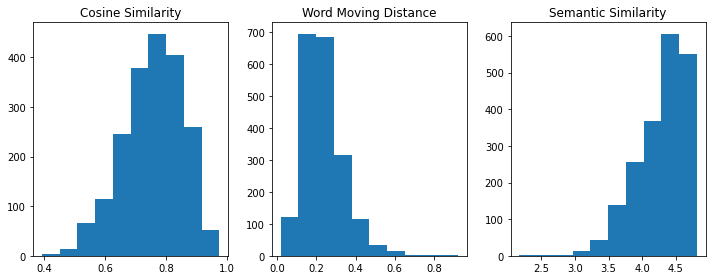


	 	 **Context Augmentation**
Cosine Similarity statistics: count    615.000000
mean       0.536371
std        0.085645
min        0.190874
25%        0.492502
50%        0.541544
75%        0.588364
max        0.787796
Name: CosineSim, dtype: float64
WMD Similarity statistics: count    615.000000
mean       0.486709
std        0.132039
min        0.168102
25%        0.388621
50%        0.470444
75%        0.569218
max        0.998268
Name: Wmd, dtype: float64
Semantic Similarity statistics: count    615.000000
mean       3.616030
std        0.635835
min        1.182690
25%        3.210384
50%        3.655582
75%        4.116805
max        4.722283
Name: Semantic_sim, dtype: float64


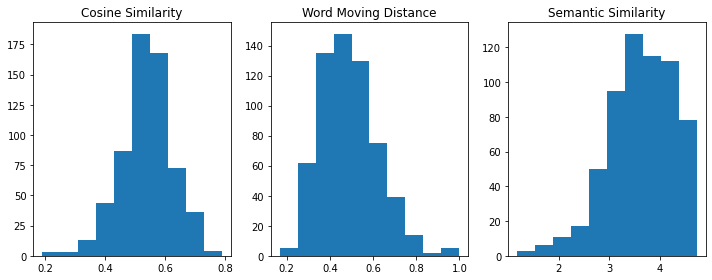


	 	 **BackTranslation Augmentation**
Cosine Similarity statistics: count    595.000000
mean       0.618749
std        0.180326
min        0.067436
25%        0.486187
50%        0.622633
75%        0.754897
max        1.000000
Name: CosineSim, dtype: float64
WMD Similarity statistics: count    595.000000
mean       0.305288
std        0.168176
min        0.000000
25%        0.195596
50%        0.274172
75%        0.396232
max        1.865592
Name: Wmd, dtype: float64
Semantic Similarity statistics: count    595.000000
mean       4.256623
std        0.538834
min        1.575664
25%        3.914784
50%        4.469916
75%        4.676876
max        4.815845
Name: Semantic_sim, dtype: float64


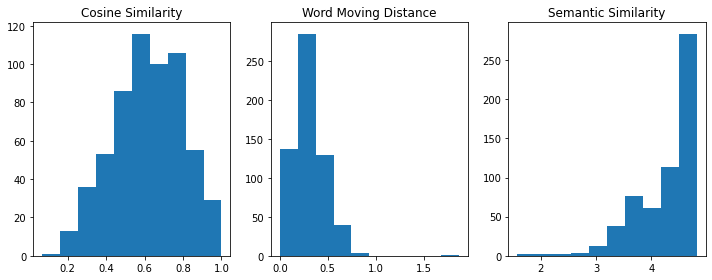

In [ ]:
# checking average similarity score in the test dataset
def similarity_description(df):
  print(f'Cosine Similarity statistics: {df[cosine_sim].describe()}')
  print(f'WMD Similarity statistics: {df[wmd_sim].describe()}')
  print(f'Semantic Similarity statistics: {df[semantic_sim].describe()}')
  
  fig, axs = plt.subplots(1, 3,figsize=(10,4),tight_layout=True)
  # We can set the number of bins with the `bins` kwarg
  axs[0].hist(df[cosine_sim])
  axs[0].set_title('Cosine Similarity')
  axs[1].hist(df[wmd_sim])
  axs[1].set_title('Word Moving Distance')
  axs[2].hist(df[semantic_sim])
  axs[2].set_title('Semantic Similarity')
  plt.show()

print('\t \t **Synonym Augmentation**')
similarity_description(df_aug_syn_test)
print('\n\t \t **Context Augmentation**')
similarity_description(df_aug_con_test)
print('\n\t \t **BackTranslation Augmentation**')
similarity_description(df_aug_bt_test)

In [ ]:
# Now adjust the threshold accordingly
cos_sim_thres=[0.80,0.99]
wmd_thres=[0.1,0.95]
semantic_sim_thres=[4.0,4.9]

# filtering the test data according to the threshold
def filter_similarity(df, aug_type='syn'):
  '''
  aug_type: str-> 'syn','con','bt'
  Filtering the dataframe accoring to the similarity threshold.
  - For synonym augmentation we need cosine similarity ,word moving distance, and semantic similarity
  - For Backtranslation, we just need semantic similarity and cosine similarity
  - For context , we need semantic similarity only
  '''
  if aug_type is 'syn':
    df=df[(df[cosine_sim]>cos_sim_thres[0]) & (df[cosine_sim]<cos_sim_thres[1]) ]
    df=df[(df[wmd_sim]>wmd_thres[0]) & (df[wmd_sim]<wmd_thres[1]) ]
    df=df[(df[semantic_sim]>semantic_sim_thres[0]) & (df[semantic_sim]<semantic_sim_thres[1]) ].reset_index(drop=True)
  elif aug_type is 'bt':
    df=df[(df[cosine_sim]>cos_sim_thres[0]) & (df[cosine_sim]<cos_sim_thres[1])]
    df=df[(df[semantic_sim]>semantic_sim_thres[0]) & (df[semantic_sim]<semantic_sim_thres[1]) ].reset_index(drop=True)
  else:
    df=df[(df[semantic_sim]>semantic_sim_thres[0]) & (df[semantic_sim]<semantic_sim_thres[1]) ].reset_index(drop=True)

  return df 

df_aug_syn_fil_test=filter_similarity(df_aug_syn_test,'syn')
df_aug_con_fil_test=filter_similarity(df_aug_con_test,'con')
df_aug_bt_fil_test=filter_similarity(df_aug_bt_test,'bt')


# concatinating the test data 
df_aug_fil_test = df_aug_syn_fil_test.append(df_aug_con_fil_test).append(df_aug_bt_fil_test)
df_aug_fil_test= df_aug_fil_test.sample(frac=1).reset_index(drop=True)


df_aug_fil_test

,aug_tweet,label,tweet,CosineSim,Wmd,Semantic_sim
0,our total number of confirmed case of covid re...,0,our total number of confirmed case of covid re...,0.872034,0.195345,4.239185
1,rt alexmahadevan have a great sentence moderat...,1,rt alexmahadevan had a great time moderating t...,0.841661,0.205537,4.644955
2,since 9th of june we suffer rolled out the exa...,0,since 9th of june we have rolled out the testi...,0.844555,0.196747,4.347596
3,gargling for salt water and inhaling hot water...,1,gargling by salt water and inhaling hot water ...,0.847762,0.155026,4.761106
4,loss of taste and smell personify a symptom of...,0,loss of taste and smell is a symptom of covid ...,0.813180,0.193100,4.229155
...,...,...,...,...,...,...
833,now we re moving to a new phase angle where ma...,0,now we re moving to a new phase where many of ...,0.801731,0.285137,4.434632
834,covid vaccine will cost overly much to be acce...,0,covid vaccine will cost too much to be accessi...,0.847762,0.232164,4.726091
835,say wa coronavirus wa engineered by a scientis...,1,say the coronavirus wa engineered by scientist...,0.859177,0.184901,4.759151
836,news jeremy corbyn demand open government conv...,1,news jeremy corbyn demand government open talk...,0.801978,0.255566,4.779361


## Label Distribution

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


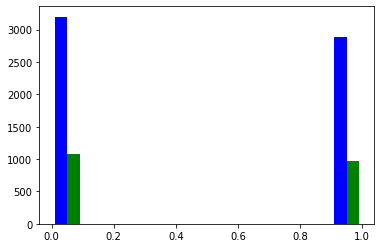

In [ ]:
# Label distribution of train and test dataset
plt.hist([df_train[target_col],df_test[target_col]],color=['blue','green'])
plt.show()

# Functions Declaration


Functions :
- Data Splitter 
- Creating Tokenizer 
- Convert to category 
- Data Tokenization 
- Evaluation 
- Augmentation Evaluation

In [17]:
# in case we need to perform splitting 
def dataset_split(dataset,test_size):
    '''Split the dataframe into train and test '''
    df_train=dataset.sample(frac=(1-test_size),random_state=200) #random state is a seed value
    df_test=df.drop(df_train.index)
    df_train= df_train.reset_index(drop=True)
    df_test=df_test.reset_index(drop=True)
    return df_train,df_test

# Converting to categories 
def convert_to_category(target, n_classes=2):
    return to_categorical(target,n_classes)

#Creating tokenizer
def create_tokenizer(pretrained_weights='distilbert-base-uncased'):
    '''Function to create the tokenizer'''

    tokenizer = AutoTokenizer.from_pretrained(pretrained_weights)
    return tokenizer

#Tokenization of the data
def data_tokenization(dataset,feature_name,pretrained_weights,max_len,tokenizer):
    '''dataset: Pandas dataframe with feature name is column name 
    Pretrained_weights: selected model 
    RETURN: [input_ids, attention_mask]'''

    tokens = dataset[feature_name].apply(lambda x: tokenizer(x,return_tensors='tf', 
                                                            truncation=True,
                                                            padding='max_length',
                                                            max_length=max_len, 
                                                            add_special_tokens=True))
    input_ids= []
    attention_mask=[]
    for item in tokens:
        input_ids.append(item['input_ids'])
        attention_mask.append(item['attention_mask'])
    input_ids, attention_mask=np.squeeze(input_ids), np.squeeze(attention_mask)

    # if we have label column
    if (target_col in dataset.columns):
        y= convert_to_category(dataset[target_col],2)
        return [input_ids,attention_mask], y, tokenizer.vocab_size
    else:
        return [input_ids,attention_mask]

# Model Evaluation 
def evaluation(model,x_test,y_test,n_class=2):
    '''
    Evaluation of the model in case you have test data in numpy array format
    Return- predicted label and accuracy
    '''
    y_pred= model.predict(x_test)
    if n_class>1:
        y_pred=tf.argmax(y_pred,1)
        y_true=tf.argmax(y_test,1)
    else:
        y_true=y_test
    cl_r=classification_report(y_true,y_pred,output_dict=True)
    # print(classification_report(y_true,y_pred))
    return y_pred, cl_r['accuracy']


# Augmented Data Evaluation 
def augmentation_evaluation(df_aug,model,tokenizer, only_input_ids=False, output_result=False):
    '''
    Function to evaluate the augmented and orignial test data
    in case you have dataframe for prediction
    Only_input_ids: if you need only input ids from tokenizer
    output_result: True return the  original and augmentated accuracy
    along with the df
    Return: df with prediction and it will write in the report file
    '''
    try:
        if only_input_ids:
            [x_orig,_],y,_ = data_tokenization(df_aug,feature_col,pretrained_weights,max_len,tokenizer)
            [x_aug,_],_,_ = data_tokenization(df_aug,aug_col,pretrained_weights,max_len,tokenizer)
        else:
            x_orig,y,_ = data_tokenization(df_aug,feature_col,pretrained_weights,max_len,tokenizer)
            x_aug,_,_ = data_tokenization(df_aug,aug_col,pretrained_weights,max_len,tokenizer)
    except:
        pass
    df_result=df_aug.copy()
   
    y_pred,ori_acc=evaluation(model,x_orig,y)
    df_result['original_pred']= y_pred

    
    y_pred,aug_acc=evaluation(model,x_aug,y)
    df_result['aug_pred']=y_pred

    if output_result:
      return df_result,ori_acc,aug_acc
    else:
      return




# Report Writing

This section is related to writing required details in dataframe and saving in csv format.

In [ ]:
# creating report df dataframe
def create_report():
  '''
  Creating the dataframe for report
  '''
  report_df = pd.DataFrame(columns=['Date', 'Model','Train_size',
                                    'Aug_Test_size', 'Type','Hyperparameters',
                                    'Original_Accuracy','AA_Accuracy','Perturbation',
                                    'Avg_Sem_Sim','Avg_Cos_Similarity','Avg_WMD','Comment'])

  return report_df


#Logging the details
def report_writing(model,tokenizer,model_name,df_test,type_of_aug,comment,only_input=False):
  '''
  Function to write the evaluation metrics in the report csv file.
  Input:
  model- model to evaluate
  df_test- test dataframe, must have original text, aug text, label, cosine sim, wmd, similarity
  hyperparamter_details- epochs, batch_size, alpha, ratio
  TODO: Perturbation percentage
  '''
  # accessing the details
  df_result, ori_acc, aug_acc=augmentation_evaluation(df_test,model,tokenizer,only_input_ids=only_input, output_result=True)
  print(f'Original Accuracy : {ori_acc}, Accuracy after Attack : {aug_acc}')
  train_size=df_train.shape[0]
  test_size=df_test.shape[0]
  hyperparameters=[epochs,learning_rate,batch_size,alpha,ratio,max_len,pretrained_weights]
  avg_sem_sim=df_test[semantic_sim]


  #creating the report
  report_df=create_report()

  #adding in the dataframe
  x = datetime.datetime.now()
  report_df = report_df.append({'Date' : x.strftime("%c"), 'Model' :model_name,'Train_size': train_size ,
                                'Aug_Test_size': test_size, 'Type': type_of_aug,'Hyperparameters': hyperparameters,
                                'Original_Accuracy': ori_acc,'AA_Accuracy':aug_acc,'Perturbation': None,
                                'Avg_Sem_Sim': df_test[semantic_sim].mean(),'Avg_Cos_Similarity':df_test[cosine_sim].mean(),
                                'Avg_WMD':df_test[wmd_sim].mean(),'Comment':comment
                                  }, ignore_index=True)  
 
  file_l = Path('Result/'+model_name+'_'+'.csv')

  if file_l.exists():
      report_df.to_csv(file_l,mode='a', header= False , index = False)
  else:
      report_df.to_csv(file_l,mode='w', header= True , index= False)
  return 

# Supervised Model 
Baseline model to verify model performance. 


In [ ]:
# Supervised model declaration 
def seq_model(maxlen,vocab_size):
    input= tf.keras.Input(shape=(max_len,))
    x= Embedding(vocab_size,max_len,input_length=None)(input)
    x= Bidirectional(LSTM(128))(x)
    x= Dense(64)(x)
    x= Dropout(0.2)(x)
    x=Dense(32)(x)
    x= Dense(16)(x)
    output=Dense(2,activation='sigmoid')(x)
    model= Model(input,output)
    model.compile(tf.keras.optimizers.Adam(learning_rate= learning_rate),loss= tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
    return model

In [ ]:
# tokenization 
tokenizer= create_tokenizer()
[x_train,_],y_train,vocab_size= data_tokenization(df_train,feature_col,pretrained_weights,max_len,tokenizer)
[x_test,_],y_test,_= data_tokenization(df_test,feature_col,pretrained_weights,max_len,tokenizer)

In [ ]:
#training
bilstm_model=seq_model(max_len,vocab_size)
# bilstm_model.summary()
with tf.device('/GPU:0'):
    bilstm_model.fit(x_train,y_train,
                     batch_size=batch_size,
                     epochs=epochs+4,
                     verbose=1)

In [ ]:
report_writing(bilstm_model,tokenizer,'BILSTM',df_aug_syn_fil_test,'syn','Bilstm model', only_input=True)
report_writing(bilstm_model,tokenizer,'BILSTM',df_aug_con_fil_test,'con','Bilstm model', only_input= True)
report_writing(bilstm_model,tokenizer,'BILSTM',df_aug_bt_fil_test,'bt','Bilstm model', only_input= True)
report_writing(bilstm_model,tokenizer,'BILSTM',df_aug_fil_test,'all','Bilstm model', only_input=True)

In [ ]:
# saving the model
bilstm_model.save('SavedModels/Bilstm_model.h5')

In [ ]:
test_model=tf.keras.models.load_model('SavedModels/Bilstm_model.h5')

report_writing(test_model,tokenizer,'BILSTM',df_aug_syn_fil_test,'syn','Bilstm model', only_input=True)

# BERT Model 

In [18]:
from transformers import TFDistilBertModel, DistilBertConfig

def bert_model(max_len,pretrained_weights):
    '''BERT model creation with pretrained weights
    max_len: input length '''
    # Define weight initializer with a random seed to ensure reproducibility
    # weight_initializer = tf.keras.initializers.GlorotNormal(seed=42)
    # DISTILBERT_DROPOUT = 0.2
    # DISTILBERT_ATT_DROPOUT = 0.2
 
    # # Configure DistilBERT's initialization
    # config = DistilBertConfig(dropout=DISTILBERT_DROPOUT, 
    #                         attention_dropout=DISTILBERT_ATT_DROPOUT, 
    #                         output_hidden_states=True)
                          
    # The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
    # and without any specific head on top.
    # distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

    bert=TFAutoModel.from_pretrained(pretrained_weights)
    
    # This is must if you would like to train the layers of language models too.
    for layer in bert.layers:
        layer.trainable = True

    # parameter declaration
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # declaring inputs, BERT take input_ids and attention_mask as input
    input_ids= Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
    attention_mask=Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

    bert= bert(input_ids,attention_mask=attention_mask)
    x= bert[0][:,0,:]
    x=tf.keras.layers.Dropout(0.2)(x)
    x= tf.keras.layers.Dense(64)(x)
    x=tf.keras.layers.Dense(32)(x)

    output=tf.keras.layers.Dense(2,activation='sigmoid')(x)

    model=Model(inputs=[input_ids,attention_mask],outputs=[output])
    # compiling model 
    model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
tokenizer=create_tokenizer(pretrained_weights)
x_train,y_train,vocab_size= data_tokenization(df_train,feature_col,pretrained_weights,max_len,tokenizer)
x_test,y_test,_= data_tokenization(df_test,feature_col,pretrained_weights,max_len,tokenizer)

In [ ]:
bert=bert_model(max_len,pretrained_weights)
bert.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_bert_model[0][0]         

In [ ]:
with tf.device('/GPU:0'):
    bert.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1)

Epoch 1/3
1523/1523 [==============================] - 189s 118ms/step - loss: 0.2555 - accuracy: 0.8961
Epoch 2/3
1523/1523 [==============================] - 183s 120ms/step - loss: 0.0869 - accuracy: 0.9668
Epoch 3/3
1520/1523 [============================>.] - ETA: 0s - loss: 0.0282 - accuracy: 0.9923

In [ ]:
evaluation(bert,x_test,y_test)

(<tf.Tensor: shape=(2040,), dtype=int64, numpy=array([0, 1, 1, ..., 0, 0, 0])>,
 0.9470588235294117)

In [ ]:
#saving the model 
bert.save_weights('SavedModels/BERT_model.h5')

# Adversarial Mean Teacher BERT

## Functions

In [ ]:
# ref:https://github.com/CuriousAI/mean-teacher/tree/master/tensorflow/mean_teacher  updated according to our need .
def cal_classification_cost(logits, labels) :
    """ Commputing classification cost , after removing labels -1 of unlabelled data and then calculating
    the binary cross entropy .
    """
    # applicable = tf.not_equal(labels, -1)
    # Change -1s to zeros to make cross-entropy computable
    # labels = tf.where(applicable, labels, tf.zeros_like(labels))
    loss=tf.reduce_sum(tf.keras.losses.categorical_crossentropy(labels, logits))
    # tf.keras.losses.kl_divergence()
    # Retain costs only for labeled
    # per_sample=tf.where(applicable[:,1], per_sample, tf.zeros_like(per_sample))
    # Take mean over all examples, not just labeled examples.
    # loss = tf.math.divide(tf.reduce_mean(tf.reduce_sum( per_sample ) ), np.shape ( per_sample )[0] )
    # print('Classification Cost: ',loss)
    return loss

def cal_overall_cost(x_train,y_train,x_unlabel,student, teacher):
    #TODO: need to include noising technique
    ratio=0.5
    logits = student(x_train)
    classification_cost = cal_classification_cost(logits, y_train)
    tar_student = student(x_unlabel)
    tar_teacher = teacher(x_unlabel)
    
    consistency_cost = cal_consistency_cost( tar_student, tar_teacher)
    # print('consistency_cost : ',consistency_cost)
    return (ratio * classification_cost) + ((1 - ratio) * consistency_cost)

# function for consistency cost
def cal_consistency_cost(student_output, teacher_output) :
    return tf.reduce_sum(tf.losses.mean_squared_error(student_output, teacher_output ))

def ema(student_model, teacher_model, alpha=0.999) :
    # taking weights
    student_weights = student_model.get_weights()
    teacher_weights = teacher_model.get_weights()
    # length must be equal otherwise it will not work
    assert len(student_weights ) == len(teacher_weights ), 'length of student and teachers weights are not equal Please check. \n Student: {}, \n Teacher:{}'.format (
        len(student_weights ), len (teacher_weights ) )
    new_layers = []
    for i, layers in enumerate ( student_weights ) :
        new_layer = alpha * (teacher_weights[i]) + (1 - alpha) * layers
        new_layers.append(new_layer)
    teacher_model.set_weights(new_layers)
    return teacher_model

def data_slices(x_train,y_train,x_unlabel,batch_size):
    train_dataset = tf.data.Dataset.from_tensor_slices( (x_train[0],x_train[1], y_train) )
    train_dataset = train_dataset.shuffle( buffer_size=1024 ).batch(batch_size)

    unlabel_dataset = tf.data.Dataset.from_tensor_slices( (x_unlabel[0],x_unlabel[1]) )
    unlabel_dataset = unlabel_dataset.shuffle( buffer_size=1024 ).batch(batch_size)
    return train_dataset, unlabel_dataset

In [ ]:
def train_mean_teacher(x_train, y_train, x_unlabel, epochs,batch_size,lr,alpha):
    # preparing the training dataset
    train_dataset,unlabel_dataset = data_slices(x_train, y_train,x_unlabel,batch_size)
    # declaring optimiser
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    # creating model
    student = bert_model(max_len,pretrained_weights)#call for the model here
    teacher = bert_model(max_len,pretrained_weights) #call for model here
    print('alpha:', alpha)

    # declaring metrics
    train_metrics = tf.keras.metrics.BinaryAccuracy(name='Binary_Accuracy')
    progbar = tf.keras.utils.Progbar(len(train_dataset), stateful_metrics=['Accuracy', 'Overall_Loss'])
    # epochs = args.epochs
    step_counter = 0
    for epoch in range(epochs):
        tf.print(f'\nepoch {epoch + 1}')
        # iterator_noise = iter(noise_dataset)
        for step, ((input_ids,attention_ids, y_batch_train),(input_ids_un,attention_ids_un)) in enumerate(zip(train_dataset,unlabel_dataset)):
            with tf.GradientTape() as tape:
                overall_cost = cal_overall_cost([input_ids,attention_ids], 
                                                y_batch_train,
                                                [input_ids_un,attention_ids_un],
                                                student, 
                                                teacher)

            grads = tape.gradient(overall_cost, student.trainable_weights)
            optimizer.apply_gradients((grad, var) for (grad, var) in zip(grads, student.trainable_weights) if grad is not None)
            # applying student weights to teacher
            step_counter += 1
            teacher = ema(student, teacher, alpha=alpha)
            # calculating training accuracy
            logits_t = teacher([input_ids,attention_ids])
            train_acc = train_metrics(tf.argmax(y_batch_train, 1), tf.argmax(logits_t, 1))
            progbar.update(step, values=[('Accuracy', train_acc), ('Overall_Loss', overall_cost)])

    return student, teacher


In [ ]:
# Training
tokenizer=create_tokenizer(pretrained_weights)
x_train,y_train,vocab_size= data_tokenization(df_train,feature_col,pretrained_weights,max_len,tokenizer)
x_test,y_test,_= data_tokenization(df_test,feature_col,pretrained_weights,max_len,tokenizer)
x_unlabel,_,_=data_tokenization(df_aug_unlabel,aug_col,pretrained_weights,max_len,tokenizer)

In [ ]:
with tf.device('/GPU:0'):
    student, teacher= train_mean_teacher(x_train, y_train, x_unlabel, 
                                         epochs,batch_size,
                                         learning_rate,alpha)

alpha: 0.999

epoch 1
1522/1523 [============================>.] - ETA: 2s - Accuracy: 0.8189 - Overall_Loss: 0.0305
epoch 2
1522/1523 [============================>.] - ETA: 2s - Accuracy: 0.9031 - Overall_Loss: 0.0066
epoch 3
1522/1523 [============================>.] - ETA: 2s - Accuracy: 0.9352 - Overall_Loss: 0.0026

In [ ]:
teacher.save_weights('SavedModels/BERT_teacher.h5')

In [ ]:
evaluation(teacher,x_test,y_test)

(<tf.Tensor: shape=(2040,), dtype=int64, numpy=array([0, 1, 1, ..., 0, 0, 0])>,
 0.9524509803921568)

In [ ]:
del bert

# Text attack

In [36]:
import numpy as np
import torch
import textattack
# model wrapper for attack
from textattack.models.wrappers import ModelWrapper
#attack recipe importing
from textattack.attack_recipes.bert_attack_li_2020 import BERTAttackLi2020
from textattack.attack_recipes import PWWSRen2019
from textattack.attack_recipes.bae_garg_2019 import BAEGarg2019
from textattack.attack_recipes.textfooler_jin_2019 import TextFoolerJin2019
from textattack import Attacker


class CustomTensorFlowModelWrapper(ModelWrapper):
    '''
    This wrapper is required to attack the model using text attack.
    '''
    def __init__(self, model,pretrained_weights):
        self.model = model
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_weights)

    def __call__(self, text_input_list):
        tokens=self.tokenizer(text_input_list,return_tensors='tf', 
                         truncation=True,
                         padding='max_length',
                         max_length=max_len, 
                         add_special_tokens=True)
        
        input_ids= []
        attention_mask=[]
        input_ids.append(tokens.input_ids)
        attention_mask.append(tokens.attention_mask)
        preds = torch.tensor(self.model([input_ids, attention_mask]).numpy())
  
        return preds
class CustomTensorFlowModelWrapperSupervised(ModelWrapper):
    def __init__(self, model):
        self.model = model

    def __call__(self, text_input_list):
        tokenizer = AutoTokenizer.from_pretrained(pretrained_weights)
        tokens=tokenizer(text_input_list,return_tensors='tf', 
                         truncation=True,
                         padding='max_length',
                         max_length=max_len, 
                         add_special_tokens=True)
        
        input_ids= []
        input_ids.append(tokens.input_ids)
        preds = torch.tensor(self.model(tokens.input_ids).numpy())
  
        return preds


In [30]:
df_test['len']=df_test.apply(lambda row: len(row[feature_col].split()),axis=1)
df_test_for_attack= df_test[(df_test['len']>0) & (df_test['len']<100)][[feature_col,target_col]].dropna().reset_index(drop=True)
df_test_for_attack=df_test_for_attack.sample(frac=1).reset_index(drop=True)

df_test_for_attack

,tweet,label
0,covid can present a mild symptom which make it...,0
1,having a difficult time coping because of covi...,0
2,face mask cause hypoxia wearing it cause one t...,1
3,adding the new incidence metric ha changed the...,0
4,one other note the u s positive rate ha remain...,0
...,...,...
2035,rt globalfund report covid ha potential to dis...,0
2036,hospitalist compensation report of every hospi...,0
2037,new covid measure have been introduced by the ...,0
2038,rt drharshvardhan covid update the gap between...,0


In [42]:
from datetime import datetime
now = datetime.now().strftime("%Y-%m-%d_%H:%M")

#folder name for saving the report 
folderName= 'Textfooler'#'BAE'#'BERTAttackBert' #PWWSRen2019

#creating dataset for the attacking
dataset_for_attack=list(df_test_for_attack.itertuples(index=False, name=None))
dataset_for_attack = textattack.datasets.Dataset(dataset_for_attack)

In [38]:
#loading the model
BERT_model= bert_model(max_len,pretrained_weights) 
BERT_model.load_weights('SavedModels/BERT_model.h5')

model_wrapper = CustomTensorFlowModelWrapper(BERT_model,pretrained_weights)

# attack = PWWSRen2019.build(model_wrapper)
# attack = BERTAttackLi2020.build(model_wrapper)
# attack=BAEGarg2019.build(model_wrapper)
attack=TextFoolerJin2019.build(model_wrapper)
attack_args = textattack.AttackArgs (
    num_examples=500,
    log_to_csv=f'Result/{folderName}/Bert_nexp500_len100_qb200_{now}.csv',
    disable_stdout=False,
    query_budget=200
)
with tf.device('/GPU:0'):
  attacker = Attacker(attack, dataset_for_attack,attack_args)
  attacker.attack_dataset()


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
textattack: Unknown if model of class <class 'tensorflow.python.keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path Result/BAE/Bert_nexp500_len100_qb200_2021-07-16_00:22.csv
  0%|          | 0/500 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/500 [00:06<50:32,  6.08s/it]

--------------------------------------------- Result 1 ---------------------------------------------
0 (73%) --> [FAILED]

covid can present a mild symptom which make it difficult to differentiate from illness such a malaria the only way to diagnosis is through testing we advice nigerian to selfreport if they notice known symptom beeodune on tvcconnect takeresponsibility




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:   0%|          | 2/500 [00:08<33:25,  4.03s/it]

--------------------------------------------- Result 2 ---------------------------------------------
0 (100%) --> [FAILED]

having a difficult time coping because of covid feeling lonely anxious or dealing with grief and loss help is available through the national suicide prevention lifeline learn more




[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:   1%|          | 3/500 [00:09<24:56,  3.01s/it]

--------------------------------------------- Result 3 ---------------------------------------------
1 (73%) --> 0 (62%)

face mask cause hypoxia wearing it cause one to inhale too much carbon dioxide which can make you sick

face cache entail hypoxia wearing it cause one to inhale too much carbon dioxide which can make you sick




[Succeeded / Failed / Skipped / Total] 1 / 3 / 0 / 4:   1%|          | 4/500 [00:11<24:07,  2.92s/it]

--------------------------------------------- Result 4 ---------------------------------------------
0 (73%) --> [FAILED]

adding the new incidence metric ha changed the score of county and expanded our coverage to county previously many county did not have enough data for u to calculate a risk score it is critical for local decisionmakers to have locallevel data




[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:   1%|          | 5/500 [00:13<21:39,  2.62s/it]

--------------------------------------------- Result 5 ---------------------------------------------
0 (73%) --> 1 (51%)

one other note the u s positive rate ha remained around throughout april the positive rate for todays reported test dropped to one day doesnt make a trend but good to see a lower floor

one other note the u s positive tariff ha remained around throughout april the positive rate for tomorrows says test dropped to one day doesnt make a propensity but good to see a lower floor




[Succeeded / Failed / Skipped / Total] 2 / 4 / 0 / 6:   1%|          | 6/500 [00:15<21:00,  2.55s/it]

--------------------------------------------- Result 6 ---------------------------------------------
0 (100%) --> [FAILED]

indiafightscorona of the total active case are found in nine most affected state ut new case have been reported in the last hour in the country detail staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 3 / 4 / 0 / 7:   1%|▏         | 7/500 [00:16<19:11,  2.34s/it]

--------------------------------------------- Result 7 ---------------------------------------------
1 (73%) --> 0 (59%)

sweden to be extradited to united state for violating american covid guideline coronavirus covid sweden

gothenburg to be vacated to united state for breakage usa covid guideline coronavirus covid sweden




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:   2%|▏         | 8/500 [00:17<18:17,  2.23s/it]

--------------------------------------------- Result 8 ---------------------------------------------
0 (73%) --> 1 (71%)

we have our daily pm update live now weve tracked people tested total

we have our unremarkable pm moderne vivant now weve policed people tested unmitigated




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:   2%|▏         | 9/500 [00:18<16:40,  2.04s/it]

--------------------------------------------- Result 9 ---------------------------------------------
1 (73%) --> 0 (54%)

the cdc recommends that only people with covid symptom should wear mask

the cle recommends that only people with covid symptom should wear mask




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10:   2%|▏         | 10/500 [00:19<16:10,  1.98s/it]

--------------------------------------------- Result 10 ---------------------------------------------
1 (73%) --> 0 (56%)

dr anthony fauci ha known for year that chloroquine and hydroxychloroquine will not only treat a current case of coronavirus but prevent future case

dr antwan fauci ha acknowledge for year that chloroquine and hydroxychloroquine will not only treat a current case of coronavirus but prevent futur proceeding




[Succeeded / Failed / Skipped / Total] 6 / 5 / 0 / 11:   2%|▏         | 11/500 [00:21<16:16,  2.00s/it]

--------------------------------------------- Result 11 ---------------------------------------------
0 (100%) --> [FAILED]

our model estimate that louisiana ha a high positive test rate and is near full icu capacity louisiana ha an elevated risk based on our reopeningsafely metric learn more




[Succeeded / Failed / Skipped / Total] 7 / 5 / 0 / 12:   2%|▏         | 12/500 [00:24<16:17,  2.00s/it]

--------------------------------------------- Result 12 ---------------------------------------------
0 (73%) --> 1 (53%)

currently most case of covid in the u are in california and washington state however many other community are also dealing with case of covid see cdc recommendation for preventing spread of covid in community

nu most case of covid in the u are in california and tacoma sate however many other communal are also cure with case of covid believing cdc recommendation for preventing spread of covid in community




[Succeeded / Failed / Skipped / Total] 8 / 5 / 0 / 13:   3%|▎         | 13/500 [00:25<16:07,  1.99s/it]

--------------------------------------------- Result 13 ---------------------------------------------
1 (73%) --> 0 (59%)

lot of young banker are affected by corona virus and soon bank can become biggest outbreak place these young ppl can become threat to their elder at home it high time that statebank pak should think of saving these life please covidpakistan

multiple of young ribera are affected by corona virus and soon shoreline can become biggest outbreak place these young ppl can become threat to their elder at home it high time that statebank pak should insights of conservation these life please covidpakistan




[Succeeded / Failed / Skipped / Total] 9 / 5 / 0 / 14:   3%|▎         | 14/500 [00:26<15:27,  1.91s/it]

--------------------------------------------- Result 14 ---------------------------------------------
1 (73%) --> 0 (51%)

nations mom form vigilante gang to make sure you get that cough checked out coldandflu winter coronavid

population ma form vigilante strapping to make sure you get that cough checked out coldandflu winter coronavid




[Succeeded / Failed / Skipped / Total] 9 / 6 / 0 / 15:   3%|▎         | 15/500 [00:28<15:35,  1.93s/it]

--------------------------------------------- Result 15 ---------------------------------------------
0 (100%) --> [FAILED]

followlasg ha reported the recovery of covid patient managed in the community in line with the new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 9 / 7 / 0 / 16:   3%|▎         | 16/500 [00:31<15:46,  1.96s/it]

--------------------------------------------- Result 16 ---------------------------------------------
0 (100%) --> [FAILED]

indiafightscorona state and ut have registered recovery rate more than the national average of the new recovered case are from state ut detail staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 9 / 8 / 0 / 17:   3%|▎         | 17/500 [00:33<15:49,  1.97s/it]

--------------------------------------------- Result 17 ---------------------------------------------
0 (73%) --> [FAILED]

rt pib india indiafightscorona average daily test conducted week wise india ha set a record in covid test conducted per day




[Succeeded / Failed / Skipped / Total] 9 / 9 / 0 / 18:   4%|▎         | 18/500 [00:35<15:54,  1.98s/it]

--------------------------------------------- Result 18 ---------------------------------------------
0 (73%) --> [FAILED]

coronavirusupdates indiafightscorona case fatality rate cfr further dip to active case reduced to le than recorded yesterday covid recovery exceed active case by nearly lakh




[Succeeded / Failed / Skipped / Total] 10 / 9 / 0 / 19:   4%|▍         | 19/500 [00:36<15:26,  1.93s/it]

--------------------------------------------- Result 19 ---------------------------------------------
0 (73%) --> 1 (70%)

heres a look at the number of test per people in the state

heres a look at the chiffre of cheques per people in the state




[Succeeded / Failed / Skipped / Total] 11 / 9 / 0 / 20:   4%|▍         | 20/500 [00:38<15:26,  1.93s/it]

--------------------------------------------- Result 20 ---------------------------------------------
0 (73%) --> 1 (62%)

our daily update is published state reported k test and k case covid death were reported today about down from last saturday

our daily discounted is published statehood counseled k check and k case covid death were alluded today about down from last saturday




[Succeeded / Failed / Skipped / Total] 11 / 10 / 0 / 21:   4%|▍         | 21/500 [00:41<15:36,  1.96s/it]

--------------------------------------------- Result 21 ---------------------------------------------
1 (73%) --> [FAILED]

video of west sumatra resident in indonesia throwing off chinese tourist and burning their belonging during the covid pandemic




[Succeeded / Failed / Skipped / Total] 11 / 11 / 0 / 22:   4%|▍         | 22/500 [00:43<15:43,  1.97s/it]

--------------------------------------------- Result 22 ---------------------------------------------
1 (73%) --> [FAILED]

susan lemon commondefense berniesanders omg are you frigging kidding me just like trump knowing how deadly the coronavirus wa same go for the police that night they said the knocked it wa their word against her distraught boyfriend




[Succeeded / Failed / Skipped / Total] 11 / 12 / 0 / 23:   5%|▍         | 23/500 [00:45<15:39,  1.97s/it]

--------------------------------------------- Result 23 ---------------------------------------------
0 (73%) --> [FAILED]

yesterday hhs sec azar announced the us fda ha completed it review of the ind application for mrna our potential vaccine for sarscov allowed it to proceed to clinic on feb the st clinical batch of mrna wa shipped to nih for use in the phase study




[Succeeded / Failed / Skipped / Total] 12 / 12 / 0 / 24:   5%|▍         | 24/500 [00:46<15:12,  1.92s/it]

--------------------------------------------- Result 24 ---------------------------------------------
1 (72%) --> 0 (66%)

prolonged use of face mask cause o deficiency or co intoxication

prolonged use of face mask justification o deficiency or co intoxication




[Succeeded / Failed / Skipped / Total] 13 / 12 / 0 / 25:   5%|▌         | 25/500 [00:47<14:54,  1.88s/it]

--------------------------------------------- Result 25 ---------------------------------------------
1 (73%) --> 0 (63%)

french doctor protest after discovering covid pandemic is a fraud

fre doctor protest after discovering covid pathological is a defrauding




[Succeeded / Failed / Skipped / Total] 13 / 13 / 0 / 26:   5%|▌         | 26/500 [00:49<14:54,  1.89s/it]

--------------------------------------------- Result 26 ---------------------------------------------
0 (100%) --> [FAILED]

indiafightscorona people have recovered more than the active case with this indias recovery rate amongst the covid patient ha crossed today detail mohfw india icmrdelhi drharshvardhan staysafe




[Succeeded / Failed / Skipped / Total] 14 / 13 / 0 / 27:   5%|▌         | 27/500 [00:50<14:48,  1.88s/it]

--------------------------------------------- Result 27 ---------------------------------------------
1 (73%) --> 0 (51%)

a video show a man being rescued alive from inside a tomb the caption state he wa buried alive after being declared dead of covid

a filmmaking show a mating being rescued alive from inside a bury the caption state he wa buried alive after being declared casualties of covid




[Succeeded / Failed / Skipped / Total] 15 / 13 / 0 / 28:   6%|▌         | 28/500 [00:51<14:24,  1.83s/it]

--------------------------------------------- Result 28 ---------------------------------------------
1 (73%) --> 0 (73%)

report outbreak of idiocy spreading time faster than coronavirus coronavirus

liaise outbreak of idiocy spreading time faster than coronavirus coronavirus




[Succeeded / Failed / Skipped / Total] 16 / 13 / 0 / 29:   6%|▌         | 29/500 [00:51<14:04,  1.79s/it]

--------------------------------------------- Result 29 ---------------------------------------------
1 (73%) --> 0 (51%)

a photo show a yearold vaccine for canine coronavirus that could be used to prevent the new coronavirus causing covid

a imaging show a yearold vaccine for canine coronavirus that could be used to prevent the new coronavirus causing covid




[Succeeded / Failed / Skipped / Total] 17 / 13 / 0 / 30:   6%|▌         | 30/500 [00:52<13:41,  1.75s/it]

--------------------------------------------- Result 30 ---------------------------------------------
0 (60%) --> 1 (52%)

icu are full forcing covid patient to wait hour and hoursto admit to the emergency room

icu are full forcing covid bedridden to wait hour and hoursto admit to the emergency room




[Succeeded / Failed / Skipped / Total] 18 / 13 / 0 / 31:   6%|▌         | 31/500 [00:52<13:20,  1.71s/it]

--------------------------------------------- Result 31 ---------------------------------------------
1 (71%) --> 0 (63%)

getting a flu shot increase the risk of coronavirus by

getting a epidemics shot increase the risk of coronavirus by




[Succeeded / Failed / Skipped / Total] 19 / 13 / 0 / 32:   6%|▋         | 32/500 [00:53<13:04,  1.68s/it]

--------------------------------------------- Result 32 ---------------------------------------------
0 (67%) --> 1 (50%)

pedalcabby esandeen extremely unlikely given the positive test rate of the u s and known testing criterion see among other thing

pedalcabby esandeen extremely unlikely given the positive test rate of the u s and known testing criterion ver among other thing




[Succeeded / Failed / Skipped / Total] 20 / 13 / 0 / 33:   7%|▋         | 33/500 [00:55<12:59,  1.67s/it]

--------------------------------------------- Result 33 ---------------------------------------------
1 (73%) --> 0 (50%)

a viral text based image post claiming that from italy were infected by mobile phone cover quoting the finding were from a research without specifying any detail or name of the research the post advises to abandon phone cover

a viral text based image post claiming that from ltaly were infected by mobile phone covered quoting the finding were from a research without specifying any detail or name of the research the positioned advises to abandon drew cover




[Succeeded / Failed / Skipped / Total] 20 / 14 / 1 / 35:   7%|▋         | 35/500 [00:57<12:40,  1.63s/it]

--------------------------------------------- Result 34 ---------------------------------------------
0 (73%) --> [FAILED]

indiafightscorona by conducting close to crore covid test    crore covid test were conducted in the last week alone


--------------------------------------------- Result 35 ---------------------------------------------
1 (50%) --> [SKIPPED]

of american adult believe in wearing mask




[Succeeded / Failed / Skipped / Total] 21 / 14 / 1 / 36:   7%|▋         | 36/500 [00:59<12:45,  1.65s/it]

--------------------------------------------- Result 36 ---------------------------------------------
1 (73%) --> 0 (55%)

man dismayed to find his health insurance doesnt cover him for coronavirus china coronavirus insurance

males disconcerted to achieving his health ensuring doesnt cover him for coronavirus chine coronavirus assurance




[Succeeded / Failed / Skipped / Total] 22 / 14 / 1 / 37:   7%|▋         | 37/500 [01:00<12:42,  1.65s/it]

--------------------------------------------- Result 37 ---------------------------------------------
1 (73%) --> 0 (72%)

bill gate said thousand of people will die with the covid vaccine

invoice specializes commented thousand of people will matt with the covid vaccine




[Succeeded / Failed / Skipped / Total] 22 / 15 / 1 / 38:   8%|▊         | 38/500 [01:03<12:46,  1.66s/it]

--------------------------------------------- Result 38 ---------------------------------------------
0 (73%) --> [FAILED]

new case of covid have been confirmed in nigeria in fct in lagos of the were detected on a vessel are returning traveller into nigeria is close contact of a confirmed case a at pm th march there are confirmed case discharged death




[Succeeded / Failed / Skipped / Total] 23 / 15 / 1 / 39:   8%|▊         | 39/500 [01:03<12:35,  1.64s/it]

--------------------------------------------- Result 39 ---------------------------------------------
1 (73%) --> 0 (53%)

indian army ha constructed an advanced hospital with a capacity of bed in barmer rajasthan to cope with covid

indian army ha architecture an advanced clinically with a capacity of bed in barmer rajasthan to cope with covid




[Succeeded / Failed / Skipped / Total] 23 / 16 / 1 / 40:   8%|▊         | 40/500 [01:06<12:40,  1.65s/it]

--------------------------------------------- Result 40 ---------------------------------------------
0 (73%) --> [FAILED]

coronavirusupdates statewise detail of total confirmed covid case till september am states with confirmed case states with confirmed case states with confirmed case total no of confirmed case so far staysafe




[Succeeded / Failed / Skipped / Total] 23 / 17 / 1 / 41:   8%|▊         | 41/500 [01:08<12:43,  1.66s/it]

--------------------------------------------- Result 41 ---------------------------------------------
0 (73%) --> [FAILED]

our daily update is published the focus is on test today state reported k test the lowest figure since july there were k reported case and death




[Succeeded / Failed / Skipped / Total] 24 / 17 / 1 / 42:   8%|▊         | 42/500 [01:09<12:39,  1.66s/it]

--------------------------------------------- Result 42 ---------------------------------------------
1 (73%) --> 0 (58%)

corona virus florida man arrested for robbery using cough a a weapon

corona virus florida copulate arrested for vol using cough a a rearmament




[Succeeded / Failed / Skipped / Total] 24 / 18 / 1 / 43:   9%|▊         | 43/500 [01:11<12:44,  1.67s/it]

--------------------------------------------- Result 43 ---------------------------------------------
0 (100%) --> [FAILED]

bluelily annacb yup thats the prospective data hole thats really opening were very concerned about it but weve seen state like tn sometimes move towards openness alexismadrigal




[Succeeded / Failed / Skipped / Total] 25 / 18 / 1 / 44:   9%|▉         | 44/500 [01:12<12:34,  1.65s/it]

--------------------------------------------- Result 44 ---------------------------------------------
1 (73%) --> 0 (59%)

last year in china a vaccine wa compulsory and that vaccine supposedly host a digitized virus is the one that cause covid and can be activated through g antenna

last year in wah a vaccine wa compulsory and that vaccine supposedly host a digitized virus is the one that cause covid and can be authorizes through sa antenna




[Succeeded / Failed / Skipped / Total] 26 / 18 / 1 / 45:   9%|▉         | 45/500 [01:13<12:26,  1.64s/it]

--------------------------------------------- Result 45 ---------------------------------------------
1 (73%) --> 0 (70%)

local man appoints himself world s foremost expert on coronavirus

local copulate appoints himself welt s foremost specialise on coronavirus




[Succeeded / Failed / Skipped / Total] 26 / 19 / 1 / 46:   9%|▉         | 46/500 [01:16<12:30,  1.65s/it]

--------------------------------------------- Result 46 ---------------------------------------------
0 (73%) --> [FAILED]

at today s ptfcovid briefing our head of disease surveillance elsieilori reiterated the need for adherence to nonpharmaceuticals measure manage covid if our effort to slow the disease spread in nigeria is to be effective we must all takeresponsibility a citizen




[Succeeded / Failed / Skipped / Total] 27 / 19 / 1 / 47:   9%|▉         | 47/500 [01:16<12:19,  1.63s/it]

--------------------------------------------- Result 47 ---------------------------------------------
0 (73%) --> 1 (72%)

here is todays map of new case

here is yesterdays map of freshly case




[Succeeded / Failed / Skipped / Total] 28 / 19 / 1 / 48:  10%|▉         | 48/500 [01:18<12:16,  1.63s/it]

--------------------------------------------- Result 48 ---------------------------------------------
1 (73%) --> 0 (56%)

claim that dr fauci said every american should be microchipped

requisitions that dr fauci testified each american should pose microchipped




[Succeeded / Failed / Skipped / Total] 28 / 20 / 1 / 49:  10%|▉         | 49/500 [01:20<12:17,  1.64s/it]

--------------------------------------------- Result 49 ---------------------------------------------
0 (100%) --> [FAILED]

indiafightscorona maharashtra karnataka andhra pradesh uttar pradesh and tamil nadu contribute of the total active case and are also reporting close to of the total recovered case staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 29 / 20 / 1 / 50:  10%|█         | 50/500 [01:20<12:07,  1.62s/it]

--------------------------------------------- Result 50 ---------------------------------------------
1 (73%) --> 0 (58%)

trumps intervention in the american military justice system to pardon service member accused or convicted of war crime betrays the rule of law the value that make our country exceptional the men and woman who wear the uniform honorably he is not fit to command our troop

outweighs intervention in the american military justice system to pardon service member accused or convicted of war crime betrays the rule of law the value that make our country exceptional the men and woman who wear the uniform honorably he is not fit to command our troop




[Succeeded / Failed / Skipped / Total] 29 / 21 / 1 / 51:  10%|█         | 51/500 [01:22<12:09,  1.62s/it]

--------------------------------------------- Result 51 ---------------------------------------------
0 (73%) --> [FAILED]

vaccine availability ha increased significantly in most cold chain point since the introduction of evin along with a significant reduction in vaccine wastage immunizationforall vaccineswork fullyimmunizeeverychild




[Succeeded / Failed / Skipped / Total] 30 / 21 / 1 / 52:  10%|█         | 52/500 [01:24<12:08,  1.63s/it]

--------------------------------------------- Result 52 ---------------------------------------------
1 (73%) --> 0 (68%)

a police officer in bihars hajipur jail ha been affected with coronavirus

a officers staffs in bihars hajipur detain hectare been influences with coronavirus




[Succeeded / Failed / Skipped / Total] 30 / 22 / 1 / 53:  11%|█         | 53/500 [01:26<12:11,  1.64s/it]

--------------------------------------------- Result 53 ---------------------------------------------
0 (73%) --> [FAILED]

the number of people state report to be hospitalized with covid continues to drop of covid hospitalization are currently in the south while the northeast ha fallen to




[Succeeded / Failed / Skipped / Total] 31 / 22 / 1 / 54:  11%|█         | 54/500 [01:27<12:04,  1.62s/it]

--------------------------------------------- Result 54 ---------------------------------------------
1 (72%) --> 0 (57%)

chinas three gorge dam face severe flooding a yangtze overflow yangtze river flood in street bridge collepsed in this flood

chinas three valle culvert face severe flooding a yangtze overflow yangtze river flood in street bridge collepsed in this influx




[Succeeded / Failed / Skipped / Total] 32 / 22 / 1 / 55:  11%|█         | 55/500 [01:28<11:55,  1.61s/it]

--------------------------------------------- Result 55 ---------------------------------------------
1 (71%) --> 0 (68%)

the alternative medicine practitioners guide to coronavirus

the alternative practitioner practitioners guide to coronavirus




[Succeeded / Failed / Skipped / Total] 33 / 22 / 1 / 56:  11%|█         | 56/500 [01:28<11:44,  1.59s/it]

--------------------------------------------- Result 56 ---------------------------------------------
1 (72%) --> 0 (62%)

a new vaccine to cure coronavirus ha been developed by u s scientist

a new vaccine to cure coronavirus ha been developed by umm s scientist




[Succeeded / Failed / Skipped / Total] 33 / 23 / 1 / 57:  11%|█▏        | 57/500 [01:31<11:48,  1.60s/it]

--------------------------------------------- Result 57 ---------------------------------------------
0 (73%) --> [FAILED]

theres also a debate over which isotype s to target weve seen total antibody igm igg and iga each ha a different time course and optimal type of sample which is best for which purpose




[Succeeded / Failed / Skipped / Total] 33 / 24 / 1 / 58:  12%|█▏        | 58/500 [01:33<11:52,  1.61s/it]

--------------------------------------------- Result 58 ---------------------------------------------
1 (73%) --> [FAILED]

covid conspiracy theory involving billgates continue to proliferate the latest involving a photoshopped image of his foundations headquarters dont believe the misinformation watch coronacheck with madmorris instead coronavirusfacts datoscoronavirus




[Succeeded / Failed / Skipped / Total] 34 / 24 / 1 / 59:  12%|█▏        | 59/500 [01:34<11:44,  1.60s/it]

--------------------------------------------- Result 59 ---------------------------------------------
0 (73%) --> 1 (56%)

coronavirus boris johnson reveals new covid rule on face mask fine pub and working from home

coronavirus boris johnson reveals new covid qaeda on face mask fine pub and working from home




[Succeeded / Failed / Skipped / Total] 35 / 24 / 1 / 60:  12%|█▏        | 60/500 [01:35<11:37,  1.58s/it]

--------------------------------------------- Result 60 ---------------------------------------------
1 (72%) --> 0 (50%)

ratan tatas view on how indian economy will bounce back if there is an economic downfall due to the current covid situation

subhash tatas view on how indigenous saving will bounce back if there is an economic downfall due to the current covid situation




[Succeeded / Failed / Skipped / Total] 36 / 24 / 1 / 61:  12%|█▏        | 61/500 [01:37<11:39,  1.59s/it]

--------------------------------------------- Result 61 ---------------------------------------------
0 (73%) --> 1 (56%)

there are currently people in managed isolation and quarantine our current effective capacity is this give u an excess capacity of over the next week we are projecting arrival and departure from our facility

there are ever people in administration insulating and quarantine our existent effective capacity is this give u an excess capacity of over the next week we are overhanging entrance and resigns from our facility




[Succeeded / Failed / Skipped / Total] 37 / 24 / 2 / 63:  13%|█▎        | 63/500 [01:38<11:21,  1.56s/it]

--------------------------------------------- Result 62 ---------------------------------------------
1 (73%) --> 0 (67%)

you can test a quality of reusable mask blowing a lighter a you wear it

you can test a quality of reusable cache blow a lighter a you wear it


--------------------------------------------- Result 63 ---------------------------------------------
1 (73%) --> [SKIPPED]

chinese scientist are racing to start human trial for a covid vaccine by august




[Succeeded / Failed / Skipped / Total] 37 / 25 / 2 / 64:  13%|█▎        | 64/500 [01:40<11:25,  1.57s/it]

--------------------------------------------- Result 64 ---------------------------------------------
0 (73%) --> [FAILED]

rt cdcemergency waiting for a covid test result and wondering what you should do next take key step stay home think about the pe




[Succeeded / Failed / Skipped / Total] 38 / 25 / 2 / 65:  13%|█▎        | 65/500 [01:41<11:16,  1.56s/it]

--------------------------------------------- Result 65 ---------------------------------------------
1 (52%) --> 0 (64%)

according to civil registry record the number of respiratory syndrome death decreased and not increased between and in ceará brazil the time period considered wa march to may

according to civil registry record the number of respiratory syndrome death decreased and not increased between and in ceará brazil the time period considered wa mar to may




[Succeeded / Failed / Skipped / Total] 39 / 25 / 3 / 67:  13%|█▎        | 67/500 [01:41<10:58,  1.52s/it]

--------------------------------------------- Result 66 ---------------------------------------------
1 (54%) --> 0 (63%)

getz pharma imported covid test kit closed their factory for day and randomly tested out of which were positive these patient were asymptomatic covid  covidpakistan

getz medecine imported covid test kit closed their factory for day and randomly tested out of which were positive these patient were asymptomatic covid  covidpakistan


--------------------------------------------- Result 67 ---------------------------------------------
0 (60%) --> [SKIPPED]

looter maintain social distancing while creating anarchy covid dranthonyfauci looters




[Succeeded / Failed / Skipped / Total] 39 / 26 / 3 / 68:  14%|█▎        | 68/500 [01:43<10:59,  1.53s/it]

--------------------------------------------- Result 68 ---------------------------------------------
0 (73%) --> [FAILED]

our pm update is published the u ha now completed test on at least people up from yesterdays total note that we can only track test that a state report for now and not all state report all negative test for detail see




[Succeeded / Failed / Skipped / Total] 39 / 27 / 3 / 69:  14%|█▍        | 69/500 [01:46<11:03,  1.54s/it]

--------------------------------------------- Result 69 ---------------------------------------------
0 (73%) --> [FAILED]

the case in managed isolation is a child who arrived in nz from afghanistan via dubai the person ha been in managed isolation at the pullman the person tested positive following the day routine testing




[Succeeded / Failed / Skipped / Total] 40 / 27 / 3 / 70:  14%|█▍        | 70/500 [01:47<11:00,  1.54s/it]

--------------------------------------------- Result 70 ---------------------------------------------
1 (73%) --> 0 (72%)

a message claimed that the indian government plan to ease down the lockdown restriction imposed in the country in five stage

a signalling stated that the indigenous government plan to ease down the lockdown restriction imposed in the country in five stage




[Succeeded / Failed / Skipped / Total] 40 / 28 / 3 / 71:  14%|█▍        | 71/500 [01:49<11:01,  1.54s/it]

--------------------------------------------- Result 71 ---------------------------------------------
0 (100%) --> [FAILED]

people in scotland have been banned from visiting other household indoors in tough new restriction that go further than those announced for england get more on the new measure in scotland here




[Succeeded / Failed / Skipped / Total] 41 / 28 / 3 / 72:  14%|█▍        | 72/500 [01:51<11:01,  1.55s/it]

--------------------------------------------- Result 72 ---------------------------------------------
0 (73%) --> 1 (58%)

limaeleanor kia os elanor there are currently active case in new zealand they were all caught at the border and we have no evidence of community transmission

limaeleanor kia os elanor there are anymore propitious case in new zealand they were all caught at the border and we got no depositions of community tranny




[Succeeded / Failed / Skipped / Total] 41 / 29 / 3 / 73:  15%|█▍        | 73/500 [01:53<11:03,  1.55s/it]

--------------------------------------------- Result 73 ---------------------------------------------
0 (73%) --> [FAILED]

publichealth worker is it difficult to stay on top of the latest covid research cdc ha launched the covid science update a series of summary of new covid study on many topic access the summary here




[Succeeded / Failed / Skipped / Total] 41 / 30 / 3 / 74:  15%|█▍        | 74/500 [01:55<11:05,  1.56s/it]

--------------------------------------------- Result 74 ---------------------------------------------
0 (73%) --> [FAILED]

tcell response may offer a more precise measure of potential longterm immune protection from covid compared with antibody assay




[Succeeded / Failed / Skipped / Total] 42 / 30 / 3 / 75:  15%|█▌        | 75/500 [01:58<11:09,  1.58s/it]

--------------------------------------------- Result 75 ---------------------------------------------
1 (73%) --> 0 (52%)

treehugs qclues o paulamjohns lucky for you grapefruit doesn t make quinine hydtoxychloroquine is a different chemical you re not getting any both are somewhat effective antimalarial treatment but have side effect they have no effect on sarscov virus that cause covid

treehugs qclues o paulamjohns likelihood for you grapefruit doesn t make atropine hydtoxychloroquine is a respective substance you re not getting any both are somewhat effective antimalarial treatment but receives flanks effect they have no effect on sarscov infection that engenders covid




[Succeeded / Failed / Skipped / Total] 43 / 30 / 3 / 76:  15%|█▌        | 76/500 [01:59<11:07,  1.57s/it]

--------------------------------------------- Result 76 ---------------------------------------------
1 (73%) --> 0 (59%)

toronto catholic school to reopen so kid will be with god sooner

toronto catholic school to resuming similarly kinder will ai with god sooner




[Succeeded / Failed / Skipped / Total] 44 / 30 / 3 / 77:  15%|█▌        | 77/500 [02:00<10:59,  1.56s/it]

--------------------------------------------- Result 77 ---------------------------------------------
1 (63%) --> 0 (63%)

all elective or nonemergency surgery are banned to prioritize coronavirus treatment and prevent the spread

all elective or nonemergency surgery are ban to prioritize coronavirus treatment and prevent the spread




[Succeeded / Failed / Skipped / Total] 45 / 30 / 3 / 78:  16%|█▌        | 78/500 [02:00<10:52,  1.55s/it]

--------------------------------------------- Result 78 ---------------------------------------------
1 (72%) --> 0 (66%)

kenya had the highest case of covid in africa and the fifthhighest in the world on may

mombasa had the highest case of covid in africa and the fifthhighest in the world on may




[Succeeded / Failed / Skipped / Total] 46 / 30 / 3 / 79:  16%|█▌        | 79/500 [02:02<10:55,  1.56s/it]

--------------------------------------------- Result 79 ---------------------------------------------
1 (73%) --> 0 (63%)

there s no evidence that an american covid vaccine killed ukrainian the claim come from a site known for disinformation

there s no evidence that an usa covid smallpox mata bulgarian the affirming inward from a positions known for untruth




[Succeeded / Failed / Skipped / Total] 46 / 31 / 3 / 80:  16%|█▌        | 80/500 [02:04<10:56,  1.56s/it]

--------------------------------------------- Result 80 ---------------------------------------------
0 (73%) --> [FAILED]

moderate severe covid  case are being treated in either the dedicated covid hospital or dedicated covid health centre wherein le than of the case are in icu case are on ventilator and case are on oxygen bed a on   pm




[Succeeded / Failed / Skipped / Total] 46 / 32 / 3 / 81:  16%|█▌        | 81/500 [02:07<10:57,  1.57s/it]

--------------------------------------------- Result 81 ---------------------------------------------
0 (73%) --> [FAILED]

our daily update is published state reported k test k new case and death current hospitalization fell below k for the first time since june




[Succeeded / Failed / Skipped / Total] 47 / 32 / 3 / 82:  16%|█▋        | 82/500 [02:08<10:53,  1.56s/it]

--------------------------------------------- Result 82 ---------------------------------------------
1 (73%) --> 0 (73%)

grocery milk chemist vegetable will be open from tomorrow th march

foraging milk chemist facilities will be open from tomorrow th hallmark




[Succeeded / Failed / Skipped / Total] 47 / 33 / 3 / 83:  17%|█▋        | 83/500 [02:10<10:56,  1.57s/it]

--------------------------------------------- Result 83 ---------------------------------------------
0 (73%) --> [FAILED]

also testing doesnt only help people track the outbreak it also matter for patient care and one of the more troubling trend right now is how long it take to rule people out through negative test result that cause hospital to burn through ppe




[Succeeded / Failed / Skipped / Total] 48 / 33 / 3 / 84:  17%|█▋        | 84/500 [02:11<10:50,  1.56s/it]

--------------------------------------------- Result 84 ---------------------------------------------
1 (73%) --> 0 (57%)

shopkeeper sleeping inside shop due to modi govts handling of covid

shopkeeper layer within shop due to moody govts handling of covid




[Succeeded / Failed / Skipped / Total] 49 / 33 / 3 / 85:  17%|█▋        | 85/500 [02:12<10:45,  1.55s/it]

--------------------------------------------- Result 85 ---------------------------------------------
1 (73%) --> 0 (56%)

audio from whatsapp in which the head of cardiology at the gregorio marañón hospital state that we are in a moment of uncontrolled coronavirus infection

vowel from whatsapp in which the head of cardiology at the gregorio marañón outpatient state that we are in a moment of uncontrolled coronavirus infection




[Succeeded / Failed / Skipped / Total] 50 / 33 / 3 / 86:  17%|█▋        | 86/500 [02:13<10:43,  1.56s/it]

--------------------------------------------- Result 86 ---------------------------------------------
1 (73%) --> 0 (51%)

a natural remedy that kill coronavirus start pot of boiling water on stove cut peel of orange or lemon or both your choice add sea salt to pot of boiling water add orange or lemon peel to pot of boiling hot water boil on high for a few minute when water and ingredient in pot have been brought to a boil turn down the heat put your face down to pot and breathe in steam do this for minute or a much a you can stand

a innate addressing that kill coronavirus start pot of boiling water on stove cut peel of orange or lemon or both your choice add sea salt to pot of boiling water add orange or lemon peel to pot of boiling hot water boil on high for a few minute when water and ingredient in pot have been brought to a boil turn down the firepower put your face down to pot and breathe in steam do this for minute or a much a you can stand




[Succeeded / Failed / Skipped / Total] 50 / 34 / 3 / 87:  17%|█▋        | 87/500 [02:15<10:41,  1.55s/it]

--------------------------------------------- Result 87 ---------------------------------------------
1 (73%) --> [FAILED]

realdonaldtrump say u is at the top globally in covid fight it isn t coronavirus covid




[Succeeded / Failed / Skipped / Total] 51 / 34 / 3 / 88:  18%|█▊        | 88/500 [02:17<10:42,  1.56s/it]

--------------------------------------------- Result 88 ---------------------------------------------
1 (73%) --> 0 (51%)

a record new infection have been reported in india in a single day which take the country s total confirmed case over five lakh in view of the rising number of infection jharkhand government extends lockdown till july covid  coronavirusfacts

a record new pathogen have been reported in maharashtra in a single day which take the country s total confirmed case over five laceration in view of the rising number of pathogen jharkhand governing extends keyhole pending jun covid  coronavirusfacts




[Succeeded / Failed / Skipped / Total] 52 / 34 / 3 / 89:  18%|█▊        | 89/500 [02:18<10:38,  1.55s/it]

--------------------------------------------- Result 89 ---------------------------------------------
0 (73%) --> 1 (65%)

california florida and texas combined accounted for of all new case today

california ornamental and texas combined accounted for of all nouveau case sonntag




[Succeeded / Failed / Skipped / Total] 53 / 34 / 3 / 90:  18%|█▊        | 90/500 [02:19<10:35,  1.55s/it]

--------------------------------------------- Result 90 ---------------------------------------------
0 (73%) --> 1 (69%)

we reached million cumulative case today le than a month after reaching million

we reached trillion cumulative lawsuit sonntag li than a month after reaching million




[Succeeded / Failed / Skipped / Total] 53 / 35 / 3 / 91:  18%|█▊        | 91/500 [02:21<10:38,  1.56s/it]

--------------------------------------------- Result 91 ---------------------------------------------
0 (73%) --> [FAILED]

new data show covid case in healthcare personnel were identified from case reported to cdc from feb apr if you need medical care call ahead wear a cloth face covering to protect hcp other patient cdcmmwr




[Succeeded / Failed / Skipped / Total] 54 / 35 / 3 / 92:  18%|█▊        | 92/500 [02:23<10:35,  1.56s/it]

--------------------------------------------- Result 92 ---------------------------------------------
1 (73%) --> 0 (62%)

marathi newspaper report a conspiracy theory of coronavirus being a bioweapon

marathi presse informs a plotting theory of coronavirus being a mutating




[Succeeded / Failed / Skipped / Total] 54 / 36 / 3 / 93:  19%|█▊        | 93/500 [02:25<10:36,  1.56s/it]

--------------------------------------------- Result 93 ---------------------------------------------
0 (100%) --> [FAILED]

gebsaar thats what the state reported highly likely that they are only testing very sick people now testing criterion heavily influence these rate they could also be falling behind on negative reporting alexismadrigal




[Succeeded / Failed / Skipped / Total] 54 / 37 / 3 / 94:  19%|█▉        | 94/500 [02:27<10:37,  1.57s/it]

--------------------------------------------- Result 94 ---------------------------------------------
0 (73%) --> [FAILED]

indiafightscorona there ha been a steep exponential rise in covid recovery from in may to lakh in sept the daily number of recovered patient ha crossed more than of the total case have recovered




[Succeeded / Failed / Skipped / Total] 54 / 38 / 3 / 95:  19%|█▉        | 95/500 [02:29<10:39,  1.58s/it]

--------------------------------------------- Result 95 ---------------------------------------------
0 (73%) --> [FAILED]

indiafightscorona indias daily testing capacity ha crossed lakh cumulative test are nearly crore a on date test were conducted in the last hour staysafe indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 54 / 39 / 3 / 96:  19%|█▉        | 96/500 [02:32<10:41,  1.59s/it]

--------------------------------------------- Result 96 ---------------------------------------------
0 (73%) --> [FAILED]

rt cdcdirector to get covid under control in the u we need to all wear face mask social distance and wash hand frequently more




[Succeeded / Failed / Skipped / Total] 55 / 39 / 3 / 97:  19%|█▉        | 97/500 [02:34<10:40,  1.59s/it]

--------------------------------------------- Result 97 ---------------------------------------------
0 (100%) --> 1 (51%)

new case of covidnigeria lagos fct katsina kaduna kwara ondo delta anambra yo edo ogun osun cross river confirmed discharged death

roman lawsuit of covidnigeria lago fct katsina kaduna kwara ondo delta anambra yo edo ogun osun cross aqueduct asserting discharged death




[Succeeded / Failed / Skipped / Total] 56 / 39 / 3 / 98:  20%|█▉        | 98/500 [02:35<10:37,  1.59s/it]

--------------------------------------------- Result 98 ---------------------------------------------
1 (73%) --> 0 (71%)

people lying in the street in china because of the new coronavirus

sexes lying in the footpath in hwa for of the new coronavirus




[Succeeded / Failed / Skipped / Total] 56 / 40 / 4 / 100:  20%|██        | 100/500 [02:38<10:32,  1.58s/it]

--------------------------------------------- Result 99 ---------------------------------------------
0 (73%) --> [FAILED]

indiafightscorona with more than lakh covid test in last hour india test nearly crore india s cross another milestone total recovery surpass million the gap between active and recovered case reach nearly lakh


--------------------------------------------- Result 100 ---------------------------------------------
0 (73%) --> [SKIPPED]

governments roadmap to ease covid restriction will be set out in phase these phase will be on week review process




[Succeeded / Failed / Skipped / Total] 56 / 41 / 4 / 101:  20%|██        | 101/500 [02:40<10:32,  1.59s/it]

--------------------------------------------- Result 101 ---------------------------------------------
0 (73%) --> [FAILED]

rt pib india the increase in covid testing ha led to a surge in the total number of recovered patient which is nearly lakh




[Succeeded / Failed / Skipped / Total] 57 / 41 / 4 / 102:  20%|██        | 102/500 [02:41<10:29,  1.58s/it]

--------------------------------------------- Result 102 ---------------------------------------------
1 (73%) --> 0 (73%)

in brazil people driving without mask will be given traffic ticket

in nunez people driving without mask will be introduced traffic bucks




[Succeeded / Failed / Skipped / Total] 58 / 41 / 4 / 103:  21%|██        | 103/500 [02:42<10:27,  1.58s/it]

--------------------------------------------- Result 103 ---------------------------------------------
0 (73%) --> 1 (59%)

a reminder that auckland will be moving to alert level at pm tonight social gathering are limited to this includes everything from birthday family gathering even friend and neighbour

a reminder that queenstown will be wiggle to alert niveau at pm tonight social gathering are limited to this implicates everything from birthday family gathering even friend and neighbour




[Succeeded / Failed / Skipped / Total] 59 / 41 / 4 / 104:  21%|██        | 104/500 [02:43<10:23,  1.58s/it]

--------------------------------------------- Result 104 ---------------------------------------------
1 (73%) --> 0 (60%)

prime minister scottmorrisonmp say that the epidemiology curve is beginning to flatten but is it and how do we know rmit abc fact check explores the coronavirus data factcheck coronavirusfacts datoscoronavirus

prime minister scottmorrisonmp say that the epidemiology curve is beginning to flatten but is it and how do we know rmit abc accomplished review explores the coronavirus data factcheck coronavirusfacts datoscoronavirus




[Succeeded / Failed / Skipped / Total] 60 / 41 / 4 / 105:  21%|██        | 105/500 [02:45<10:22,  1.58s/it]

--------------------------------------------- Result 105 ---------------------------------------------
0 (73%) --> 1 (50%)

eight patient in ca were hospitalized in april with ecigarette or vaping product useassociated lung injury evali and covid symptom can be similar report use of ecigarette or vaping product to your doctor during the covid pandemic

eight patient in ca were hospitalized in april with ecigarette or vaping product useassociated lung injury evali and covid symptom can become analog proclamation exploiting of ecigarette or vaping product to your doctor during the covid pandemic




[Succeeded / Failed / Skipped / Total] 60 / 42 / 4 / 106:  21%|██        | 106/500 [02:47<10:22,  1.58s/it]

--------------------------------------------- Result 106 ---------------------------------------------
0 (73%) --> [FAILED]

your risk of covid increase the closer you get to others and the longer you interact with them learn way to help safely resume daily activity and slow the spread of covid




[Succeeded / Failed / Skipped / Total] 61 / 42 / 4 / 107:  21%|██▏       | 107/500 [02:49<10:23,  1.59s/it]

--------------------------------------------- Result 107 ---------------------------------------------
0 (100%) --> 1 (53%)

there are previously reported case who are considered to have recovered today all community case with today s new case our total number of active case is of those are imported case in miq facility and are community case

there are already reported lawsuit who are considered to have recovered today all community case with sonntag s nueva case our unmitigated number of propitious affairs is of those are imported case in miq facility and are community case




[Succeeded / Failed / Skipped / Total] 62 / 42 / 4 / 108:  22%|██▏       | 108/500 [02:50<10:19,  1.58s/it]

--------------------------------------------- Result 108 ---------------------------------------------
1 (73%) --> 0 (73%)

 a video show a new hospital for coronavirus patient in china  

 a taping demonstrates a new hospital for coronavirus patient in wah  




[Succeeded / Failed / Skipped / Total] 63 / 42 / 4 / 109:  22%|██▏       | 109/500 [02:52<10:17,  1.58s/it]

--------------------------------------------- Result 109 ---------------------------------------------
0 (73%) --> 1 (51%)

social gathering of more than six people will be banned across england wale and scotland from tomorrow but what are the new rule what happens if you break them and how do they differ across the nation

social gathering of more than six people will be banned across ying wale and scot from tomorrow but what are the new rule what happens if you break them and how do they difference across the nation




[Succeeded / Failed / Skipped / Total] 64 / 42 / 5 / 111:  22%|██▏       | 111/500 [02:52<10:05,  1.56s/it]

--------------------------------------------- Result 110 ---------------------------------------------
1 (73%) --> 0 (63%)

myanmar president and state counselor are under day quarantine after meeting with a covid patient from switzerland

kyi president and state counselor are under day quarantine after meeting with a covid patient from switzerland


--------------------------------------------- Result 111 ---------------------------------------------
0 (73%) --> [SKIPPED]

while covid test may sometimes produce falsepositive result they re rare expert are more concerned about falsenegatives




[Succeeded / Failed / Skipped / Total] 65 / 42 / 5 / 112:  22%|██▏       | 112/500 [02:53<10:01,  1.55s/it]

--------------------------------------------- Result 112 ---------------------------------------------
0 (73%) --> 1 (53%)

the number of people in the uk who have tested positive for coronavirus ha increased by official figure show

the number of people in the uk who have tested positive for coronavirus ha increased by official chiffre spectacle




[Succeeded / Failed / Skipped / Total] 66 / 42 / 5 / 113:  23%|██▎       | 113/500 [02:54<09:57,  1.54s/it]

--------------------------------------------- Result 113 ---------------------------------------------
1 (73%) --> 0 (52%)

neighborhood sign asking medical staff not to go home and stay elsewhere in spain

neighborhood sign requisition medical staff not to go home and stay elsewhere in spaniard




[Succeeded / Failed / Skipped / Total] 66 / 43 / 5 / 114:  23%|██▎       | 114/500 [02:56<09:57,  1.55s/it]

--------------------------------------------- Result 114 ---------------------------------------------
0 (73%) --> [FAILED]

recoveryrate of covid   case a on    moreover goi ha fasttracked approval of testing kit and clinical trial of vaccine medicine for covid  meanwhile people can contribute towards controlling the coronaviruspandemic by




[Succeeded / Failed / Skipped / Total] 67 / 43 / 5 / 115:  23%|██▎       | 115/500 [02:58<09:58,  1.55s/it]

--------------------------------------------- Result 115 ---------------------------------------------
0 (73%) --> 1 (58%)

rt cdcenvironment going to a cooling center to beat the heat this summer follow these tip to protect yourself from covid practi

tch cdcenvironment gonna to a cooling clinics to whitewashed the heat this ronald abide these gratuity to protections yourself from covid practi




[Succeeded / Failed / Skipped / Total] 68 / 43 / 5 / 116:  23%|██▎       | 116/500 [02:59<09:54,  1.55s/it]

--------------------------------------------- Result 116 ---------------------------------------------
0 (73%) --> 1 (56%)

grandparent and others who provide informal childcare will be exempt from coronavirus rule in local lockdown area in england

grandparent and others who provide informal childcare will be exempt from coronavirus decrees in local lockdown area in brittany




[Succeeded / Failed / Skipped / Total] 68 / 44 / 5 / 117:  23%|██▎       | 117/500 [03:01<09:55,  1.55s/it]

--------------------------------------------- Result 117 ---------------------------------------------
0 (100%) --> [FAILED]

our daily update is published we ve now tracked million test up k from yesterday a little below the april average note that we can only track test that a state report and not all state report all test for detail see




[Succeeded / Failed / Skipped / Total] 69 / 44 / 5 / 118:  24%|██▎       | 118/500 [03:02<09:50,  1.55s/it]

--------------------------------------------- Result 118 ---------------------------------------------
1 (52%) --> 0 (72%)

ag barr suggests an end to the coronavirus lockdown

ag barr suggests an end to the coronavirus restricting




[Succeeded / Failed / Skipped / Total] 70 / 44 / 5 / 119:  24%|██▍       | 119/500 [03:04<09:49,  1.55s/it]

--------------------------------------------- Result 119 ---------------------------------------------
0 (73%) --> 1 (51%)

the total number of confirmed case of covid is now which is the number we report to the world health organization there is no one in new zealand receiving hospitallevel care for covid

the utterly number of confirmed case of covid is now which is the number we told to the world salud organization there is no one in nueva zealand receiving hospitallevel affectionate for covid




[Succeeded / Failed / Skipped / Total] 71 / 44 / 5 / 120:  24%|██▍       | 120/500 [03:04<09:44,  1.54s/it]

--------------------------------------------- Result 120 ---------------------------------------------
1 (55%) --> 0 (58%)

million of app user send in photos of different type of rash so now theyre a covid symptom

million of app user send in pics of different type of rash so now theyre a covid symptom




[Succeeded / Failed / Skipped / Total] 71 / 45 / 5 / 121:  24%|██▍       | 121/500 [03:06<09:45,  1.54s/it]

--------------------------------------------- Result 121 ---------------------------------------------
0 (73%) --> [FAILED]

the second case is a woman in her who arrived in new zealand on july from los angeles she ha been staying at the rydges in auckland and tested positive for covid a part of routine testing around day three of her stay in managed isolation




[Succeeded / Failed / Skipped / Total] 72 / 45 / 5 / 122:  24%|██▍       | 122/500 [03:08<09:45,  1.55s/it]

--------------------------------------------- Result 122 ---------------------------------------------
0 (73%) --> 1 (52%)

take step to keep your friend and family safe when visiting those at higher risk for severe illness from covid learn more at

having ballpark to garde your friend and family safe when visiting those at higher endangering for severe illness from covid purchased more at




[Succeeded / Failed / Skipped / Total] 73 / 45 / 5 / 123:  25%|██▍       | 123/500 [03:10<09:42,  1.55s/it]

--------------------------------------------- Result 123 ---------------------------------------------
1 (73%) --> 0 (53%)

 claim that indian prime minister modi said one crore million covid positive patient have been treated for free  

 requisitions that lndian prime minister fickle said one crore million covid positive patient have been treated for unrestrained  




[Succeeded / Failed / Skipped / Total] 74 / 45 / 5 / 124:  25%|██▍       | 124/500 [03:10<09:38,  1.54s/it]

--------------------------------------------- Result 124 ---------------------------------------------
0 (73%) --> 1 (50%)

rt ridgeonsunday govt is creating a legal duty to selfisolate if someone test positive for covid is this a sensible policy ke

ta ridgeonsunday govt is creating a legal duty to selfisolate if someone test positive for covid is this a canny policies ke




[Succeeded / Failed / Skipped / Total] 74 / 46 / 5 / 125:  25%|██▌       | 125/500 [03:13<09:39,  1.54s/it]

--------------------------------------------- Result 125 ---------------------------------------------
0 (73%) --> [FAILED]

the rule of six we think will work and is working but we continue to review those infection rate health minister edward argar say there are no plan at the moment for any compulsory working from home were making the rule of six work




[Succeeded / Failed / Skipped / Total] 75 / 46 / 5 / 126:  25%|██▌       | 126/500 [03:14<09:36,  1.54s/it]

--------------------------------------------- Result 126 ---------------------------------------------
0 (73%) --> 1 (69%)

equity accuracy and quality question surround the coronavirus vaccine

equity truth and quality thing surround the coronavirus vaccine




[Succeeded / Failed / Skipped / Total] 76 / 46 / 6 / 128:  26%|██▌       | 128/500 [03:16<09:30,  1.53s/it]

--------------------------------------------- Result 127 ---------------------------------------------
0 (73%) --> 1 (57%)

yesterday our laboratory processed test bringing the total number of test completed to date to

sonntag our labs broached test doing the total lot of test finished to date to


--------------------------------------------- Result 128 ---------------------------------------------
0 (72%) --> [SKIPPED]

good people of twitter and especially those with young child if you or your partner have had symptom during the lockdown which best describes your approach




[Succeeded / Failed / Skipped / Total] 76 / 47 / 6 / 129:  26%|██▌       | 129/500 [03:18<09:31,  1.54s/it]

--------------------------------------------- Result 129 ---------------------------------------------
0 (73%) --> [FAILED]

i want to thank the unitedkingdom egypt and indonesia for announcing that they will be joining covax my thanks to other country who are making commitment ahead of the deadline drtedros covid




[Succeeded / Failed / Skipped / Total] 77 / 47 / 6 / 130:  26%|██▌       | 130/500 [03:19<09:27,  1.53s/it]

--------------------------------------------- Result 130 ---------------------------------------------
1 (73%) --> 0 (66%)

prolonged use of the mask cause hypoxia

prolonged use of the mask justification hypoxia




[Succeeded / Failed / Skipped / Total] 77 / 48 / 6 / 131:  26%|██▌       | 131/500 [03:21<09:27,  1.54s/it]

--------------------------------------------- Result 131 ---------------------------------------------
1 (73%) --> [FAILED]

the uncomfortable truth is that donald trump left america exposed and vulnerable to this pandemic he ignored the warning of health expert and intelligence agency and put his trust in chinas leader instead now were all paying the price let me explain how we got here




[Succeeded / Failed / Skipped / Total] 78 / 48 / 6 / 132:  26%|██▋       | 132/500 [03:23<09:26,  1.54s/it]

--------------------------------------------- Result 132 ---------------------------------------------
0 (73%) --> 1 (51%)

dirk sanchez kia os the auckland region is at alert level meaning that business cannot offer service that involve close personal contact unless it is an essential service emergency or critical situation supermarket dairy and petrol station can have customer on their premise

andrzej gerardo kla os the auckland zona is at circumspect level meaning that business cannot offer service that involve close personal contact unless it is an essential service emergency or critical situation supermarket dairy and petrol station can have customer on their premise




[Succeeded / Failed / Skipped / Total] 79 / 48 / 6 / 133:  27%|██▋       | 133/500 [03:24<09:24,  1.54s/it]

--------------------------------------------- Result 133 ---------------------------------------------
1 (72%) --> 0 (56%)

covid self testing by holidng breath and put mustard oil through nose will kill the coronavirus

covid self testing by holidng breath and put chives lubrication through nose will offed the coronavirus




[Succeeded / Failed / Skipped / Total] 80 / 48 / 6 / 134:  27%|██▋       | 134/500 [03:26<09:23,  1.54s/it]

--------------------------------------------- Result 134 ---------------------------------------------
0 (73%) --> 1 (52%)

we tally and doublecheck state public health number with human we enrich that data with reporting our own and other medium we do our best to provide standardized number but the state reporting varies tremendously so we provide maximal transparency into our decisionmaking

we tally and doublecheck state public health chiffre with human we enrich that info with imparting our own and other medium we do our best to provide standardized number but the state proclamation oscillating tremendously so we conferring maximal transparency into our decisionmaking




[Succeeded / Failed / Skipped / Total] 81 / 48 / 6 / 135:  27%|██▋       | 135/500 [03:28<09:23,  1.54s/it]

--------------------------------------------- Result 135 ---------------------------------------------
0 (73%) --> 1 (55%)

of the people who left managed isolation facility between june people have been contacted and have tested negative for covid of those were tested before leaving managed isolation and the remaining were tested after departure from the facility

of the burgers who leftist managed isolation facility between janeiro people have been contacted and have tested negative for covid of those were tested before leaving managed isolation and the rest were tested after quits from the facility




[Succeeded / Failed / Skipped / Total] 82 / 48 / 6 / 136:  27%|██▋       | 136/500 [03:30<09:23,  1.55s/it]

--------------------------------------------- Result 136 ---------------------------------------------
0 (73%) --> 1 (51%)

another ca note the state had been reporting irregularly so we were relying on highquality medium outlet like latimes who have an excellent tracker now that the state is reporting more regularly we will be relying again on the state data

another ca note the governmental had been reporting irregularly so we were relying on highquality media outlet like latimes who have an funky tracker now that the state is dealings more ordinarily we will be relying again on the statehood statistics




[Succeeded / Failed / Skipped / Total] 83 / 48 / 6 / 137:  27%|██▋       | 137/500 [03:32<09:23,  1.55s/it]

--------------------------------------------- Result 137 ---------------------------------------------
0 (73%) --> 1 (50%)

here are the state that reported over case today note mississippi had data reporting problem for day so their number represents data from

here are the state that alluded over lawsuit tuesdays note mississippi had data reporting problem for day so their numbers implicates data from




[Succeeded / Failed / Skipped / Total] 83 / 49 / 6 / 138:  28%|██▊       | 138/500 [03:34<09:23,  1.56s/it]

--------------------------------------------- Result 138 ---------------------------------------------
0 (100%) --> [FAILED]

the chairman of the british medical association dr chaand nagpaul tell sky news that doctor are extremely worried that we re not prepared for a second wave of coronavirus kayburley




[Succeeded / Failed / Skipped / Total] 84 / 49 / 6 / 139:  28%|██▊       | 139/500 [03:35<09:18,  1.55s/it]

--------------------------------------------- Result 139 ---------------------------------------------
1 (71%) --> 0 (68%)

mumbai to west bengal migrant train on th may

mumbai to west bengal migrant shaping on th may




[Succeeded / Failed / Skipped / Total] 84 / 50 / 7 / 141:  28%|██▊       | 141/500 [03:37<09:14,  1.54s/it]

--------------------------------------------- Result 140 ---------------------------------------------
0 (73%) --> [FAILED]

our daily update is published we ve now tracked million test up k from yesterday state showed a decline in total test due to separating out their antibody result mi mo m tx wv detail in this thread


--------------------------------------------- Result 141 ---------------------------------------------
0 (65%) --> [SKIPPED]

man face impossible choice between protecting himself from covid looking like hardy bastard




[Succeeded / Failed / Skipped / Total] 85 / 50 / 7 / 142:  28%|██▊       | 142/500 [03:38<09:11,  1.54s/it]

--------------------------------------------- Result 142 ---------------------------------------------
1 (69%) --> 0 (72%)

only of the people actually died from covid the others died from other reason

only of the individuals broadly died from covid the others died from other reason




[Succeeded / Failed / Skipped / Total] 86 / 50 / 7 / 143:  29%|██▊       | 143/500 [03:39<09:08,  1.54s/it]

--------------------------------------------- Result 143 ---------------------------------------------
1 (73%) --> 0 (57%)

joe biden say covid is the deadliest threat cop face the number back him up

joe axelrod tell covid is the deadliest threat cop face the number back him up




[Succeeded / Failed / Skipped / Total] 87 / 50 / 7 / 144:  29%|██▉       | 144/500 [03:40<09:05,  1.53s/it]

--------------------------------------------- Result 144 ---------------------------------------------
1 (70%) --> 0 (56%)

simpsonreport a bioengineered pandemic is too useful to waste lockdown the new gulag

simpsonreport a bioengineered pandemic is too useful to residual lockdown the new dachau




[Succeeded / Failed / Skipped / Total] 87 / 51 / 7 / 145:  29%|██▉       | 145/500 [03:43<09:06,  1.54s/it]

--------------------------------------------- Result 145 ---------------------------------------------
0 (73%) --> [FAILED]

percapita testing rate vary extremely widely among u s state for context on this metric germany test per k people south korea test per k people uk test per k people drawing those number from this npr story




[Succeeded / Failed / Skipped / Total] 88 / 51 / 7 / 146:  29%|██▉       | 146/500 [03:43<09:03,  1.53s/it]

--------------------------------------------- Result 146 ---------------------------------------------
1 (73%) --> 0 (54%)

covid death in the brazilian state of são paulo fell after audit conducted by the new minister of health

covid death in the brasilia state of são paulo fell after audit conducted by the new preside of health




[Succeeded / Failed / Skipped / Total] 89 / 51 / 7 / 147:  29%|██▉       | 147/500 [03:46<09:03,  1.54s/it]

--------------------------------------------- Result 147 ---------------------------------------------
1 (73%) --> 0 (51%)

raissa soares a doctor in bahia wa fired from a state hospital under order from rui costa bahias state governor she wa dismissed becaused she favoured the use of hydroxychloroquine against covid

raissa fabio a dr in bay hwa commenced from a state outpatient under order from rui costa bahias state governor she hwa dismissed becaused she favoured the use of hydroxychloroquine against covid




[Succeeded / Failed / Skipped / Total] 90 / 51 / 7 / 148:  30%|██▉       | 148/500 [03:48<09:03,  1.54s/it]

--------------------------------------------- Result 148 ---------------------------------------------
1 (73%) --> 0 (52%)

a photo of people lying in the street is accompanied by a caption implying they are coronavirus victim in china

a cameraman of people iie in the footpath is flanking by a caption insinuate they are coronavirus casualty in wah




[Succeeded / Failed / Skipped / Total] 90 / 52 / 7 / 149:  30%|██▉       | 149/500 [03:50<09:02,  1.54s/it]

--------------------------------------------- Result 149 ---------------------------------------------
0 (100%) --> [FAILED]

our daily update is published we ve now tracked million test up k from yesterday a the day average approach the minimum daily test recommended by harvardgh for detail see




[Succeeded / Failed / Skipped / Total] 90 / 53 / 7 / 150:  30%|███       | 150/500 [03:52<09:02,  1.55s/it]

--------------------------------------------- Result 150 ---------------------------------------------
0 (73%) --> [FAILED]

coronavirus inevitable second wave would happen say pm boris johnson ha said that he doesnt want a second lockdown but will consider if current measure need to go further read more here




[Succeeded / Failed / Skipped / Total] 91 / 53 / 7 / 151:  30%|███       | 151/500 [03:53<08:58,  1.54s/it]

--------------------------------------------- Result 151 ---------------------------------------------
0 (71%) --> 1 (54%)

it ha been day since the last case of covid wa acquired locally from an unknown source

it ha been day since the last case of covid wa acquired domestically from an unknown source




[Succeeded / Failed / Skipped / Total] 92 / 53 / 7 / 152:  30%|███       | 152/500 [03:54<08:57,  1.55s/it]

--------------------------------------------- Result 152 ---------------------------------------------
1 (73%) --> 0 (55%)

say dr anthony fauci stand to lose million dollar on bill gate vaccine for the coronavirus because he invested in this vaccine

affirm dr anton fauci stand to lose million aussie on billings concentration vaccine for the coronavirus since he invested in this inoculation




[Succeeded / Failed / Skipped / Total] 93 / 53 / 7 / 153:  31%|███       | 153/500 [03:56<08:56,  1.55s/it]

--------------------------------------------- Result 153 ---------------------------------------------
0 (100%) --> 1 (51%)

two note in the number today washington state revealed they had been counting antibody test in it number so their total number of test will drop yesterday we accidentally counted mississippis antibody test in it total were correcting the data today

two banknotes in the number yesterday washington nationals revealed they had been counting antibody test in it number so their total number of test will drop yesterday we accidentally counted mississippis antibody test in it total were correcting the data sonntag




[Succeeded / Failed / Skipped / Total] 94 / 53 / 7 / 154:  31%|███       | 154/500 [03:58<08:55,  1.55s/it]

--------------------------------------------- Result 154 ---------------------------------------------
1 (73%) --> 0 (53%)

muslimowned restaurant are spitting in food to spread coronavirus

muslimowned diet are portrayal in catering to outreach coronavirus




[Succeeded / Failed / Skipped / Total] 95 / 53 / 7 / 155:  31%|███       | 155/500 [03:59<08:52,  1.54s/it]

--------------------------------------------- Result 155 ---------------------------------------------
0 (73%) --> 1 (72%)

hn hold lesson for an efficient delivery of covid vaccination

hn obligated tuition for an efficient delivery of covid vaccination




[Succeeded / Failed / Skipped / Total] 96 / 53 / 7 / 156:  31%|███       | 156/500 [04:00<08:50,  1.54s/it]

--------------------------------------------- Result 156 ---------------------------------------------
0 (73%) --> 1 (71%)

we re going to see more covid transmission going forward via billhanage

we ri going to believe more covid tranny going eagerly via billhanage




[Succeeded / Failed / Skipped / Total] 96 / 54 / 7 / 157:  31%|███▏      | 157/500 [04:02<08:50,  1.55s/it]

--------------------------------------------- Result 157 ---------------------------------------------
0 (73%) --> [FAILED]

rt cdcemergency dyk cdcgov s onestop shop for covid resource ha a section for communicating with people age find those t




[Succeeded / Failed / Skipped / Total] 96 / 55 / 7 / 158:  32%|███▏      | 158/500 [04:05<08:50,  1.55s/it]

--------------------------------------------- Result 158 ---------------------------------------------
0 (73%) --> [FAILED]

while socialdistancing for covid take the time to check in on friend and family to see how they are doing set up a daily phone or video call to touch base and share the best and most challenging part of the day togetherapart




[Succeeded / Failed / Skipped / Total] 97 / 55 / 7 / 159:  32%|███▏      | 159/500 [04:05<08:47,  1.55s/it]

--------------------------------------------- Result 159 ---------------------------------------------
1 (73%) --> 0 (68%)

man read the purple cloud by m p shiel and start to get a bit frightened coronavirus apocalypse pandemic

copulate read the purple cloud by m p shiel and start to get a bit frightened coronavirus apocalypse pandemic




[Succeeded / Failed / Skipped / Total] 98 / 55 / 7 / 160:  32%|███▏      | 160/500 [04:06<08:44,  1.54s/it]

--------------------------------------------- Result 160 ---------------------------------------------
1 (73%) --> 0 (64%)

france force patient of dual nationality to leave it hospital to be able to treat the french during the covid outbreak

france strength lll of dual people to leave it clinic to be able to treat the french during the covid outbreak




[Succeeded / Failed / Skipped / Total] 99 / 55 / 7 / 161:  32%|███▏      | 161/500 [04:08<08:42,  1.54s/it]

--------------------------------------------- Result 161 ---------------------------------------------
0 (73%) --> 1 (50%)

the rise in death is largely driven by the southern state which reported death today

the rise in death is largely driven by the southern state which cautioned death hoy




[Succeeded / Failed / Skipped / Total] 100 / 55 / 7 / 162:  32%|███▏      | 162/500 [04:08<08:38,  1.54s/it]

--------------------------------------------- Result 162 ---------------------------------------------
1 (56%) --> 0 (71%)

obese man most likely to die first according to family sweepstake coronavirus selfparody

obese mate most likely to die first according to family sweepstake coronavirus selfparody




[Succeeded / Failed / Skipped / Total] 101 / 55 / 7 / 163:  33%|███▎      | 163/500 [04:09<08:36,  1.53s/it]

--------------------------------------------- Result 163 ---------------------------------------------
1 (73%) --> 0 (71%)

the government ha finally approved and will be giving out s in relief fund to every citizen

the goverment ha finally approved and will be delivers out s in relief fund to every naturalization




[Succeeded / Failed / Skipped / Total] 101 / 56 / 7 / 164:  33%|███▎      | 164/500 [04:11<08:35,  1.53s/it]

--------------------------------------------- Result 164 ---------------------------------------------
0 (73%) --> [FAILED]

control of any global pandemic will not be successful without active cooperation from the public for covid goi ha been successful in keeping the case fatality rate one of the lowest in the world and ensuring a steady upward trajectory of covid




[Succeeded / Failed / Skipped / Total] 102 / 56 / 8 / 166:  33%|███▎      | 166/500 [04:13<08:30,  1.53s/it]

--------------------------------------------- Result 165 ---------------------------------------------
0 (73%) --> 1 (66%)

there are nine people in hospital in auckland city three in north shore in icu and the rest in middlemore are in icu and considered critical we understand that this is a very difficult time for them and their family we are wishing them a full and speedy recovery

there are nine people in hospital in palmerston city three in north shore in icu and the diner in middlemore are in icu and believed critical we fathom that this is a very difficult time for them and their family we are wishing them a full and speedy payback


--------------------------------------------- Result 166 ---------------------------------------------
1 (63%) --> [SKIPPED]

really we need to move on from hydroxychloroquine say expert




[Succeeded / Failed / Skipped / Total] 102 / 57 / 8 / 167:  33%|███▎      | 167/500 [04:16<08:30,  1.53s/it]

--------------------------------------------- Result 167 ---------------------------------------------
1 (73%) --> [FAILED]

covid coronavirus coronaoutbreak let me be clear donald trump knew about the threat the coronavirus posed and failed to act it s one of the most unjustifiable failure of presidential leadership in american history




[Succeeded / Failed / Skipped / Total] 103 / 57 / 8 / 168:  34%|███▎      | 168/500 [04:18<08:30,  1.54s/it]

--------------------------------------------- Result 168 ---------------------------------------------
1 (73%) --> 0 (50%)

cure for corona virus good news wuhan s corona virus can be cured by one bowl of freshly boiled garlic water old chinese doctor ha proven it s efficacy many patient ha also proven this to be effective eight clove of chopped garlic add seven cup of water and bring to boil eat and drink the boiled garlic water overnight improvement and healing glad to share this

curative for corona virus good novice wuhan s corona virus can be cured by one bowl of freshly boiled garlic water old shanghainese doctor ha proven it s efficacy many patient ha also proven this to be effective eight clove of chopped garlic add seven cup of water and bring to boil eat and drink the boiled garlic water overnight improvement and healing congratulate to communicating this




[Succeeded / Failed / Skipped / Total] 103 / 58 / 8 / 169:  34%|███▍      | 169/500 [04:20<08:30,  1.54s/it]

--------------------------------------------- Result 169 ---------------------------------------------
0 (73%) --> [FAILED]

our total number of confirmed case of covid remains at which is the number we report to the world health organization yesterday our laboratory processed test bringing the total number of test completed to date to




[Succeeded / Failed / Skipped / Total] 104 / 58 / 8 / 170:  34%|███▍      | 170/500 [04:21<08:26,  1.54s/it]

--------------------------------------------- Result 170 ---------------------------------------------
1 (73%) --> 0 (65%)

coronavirus victim are buried in the morning this wednesday in italy rest in peace

coronavirus victim are buried in the morning this wednesday in ltaly rest in peace




[Succeeded / Failed / Skipped / Total] 104 / 59 / 8 / 171:  34%|███▍      | 171/500 [04:22<08:24,  1.53s/it]

--------------------------------------------- Result 171 ---------------------------------------------
0 (73%) --> [FAILED]

a of july pm there are people under quarantine in gujarat gujaratcoronaupdate covid covid  covid  coronaupdates coronavirusindia coronavirusupdates coronavirus covidupdates




[Succeeded / Failed / Skipped / Total] 105 / 59 / 8 / 172:  34%|███▍      | 172/500 [04:24<08:23,  1.54s/it]

--------------------------------------------- Result 172 ---------------------------------------------
0 (100%) --> 1 (55%)

sadly case are rising in many state beyond florida texas and arizona state have seen their highest day of case in the past week

pathetically case are rising in many state beyond fla texan and arizona state owns seen their supreme day of case in the yesteryear week




[Succeeded / Failed / Skipped / Total] 106 / 59 / 8 / 173:  35%|███▍      | 173/500 [04:25<08:21,  1.53s/it]

--------------------------------------------- Result 173 ---------------------------------------------
1 (73%) --> 0 (51%)

a nurse working in the u informs ivorian citizen that their government is misleading them disguising vaccine center into testing center against covid

a nurse working in the u acquaint ivorian citizen that their governance is misleading them disguising vaccine center into testing center against covid




[Succeeded / Failed / Skipped / Total] 107 / 59 / 9 / 175:  35%|███▌      | 175/500 [04:26<08:15,  1.52s/it]

--------------------------------------------- Result 174 ---------------------------------------------
0 (73%) --> 1 (57%)

new case of covidnigeria lagos fct kaduna yo ebonyi edo katsina ekiti bauchi nasarawa confirmed discharged death

roman lawsuit of covidnigeria lago fct kaduna yo ebonyi edo katsina ekiti bauchi nasarawa underlines discharged death


--------------------------------------------- Result 175 ---------------------------------------------
0 (60%) --> [SKIPPED]

people will prefer to die instead of taking treatment maxhospital alllivesmatters coronavirus




[Succeeded / Failed / Skipped / Total] 108 / 59 / 9 / 176:  35%|███▌      | 176/500 [04:27<08:12,  1.52s/it]

--------------------------------------------- Result 176 ---------------------------------------------
0 (73%) --> 1 (52%)

ai spot covid lung damage with accuracy ers erscongress

ai spot covid dragon sabotaged with accuracy ers erscongress




[Succeeded / Failed / Skipped / Total] 109 / 59 / 9 / 177:  35%|███▌      | 177/500 [04:29<08:11,  1.52s/it]

--------------------------------------------- Result 177 ---------------------------------------------
1 (73%) --> 0 (53%)

barack obama former president of the united state said that criminal shouldnt have right

barrack palin former armchair of the unify status tell that criminal shouldnt have right




[Succeeded / Failed / Skipped / Total] 110 / 59 / 9 / 178:  36%|███▌      | 178/500 [04:30<08:08,  1.52s/it]

--------------------------------------------- Result 178 ---------------------------------------------
0 (73%) --> 1 (52%)

yesterday our laboratory processed covid test of which swab were taken in the community and swab were taken in managed isolation or quarantine facility

sonntag our laboratory processed covid test of which swab were taken in the union and swab were taken in bureaucratic isolation or quarantine facility




[Succeeded / Failed / Skipped / Total] 111 / 59 / 9 / 179:  36%|███▌      | 179/500 [04:31<08:06,  1.52s/it]

--------------------------------------------- Result 179 ---------------------------------------------
1 (73%) --> 0 (69%)

covid pandemic reveals mayor of flavortown to be most competent u politician

covid pandemic denotes cities of flavortown to be most competent u policy




[Succeeded / Failed / Skipped / Total] 111 / 60 / 9 / 180:  36%|███▌      | 180/500 [04:33<08:06,  1.52s/it]

--------------------------------------------- Result 180 ---------------------------------------------
1 (73%) --> [FAILED]

harr roz corona case h delhi mai cm sir said condition are under control and we are in best lockdown in today delhi had open everything   park bazar without social distancing and also we know ito jam delhinoida border jam corona case arvindkejariwal




[Succeeded / Failed / Skipped / Total] 111 / 61 / 9 / 181:  36%|███▌      | 181/500 [04:35<08:06,  1.52s/it]

--------------------------------------------- Result 181 ---------------------------------------------
0 (100%) --> [FAILED]

people who may have coronavirus will be required to selfisolate by law with those who refuse facing fine of up to in england raynerskynews ha more on how the new rule will work read more here




[Succeeded / Failed / Skipped / Total] 111 / 62 / 9 / 182:  36%|███▋      | 182/500 [04:38<08:06,  1.53s/it]

--------------------------------------------- Result 182 ---------------------------------------------
0 (100%) --> [FAILED]

indiafightscorona state ut account for nearly of the new recovered case maharashtra ha maintained this lead with new recovery




[Succeeded / Failed / Skipped / Total] 112 / 62 / 9 / 183:  37%|███▋      | 183/500 [04:39<08:04,  1.53s/it]

--------------------------------------------- Result 183 ---------------------------------------------
1 (73%) --> 0 (51%)

banana contains a lectin that is a powerful anticovid agent blocking the virus from entering the cell eating a banana a day is recommended

apricot contains a lectin that is a powerful anticovid agent blocking the virus from entering the handheld consume a plantain a day is recommended




[Succeeded / Failed / Skipped / Total] 113 / 62 / 9 / 184:  37%|███▋      | 184/500 [04:40<08:01,  1.52s/it]

--------------------------------------------- Result 184 ---------------------------------------------
1 (73%) --> 0 (68%)

the coronavirus snuck up on u adding that it is a very unforeseen thing

the coronavirus nudged up on umm adding that it is a very unforeseen component




[Succeeded / Failed / Skipped / Total] 114 / 62 / 9 / 185:  37%|███▋      | 185/500 [04:42<08:00,  1.52s/it]

--------------------------------------------- Result 185 ---------------------------------------------
1 (72%) --> 0 (62%)

a yearold greatgreatgrandmother is arrested for making coronavirus mask out of her granny pan coronavirus

a yearold greatgreatgrandmother is arrests for render coronavirus mask out of her mammy cooker coronavirus




[Succeeded / Failed / Skipped / Total] 114 / 63 / 9 / 186:  37%|███▋      | 186/500 [04:44<08:00,  1.53s/it]

--------------------------------------------- Result 186 ---------------------------------------------
1 (73%) --> [FAILED]

did you see those clive palmer ad spruiking hydroxycholoroquine a a treatment for covid in newscorp paper recently madmorris run the rule over the claim in the ad for coronacheck on breakfastnews




[Succeeded / Failed / Skipped / Total] 115 / 63 / 9 / 187:  37%|███▋      | 187/500 [04:45<07:57,  1.52s/it]

--------------------------------------------- Result 187 ---------------------------------------------
0 (73%) --> 1 (71%)

medical group say in unison wear a mask via hansabhargavamd futuredocs

medical group say in unison usury a mask among hansabhargavamd futuredocs




[Succeeded / Failed / Skipped / Total] 115 / 64 / 9 / 188:  38%|███▊      | 188/500 [04:46<07:55,  1.52s/it]

--------------------------------------------- Result 188 ---------------------------------------------
0 (73%) --> [FAILED]

indiafightscorona the test per million tpm stand at a of today




[Succeeded / Failed / Skipped / Total] 115 / 65 / 9 / 189:  38%|███▊      | 189/500 [04:48<07:54,  1.53s/it]

--------------------------------------------- Result 189 ---------------------------------------------
0 (73%) --> [FAILED]

coronavirusupdates covid testing status update icmrdelhi stated that sample tested up to september sample tested on september staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 116 / 65 / 9 / 190:  38%|███▊      | 190/500 [04:49<07:52,  1.53s/it]

--------------------------------------------- Result 190 ---------------------------------------------
0 (73%) --> 1 (54%)

there are previously reported case who are considered to have recovered today all community case

there are till reported case who are considered to have recovered time all community lawsuit




[Succeeded / Failed / Skipped / Total] 117 / 65 / 9 / 191:  38%|███▊      | 191/500 [04:51<07:51,  1.52s/it]

--------------------------------------------- Result 191 ---------------------------------------------
1 (73%) --> 0 (54%)

suggestion that trump urged sick people to get out and vote during covid pandemic

suggestion that drifter urged lll person to get out and vote during covid pathological




[Succeeded / Failed / Skipped / Total] 118 / 65 / 9 / 192:  38%|███▊      | 192/500 [04:53<07:50,  1.53s/it]

--------------------------------------------- Result 192 ---------------------------------------------
1 (73%) --> 0 (52%)

great news carona virus vaccine ready able to cure patient within hour after injection hat off to u scientist trump announced that roche medical company will launch the vaccine next sunday and million of

great correspondents carona virus vaccine ready able to cure patient within hour after injection headdress off to u specialists skank announced that roche medical company will launch the vaccine next monday and million of




[Succeeded / Failed / Skipped / Total] 119 / 65 / 10 / 194:  39%|███▉      | 194/500 [04:55<07:46,  1.52s/it]

--------------------------------------------- Result 193 ---------------------------------------------
0 (73%) --> 1 (55%)

the latest update from minhealthnz there is one new confirmed case of covid to report in new zealand the case is linked to the rosewood cluster a a household contact of an earlier case

the yesteryear retrofitted from minhealthnz there is one recent confirmed case of covid to communique in nouvelle zealand the case is linked to the rosewood munition a a fireplaces calling of an precocious case


--------------------------------------------- Result 194 ---------------------------------------------
1 (68%) --> [SKIPPED]

georgia ha also issued a stay at home order until april th




[Succeeded / Failed / Skipped / Total] 120 / 65 / 10 / 195:  39%|███▉      | 195/500 [04:57<07:44,  1.52s/it]

--------------------------------------------- Result 195 ---------------------------------------------
1 (73%) --> 0 (53%)

who approved home remedy made with pepper ginger juice and honey a a cure for covid

who approving home rectify made with pepper ginger juice and honey a a solve for covid




[Succeeded / Failed / Skipped / Total] 121 / 65 / 10 / 196:  39%|███▉      | 196/500 [04:58<07:42,  1.52s/it]

--------------------------------------------- Result 196 ---------------------------------------------
1 (73%) --> 0 (72%)

seventythree japanese police officer have been infected with covid after handling infected body

seventythree ainu patrolmen officer have been impacted with covid after handling infected body




[Succeeded / Failed / Skipped / Total] 121 / 66 / 10 / 197:  39%|███▉      | 197/500 [05:00<07:42,  1.53s/it]

--------------------------------------------- Result 197 ---------------------------------------------
1 (73%) --> [FAILED]

d s thakur cdsco india inf spkalantri sir i wa infected in mid august of covid and after suffering for day wa prescribed for favipiravir fabiflu and wa cured in hour most of my symptom were gone fully recovered in day




[Succeeded / Failed / Skipped / Total] 122 / 66 / 10 / 198:  40%|███▉      | 198/500 [05:01<07:40,  1.52s/it]

--------------------------------------------- Result 198 ---------------------------------------------
0 (73%) --> 1 (51%)

ncdcinthenews the nigeria centre for disease control ha warned nigerian to beware of scammer posing a the centre to defraud unsuspecting citizen read

ncdcinthenews the burkina centre for disease control has warned nigerian to beware of scammer posing a the centre to defraud unsuspecting citizen lire




[Succeeded / Failed / Skipped / Total] 123 / 66 / 10 / 199:  40%|███▉      | 199/500 [05:03<07:39,  1.53s/it]

--------------------------------------------- Result 199 ---------------------------------------------
0 (73%) --> 1 (55%)

intensive care unit are either full or about to reach saturation more bed capacity is desperately needed but staffing is an issue skynewsmichelle witness the impact a second wave of covid is having is having in marseille

intensive care unit are either full or about to reach saturation more bed powers is desperately needed but staffing is an lawsuit skynewsmichelle testify the reverberations a segundo wave of covid is having is having in marseille




[Succeeded / Failed / Skipped / Total] 124 / 66 / 10 / 200:  40%|████      | 200/500 [05:04<07:36,  1.52s/it]

--------------------------------------------- Result 200 ---------------------------------------------
1 (58%) --> 0 (53%)

ministry of ayush govt of india suggested the use of homeopathic medicine arsenicum album for it possible role in preventing covid infection said dr anil khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india

ministry of ayush govt of india suggested the use of homeopathic medicine arsenicum dossier for it possible role in preventing covid infection said dr anil khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india




[Succeeded / Failed / Skipped / Total] 125 / 66 / 10 / 201:  40%|████      | 201/500 [05:06<07:35,  1.52s/it]

--------------------------------------------- Result 201 ---------------------------------------------
1 (73%) --> 0 (55%)

holy quran wa banned in china now ban ha been lifted chinese muslim are allowed to read holy quran

inviolate recitation wah banned in hwa now ban possess been lifted chinese unbelievers are authorization to read holy recitation




[Succeeded / Failed / Skipped / Total] 125 / 67 / 11 / 203:  41%|████      | 203/500 [05:09<07:32,  1.52s/it]

--------------------------------------------- Result 202 ---------------------------------------------
0 (100%) --> [FAILED]

four new case of covid have been confirmed in nigeria are in lagos state and in fct two of these case are returning traveller a at pm on the rd of march there are confirmed case of covid in nigeria have been discharged with death recorded


--------------------------------------------- Result 203 ---------------------------------------------
0 (68%) --> [SKIPPED]

a paper estimating that covid case could be linked to a motorcycle rally in south dakota took off online expert agreed that the rally had the making of a superspreading event but warned that case may be an overestimate




[Succeeded / Failed / Skipped / Total] 126 / 67 / 11 / 204:  41%|████      | 204/500 [05:10<07:29,  1.52s/it]

--------------------------------------------- Result 204 ---------------------------------------------
0 (73%) --> 1 (69%)

reported death were also low today just if these number keep up the day average will fall below

says death were also low currents just if these number keep up the day average will fall below




[Succeeded / Failed / Skipped / Total] 127 / 67 / 11 / 205:  41%|████      | 205/500 [05:10<07:27,  1.52s/it]

--------------------------------------------- Result 205 ---------------------------------------------
1 (73%) --> 0 (72%)

man find it difficult to eat when wearing a face mask coronavirus facemasks covid

copulate find it difficult to eat when wearing a face mask coronavirus facemasks covid




[Succeeded / Failed / Skipped / Total] 128 / 67 / 11 / 206:  41%|████      | 206/500 [05:12<07:26,  1.52s/it]

--------------------------------------------- Result 206 ---------------------------------------------
0 (73%) --> 1 (50%)

there is a need to ensure access to controlled medicine such a sedative and analgesic for intubation protocol for the treatment of patient with covid more

there is a need to seguro accede to policed herbal such a sedative and narcotic for intubation protocol for the treatment of sickly with covid more




[Succeeded / Failed / Skipped / Total] 128 / 68 / 11 / 207:  41%|████▏     | 207/500 [05:14<07:25,  1.52s/it]

--------------------------------------------- Result 207 ---------------------------------------------
0 (73%) --> [FAILED]

older adult and people w severe chronic medical condition may be at higher risk for severe illness from covid if you or a loved one are at increased risk of getting covid act now stay home when possible make a plan in case you get sick




[Succeeded / Failed / Skipped / Total] 129 / 68 / 11 / 208:  42%|████▏     | 208/500 [05:16<07:24,  1.52s/it]

--------------------------------------------- Result 208 ---------------------------------------------
1 (73%) --> 0 (52%)

putin ha stated russian citizen have option stay home for day or in jail for year

medvedev ha referred russian civilian ai option maintains home for day or in borstal for year




[Succeeded / Failed / Skipped / Total] 130 / 68 / 11 / 209:  42%|████▏     | 209/500 [05:17<07:21,  1.52s/it]

--------------------------------------------- Result 209 ---------------------------------------------
0 (72%) --> 1 (59%)

according to a of yesterday evening have died of covid in the united state over the previous hour that includes death

according to a of yesterday evening had died of covid in the united state over the previous hour that includes death




[Succeeded / Failed / Skipped / Total] 130 / 69 / 11 / 210:  42%|████▏     | 210/500 [05:19<07:21,  1.52s/it]

--------------------------------------------- Result 210 ---------------------------------------------
0 (73%) --> [FAILED]

there are some important unknown in the current testing data that were working to resolve right now we should have a full report on some new state reporting issue in the next day




[Succeeded / Failed / Skipped / Total] 130 / 70 / 11 / 211:  42%|████▏     | 211/500 [05:21<07:20,  1.53s/it]

--------------------------------------------- Result 211 ---------------------------------------------
0 (100%) --> [FAILED]

one case previously reported in kano ha been transferred to jigawa state therefore the total number of confirmed case in kano is a at the th of april




[Succeeded / Failed / Skipped / Total] 130 / 71 / 11 / 212:  42%|████▏     | 212/500 [05:24<07:20,  1.53s/it]

--------------------------------------------- Result 212 ---------------------------------------------
0 (100%) --> [FAILED]

our daily update is published we ve now tracked million test up k from yesterday substantially below the day average note that we can only track test that a state report for detail see




[Succeeded / Failed / Skipped / Total] 130 / 72 / 11 / 213:  43%|████▎     | 213/500 [05:26<07:19,  1.53s/it]

--------------------------------------------- Result 213 ---------------------------------------------
1 (73%) --> [FAILED]

trump s covid test came back positive for stupidity donaldtrump whitehouse coronavirus c




[Succeeded / Failed / Skipped / Total] 131 / 72 / 11 / 214:  43%|████▎     | 214/500 [05:27<07:17,  1.53s/it]

--------------------------------------------- Result 214 ---------------------------------------------
1 (73%) --> 0 (71%)

former colombian president and current senator álvaro uribe tested positive for covid

former panamanian armchair and current leahy álvaro uribe tested helpful for covid




[Succeeded / Failed / Skipped / Total] 131 / 73 / 12 / 216:  43%|████▎     | 216/500 [05:29<07:12,  1.52s/it]

--------------------------------------------- Result 215 ---------------------------------------------
0 (73%) --> [FAILED]

a mobile testing unit went to the airport site and all the staff who work there have now been tested the mobile testing went to the home of symptomatic people who work in the mount wellington site yesterday further testing is underway who work on different shift


--------------------------------------------- Result 216 ---------------------------------------------
1 (73%) --> [SKIPPED]

scientist ask without trial data how can we trust russias covid vaccine




[Succeeded / Failed / Skipped / Total] 131 / 74 / 12 / 217:  43%|████▎     | 217/500 [05:29<07:10,  1.52s/it]

--------------------------------------------- Result 217 ---------------------------------------------
1 (69%) --> [FAILED]

vergiflu now in mg vergiflu favipiravir indiafightscovid covid convergebio togetherletsbringthechange




[Succeeded / Failed / Skipped / Total] 132 / 74 / 12 / 218:  44%|████▎     | 218/500 [05:31<07:09,  1.52s/it]

--------------------------------------------- Result 218 ---------------------------------------------
0 (73%) --> 1 (50%)

california is now in the united state for total covid death behind new york and new jersey we hope that declining case count in ca will be reflected in falling death within the next week

california is now in the united statehood for utterly covid death behind new york and new jersey we waited that declining trial count in ca will be portrayed in falling death within the next week




[Succeeded / Failed / Skipped / Total] 133 / 74 / 12 / 219:  44%|████▍     | 219/500 [05:33<07:08,  1.52s/it]

--------------------------------------------- Result 219 ---------------------------------------------
1 (73%) --> 0 (51%)

 the novel coronavirus wa made in a lab and is now spread a a way to force vaccinate people  

 the novel coronavirus wah provided in a lab and is now spread a a modes to force vaccinate gens  




[Succeeded / Failed / Skipped / Total] 134 / 74 / 13 / 221:  44%|████▍     | 221/500 [05:34<07:02,  1.52s/it]

--------------------------------------------- Result 220 ---------------------------------------------
1 (73%) --> 0 (50%)

hydroxychloroquine the virus cure how fast doe this pandemic end if you could start feeling better in a soon a hour

hydroxychloroquine the infestation tackle how fast doe this pandemic end if you could start feeling better in a soon a hours


--------------------------------------------- Result 221 ---------------------------------------------
0 (73%) --> [SKIPPED]

a business continue to adapt their service in the wake of covid the swa hand sanitiser portal is available for sourcing handsanitiser and ethanol for producing sanitiser complete your detail and find supplier here




[Succeeded / Failed / Skipped / Total] 135 / 74 / 13 / 222:  44%|████▍     | 222/500 [05:35<07:00,  1.51s/it]

--------------------------------------------- Result 222 ---------------------------------------------
1 (73%) --> 0 (64%)

bill gate helped fund a patent for coronavirus

invoice gate facilitate fund a patent for coronavirus




[Succeeded / Failed / Skipped / Total] 136 / 74 / 13 / 223:  45%|████▍     | 223/500 [05:37<06:58,  1.51s/it]

--------------------------------------------- Result 223 ---------------------------------------------
1 (73%) --> 0 (58%)

the photo show bedding and food aid package distributed in rwanda during the coronavirus pandemic

the panorama demonstrate bedding and food aid package distributed in kigali during the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 136 / 75 / 13 / 224:  45%|████▍     | 224/500 [05:39<06:58,  1.51s/it]

--------------------------------------------- Result 224 ---------------------------------------------
0 (73%) --> [FAILED]

over the last hour ncdc ha worked with nigeriamfa and port health service in lagos abuja to receive nigerian from india we provided the group with guidance and material for observation of the mandatory day selfisolation




[Succeeded / Failed / Skipped / Total] 136 / 76 / 13 / 225:  45%|████▌     | 225/500 [05:41<06:57,  1.52s/it]

--------------------------------------------- Result 225 ---------------------------------------------
0 (100%) --> [FAILED]

coronavirusupdates covid india tracker a on september am confirmed case recovered active case deaths indiafightscorona indiawillwin staysafe via mohfw india




[Succeeded / Failed / Skipped / Total] 137 / 76 / 14 / 227:  45%|████▌     | 227/500 [05:42<06:52,  1.51s/it]

--------------------------------------------- Result 226 ---------------------------------------------
0 (73%) --> 1 (51%)

rt cdcenvironment its hot outside if visiting a cooling center follow these safety tip to protect yourself from covid practice

ti cdcenvironment its hot outside if diners a cooling center policed these safety tip to protect yourself from covid practices


--------------------------------------------- Result 227 ---------------------------------------------
1 (66%) --> [SKIPPED]

hospital acquired coronavirus can reach staff a well a patient




[Succeeded / Failed / Skipped / Total] 138 / 76 / 14 / 228:  46%|████▌     | 228/500 [05:44<06:51,  1.51s/it]

--------------------------------------------- Result 228 ---------------------------------------------
1 (73%) --> 0 (51%)

dr vk srinivas vice president bharat biotech taking coronavirus vaccine clinical trial he is the first person in india to take vaccine developed by him and his team in bharat biotech

dr vk srinivas vice chaired shri biotechnology selects coronavirus inoculation physician trial he is the first capita in india to selected inoculations developed by him and his team in bharat biotech




[Succeeded / Failed / Skipped / Total] 139 / 76 / 14 / 229:  46%|████▌     | 229/500 [05:46<06:50,  1.51s/it]

--------------------------------------------- Result 229 ---------------------------------------------
1 (73%) --> 0 (55%)

rt alexmahadevan had a great time moderating this mediawise and politifact covid misinformation q and a with angieholan and drsanj

rt alexmahadevan possess a formidable duration moderating this mediawise and politifact covid fallacy q and a with angieholan and drsanj




[Succeeded / Failed / Skipped / Total] 140 / 76 / 15 / 231:  46%|████▌     | 231/500 [05:47<06:44,  1.51s/it]

--------------------------------------------- Result 230 ---------------------------------------------
1 (73%) --> 0 (68%)

irish lad on quarantined coronavirus cruise having absolute mad one

northern headland on quarantined coronavirus cruise having absolute frantic one


--------------------------------------------- Result 231 ---------------------------------------------
0 (72%) --> [SKIPPED]

a tuberculosis shaped modernism so covid and our collective experience of staying inside for month on end will influence architecture s near future chaykak writes




[Succeeded / Failed / Skipped / Total] 141 / 76 / 15 / 232:  46%|████▋     | 232/500 [05:50<06:44,  1.51s/it]

--------------------------------------------- Result 232 ---------------------------------------------
0 (73%) --> 1 (51%)

sixteen new case of covid have been reported in nigeria in lagos in the fct in yo in delta and in katsina a at pm th april there are confirmed case of covid reported in nigeria fourtyfour have been discharged with six death

thirteen roman case of covid have been reported in nigeria in lago in the fct in salvation in delta and in katsina a at pm th april there are confirmed case of covid divulged in nigeria fourtyfour have been discharging with six death




[Succeeded / Failed / Skipped / Total] 142 / 76 / 15 / 233:  47%|████▋     | 233/500 [05:51<06:42,  1.51s/it]

--------------------------------------------- Result 233 ---------------------------------------------
0 (100%) --> 1 (58%)

a further people have been spoken with and referred for testing there are people who we have repeatedly tried to make contact with including via text and via phone call

a extras persons have been spoken with and referred for testing there are people who we owns repeatedly tried to make phoning with including via text and via phone call




[Succeeded / Failed / Skipped / Total] 143 / 76 / 15 / 234:  47%|████▋     | 234/500 [05:52<06:40,  1.51s/it]

--------------------------------------------- Result 234 ---------------------------------------------
0 (73%) --> 1 (64%)

the change avail remdesivir to any hospitalized covid patient not just the severely ill

the amendment obtaining remdesivir to any hospitalized covid patient not just the severely ill




[Succeeded / Failed / Skipped / Total] 144 / 76 / 15 / 235:  47%|████▋     | 235/500 [05:53<06:38,  1.50s/it]

--------------------------------------------- Result 235 ---------------------------------------------
0 (73%) --> 1 (55%)

note that oklahoma reported positive test but not negative or total test today this almost certainly doe not mean ok ha a positive rate it s a reporting delay

remarks that oklahoma reported positive test but not negative or total test today this almost certainly doe not mean ok ha a positive rate it s a reporting delay




[Succeeded / Failed / Skipped / Total] 145 / 76 / 15 / 236:  47%|████▋     | 236/500 [05:54<06:36,  1.50s/it]

--------------------------------------------- Result 236 ---------------------------------------------
0 (73%) --> 1 (56%)

a small fraction of death in longterm care facility are staff member nonetheless researcher estimate that by year s end covid will make working in an ltc facility the most dangerous job in america in

a small fraction of death in longterm care facility are staff congressmen nonetheless researcher estimate that by year s end covid wishing exert working in an ltc facility the most dangerous job in america in




[Succeeded / Failed / Skipped / Total] 145 / 77 / 15 / 237:  47%|████▋     | 237/500 [05:56<06:35,  1.50s/it]

--------------------------------------------- Result 237 ---------------------------------------------
0 (100%) --> [FAILED]

rt drharshvardhan covid update a total of death have been registered in the past hour of the total death are conc




[Succeeded / Failed / Skipped / Total] 145 / 78 / 15 / 238:  48%|████▊     | 238/500 [05:58<06:34,  1.51s/it]

--------------------------------------------- Result 238 ---------------------------------------------
0 (73%) --> [FAILED]

coronavirusupdates india report highest ever single day covid recovery of patient pmoindia drharshvardhan ashwinikchoubey pib india covidindiaseva covidnewsbymib ddnewslive airnewsalerts




[Succeeded / Failed / Skipped / Total] 146 / 78 / 15 / 239:  48%|████▊     | 239/500 [06:00<06:33,  1.51s/it]

--------------------------------------------- Result 239 ---------------------------------------------
0 (73%) --> 1 (53%)

who covid transmission may include viral particle that remain airborne for longer than previously understood

who covid circulated may incorporated viral particles that conserve airborne for longer than till understood




[Succeeded / Failed / Skipped / Total] 147 / 78 / 15 / 240:  48%|████▊     | 240/500 [06:02<06:32,  1.51s/it]

--------------------------------------------- Result 240 ---------------------------------------------
0 (73%) --> 1 (67%)

the governments chief scientific adviser warned that the uk could soon see new case of coronavirus every day unless action is taken skys edconwaysky take a look at the data and suggests the real number could be lower latest

the governments chief scientific adviser circumspect that the ying could soon see new case of coronavirus every day unless action is taken skys edconwaysky take a look at the data and suggests the real nombre could be lower last




[Succeeded / Failed / Skipped / Total] 148 / 78 / 16 / 242:  48%|████▊     | 242/500 [06:03<06:27,  1.50s/it]

--------------------------------------------- Result 241 ---------------------------------------------
0 (73%) --> 1 (64%)

but unlike our other number which can be considered lower bound for the number of people tested we cannot say that about michigans number of negative test result

but unlike our other chiffre which can be considered lower thereto for the number of people tested we cannot say that about michigans lot of negative checkups result


--------------------------------------------- Result 242 ---------------------------------------------
0 (72%) --> [SKIPPED]

singapore is often lauded for it response to covid the government ha pointed to it a an example of a country doing well that hasnt closed school it recently decided to do so so how doe singapores response compare to australias auspol




[Succeeded / Failed / Skipped / Total] 149 / 78 / 16 / 243:  49%|████▊     | 243/500 [06:05<06:26,  1.50s/it]

--------------------------------------------- Result 243 ---------------------------------------------
0 (73%) --> 1 (53%)

latest update from the ministry of health there are no new case of covid to report in new zealand this is the th consecutive day of no new case our total number of confirmed case remains at which is the number we report to the world health organization

last renovate from the ministry of health there are no new case of covid to report in new zealanders this is the th consecutive day of no new case our total number of confirmed case remains at which is the chiffre we enlightened to the world health organization




[Succeeded / Failed / Skipped / Total] 150 / 78 / 16 / 244:  49%|████▉     | 244/500 [06:06<06:24,  1.50s/it]

--------------------------------------------- Result 244 ---------------------------------------------
1 (73%) --> 0 (61%)

there ha been a pandemic every year

there ha been a pathological every year




[Succeeded / Failed / Skipped / Total] 150 / 79 / 16 / 245:  49%|████▉     | 245/500 [06:08<06:23,  1.50s/it]

--------------------------------------------- Result 245 ---------------------------------------------
0 (100%) --> [FAILED]

today we hosted a one day training on the health security assessment tool for the evaluation of health security capacity for kebbi kano enugu state this defines ncdcs strategic support to improve capacity to prevent detect respond to disease outbreak in state




[Succeeded / Failed / Skipped / Total] 150 / 80 / 16 / 246:  49%|████▉     | 246/500 [06:10<06:22,  1.50s/it]

--------------------------------------------- Result 246 ---------------------------------------------
0 (73%) --> [FAILED]

dental hcps coca call on wednesday june rd at pm et will also be available on coca s facebook profile via facebook live topic guidance for dental setting during the covid response learn more




[Succeeded / Failed / Skipped / Total] 151 / 80 / 16 / 247:  49%|████▉     | 247/500 [06:11<06:20,  1.50s/it]

--------------------------------------------- Result 247 ---------------------------------------------
1 (73%) --> 0 (66%)

 israel ha already developed a vaccine against covid  

 lsrael ai already braced a hep against covid  




[Succeeded / Failed / Skipped / Total] 152 / 80 / 16 / 248:  50%|████▉     | 248/500 [06:12<06:18,  1.50s/it]

--------------------------------------------- Result 248 ---------------------------------------------
1 (73%) --> 0 (53%)

photograph proving that theres no more room in italian hospital

imaging proving that theres no more room in ltaly hospital




[Succeeded / Failed / Skipped / Total] 153 / 80 / 16 / 249:  50%|████▉     | 249/500 [06:13<06:16,  1.50s/it]

--------------------------------------------- Result 249 ---------------------------------------------
1 (100%) --> 0 (56%)

a man who attended the tablighi jamaat event in delhi india spit on cop intending to spread corona virus

a mating who attended the tablighi jamaat event in delhi india phlegm on cp intending to spread coronet infestation




[Succeeded / Failed / Skipped / Total] 153 / 81 / 16 / 250:  50%|█████     | 250/500 [06:15<06:15,  1.50s/it]

--------------------------------------------- Result 250 ---------------------------------------------
0 (73%) --> [FAILED]

out of every nigerian who die from covid are more than year old take precaution to protect your older relative by wearing a face mask in public practicing hand respiratory hygiene maintaining a physical distance of metre from others takeresponsibility




[Succeeded / Failed / Skipped / Total] 154 / 81 / 16 / 251:  50%|█████     | 251/500 [06:16<06:13,  1.50s/it]

--------------------------------------------- Result 251 ---------------------------------------------
1 (73%) --> 0 (57%)

former indian cricketer and uttar pradesh cabinet minister chetan chauhan ha passed away due to coronavirus related complication with recovery in the past hour india s recovery rate from the coronavirus infection improves to coronaupdate vaccines

former aboriginal cricketer and uttar pradesh cabinet minister chetan chauhan ha passed away due to coronavirus related complication with recovery in the past hour lndia s recovery rates from the coronavirus infection improves to coronaupdate diphtheria




[Succeeded / Failed / Skipped / Total] 155 / 81 / 16 / 252:  50%|█████     | 252/500 [06:17<06:11,  1.50s/it]

--------------------------------------------- Result 252 ---------------------------------------------
0 (72%) --> 1 (58%)

arterial and venous thrombosis issue with coronavirus and the role of anticoagulation

arterial and venous thrombosis lawsuit with coronavirus and the role of anticoagulation




[Succeeded / Failed / Skipped / Total] 155 / 82 / 16 / 253:  51%|█████     | 253/500 [06:19<06:10,  1.50s/it]

--------------------------------------------- Result 253 ---------------------------------------------
1 (73%) --> [FAILED]

a video show man claiming to be of tablighi jamaat a muslim group spitting on police when they were putting him into quarantine




[Succeeded / Failed / Skipped / Total] 156 / 82 / 16 / 254:  51%|█████     | 254/500 [06:20<06:08,  1.50s/it]

--------------------------------------------- Result 254 ---------------------------------------------
1 (63%) --> 0 (54%)

putting a national lockdown stayathome order is like house arrest other than slavery which wa a different kind of restraint this is the greatest intrusion on civil liberty in american history

set a national lockdown stayathome order is like house arrest other than slavery which wa a different kind of restraint this is the greatest intrusion on civil liberty in american history




[Succeeded / Failed / Skipped / Total] 157 / 82 / 16 / 255:  51%|█████     | 255/500 [06:20<06:05,  1.49s/it]

--------------------------------------------- Result 255 ---------------------------------------------
0 (73%) --> 1 (70%)

newly updated covid investigational drug and therapy

newly renovated covid investigational drug and cure




[Succeeded / Failed / Skipped / Total] 157 / 83 / 17 / 257:  51%|█████▏    | 257/500 [06:23<06:02,  1.49s/it]

--------------------------------------------- Result 256 ---------------------------------------------
0 (100%) --> [FAILED]

our discharge today include community recovery managed in yo state in line with new case management guideline a breakdown of case by state can be found via takeresponsibility


--------------------------------------------- Result 257 ---------------------------------------------
1 (66%) --> [SKIPPED]

coronavirus chaos a driver queue for hour for covid test before being turned away




[Succeeded / Failed / Skipped / Total] 157 / 84 / 17 / 258:  52%|█████▏    | 258/500 [06:25<06:01,  1.49s/it]

--------------------------------------------- Result 258 ---------------------------------------------
1 (73%) --> [FAILED]

house of worship in accounting crisis over relief package donaldtrump tax coronavirus church greed




[Succeeded / Failed / Skipped / Total] 158 / 84 / 17 / 259:  52%|█████▏    | 259/500 [06:26<05:59,  1.49s/it]

--------------------------------------------- Result 259 ---------------------------------------------
1 (60%) --> 0 (50%)

globaltimesnews it doesn t effect randians coz they have cowurine for cure after all they have bad smell to tackle covid with cowdung

globaltimesnews it doesn t effect randians coz they have cowurine for remedy after all they have bad smell to tackle covid with cowdung




[Succeeded / Failed / Skipped / Total] 159 / 84 / 17 / 260:  52%|█████▏    | 260/500 [06:27<05:57,  1.49s/it]

--------------------------------------------- Result 260 ---------------------------------------------
1 (71%) --> 0 (62%)

poll find of american say they will not drink corona beer because of virus

poll find of american say they will not drink coronet growler therefore of infestation




[Succeeded / Failed / Skipped / Total] 159 / 85 / 17 / 261:  52%|█████▏    | 261/500 [06:29<05:56,  1.49s/it]

--------------------------------------------- Result 261 ---------------------------------------------
0 (73%) --> [FAILED]

indiafightscorona india s maintains it high recovery rate total recovery cross lakh recovered patient are more than time the active case detail indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 160 / 85 / 17 / 262:  52%|█████▏    | 262/500 [06:30<05:54,  1.49s/it]

--------------------------------------------- Result 262 ---------------------------------------------
0 (69%) --> 1 (55%)

last week about of u reported covid death originated in longterm care facility

last week about of u reported covid death originated in longterm care appliances




[Succeeded / Failed / Skipped / Total] 161 / 85 / 17 / 263:  53%|█████▎    | 263/500 [06:31<05:52,  1.49s/it]

--------------------------------------------- Result 263 ---------------------------------------------
0 (73%) --> 1 (58%)

rt pib india coronawatch total confirmed case case cured recovered sample tested heres the

ti pib bollywood coronawatch total confirmed case case cured recovered sample tested comming the




[Succeeded / Failed / Skipped / Total] 162 / 85 / 17 / 264:  53%|█████▎    | 264/500 [06:33<05:51,  1.49s/it]

--------------------------------------------- Result 264 ---------------------------------------------
0 (73%) --> 1 (56%)

although new case continue to grow testing provider are being overwhelmed turnaround time are lengthening the supply chain is stressed in a place like arizona this may mean that we won t see rapid increase in case because testing cannot scale with the outbreak

although roman case ceaseless to grow tests provider are being overwhelmed turnaround time are lengthening the supply chain is stressed in a place like arizona this may mean that we won t see rapid increase in case because check cannot splendour with the outbreak




[Succeeded / Failed / Skipped / Total] 163 / 85 / 17 / 265:  53%|█████▎    | 265/500 [06:35<05:50,  1.49s/it]

--------------------------------------------- Result 265 ---------------------------------------------
1 (73%) --> 0 (52%)

a whatsapp forward ha gone viral which claimed that a vaccine for coronavirus ha been discovered the viral forward also claim that the treatment for coronavirus is mentioned in indias intermediate zoology book

a whatsapp forward ha gone viral which claimed that a vaccine for coronavirus ha been discovered the viral forward also affirming that the treatment for coronavirus is referred in indias intermediate anthropologist book




[Succeeded / Failed / Skipped / Total] 164 / 85 / 17 / 266:  53%|█████▎    | 266/500 [06:36<05:49,  1.49s/it]

--------------------------------------------- Result 266 ---------------------------------------------
1 (72%) --> 0 (51%)

hydroxychloroquine cure people shouldnt have to be in fear of their life of this virus

hydroxychloroquine healing personas shouldnt have to worden in fear of their outlast of this virus




[Succeeded / Failed / Skipped / Total] 165 / 85 / 17 / 267:  53%|█████▎    | 267/500 [06:38<05:47,  1.49s/it]

--------------------------------------------- Result 267 ---------------------------------------------
1 (73%) --> 0 (71%)

cbs aired wrong video footage of a coronavirus hospital

cb spanned wrong video chronology of a coronavirus hospital




[Succeeded / Failed / Skipped / Total] 166 / 85 / 17 / 268:  54%|█████▎    | 268/500 [06:38<05:45,  1.49s/it]

--------------------------------------------- Result 268 ---------------------------------------------
1 (73%) --> 0 (51%)

delhi public school selling face mask for r each

driss public school trade face mask for r each




[Succeeded / Failed / Skipped / Total] 167 / 85 / 17 / 269:  54%|█████▍    | 269/500 [06:41<05:44,  1.49s/it]

--------------------------------------------- Result 269 ---------------------------------------------
1 (73%) --> 0 (50%)

the coronavirus is only a dangerous a a flu the disease have the same death rate air pollution and bad hygienic condition in italian hospital hospital germ are responsible for the many death case and only of the whole population is endangered by covid

the coronavirus is only a dangerous a a flu the disease have the same death rate air contaminants and bad healthier condition in ltaly hospital hospital staph are accountable for the many death case and only of the whole demographics is endanger by covid




[Succeeded / Failed / Skipped / Total] 168 / 85 / 18 / 271:  54%|█████▍    | 271/500 [06:42<05:40,  1.49s/it]

--------------------------------------------- Result 270 ---------------------------------------------
0 (73%) --> 1 (54%)

preparing for hurricane season to avoid exposure to covid try home delivery service to buy your disaster supply if that is not an option for you be sure to take step to protect your health and the health of others when running essential errand

enacted for hurricane season to avoid exposition to covid dabbled home delivery service to buy your disaster supply if that is not an option for you be sure to take step to protect your health and the health of others when running essential errand


--------------------------------------------- Result 271 ---------------------------------------------
1 (70%) --> [SKIPPED]

a karaoke night at a scottish pub ha been linked to an outbreak of coronavirus case




[Succeeded / Failed / Skipped / Total] 169 / 85 / 18 / 272:  54%|█████▍    | 272/500 [06:45<05:39,  1.49s/it]

--------------------------------------------- Result 272 ---------------------------------------------
1 (73%) --> 0 (51%)

hydroxychloroquine treatment cure this full stop we dont need a vaccine if they push an untested vaccine early or if they push stay at home until we have a vaccine then this is not about the virus

hydroxychloroquine treatment remedial this full stop we remeber need a vaccine if they push an untested vaccines early or if they push stay at accomodation until we have a vaccine then this is not about the infection




[Succeeded / Failed / Skipped / Total] 170 / 85 / 18 / 273:  55%|█████▍    | 273/500 [06:47<05:38,  1.49s/it]

--------------------------------------------- Result 273 ---------------------------------------------
0 (73%) --> 1 (58%)

we initiated testing by state of the art cobas machine in rmrims patna it can test up to sample day hon ble pm narendramodi ha congratulated bihar for an enhanced covid testing capacity icmrfightscovid indiafightscorona nitishkumar pmoindia mohfw india

we initiated testing by state of the art cobas machine in rmrims allahabad it can test up to levies day beloved ble tonight narendramodi owns congratulated bihar for an redouble covid testing power icmrfightscovid indiafightscorona nitishkumar pmoindia mohfw india




[Succeeded / Failed / Skipped / Total] 171 / 85 / 18 / 274:  55%|█████▍    | 274/500 [06:47<05:36,  1.49s/it]

--------------------------------------------- Result 274 ---------------------------------------------
1 (73%) --> 0 (64%)

child can be taken away for covid test without parental consent in the uk is fake

child can be taken away for covid test without parental consent in the uk is simulate




[Succeeded / Failed / Skipped / Total] 172 / 85 / 18 / 275:  55%|█████▌    | 275/500 [06:48<05:34,  1.48s/it]

--------------------------------------------- Result 275 ---------------------------------------------
0 (71%) --> 1 (53%)

covid is a wildfire not a wave via billhanage

covid is a wildfire not a tsunami across billhanage




[Succeeded / Failed / Skipped / Total] 173 / 85 / 18 / 276:  55%|█████▌    | 276/500 [06:50<05:32,  1.49s/it]

--------------------------------------------- Result 276 ---------------------------------------------
1 (73%) --> 0 (51%)

the brazilian mainstream medium did not say anything after former president lula said fortunately nature created this monster called coronavirus

the portugese mainstream medium know not reported anything after former presiding lula said fortunately nature culminated this monster called coronavirus




[Succeeded / Failed / Skipped / Total] 174 / 85 / 18 / 277:  55%|█████▌    | 277/500 [06:51<05:31,  1.49s/it]

--------------------------------------------- Result 277 ---------------------------------------------
1 (68%) --> 0 (66%)

couldn t they have called the coronavirus something else asks local man named covid

couldn t they es termed the coronavirus something else asks local man outlined covid




[Succeeded / Failed / Skipped / Total] 174 / 86 / 18 / 278:  56%|█████▌    | 278/500 [06:54<05:30,  1.49s/it]

--------------------------------------------- Result 278 ---------------------------------------------
0 (73%) --> [FAILED]

all new case have mild to moderate symptom and are being managed at the university of abuja teaching hospital and infectious disease hospital lagos we urge the public to remain calm and adhere to social distancing and other measure in place covidnigeria




[Succeeded / Failed / Skipped / Total] 175 / 86 / 18 / 279:  56%|█████▌    | 279/500 [06:55<05:29,  1.49s/it]

--------------------------------------------- Result 279 ---------------------------------------------
1 (73%) --> 0 (50%)

an alleged bot system on twitter controlled by the right wing uncovered by mistake in spain

an suspected bot system on tweet controlled by the appropriate squadrons uncovered by misleading in spaniard




[Succeeded / Failed / Skipped / Total] 175 / 87 / 18 / 280:  56%|█████▌    | 280/500 [06:56<05:27,  1.49s/it]

--------------------------------------------- Result 280 ---------------------------------------------
1 (73%) --> [FAILED]

if you have symptom of covid take azithromycin ivermectin and acetylcysteine




[Succeeded / Failed / Skipped / Total] 175 / 88 / 18 / 281:  56%|█████▌    | 281/500 [06:59<05:26,  1.49s/it]

--------------------------------------------- Result 281 ---------------------------------------------
0 (73%) --> [FAILED]

indiafightscorona physical distancing is the key to break the chain of covid transmission always keep a safe distance from others badalkarapnavyavaharkareincoronaparvaar togetheragainstcovid




[Succeeded / Failed / Skipped / Total] 175 / 89 / 18 / 282:  56%|█████▋    | 282/500 [07:00<05:25,  1.49s/it]

--------------------------------------------- Result 282 ---------------------------------------------
0 (73%) --> [FAILED]

the government ha developed a stamp it out plan for responding to new case of covid in the community should there be a resurgence of case in nz ongoing elimination will remain a the strategy for dealing with covid to keep kiwi safe and support economic recovery




[Succeeded / Failed / Skipped / Total] 176 / 89 / 18 / 283:  57%|█████▋    | 283/500 [07:02<05:23,  1.49s/it]

--------------------------------------------- Result 283 ---------------------------------------------
0 (73%) --> 1 (62%)

the national number of people currently hospitalized with covid is still climbing even without data from the big outbreak in florida last week fl said current hospitalization data wa on the way but we haven t seen it reported yet

the national number of people ever hospitalized with covid is still climbing even without data from the big outbreak in florida last week fl said uninterrupted hospitalization endorsements wa on the way but we haven t seen it testified yet




[Succeeded / Failed / Skipped / Total] 177 / 89 / 18 / 284:  57%|█████▋    | 284/500 [07:04<05:22,  1.49s/it]

--------------------------------------------- Result 284 ---------------------------------------------
1 (73%) --> 0 (54%)

the country with most covid case together home to a many people a india have conducted x the test that india ha heres our factcheck

the sectionals with most covid case together accomodation to a numerous people a india receive conducted x the test that india hectare aint our factcheck




[Succeeded / Failed / Skipped / Total] 178 / 89 / 18 / 285:  57%|█████▋    | 285/500 [07:05<05:20,  1.49s/it]

--------------------------------------------- Result 285 ---------------------------------------------
0 (68%) --> 1 (57%)

persistence of longterm symptom in some covid patient ha opened up a new line of research into the mechanism underlying me cf a well a other chronic postviral illness

persistence of longterm symptom in some covid patient ha opened up a new line of research into the mechanism underlying me fc a well a other tireless postviral illness




[Succeeded / Failed / Skipped / Total] 179 / 89 / 18 / 286:  57%|█████▋    | 286/500 [07:06<05:18,  1.49s/it]

--------------------------------------------- Result 286 ---------------------------------------------
0 (73%) --> 1 (55%)

rt nsitharamanoffc the government on september released r crore to state a the sixth equated monthly instalment o

sr nsitharamanoffc the government on september issued r crore to state a the sixth equated monthly instalment o




[Succeeded / Failed / Skipped / Total] 180 / 89 / 18 / 287:  57%|█████▋    | 287/500 [07:07<05:16,  1.49s/it]

--------------------------------------------- Result 287 ---------------------------------------------
0 (73%) --> 1 (56%)

the biggest risk to u is people coming into the country from overseas which is why those people must stay in managed isolation or quarantine for at least day

the biggest risque to u is people coming into the country from overseas which is why those people must stay in bureaucratic isolation or quarantine for at least day




[Succeeded / Failed / Skipped / Total] 181 / 89 / 18 / 288:  58%|█████▊    | 288/500 [07:08<05:15,  1.49s/it]

--------------------------------------------- Result 288 ---------------------------------------------
0 (73%) --> 1 (70%)

after running near for most of april the cumulative positive rate ha fallen a couple percent all of these thing are good sign even if we did add more than k positive case to the roll

after running near for most of april the cumulative positive rate ha fallen a couple percent all of these thing are good sign even if we did inserting more than k positive lawsuit to the roller




[Succeeded / Failed / Skipped / Total] 182 / 89 / 18 / 289:  58%|█████▊    | 289/500 [07:10<05:14,  1.49s/it]

--------------------------------------------- Result 289 ---------------------------------------------
0 (100%) --> 1 (53%)

our daily update is published state reported k test k new case and death the number of people hospitalized dropped under for the first time since july

our daily discounted is published statehood alluded potassium test k novel case and death the lot of people hospitalized dropped under for the first time because july




[Succeeded / Failed / Skipped / Total] 183 / 89 / 18 / 290:  58%|█████▊    | 290/500 [07:11<05:12,  1.49s/it]

--------------------------------------------- Result 290 ---------------------------------------------
0 (70%) --> 1 (54%)

the covid pandemic ha led to a surge in opioid overdose death in one hospital a new study confirms

the covid pandemic ha led to a rally in opioid overdose death in one hospital a recent study confirms




[Succeeded / Failed / Skipped / Total] 184 / 89 / 18 / 291:  58%|█████▊    | 291/500 [07:13<05:11,  1.49s/it]

--------------------------------------------- Result 291 ---------------------------------------------
0 (73%) --> 1 (50%)

the three case are a man in his and two child who arrived together from dubai on september they have been in managed isolation at the ibis hotel in rotorua and tested positive for covid during routine testing around day of their stay

the two lawsuit are a man in his and two child who viens together from dubai on september they have been in governed isolation at the ibis hotel in rotorua and policed positive for covid during routine testing around day of their stay




[Succeeded / Failed / Skipped / Total] 185 / 89 / 18 / 292:  58%|█████▊    | 292/500 [07:14<05:09,  1.49s/it]

--------------------------------------------- Result 292 ---------------------------------------------
0 (73%) --> 1 (52%)

this morning who directorgeneral dr tedros ha emphasised that while a number of vaccine are in clinical trial there is currently no silver bullet for covid

this morning who directorgeneral doctor tedros ha emphasised that while a nombre of vaccine are in clinical trial there is here no silver bullet for covid




[Succeeded / Failed / Skipped / Total] 186 / 89 / 18 / 293:  59%|█████▊    | 293/500 [07:14<05:07,  1.48s/it]

--------------------------------------------- Result 293 ---------------------------------------------
1 (72%) --> 0 (58%)

everyone arriving in zimbabwe will now have to pay u for a pcr test

everyone arriving in zimbabwe will now have to payrolls u for a pcr test




[Succeeded / Failed / Skipped / Total] 187 / 89 / 18 / 294:  59%|█████▉    | 294/500 [07:16<05:06,  1.49s/it]

--------------------------------------------- Result 294 ---------------------------------------------
0 (73%) --> 1 (60%)

a of today state are reporting racial demographic for covid case ct il mi mn nc nj sc va and state are reporting racial demographic for covid death ct il la mn nc

a of sonntag state are dealings racial demographic for covid lawsuit ct il mi mn nc nj sc va and statehood are notices racial population for covid assassinate ct il la mn nc




[Succeeded / Failed / Skipped / Total] 188 / 89 / 18 / 295:  59%|█████▉    | 295/500 [07:18<05:04,  1.49s/it]

--------------------------------------------- Result 295 ---------------------------------------------
0 (73%) --> 1 (51%)

ensure you wash your hand with soap running water before going in to your place of worship takeresponsibility to reduce the risk of spread of covid by wearing a face mask observing physical distance coughing sneezing into your elbow avoiding hug handshake

seguro you purified your hand with soap running water before going in to your place of adulation takeresponsibility to reduce the endangering of spread of covid by wearing a face mask observing physical distance coughing sneezing into your elbow avoiding hug handshake




[Succeeded / Failed / Skipped / Total] 188 / 90 / 18 / 296:  59%|█████▉    | 296/500 [07:20<05:03,  1.49s/it]

--------------------------------------------- Result 296 ---------------------------------------------
0 (100%) --> [FAILED]

indiafightscorona these high level of recovery have resulted in a increase in the number of recovered case in the past day icmrdelhi staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 188 / 91 / 18 / 297:  59%|█████▉    | 297/500 [07:22<05:02,  1.49s/it]

--------------------------------------------- Result 297 ---------------------------------------------
0 (73%) --> [FAILED]

coronavirusupdates indiafightscorona india reach another record of highest single day covid recovery at pmoindia drharshvardhan ashwinikchoubey pib india ddnewslive airnewsalerts icmrdelhi covidnewsbymib covidindiaseva




[Succeeded / Failed / Skipped / Total] 189 / 91 / 18 / 298:  60%|█████▉    | 298/500 [07:24<05:00,  1.49s/it]

--------------------------------------------- Result 298 ---------------------------------------------
0 (73%) --> 1 (62%)

back on campus if you go out wear a mask stay foot apart from others and meet in outdoor space learn more about step you can take to help protect yourself and your friend from covid

back on campus if you go out bringing a mask stay foot apart from others and meet in outdoor space got more about step you can xiong to help protected yourself and your friend from covid




[Succeeded / Failed / Skipped / Total] 190 / 91 / 18 / 299:  60%|█████▉    | 299/500 [07:24<04:58,  1.49s/it]

--------------------------------------------- Result 299 ---------------------------------------------
1 (73%) --> 0 (72%)

report outbreak of idiocy spreading time faster than coronavirus coronaoutbreak covid

liaise outbreak of idiocy spreading time faster than coronavirus coronaoutbreak covid




[Succeeded / Failed / Skipped / Total] 190 / 92 / 18 / 300:  60%|██████    | 300/500 [07:27<04:58,  1.49s/it]

--------------------------------------------- Result 300 ---------------------------------------------
0 (73%) --> [FAILED]

davidgaliel adriennelaf theatlantic most state report people tested explicitly there are a few question on the sample issue specifically massachusetts believe me wed like clarity on this but i dont think its nearly a big an issue with the dataset a the commercial testing invisibility alexismadrigal




[Succeeded / Failed / Skipped / Total] 191 / 92 / 18 / 301:  60%|██████    | 301/500 [07:28<04:56,  1.49s/it]

--------------------------------------------- Result 301 ---------------------------------------------
0 (73%) --> 1 (58%)

in collaboration with our partner at the antiracismctr wed like to announce the beta release of race and ethnicity data for the covid racial data tracker

in artworks with our partner at the antiracismctr wed like to advert the beta release of race and ethnicity database for the covid racial data transceiver




[Succeeded / Failed / Skipped / Total] 191 / 93 / 18 / 302:  60%|██████    | 302/500 [07:30<04:55,  1.49s/it]

--------------------------------------------- Result 302 ---------------------------------------------
0 (73%) --> [FAILED]

the daily update allows u to track individual hour period there is also a current tab that provides updated number throughout the day a quick reminder about our method




[Succeeded / Failed / Skipped / Total] 192 / 93 / 18 / 303:  61%|██████    | 303/500 [07:31<04:53,  1.49s/it]

--------------------------------------------- Result 303 ---------------------------------------------
0 (73%) --> 1 (68%)

sadly three people are in hospital with covid one each at auckland city middlemore and north shore hospital all three patient are in isolation on a general ward

ridiculously two people are in hospital with covid one each at brisbane city middlemore and north shore hospital all three patient are in isolation on a general ward




[Succeeded / Failed / Skipped / Total] 192 / 94 / 18 / 304:  61%|██████    | 304/500 [07:33<04:52,  1.49s/it]

--------------------------------------------- Result 304 ---------------------------------------------
0 (73%) --> [FAILED]

rt drtedros a covid vaccine will be a precious resource unless we have an international plan to manage it fairly there will be unnec




[Succeeded / Failed / Skipped / Total] 193 / 94 / 18 / 305:  61%|██████    | 305/500 [07:35<04:51,  1.49s/it]

--------------------------------------------- Result 305 ---------------------------------------------
1 (73%) --> 0 (66%)

us bonhomme richard boast zero covid case

us bonhomme richard flaunt void covid proceeding




[Succeeded / Failed / Skipped / Total] 194 / 94 / 19 / 307:  61%|██████▏   | 307/500 [07:37<04:47,  1.49s/it]

--------------------------------------------- Result 306 ---------------------------------------------
0 (73%) --> 1 (56%)

new case of covid reported lagos fct borno taraba gombe a at pm th april confirmed case of covid reported in nigeria discharged death

nouveau case of covid mentioned lagos fct borno taraba gombe a at pm th april asserting case of covid alluded in nigeria dumping death


--------------------------------------------- Result 307 ---------------------------------------------
0 (68%) --> [SKIPPED]

there is variation in mortality and infection rate based upon the genome of the virus host immunity is also playing a role




[Succeeded / Failed / Skipped / Total] 194 / 95 / 19 / 308:  62%|██████▏   | 308/500 [07:39<04:46,  1.49s/it]

--------------------------------------------- Result 308 ---------------------------------------------
0 (73%) --> [FAILED]

at today s ptfcovid briefing dg chikwe i announced nigeria s first large seroprevalence survey for covid ncdc in collaboration with nimrnigeria partner is conducting a household seroprevalence survey for better understanding of covid transmission in nigeria




[Succeeded / Failed / Skipped / Total] 195 / 95 / 20 / 310:  62%|██████▏   | 310/500 [07:41<04:43,  1.49s/it]

--------------------------------------------- Result 309 ---------------------------------------------
0 (73%) --> 1 (57%)

indiafightscorona coronavirusupdate on a steady march india conduct a total of nearly crore test test per million tpm scale a new peak of

indiafightscorona coronavirusupdate on a incessant marte bollywood demeanour a amounted of nearly crore test check per million tpm splendour a ny peak of


--------------------------------------------- Result 310 ---------------------------------------------
0 (63%) --> [SKIPPED]

ovid is latin for a sheep covid start with a c which also mean see in ancient language wa known a the number of surrender in ancient time it go on to draw the conclusion covid see a sheep surrender




[Succeeded / Failed / Skipped / Total] 196 / 95 / 20 / 311:  62%|██████▏   | 311/500 [07:42<04:40,  1.49s/it]

--------------------------------------------- Result 311 ---------------------------------------------
1 (70%) --> 0 (51%)

new case of covid registered in lithuania people are cleansed with bleach at the vilnius international airport and taken to a small tenttown nearby

new case of covid registered in vilna people are cleansed with bleach at the vilnius international airport and taken to a small tenttown nearby




[Succeeded / Failed / Skipped / Total] 197 / 95 / 20 / 312:  62%|██████▏   | 312/500 [07:44<04:40,  1.49s/it]

--------------------------------------------- Result 312 ---------------------------------------------
0 (73%) --> 1 (68%)

rt pib india india set a new record highest single day recovery of nearly lakh test conducted in one day the active

sr pib indie indian creating a innovative record highest single day payback of nearly lakh cheques conducted in one moment the positive




[Succeeded / Failed / Skipped / Total] 198 / 95 / 21 / 314:  63%|██████▎   | 314/500 [07:45<04:35,  1.48s/it]

--------------------------------------------- Result 313 ---------------------------------------------
1 (73%) --> 0 (66%)

video of a doctor at a press conference who said

taping of a doctor at a press lectures who said


--------------------------------------------- Result 314 ---------------------------------------------
0 (73%) --> [SKIPPED]

keep your newborn more than foot away from you a much a possible discus with your healthcare provider about using a physical barrier for example placing the newborn in an incubator while in the hospital




[Succeeded / Failed / Skipped / Total] 198 / 96 / 21 / 315:  63%|██████▎   | 315/500 [07:48<04:35,  1.49s/it]

--------------------------------------------- Result 315 ---------------------------------------------
0 (73%) --> [FAILED]

john brook is the chief medical officer for cdc s covid response he his team sift through newly published report on covid in hope of applying finding to slow the spread of covid read more




[Succeeded / Failed / Skipped / Total] 199 / 96 / 21 / 316:  63%|██████▎   | 316/500 [07:49<04:33,  1.49s/it]

--------------------------------------------- Result 316 ---------------------------------------------
0 (73%) --> 1 (61%)

everyone who wa in the bus from auckland airport to the ibis hotel is being followed up and are already in managed isolation the driver who wa wearing ppe ha also been isolated a a potential close contact and will be tested

everyone who wa in the bus from palmerston airport to the ibis hotel is being followed up and are already in administration insulating the driver who wa wearing ppe ha also been isolated a a potential close contact and will be policed




[Succeeded / Failed / Skipped / Total] 200 / 96 / 21 / 317:  63%|██████▎   | 317/500 [07:50<04:31,  1.48s/it]

--------------------------------------------- Result 317 ---------------------------------------------
1 (71%) --> 0 (51%)

neopineal we are not covid denier some people deserve to be locked up

neopineal we are not covid denier some people deserve to be stalled up




[Succeeded / Failed / Skipped / Total] 201 / 96 / 21 / 318:  64%|██████▎   | 318/500 [07:51<04:29,  1.48s/it]

--------------------------------------------- Result 318 ---------------------------------------------
0 (72%) --> 1 (52%)

labour leader sir keir starmer is selfisolating after a member of his household displayed possible coronavirus symptom

labour leader sir keir starmer is selfisolating after a nawab of his household displayed imaginable coronavirus symptoms




[Succeeded / Failed / Skipped / Total] 202 / 96 / 21 / 319:  64%|██████▍   | 319/500 [07:52<04:27,  1.48s/it]

--------------------------------------------- Result 319 ---------------------------------------------
1 (73%) --> 0 (67%)

alfalfa is the only cure for covid

alfalfa is the only tackling for covid




[Succeeded / Failed / Skipped / Total] 203 / 96 / 21 / 320:  64%|██████▍   | 320/500 [07:53<04:26,  1.48s/it]

--------------------------------------------- Result 320 ---------------------------------------------
1 (73%) --> 0 (73%)

kid died in senegal right after receiving the vaccine for the coronavirus

infantile chip in protege right after receiving the vaccine for the coronavirus




[Succeeded / Failed / Skipped / Total] 204 / 96 / 21 / 321:  64%|██████▍   | 321/500 [07:55<04:25,  1.48s/it]

--------------------------------------------- Result 321 ---------------------------------------------
0 (73%) --> 1 (52%)

transfoming security booth makeshift covid testing center hospital in s western cape think outside the box to boost testing in area thats home to of countrys covid caseload of adult living with hiv whoimpact

transfoming security booth makeshift covid check center hospital in s western robe imagines outdoor the box to boost testing in strip thats home to of countrys covid loads of adult living with hiv whoimpact




[Succeeded / Failed / Skipped / Total] 205 / 96 / 21 / 322:  64%|██████▍   | 322/500 [07:56<04:23,  1.48s/it]

--------------------------------------------- Result 322 ---------------------------------------------
1 (73%) --> 0 (72%)

gov newsom put coronavirus bounty on straying senior citizen gavinnewsom

gov newsom render coronavirus bounty on straying senior civilised gavinnewsom




[Succeeded / Failed / Skipped / Total] 206 / 96 / 21 / 323:  65%|██████▍   | 323/500 [07:58<04:22,  1.48s/it]

--------------------------------------------- Result 323 ---------------------------------------------
0 (73%) --> 1 (56%)

the chairman of the british medical association dr chaand nagpaul say that wearing face mask is extremely important explaining that they prevent about percent of virus spreading from one person to the other kayburley

the chairman of the anglican medical syndicates yang chaand nagpaul claimed that harbours tussle mask is extremely important explaining that they prevent about percent of virus spreading from one person to the other kayburley




[Succeeded / Failed / Skipped / Total] 207 / 96 / 21 / 324:  65%|██████▍   | 324/500 [07:59<04:20,  1.48s/it]

--------------------------------------------- Result 324 ---------------------------------------------
1 (73%) --> 0 (54%)

pakistan prime minister imran khans wife ha been tested positive for coronavirus

peshawar frst minister imran khans maiden ha been tested positive for coronavirus




[Succeeded / Failed / Skipped / Total] 207 / 97 / 21 / 325:  65%|██████▌   | 325/500 [08:01<04:19,  1.48s/it]

--------------------------------------------- Result 325 ---------------------------------------------
1 (73%) --> [FAILED]

once again the flu vaccine cannot cause you to return a false positive for covid this and more in the latest coronacheck dont believe the misinformation on the internet watch coronacheck with madmorris instead coronavirusfacts datoscoronavirus




[Succeeded / Failed / Skipped / Total] 208 / 97 / 21 / 326:  65%|██████▌   | 326/500 [08:03<04:18,  1.48s/it]

--------------------------------------------- Result 326 ---------------------------------------------
1 (73%) --> 0 (56%)

a doctor said that a medicine called interferon can cure the new coronavirus

a paediatrician clarified that a curative called interferon can addressing the new coronavirus




[Succeeded / Failed / Skipped / Total] 209 / 97 / 21 / 327:  65%|██████▌   | 327/500 [08:04<04:16,  1.48s/it]

--------------------------------------------- Result 327 ---------------------------------------------
0 (73%) --> 1 (54%)

a second coronavirus lockdown would be a government failure not an act of god sir keir starmer ha said

a second coronavirus lockdown would be a government failure not an act of god sir keir starmer had alluded




[Succeeded / Failed / Skipped / Total] 210 / 97 / 21 / 328:  66%|██████▌   | 328/500 [08:07<04:15,  1.49s/it]

--------------------------------------------- Result 328 ---------------------------------------------
1 (73%) --> 0 (50%)

trump announced that roche medical company will launch the vaccine next sunday and million of dos are ready from it the end of the play

trump say that rochelle physician undertakings will engage the vaccine next sunday and million of tak are prepare from it the end of the playback




[Succeeded / Failed / Skipped / Total] 210 / 98 / 21 / 329:  66%|██████▌   | 329/500 [08:09<04:14,  1.49s/it]

--------------------------------------------- Result 329 ---------------------------------------------
0 (73%) --> [FAILED]

multisystem inflammatory syndrome in child misc is a rare but serious condition associated with covid parent for more information about misc and when to seek emergency care for your child visit




[Succeeded / Failed / Skipped / Total] 210 / 99 / 21 / 330:  66%|██████▌   | 330/500 [08:11<04:13,  1.49s/it]

--------------------------------------------- Result 330 ---------------------------------------------
0 (73%) --> [FAILED]

the latest update from the ministry of health manatū hauora for the third consecutive day we are reporting no new case of covid this mean new zealand s combined total of confirmed and probable case remains at of which are confirmed




[Succeeded / Failed / Skipped / Total] 211 / 99 / 21 / 331:  66%|██████▌   | 331/500 [08:13<04:11,  1.49s/it]

--------------------------------------------- Result 331 ---------------------------------------------
0 (73%) --> 1 (51%)

the death toll continues to be concentrated in new york and new jersey although michigan illinois and pennsylvania continue to see substantial number of death each day

the assassination toll nonstop to be concentrated in new york and new jersey although michigan illinois and pennsylvania persevering to see substantial number of death each day




[Succeeded / Failed / Skipped / Total] 212 / 99 / 21 / 332:  66%|██████▋   | 332/500 [08:15<04:10,  1.49s/it]

--------------------------------------------- Result 332 ---------------------------------------------
0 (100%) --> 1 (63%)

with today s new case and four additional recovered case our total number of active case is of those are imported case in miq facility and are community case

with domingos s nouvelle case and four other recovered case our whole nombre of activist case is of those are imported lawsuit in miq facility and are union case




[Succeeded / Failed / Skipped / Total] 213 / 99 / 21 / 333:  67%|██████▋   | 333/500 [08:17<04:09,  1.49s/it]

--------------------------------------------- Result 333 ---------------------------------------------
0 (73%) --> 1 (52%)

indiafightscorona india scale yet another peak record alltime high of daily testing for the first time more than lakh covid test conducted in the last hr

indiafightscorona bollywood splendour yet another woodpecker record alltime high of diem exam for the first time more than lakh covid test conducted in the yesteryear hr




[Succeeded / Failed / Skipped / Total] 214 / 99 / 21 / 334:  67%|██████▋   | 334/500 [08:19<04:08,  1.50s/it]

--------------------------------------------- Result 334 ---------------------------------------------
1 (73%) --> 0 (51%)

wearing off face mask is compulsory in china break the rule and you will be mercilessly treated before arrest and they do not care if you are old or female now you know why china is so effective in their lockdown and able to contain the covid virus spread

porte off face masking is compulsory in wah break the rule and you will be mercilessly treated before arrest and they do not care if you are old or female now you knowthat why china is subsequently effective in their lockdown and able to include the covid infested spread




[Succeeded / Failed / Skipped / Total] 215 / 99 / 21 / 335:  67%|██████▋   | 335/500 [08:20<04:06,  1.49s/it]

--------------------------------------------- Result 335 ---------------------------------------------
0 (73%) --> 1 (63%)

three doc have been getting attention for their letter to bmj urging more attention for mild yet very long term form of covid

two doc haya been getting attention for their letter to bmj urging more heed for mild yet very long term form of covid




[Succeeded / Failed / Skipped / Total] 215 / 100 / 21 / 336:  67%|██████▋   | 336/500 [08:22<04:05,  1.50s/it]

--------------------------------------------- Result 336 ---------------------------------------------
1 (73%) --> [FAILED]

trump say he will nuke china if he know for sure they are serving bat soup donaldtrump china coronavirus




[Succeeded / Failed / Skipped / Total] 216 / 100 / 21 / 337:  67%|██████▋   | 337/500 [08:24<04:04,  1.50s/it]

--------------------------------------------- Result 337 ---------------------------------------------
0 (73%) --> 1 (52%)

there are also clear demand constraint a testing criterion remain quite strict we are still getting report from all over of people who have been able unable to get tested despite having a good reason to do so

there are also clear claim coercion a testing norms residing quite strict we are still getting rapport from all over of people who have been able unable to get tested despite having a good reason to do so




[Succeeded / Failed / Skipped / Total] 217 / 100 / 21 / 338:  68%|██████▊   | 338/500 [08:26<04:02,  1.50s/it]

--------------------------------------------- Result 338 ---------------------------------------------
0 (73%) --> 1 (52%)

the newest cdc health alert network han update recommends all people defer any travel on cruise ship including river cruise worldwide because of the increased risk of covid spread onboard ship learn more

the novo cdc health alert network han discounted recommending all people defer any travel on cruise ship including river cruise worldwide because of the increased risk of covid spread onboard ship getting more




[Succeeded / Failed / Skipped / Total] 218 / 100 / 21 / 339:  68%|██████▊   | 339/500 [08:27<04:01,  1.50s/it]

--------------------------------------------- Result 339 ---------------------------------------------
0 (73%) --> 1 (54%)

maximum suppression is our strategy fmwales say wale ha been more cautious than the government in westminster in it approach to covid so there is no need to go into reverse with restriction get the latest coronavirus update

supremo suppression is our strategy fmwales say wale ha been more cautious than the government in westminster in it approach to covid so there is no need to go into reverse with limit get the yesteryear coronavirus upgraded




[Succeeded / Failed / Skipped / Total] 219 / 100 / 21 / 340:  68%|██████▊   | 340/500 [08:29<03:59,  1.50s/it]

--------------------------------------------- Result 340 ---------------------------------------------
0 (100%) --> 1 (59%)

the south set a new record for death across the region yesterday at today the south reported death

the easterly gaming a new scrapbooks for death across the region domingo at jour the nam stated death




[Succeeded / Failed / Skipped / Total] 220 / 100 / 21 / 341:  68%|██████▊   | 341/500 [08:30<03:58,  1.50s/it]

--------------------------------------------- Result 341 ---------------------------------------------
0 (60%) --> 1 (61%)

the estimated size of the unsustainable corporate debt mountain created by the covid pandemic is to be slashed to bn by influential city figure

the estimated size of the groundless corporate debt mountain created by the covid pandemic is to be slashed to bn by influential city figure




[Succeeded / Failed / Skipped / Total] 220 / 101 / 21 / 342:  68%|██████▊   | 342/500 [08:33<03:57,  1.50s/it]

--------------------------------------------- Result 342 ---------------------------------------------
0 (73%) --> [FAILED]

late night update state have disclosed that people have been tested a major caveat a the private laboratory begin to conduct a greater percentage of test well lose them from state data were hoping that the company and state opt for greater transparency




[Succeeded / Failed / Skipped / Total] 220 / 102 / 21 / 343:  69%|██████▊   | 343/500 [08:35<03:55,  1.50s/it]

--------------------------------------------- Result 343 ---------------------------------------------
0 (100%) --> [FAILED]

state are reporting current hospitalized patient state are reporting cumulative hospitalization these number are not alike so this pose a considerable challenge to tracking this important data




[Succeeded / Failed / Skipped / Total] 220 / 103 / 21 / 344:  69%|██████▉   | 344/500 [08:37<03:54,  1.51s/it]

--------------------------------------------- Result 344 ---------------------------------------------
0 (100%) --> [FAILED]

indiafightscorona of the new confirmed case are concentrated in state ut maharashtra ha alone contributed more than followed by andhra pradesh and karnataka with more than more than and case respectively staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 220 / 104 / 22 / 346:  69%|██████▉   | 346/500 [08:40<03:51,  1.50s/it]

--------------------------------------------- Result 345 ---------------------------------------------
0 (100%) --> [FAILED]

nbashaw the california data is all over the place they do have a lot of pending test k not included in our total but it s filtering through to completed test really slowly alexismadrigal


--------------------------------------------- Result 346 ---------------------------------------------
1 (58%) --> [SKIPPED]

clothing is unlikely to be a huge source of coronavirus transmission




[Succeeded / Failed / Skipped / Total] 221 / 104 / 22 / 347:  69%|██████▉   | 347/500 [08:43<03:50,  1.51s/it]

--------------------------------------------- Result 347 ---------------------------------------------
0 (73%) --> 1 (51%)

new case of covid lagos katsina edo river kano adamawa akwa ibom kaduna kwara nasarawa gombe plateau abia delta benue niger kogi yo imo borno ogun anambra case of covidnigeria discharged death

roman lawsuit of covid lago katsina edu river cano adamawa akwa ibom kaduna kwara nasarawa gombe plate abia fiend benue niger kogi peekaboo imo borno ogun anambra lawsuit of covidnigeria discharged death




[Succeeded / Failed / Skipped / Total] 222 / 104 / 22 / 348:  70%|██████▉   | 348/500 [08:45<03:49,  1.51s/it]

--------------------------------------------- Result 348 ---------------------------------------------
0 (73%) --> 1 (59%)

india ha been at the forefront of pioneering testing platform for ramping up the country s testing capacity for covid we have crossed the six crore mark in conducting test for detection of covid with an average testing of more than lakh sample per day

india eu been at the forefront of inventors testing rigs for ramping up the country s testing skilful for covid we had crossed the six rupees mark in motorists test for detection of covid with an average testing of more than lakh sample per day




[Succeeded / Failed / Skipped / Total] 223 / 104 / 22 / 349:  70%|██████▉   | 349/500 [08:46<03:47,  1.51s/it]

--------------------------------------------- Result 349 ---------------------------------------------
1 (73%) --> 0 (56%)

 contact tracing apps have been secretly installed on every android phone  

 contact tracing apps have been confidently installed on every cranial phone  




[Succeeded / Failed / Skipped / Total] 224 / 104 / 23 / 351:  70%|███████   | 351/500 [08:47<03:43,  1.50s/it]

--------------------------------------------- Result 350 ---------------------------------------------
0 (73%) --> 1 (51%)

rt pmoindia the bed hospital at bihta patna will be inaugurated today and the bed hospital at muzaffarpur will be inaugurated ve

ta pmoindia the cots hospital at bihta patna will be inaugurated mon and the bed hospital at muzaffarpur will be inaugurated ve


--------------------------------------------- Result 351 ---------------------------------------------
0 (68%) --> [SKIPPED]

dr vk srinivas vice president of bharath bio tech he taking first injection of covid they have confidence of their product covid covidvic




[Succeeded / Failed / Skipped / Total] 224 / 104 / 24 / 352:  70%|███████   | 352/500 [08:47<03:41,  1.50s/it]

--------------------------------------------- Result 352 ---------------------------------------------
0 (73%) --> [SKIPPED]

decision of lockdown wa timely curve ha begun to flatten the nation ha shown that lockdown ha been effective savinglives containing covid infection and slowing down doubling rate we need to build on these gain




[Succeeded / Failed / Skipped / Total] 224 / 105 / 24 / 353:  71%|███████   | 353/500 [08:49<03:40,  1.50s/it]

--------------------------------------------- Result 353 ---------------------------------------------
0 (73%) --> [FAILED]

contact tracing aim to identify and alert people who have come into contact with a person infected with covid expert recommend tracing contact of someone who test positive for covid within hour to contain the potential of transmission




[Succeeded / Failed / Skipped / Total] 224 / 106 / 24 / 354:  71%|███████   | 354/500 [08:51<03:39,  1.50s/it]

--------------------------------------------- Result 354 ---------------------------------------------
1 (73%) --> [FAILED]

joe biden ha on several occasion said he wa the first person to call for invoking the defense production act in response to the coronavirus we looked at the timeline he wasnt




[Succeeded / Failed / Skipped / Total] 225 / 106 / 24 / 355:  71%|███████   | 355/500 [08:53<03:37,  1.50s/it]

--------------------------------------------- Result 355 ---------------------------------------------
0 (73%) --> 1 (50%)

everyone who ha left managed isolation since the th of june have been tested for covid at the facility or subsequently for the two woman who arrived back from the uk and were in novotel ellerslie everybody at the hotel at that time wa tested and returned negative test

everyone who ha left administration isolation since the th of june have been tested for covid at the facility or subsequently for the two woman who arrived back from the uk and were in novotel ellerslie todos at the hotel at that time wa policed and returned negative checkups




[Succeeded / Failed / Skipped / Total] 226 / 106 / 24 / 356:  71%|███████   | 356/500 [08:55<03:36,  1.51s/it]

--------------------------------------------- Result 356 ---------------------------------------------
0 (73%) --> 1 (57%)

health secretary matt hancock ha admitted there are challenge with the coronavirus testing system following a sharp rise in demand more on this story here

wholesome clerk perished randolph acres admitted there are defy with the coronavirus check system following a sharp soared in demand more on this escudos here




[Succeeded / Failed / Skipped / Total] 227 / 106 / 24 / 357:  71%|███████▏  | 357/500 [08:58<03:35,  1.51s/it]

--------------------------------------------- Result 357 ---------------------------------------------
0 (73%) --> 1 (60%)

since coronavirus there ha been a drop in pediatric ed visit td is among the most commonly delayed diagnosis

since coronavirus there owns been a raindrops in hospital ed visitations ct is among the most conventionally delayed diagnostics




[Succeeded / Failed / Skipped / Total] 228 / 106 / 24 / 358:  72%|███████▏  | 358/500 [09:00<03:34,  1.51s/it]

--------------------------------------------- Result 358 ---------------------------------------------
0 (100%) --> 1 (55%)

new case of covid lagos fct delta edo nasarawa borno kaduna bauchi river enugu kano ogun ondo bayelsa kebbi plateau total of confirmed case discharged death

nouveau lawsuit of covid lago fct delta edo nasarawa borno kaduna bauchi river enugu kano ogun ondo bayelsa kebbi dish unmitigated of underlines lawsuit discharged death




[Succeeded / Failed / Skipped / Total] 228 / 107 / 24 / 359:  72%|███████▏  | 359/500 [09:00<03:32,  1.51s/it]

--------------------------------------------- Result 359 ---------------------------------------------
0 (73%) --> [FAILED]

a of today recoveryrate of covid case in jammuandkashmir is covid covid   covid covid  covid  covidindia covidupdates coronavirus coronaupdates coronavirusindia coronavirusupdates coronaviruspandemic




[Succeeded / Failed / Skipped / Total] 228 / 108 / 24 / 360:  72%|███████▏  | 360/500 [09:02<03:31,  1.51s/it]

--------------------------------------------- Result 360 ---------------------------------------------
0 (73%) --> [FAILED]

most of these change had minimal impact mn whose unit switched from unique ppl to encounter and nh whose unit switched from unique ppl to specimen drove the increase these rise are due to the inclusion of repeat testing which unique ppl count do not capture




[Succeeded / Failed / Skipped / Total] 229 / 108 / 24 / 361:  72%|███████▏  | 361/500 [09:03<03:29,  1.51s/it]

--------------------------------------------- Result 361 ---------------------------------------------
1 (72%) --> 0 (65%)

were live talking about covid a vaccine transmission with drsanjaygupta join u and ask some question of your own

were live speak about covid a vaccine transmission with drsanjaygupta join liu and ask some question of your own




[Succeeded / Failed / Skipped / Total] 230 / 108 / 24 / 362:  72%|███████▏  | 362/500 [09:05<03:27,  1.51s/it]

--------------------------------------------- Result 362 ---------------------------------------------
0 (73%) --> 1 (55%)

our hand are one of the primary way by which infectious disease like covid spread takeresponsibility wash your hand frequently with soap under running water for second remember to teach your loved one and those around you the importance of proper hand hygiene

our hand are one of the primary way by which infectious disease like covid telecast takeresponsibility laundering your hand frequently with soap under running water for second souvenir to teach your loved one and those around you the importance of proper hand hygiene




[Succeeded / Failed / Skipped / Total] 231 / 108 / 24 / 363:  73%|███████▎  | 363/500 [09:07<03:26,  1.51s/it]

--------------------------------------------- Result 363 ---------------------------------------------
0 (73%) --> 1 (58%)

over death were reported the day average fell under death for the first time since april still the nation is likely to pas probable and confirmed covid death within a week

over death were notifying the time medias dunked under death for the first time because avril still the nation is likely to pas imaginable and confirmed covid death within a week




[Succeeded / Failed / Skipped / Total] 232 / 108 / 24 / 364:  73%|███████▎  | 364/500 [09:09<03:25,  1.51s/it]

--------------------------------------------- Result 364 ---------------------------------------------
0 (100%) --> 1 (52%)

new case of covidnigeria lagos plateau fct ondo kwara river yo kaduna osun edo ogun ekiti kano benue delta abia niger gombe borno bauchi imo confirmed discharged death

roman lawsuit of covidnigeria lago plateau fct ondo kwara river yo kaduna osun edu ogun ekiti cano benue delta abia kenya gombe borno bauchi imo assures dumping death




[Succeeded / Failed / Skipped / Total] 233 / 108 / 25 / 366:  73%|███████▎  | 366/500 [09:10<03:21,  1.50s/it]

--------------------------------------------- Result 365 ---------------------------------------------
0 (68%) --> 1 (53%)

low vitamind wa an independent predictor of worse prognosis in patient with covid

low vitamind wa an independent predictor of worse prognosis in illinois with covid


--------------------------------------------- Result 366 ---------------------------------------------
0 (69%) --> [SKIPPED]

we need to open up the economy and get back to work say covid




[Succeeded / Failed / Skipped / Total] 234 / 108 / 25 / 367:  73%|███████▎  | 367/500 [09:12<03:20,  1.50s/it]

--------------------------------------------- Result 367 ---------------------------------------------
1 (73%) --> 0 (51%)

marcscott this whole pandemic could be shut down for good in just week if everyone just used mask social distanced and avoided mass gathering just week and the virus would stop spreading sadly theres just too many moron out there who dont get it for this to work

marcscott this whole outbreak could be closes down for good in just week if everyone just used mask social distanced and avoided mass gathering just week and the viruses would stop spreading sadly theres just too many asinine out there who dont get it for this to work




[Succeeded / Failed / Skipped / Total] 235 / 108 / 25 / 368:  74%|███████▎  | 368/500 [09:13<03:18,  1.50s/it]

--------------------------------------------- Result 368 ---------------------------------------------
1 (73%) --> 0 (70%)

mosquito can transfer covid from person to person

mustique can mover covid from person to person




[Succeeded / Failed / Skipped / Total] 236 / 108 / 25 / 369:  74%|███████▍  | 369/500 [09:13<03:16,  1.50s/it]

--------------------------------------------- Result 369 ---------------------------------------------
1 (73%) --> 0 (55%)

a link offering registration for united state humanitarian aid to other country for the coronavirus

a link quotations registration for united state humanitarian aid to other country for the coronavirus




[Succeeded / Failed / Skipped / Total] 236 / 109 / 25 / 370:  74%|███████▍  | 370/500 [09:16<03:15,  1.50s/it]

--------------------------------------------- Result 370 ---------------------------------------------
1 (73%) --> [FAILED]

joe biden s claim that a different pandemic response from trump would have prevented every coronavirus death go too far expert said we rated it false




[Succeeded / Failed / Skipped / Total] 237 / 109 / 25 / 371:  74%|███████▍  | 371/500 [09:17<03:13,  1.50s/it]

--------------------------------------------- Result 371 ---------------------------------------------
1 (73%) --> 0 (57%)

news coronavirus crisis in italy lead donald trump to close all u pizzeria

beginner coronavirus crisis in ltaly progress ronald trump to close all u calzone




[Succeeded / Failed / Skipped / Total] 238 / 109 / 25 / 372:  74%|███████▍  | 372/500 [09:18<03:12,  1.50s/it]

--------------------------------------------- Result 372 ---------------------------------------------
0 (73%) --> 1 (63%)

indiafightscorona state ut have recovery rate more than the national average

indiafightscorona state ut owns rebounds rate more than the patriotic media




[Succeeded / Failed / Skipped / Total] 239 / 109 / 25 / 373:  75%|███████▍  | 373/500 [09:19<03:10,  1.50s/it]

--------------------------------------------- Result 373 ---------------------------------------------
1 (64%) --> 0 (71%)

woman move beyond breadmaking stage of lockdown break ground on mill in apartment covid

consort move beyond breadmaking stage of lockdown break ground on mill in apartment covid




[Succeeded / Failed / Skipped / Total] 240 / 109 / 25 / 374:  75%|███████▍  | 374/500 [09:20<03:08,  1.50s/it]

--------------------------------------------- Result 374 ---------------------------------------------
1 (73%) --> 0 (71%)

philippine covid testing policy best in asia probably in the world

fei covid testing policy best in asia probably in the globally




[Succeeded / Failed / Skipped / Total] 241 / 109 / 25 / 375:  75%|███████▌  | 375/500 [09:22<03:07,  1.50s/it]

--------------------------------------------- Result 375 ---------------------------------------------
1 (73%) --> 0 (55%)

claim that fox news said that trump tested positive for covid

grievance that fox pers commented that hooker validated proactive for covid




[Succeeded / Failed / Skipped / Total] 242 / 109 / 25 / 376:  75%|███████▌  | 376/500 [09:22<03:05,  1.50s/it]

--------------------------------------------- Result 376 ---------------------------------------------
0 (73%) --> 1 (66%)

coronavirus hospital admission in england reach highest level since july follow latest coronavirus update

coronavirus hospital admission in ying reach highest level since july follow latest coronavirus renovate




[Succeeded / Failed / Skipped / Total] 242 / 110 / 25 / 377:  75%|███████▌  | 377/500 [09:25<03:04,  1.50s/it]

--------------------------------------------- Result 377 ---------------------------------------------
0 (100%) --> [FAILED]

for a breakdown of case by state in real time please see currently lagos fct ogun ekiti yo edo bauchi osun river total confirmed case covidnigeria




[Succeeded / Failed / Skipped / Total] 243 / 110 / 25 / 378:  76%|███████▌  | 378/500 [09:26<03:02,  1.50s/it]

--------------------------------------------- Result 378 ---------------------------------------------
0 (73%) --> 1 (50%)

virtual rounding clinical exam and lecture covid may permanently change medschool

virtual arrondissement clinical exam and junket covid may permanently tampered medschool




[Succeeded / Failed / Skipped / Total] 244 / 110 / 25 / 379:  76%|███████▌  | 379/500 [09:28<03:01,  1.50s/it]

--------------------------------------------- Result 379 ---------------------------------------------
1 (73%) --> 0 (55%)

a youtube video shared thousand of time claim that two child died from a novel coronavirus vaccine in guinea

a youtube videotaped shared thousand of deadlines requisitions that two petit bereavement from a novel coronavirus diphtheria in guinea




[Succeeded / Failed / Skipped / Total] 244 / 111 / 26 / 381:  76%|███████▌  | 381/500 [09:30<02:58,  1.50s/it]

--------------------------------------------- Result 380 ---------------------------------------------
0 (73%) --> [FAILED]

there is no one in new zealand receiving hospitallevel care for covid yesterday new zealand s laboratory completed test bringing the total completed to date to


--------------------------------------------- Result 381 ---------------------------------------------
1 (73%) --> [SKIPPED]

dna vaccine injecting genetic material into the host so that host cell create protein that are similar to those in the virus against which the host then creates antibody




[Succeeded / Failed / Skipped / Total] 244 / 112 / 26 / 382:  76%|███████▋  | 382/500 [09:33<02:57,  1.50s/it]

--------------------------------------------- Result 382 ---------------------------------------------
0 (73%) --> [FAILED]

our national contact tracing centre ha people on standby to support auckland regional public health healthline ha been very busy a we anticipated with high volume of call they have an extra staff already and we will be increasing that




[Succeeded / Failed / Skipped / Total] 244 / 113 / 26 / 383:  77%|███████▋  | 383/500 [09:35<02:55,  1.50s/it]

--------------------------------------------- Result 383 ---------------------------------------------
0 (100%) --> [FAILED]

indiafightscorona indias total covid recovery have crossed lakh today india ha continued it trajectory of posting more than recovery for the th consecutive day recovery rate reach to detail staysafe




[Succeeded / Failed / Skipped / Total] 244 / 114 / 26 / 384:  77%|███████▋  | 384/500 [09:37<02:54,  1.50s/it]

--------------------------------------------- Result 384 ---------------------------------------------
0 (73%) --> [FAILED]

rt cdcdirector the latest covidview report from cdcgov show that part of the u s are seeing increase in some indicator used to tra




[Succeeded / Failed / Skipped / Total] 245 / 114 / 26 / 385:  77%|███████▋  | 385/500 [09:38<02:52,  1.50s/it]

--------------------------------------------- Result 385 ---------------------------------------------
0 (73%) --> 1 (52%)

a common question are coronavirus case going up because were testing so many more people a certainly not in florida where testing slowed down while new case grew over the last week

a commune things are coronavirus case going up because were testing so many more people a certainly not in florida where testing slowed down while new case grew over the last weekend




[Succeeded / Failed / Skipped / Total] 245 / 115 / 26 / 386:  77%|███████▋  | 386/500 [09:40<02:51,  1.50s/it]

--------------------------------------------- Result 386 ---------------------------------------------
0 (73%) --> [FAILED]

a couple of state in the midwest changed the way they report and affected the topline number minnesota changed to reporting total test not people tested that led to a jump in our data of k test michigan added probable case to their total adding k case




[Succeeded / Failed / Skipped / Total] 246 / 115 / 26 / 387:  77%|███████▋  | 387/500 [09:41<02:49,  1.50s/it]

--------------------------------------------- Result 387 ---------------------------------------------
1 (73%) --> 0 (56%)

in hydrabad a hungry jobless youth pour petrol on himself and put on

in hydrabad a appetite unemployed youthfulness pour gases on himself and submitted on




[Succeeded / Failed / Skipped / Total] 247 / 115 / 26 / 388:  78%|███████▊  | 388/500 [09:44<02:48,  1.51s/it]

--------------------------------------------- Result 388 ---------------------------------------------
1 (73%) --> 0 (54%)

immunologist and nobel winner tasuku honjo said the new coronavirus isnt natural and wa created by the chinese

immunologist and lofty finalist tasuku honjo says the newest coronavirus belive inherent and wah culminated by the chinese




[Succeeded / Failed / Skipped / Total] 248 / 115 / 26 / 389:  78%|███████▊  | 389/500 [09:46<02:47,  1.51s/it]

--------------------------------------------- Result 389 ---------------------------------------------
1 (73%) --> 0 (64%)

if you ask amazon s alexa about the origin of the coronavirus pandemic it say the government planned it

if you requisition amazonian s alexa about the origin of the coronavirus pandemic it advised the governing envisioned it




[Succeeded / Failed / Skipped / Total] 248 / 116 / 27 / 391:  78%|███████▊  | 391/500 [09:48<02:44,  1.50s/it]

--------------------------------------------- Result 390 ---------------------------------------------
0 (73%) --> [FAILED]

we are grateful to the nigerian association of technologist in engineering for supporting national covid response with face mask hand sanitisers we continue to work with professional body in the wholeofsociety response to covidnigeria takeresponsibility


--------------------------------------------- Result 391 ---------------------------------------------
0 (73%) --> [SKIPPED]

home gym struggle to retain member after earlypandemic trial period end gyms




[Succeeded / Failed / Skipped / Total] 249 / 116 / 27 / 392:  78%|███████▊  | 392/500 [09:49<02:42,  1.50s/it]

--------------------------------------------- Result 392 ---------------------------------------------
1 (73%) --> 0 (65%)

the coronavirus wa called a plague by the who million were infected and died

the coronavirus wa urged a plaguing by the who million were impacted and died




[Succeeded / Failed / Skipped / Total] 250 / 116 / 27 / 393:  79%|███████▊  | 393/500 [09:50<02:40,  1.50s/it]

--------------------------------------------- Result 393 ---------------------------------------------
1 (72%) --> 0 (60%)

fit people are immune to novel coronavirus

fit people are impregnable to novel coronavirus




[Succeeded / Failed / Skipped / Total] 250 / 117 / 27 / 394:  79%|███████▉  | 394/500 [09:51<02:39,  1.50s/it]

--------------------------------------------- Result 394 ---------------------------------------------
1 (73%) --> [FAILED]

trump announces a cure for covid donaldtrump coronavirus




[Succeeded / Failed / Skipped / Total] 251 / 117 / 27 / 395:  79%|███████▉  | 395/500 [09:52<02:37,  1.50s/it]

--------------------------------------------- Result 395 ---------------------------------------------
1 (73%) --> 0 (60%)

a whatsapp message say that coronavirus is being transmitted in wastewater

a whatsapp signalling argue that coronavirus is being transmitted in wastewater




[Succeeded / Failed / Skipped / Total] 252 / 117 / 27 / 396:  79%|███████▉  | 396/500 [09:53<02:35,  1.50s/it]

--------------------------------------------- Result 396 ---------------------------------------------
1 (73%) --> 0 (68%)

this video show dead coronavirus victim amassed in the bergamo or brescia hospital

this taping demonstrates bereavement coronavirus victim amassed in the brescia or brescia hospital




[Succeeded / Failed / Skipped / Total] 253 / 117 / 28 / 398:  80%|███████▉  | 398/500 [09:55<02:32,  1.50s/it]

--------------------------------------------- Result 397 ---------------------------------------------
0 (100%) --> 1 (59%)

new case of covidnigeria plateau fct lagos ekiti kaduna ogun ebonyi benue abia delta ondo edo imo osun bauchi confirmed discharged death

roman lawsuit of covidnigeria plateau fct lagos ekiti kaduna ogun ebonyi benue abia delta ondo edo imo osun bauchi asserted junkyard death


--------------------------------------------- Result 398 ---------------------------------------------
1 (55%) --> [SKIPPED]

coronavirus the government ramped up testing quickly but now the system is stuttering




[Succeeded / Failed / Skipped / Total] 254 / 117 / 28 / 399:  80%|███████▉  | 399/500 [09:57<02:31,  1.50s/it]

--------------------------------------------- Result 399 ---------------------------------------------
0 (73%) --> 1 (54%)

french health authority reported new infection on saturday setting a record for the highest number of daily new case since the pandemic began the number of people who have died from covid infection wa up by read the atest here

french health authority alluded new infection on saturday fix a record for the highest number of daily new case since the pandemic began the number of people who have died from covid infection wa up by reading the atest here




[Succeeded / Failed / Skipped / Total] 255 / 117 / 29 / 401:  80%|████████  | 401/500 [09:58<02:27,  1.49s/it]

--------------------------------------------- Result 400 ---------------------------------------------
1 (73%) --> 0 (70%)

covid is a man made virus according to the video plandemic

covid is a mate submitted infection according to the video plandemic


--------------------------------------------- Result 401 ---------------------------------------------
0 (69%) --> [SKIPPED]

aiims ha released a list of respiratory symptom of covid and similar disease




[Succeeded / Failed / Skipped / Total] 256 / 117 / 29 / 402:  80%|████████  | 402/500 [10:00<02:26,  1.49s/it]

--------------------------------------------- Result 402 ---------------------------------------------
0 (73%) --> 1 (59%)

access the covid management assessment and response cmar tool here

accessed the covid bureaucracy exam and replica cmar tool here




[Succeeded / Failed / Skipped / Total] 257 / 117 / 29 / 403:  81%|████████  | 403/500 [10:01<02:24,  1.49s/it]

--------------------------------------------- Result 403 ---------------------------------------------
0 (73%) --> 1 (58%)

independent sage adviser withdraws lockdown claim a uk record highest coronavirus daily case since may follow today s event live

unrelated sagebrush adviser withdraws lockdown claim a english record highest coronavirus daily case since may policed sonntag s event live




[Succeeded / Failed / Skipped / Total] 258 / 117 / 29 / 404:  81%|████████  | 404/500 [10:03<02:23,  1.49s/it]

--------------------------------------------- Result 404 ---------------------------------------------
0 (73%) --> 1 (57%)

rt who some covid outbreak report related to crowded indoor space have suggested the possibility of aerosol transmission combined wi

tch who some covid pox proclamation related to crowded indoor space had suggested the possibility of aerosol transmission combined wi




[Succeeded / Failed / Skipped / Total] 258 / 118 / 29 / 405:  81%|████████  | 405/500 [10:05<02:22,  1.50s/it]

--------------------------------------------- Result 405 ---------------------------------------------
1 (73%) --> [FAILED]

president donald trump got a moroccan sheikh muslim priest to put a spell on him that prevents covid




[Succeeded / Failed / Skipped / Total] 258 / 119 / 29 / 406:  81%|████████  | 406/500 [10:07<02:20,  1.50s/it]

--------------------------------------------- Result 406 ---------------------------------------------
0 (73%) --> [FAILED]

a on july in pune districts total positive covid case are and active covid  case are maharastra covid   covid  coronaupdates coronavirusindia coronavirusupdates coronavirus covidupdates




[Succeeded / Failed / Skipped / Total] 259 / 119 / 30 / 408:  82%|████████▏ | 408/500 [10:08<02:17,  1.49s/it]

--------------------------------------------- Result 407 ---------------------------------------------
1 (70%) --> 0 (72%)

un secretarygeneral announcement that covid vaccine trial will begin in africa

jt secretarygeneral advices that covid vaccine trial will begin in africa


--------------------------------------------- Result 408 ---------------------------------------------
0 (72%) --> [SKIPPED]

this year election night could be chaotic in addition to coping with an unprecedented number of mail ballot covid requires election official to provide clean socially distanced inperson voting and grapple with a likely shortage of election worker




[Succeeded / Failed / Skipped / Total] 260 / 119 / 31 / 410:  82%|████████▏ | 410/500 [10:10<02:13,  1.49s/it]

--------------------------------------------- Result 409 ---------------------------------------------
1 (73%) --> 0 (61%)

the remedy for the corona virus may have existed for a long time old malaria drug seems to work against coronavirus symptom made in holland

the remedy for the corona virus may have existed for a long time old malaria drug gaze to work against coronavirus symptom undertook in gelderland


--------------------------------------------- Result 410 ---------------------------------------------
1 (69%) --> [SKIPPED]

at the height of the covid pandemic in new york city first responder faced nearly triple the number of call for cardiac arrest




[Succeeded / Failed / Skipped / Total] 261 / 119 / 31 / 411:  82%|████████▏ | 411/500 [10:11<02:12,  1.49s/it]

--------------------------------------------- Result 411 ---------------------------------------------
1 (73%) --> 0 (68%)

justin trudeau promise to pay off tamil nadu india governments debt

paige trudeau undertake to therapies off nadu nadu india consulting debt




[Succeeded / Failed / Skipped / Total] 262 / 119 / 31 / 412:  82%|████████▏ | 412/500 [10:12<02:10,  1.49s/it]

--------------------------------------------- Result 412 ---------------------------------------------
0 (73%) --> 1 (61%)

the firms founder told sky news it could provide the capacity to test one million people in the uk each day within a month

the firms founder told jeez news it could provide the capacity to test one million people in the uk each day within a month




[Succeeded / Failed / Skipped / Total] 263 / 119 / 31 / 413:  83%|████████▎ | 413/500 [10:12<02:09,  1.48s/it]

--------------------------------------------- Result 413 ---------------------------------------------
0 (73%) --> 1 (59%)

mighty kites kia os there are currently no active case in wellington

mighty kites mazda os there are ever no active case in wellington




[Succeeded / Failed / Skipped / Total] 264 / 119 / 31 / 414:  83%|████████▎ | 414/500 [10:13<02:07,  1.48s/it]

--------------------------------------------- Result 414 ---------------------------------------------
0 (73%) --> 1 (56%)

rt johnbrownstein somehow ny ma nj and ct are the only safe place to be in the u right now covid

tch johnbrownstein somehow ny ma nj and ct are the only safe place to be in the u right now covid




[Succeeded / Failed / Skipped / Total] 265 / 119 / 31 / 415:  83%|████████▎ | 415/500 [10:14<02:05,  1.48s/it]

--------------------------------------------- Result 415 ---------------------------------------------
1 (73%) --> 0 (64%)

the vaccine against the new coronavirus ha been developed in ukraine

the inoculations against the recent coronavirus ha been elaborated in federation




[Succeeded / Failed / Skipped / Total] 266 / 119 / 31 / 416:  83%|████████▎ | 416/500 [10:16<02:04,  1.48s/it]

--------------------------------------------- Result 416 ---------------------------------------------
1 (73%) --> 0 (50%)

a list of purported covid safety guideline ha been shared in multiple facebook and instagram post that claim it wa issued by the indian council of medical research icmr india s leading research group on the novel coronavirus

a rated of purported covid safety directives ha been shared in multiple facebook and instagram post that claim it wa deliverance by the indigenous advice of medical research icmr india s leading research group on the novel coronavirus




[Succeeded / Failed / Skipped / Total] 266 / 120 / 31 / 417:  83%|████████▎ | 417/500 [10:19<02:03,  1.48s/it]

--------------------------------------------- Result 417 ---------------------------------------------
0 (100%) --> [FAILED]

indiafightscorona with this steep exponential rise in daily testing the cumulative test are nearing crore the cumulative test a on date have reached detail mohfw india icmrdelhi drharshvardhan staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 267 / 120 / 31 / 418:  84%|████████▎ | 418/500 [10:19<02:01,  1.48s/it]

--------------------------------------------- Result 418 ---------------------------------------------
1 (73%) --> 0 (72%)

eating salt frequently protects from corona infection better than wearing a mask

foraging sls frequently protects from corona infection better than wearing a mask




[Succeeded / Failed / Skipped / Total] 268 / 120 / 31 / 419:  84%|████████▍ | 419/500 [10:20<02:00,  1.48s/it]

--------------------------------------------- Result 419 ---------------------------------------------
0 (72%) --> 1 (55%)

percent positive ha been a critically important covid metric but flipping the fraction can help u communicate more persuasively juledurg jessicamalaty and twang explain why testsperpositive is such a valuable metric

percent positive ha been a critically important covid metric but flipping the fraction can help u communicate more persuasively juledurg jessicamalaty and throaty hinting why testsperpositive is such a valuable metric




[Succeeded / Failed / Skipped / Total] 268 / 121 / 31 / 420:  84%|████████▍ | 420/500 [10:22<01:58,  1.48s/it]

--------------------------------------------- Result 420 ---------------------------------------------
0 (73%) --> [FAILED]

from endless warning about the world being underprepared all country need to dig in together and invest to ensure a pandemic of this magnitude and severity never happens again drtedros aworldindisorder




[Succeeded / Failed / Skipped / Total] 268 / 122 / 31 / 421:  84%|████████▍ | 421/500 [10:25<01:57,  1.48s/it]

--------------------------------------------- Result 421 ---------------------------------------------
1 (73%) --> [FAILED]

msnbc actually said on air i hope enough people die from coronavirus that it harm trump s reelection




[Succeeded / Failed / Skipped / Total] 269 / 122 / 31 / 422:  84%|████████▍ | 422/500 [10:27<01:55,  1.49s/it]

--------------------------------------------- Result 422 ---------------------------------------------
0 (100%) --> 1 (55%)

our daily update is published state reported k test k case and death hospitalization are at their lowest level since june

our daily discounted is advertised statehood counseled potassium check k case and death hospitalization are at their fewest level since june




[Succeeded / Failed / Skipped / Total] 270 / 122 / 31 / 423:  85%|████████▍ | 423/500 [10:28<01:54,  1.49s/it]

--------------------------------------------- Result 423 ---------------------------------------------
1 (73%) --> 0 (71%)

goat in ajmer rajasthan were found to be covid positive

sheeps in ajmer andra were concludes to es covid supportive




[Succeeded / Failed / Skipped / Total] 270 / 123 / 31 / 424:  85%|████████▍ | 424/500 [10:31<01:53,  1.49s/it]

--------------------------------------------- Result 424 ---------------------------------------------
0 (73%) --> [FAILED]

indiafightscorona active case only of total covid case recovery are now lakh exceed active case by more than lakh staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 271 / 123 / 31 / 425:  85%|████████▌ | 425/500 [10:31<01:51,  1.49s/it]

--------------------------------------------- Result 425 ---------------------------------------------
0 (72%) --> 1 (63%)

how a healthy yearold boy lost his life to covid in just day

how a nutritious yearold kiddo lost his life to covid in just day




[Succeeded / Failed / Skipped / Total] 271 / 124 / 31 / 426:  85%|████████▌ | 426/500 [10:33<01:50,  1.49s/it]

--------------------------------------------- Result 426 ---------------------------------------------
1 (73%) --> [FAILED]

mosquito season is here dengue will rise again but what about covid can mosquito spread coronavirus we factcheck




[Succeeded / Failed / Skipped / Total] 272 / 124 / 31 / 427:  85%|████████▌ | 427/500 [10:35<01:48,  1.49s/it]

--------------------------------------------- Result 427 ---------------------------------------------
0 (73%) --> 1 (68%)

this paradigm shift shine a lighton how behind inpatient diabetes management ha been

this paradigm amendment chandelier a lighton how behind inpatient diabetes administration owns been




[Succeeded / Failed / Skipped / Total] 273 / 124 / 31 / 428:  86%|████████▌ | 428/500 [10:37<01:47,  1.49s/it]

--------------------------------------------- Result 428 ---------------------------------------------
1 (73%) --> 0 (54%)

multiple facebook post shared hundred of time claim that bill gate ultimate goal is to microchip the covid vaccine to create virtual id the post also claim the billionaire philanthropist wa in new zealand in may and june to test and trial the covid vaccine

multiple tweeting post shared hundred of time claim that act gateways ultimate goal is to microchip the covid vaccine to create virtual id the positioned also requisitions the billionaire philanthropist wa in new zealand in may and june to test and trial the covid vaccine




[Succeeded / Failed / Skipped / Total] 274 / 124 / 31 / 429:  86%|████████▌ | 429/500 [10:37<01:45,  1.49s/it]

--------------------------------------------- Result 429 ---------------------------------------------
1 (69%) --> 0 (60%)

hospital dont allow parent to visit child with covid in the hospital

hospital dont allow parent to visit child with covid in the clinique




[Succeeded / Failed / Skipped / Total] 274 / 125 / 31 / 430:  86%|████████▌ | 430/500 [10:39<01:44,  1.49s/it]

--------------------------------------------- Result 430 ---------------------------------------------
0 (73%) --> [FAILED]

our daily update is published we ve tracked a total of completed test up from yesterday thats a big jump the biggest yet k note we can only track what a state report and not all state report all test for detail




[Succeeded / Failed / Skipped / Total] 275 / 125 / 31 / 431:  86%|████████▌ | 431/500 [10:40<01:42,  1.49s/it]

--------------------------------------------- Result 431 ---------------------------------------------
0 (70%) --> 1 (51%)

healthcare worker of color x a likely a white to get covid

sanitation worker of color x a likely a white to get covid




[Succeeded / Failed / Skipped / Total] 276 / 125 / 31 / 432:  86%|████████▋ | 432/500 [10:40<01:40,  1.48s/it]

--------------------------------------------- Result 432 ---------------------------------------------
1 (73%) --> 0 (68%)

say wisconsin s inperson election ha caused a surge in new coronavirus case

explains wl s inperson election ha caused a surge in new coronavirus case




[Succeeded / Failed / Skipped / Total] 276 / 126 / 32 / 434:  87%|████████▋ | 434/500 [10:43<01:37,  1.48s/it]

--------------------------------------------- Result 433 ---------------------------------------------
0 (100%) --> [FAILED]

our daily update is published we ve now tracked million test up more than k from yesterday in line with the last week note that we can only track test that a state report for detail see


--------------------------------------------- Result 434 ---------------------------------------------
0 (67%) --> [SKIPPED]

the data scientist who designed floridas covid dashboard a mobile friendly ha been removed from her position because she refused to censor data and manipulate number coronavirus coronavirusupdate




[Succeeded / Failed / Skipped / Total] 277 / 126 / 32 / 435:  87%|████████▋ | 435/500 [10:43<01:36,  1.48s/it]

--------------------------------------------- Result 435 ---------------------------------------------
0 (73%) --> 1 (57%)

coronavirus labour leader sir keir starmer selfisolating after household member showed covid symptom

coronavirus labour leader sir keir starmer selfisolating after household legislator showed covid billboard




[Succeeded / Failed / Skipped / Total] 278 / 126 / 33 / 437:  87%|████████▋ | 437/500 [10:44<01:32,  1.48s/it]

--------------------------------------------- Result 436 ---------------------------------------------
1 (73%) --> 0 (61%)

news government insists there will be no uturn on school reopening until after everyone ha spent on new uniform

correspondents government insists there will be no uturn on educate reopening until after everyone ha spent on new uniform


--------------------------------------------- Result 437 ---------------------------------------------
0 (70%) --> [SKIPPED]

the covid pandemic wa planned and a preparedness exercise called event predicted it




[Succeeded / Failed / Skipped / Total] 279 / 126 / 33 / 438:  88%|████████▊ | 438/500 [10:46<01:31,  1.48s/it]

--------------------------------------------- Result 438 ---------------------------------------------
0 (73%) --> 1 (50%)

the emotional toll of covid is real especially among some people of racial and ethnic minority group who have been unequally affected by this pandemic betheto help save a life suicideprevention

the emotional toll of covid is real especially among some people of racial and ethnic minority group who have been unequally bereaved by this pandemic betheto succour save a life suicideprevention




[Succeeded / Failed / Skipped / Total] 280 / 126 / 33 / 439:  88%|████████▊ | 439/500 [10:46<01:29,  1.47s/it]

--------------------------------------------- Result 439 ---------------------------------------------
1 (72%) --> 0 (58%)

although germany close it border refugee and migrant may still come in and they will not be medically checked for coronavirus

although germania close it border refugee and migrant may still come in and they will not be medically checked for coronavirus




[Succeeded / Failed / Skipped / Total] 281 / 126 / 33 / 440:  88%|████████▊ | 440/500 [10:47<01:28,  1.47s/it]

--------------------------------------------- Result 440 ---------------------------------------------
0 (62%) --> 1 (70%)

coronavirus slovenia and guadeloupe added to englands quarantine list but thailand and singapore removed

coronavirus slovenia and guadeloupe inserting to englands quarantine list but thailand and singapore removed




[Succeeded / Failed / Skipped / Total] 282 / 126 / 33 / 441:  88%|████████▊ | 441/500 [10:48<01:26,  1.47s/it]

--------------------------------------------- Result 441 ---------------------------------------------
1 (73%) --> 0 (67%)

canadian pms wife this video is for those who still dont take it seriously

ottawa pms wife this filmmaking is for those who still eventhough take it seriously




[Succeeded / Failed / Skipped / Total] 282 / 127 / 33 / 442:  88%|████████▊ | 442/500 [10:50<01:25,  1.47s/it]

--------------------------------------------- Result 442 ---------------------------------------------
0 (73%) --> [FAILED]

coronavirusupdates indias covid recovery rate improves to a on august steady improvement in indias covid recovery rate since lockdown initiation on march indiafightscorona icmrdelhi via mohfw india




[Succeeded / Failed / Skipped / Total] 283 / 127 / 33 / 443:  89%|████████▊ | 443/500 [10:51<01:23,  1.47s/it]

--------------------------------------------- Result 443 ---------------------------------------------
1 (73%) --> 0 (72%)

member of vogelcheck family come down with coronavirus after holiday event

mps of vogelcheck parenting come down with coronavirus after eid event




[Succeeded / Failed / Skipped / Total] 284 / 127 / 33 / 444:  89%|████████▉ | 444/500 [10:53<01:22,  1.47s/it]

--------------------------------------------- Result 444 ---------------------------------------------
1 (73%) --> 0 (54%)

the u s administration under president obama gave the wuhan institute of virology u million

the umm s administer under minister barrack arose the wuhan institute of virology u trillion




[Succeeded / Failed / Skipped / Total] 285 / 127 / 33 / 445:  89%|████████▉ | 445/500 [10:54<01:20,  1.47s/it]

--------------------------------------------- Result 445 ---------------------------------------------
1 (73%) --> 0 (71%)

president giammattei said that the country ha covid test

wheelchair giammattei indicates that the country ha covid test




[Succeeded / Failed / Skipped / Total] 286 / 127 / 33 / 446:  89%|████████▉ | 446/500 [10:56<01:19,  1.47s/it]

--------------------------------------------- Result 446 ---------------------------------------------
0 (73%) --> 1 (56%)

case are now considered recovered bringing the number of active case in new zealand to all are in managed isolation or quarantine facility

lawsuit are now considering recovered bears the behalf of positive dossiers in new zealanders to all are in bureaucratic isolation or quarantine facility




[Succeeded / Failed / Skipped / Total] 287 / 127 / 33 / 447:  89%|████████▉ | 447/500 [10:57<01:17,  1.47s/it]

--------------------------------------------- Result 447 ---------------------------------------------
0 (73%) --> 1 (52%)

all new case were detected a a result of day or day testing and are now in quarantine

all nouveau case were detected a a result of day or day check and are now in quarantine




[Succeeded / Failed / Skipped / Total] 288 / 127 / 33 / 448:  90%|████████▉ | 448/500 [10:58<01:16,  1.47s/it]

--------------------------------------------- Result 448 ---------------------------------------------
1 (72%) --> 0 (72%)

covid patinet in kanpur india left outside the hopsital without any treatment

covid patinet in kanpur india departure outside the hopsital without any addressing




[Succeeded / Failed / Skipped / Total] 288 / 128 / 33 / 449:  90%|████████▉ | 449/500 [11:00<01:15,  1.47s/it]

--------------------------------------------- Result 449 ---------------------------------------------
0 (73%) --> [FAILED]

this is the sixth time a global health emergency ha been declared under the international health regulation but it is easily the most severe drtedros




[Succeeded / Failed / Skipped / Total] 289 / 128 / 33 / 450:  90%|█████████ | 450/500 [11:01<01:13,  1.47s/it]

--------------------------------------------- Result 450 ---------------------------------------------
1 (73%) --> 0 (59%)

say the coronavirus aid relief and economic security act give member of congress a pay increase

speak the coronavirus aid relief and economic security act enable member of congress a pay increase




[Succeeded / Failed / Skipped / Total] 290 / 128 / 33 / 451:  90%|█████████ | 451/500 [11:02<01:12,  1.47s/it]

--------------------------------------------- Result 451 ---------------------------------------------
1 (72%) --> 0 (57%)

no osha the federal workplace health and safety agency doe not say that mask don t work against covid

no osha the govt workplace health and safety cida doe not clarified that ulterior don t work against covid




[Succeeded / Failed / Skipped / Total] 290 / 129 / 33 / 452:  90%|█████████ | 452/500 [11:04<01:10,  1.47s/it]

--------------------------------------------- Result 452 ---------------------------------------------
1 (73%) --> [FAILED]

trump suggests donkey penis cure covid donaldtrump covid




[Succeeded / Failed / Skipped / Total] 291 / 129 / 33 / 453:  91%|█████████ | 453/500 [11:06<01:09,  1.47s/it]

--------------------------------------------- Result 453 ---------------------------------------------
0 (73%) --> 1 (51%)

since last sunday of the reported test in arizona have come back positive right next door in new mexico only of test are coming back positive

since last saturday of the tell test in arizona gets entrance back positive right next door in new mexico only of exams are coming back positive




[Succeeded / Failed / Skipped / Total] 291 / 130 / 33 / 454:  91%|█████████ | 454/500 [11:09<01:07,  1.47s/it]

--------------------------------------------- Result 454 ---------------------------------------------
0 (73%) --> [FAILED]

covid update today there are five new case of covid to report in new zealand two in miq and three in the community this brings our confirmed case of covid is now which is the number we will report to the world health organization




[Succeeded / Failed / Skipped / Total] 292 / 130 / 33 / 455:  91%|█████████ | 455/500 [11:09<01:06,  1.47s/it]

--------------------------------------------- Result 455 ---------------------------------------------
1 (73%) --> 0 (59%)

news lockdown ha now lasted so long child could have put their shoe on twice

beginner lockdown ha now lasted so long child could have put their shoe on twice




[Succeeded / Failed / Skipped / Total] 292 / 131 / 33 / 456:  91%|█████████ | 456/500 [11:12<01:04,  1.47s/it]

--------------------------------------------- Result 456 ---------------------------------------------
0 (100%) --> [FAILED]

wondering if you should delay your trip postpone travel if you are sick recently tested positive for covid had close contact with a person with covid in the past day or are waiting for viral test result learn more slowthespread




[Succeeded / Failed / Skipped / Total] 292 / 132 / 33 / 457:  91%|█████████▏| 457/500 [11:14<01:03,  1.48s/it]

--------------------------------------------- Result 457 ---------------------------------------------
0 (73%) --> [FAILED]

indiafightscorona state ut account for of the death in the last hour due to covid death have been registered in the past hour maharashtra reported death followed by uttar pradesh and punjab with and death respectively




[Succeeded / Failed / Skipped / Total] 292 / 133 / 33 / 458:  92%|█████████▏| 458/500 [11:16<01:02,  1.48s/it]

--------------------------------------------- Result 458 ---------------------------------------------
0 (100%) --> [FAILED]

apart from the one who had a compassionate exemption or who have gone off shore everyone in this group completed the day isolation however we are following them up and testing them to close the loop and strengthen our system these number will be updated daily




[Succeeded / Failed / Skipped / Total] 293 / 133 / 33 / 459:  92%|█████████▏| 459/500 [11:16<01:00,  1.47s/it]

--------------------------------------------- Result 459 ---------------------------------------------
1 (73%) --> 0 (68%)

the french state give more benefit to people who were unemployed before the covid than it doe for people who are partially unemployed due to the coronavirus

the english state give more benefit to people who were unemployed before the covid than it doe for people who are partially unemployed due to the coronavirus




[Succeeded / Failed / Skipped / Total] 293 / 134 / 33 / 460:  92%|█████████▏| 460/500 [11:19<00:59,  1.48s/it]

--------------------------------------------- Result 460 ---------------------------------------------
1 (73%) --> [FAILED]

sir cliff richard say he s had no choice but to selfisolate a coronavirusinfested fan keep trying to hug him in the street i swear those cunt are trying to kill me he moaned




[Succeeded / Failed / Skipped / Total] 294 / 134 / 33 / 461:  92%|█████████▏| 461/500 [11:21<00:57,  1.48s/it]

--------------------------------------------- Result 461 ---------------------------------------------
0 (73%) --> 1 (52%)

some unexpected number came from indiana today despite only having confirmed case the state said today it ha covid patient in the icu and on ventilator thats not too far from californias icu count and closing in on pennsylvania and louisianas vent usage

some unforeseeable number came from indiana today despite only having corroborates case the state said sonntag it ha covid patient in the icu and on ventilator thats not too far from californias icu count and closing in on penn and louisianas vent usage




[Succeeded / Failed / Skipped / Total] 295 / 134 / 33 / 462:  92%|█████████▏| 462/500 [11:22<00:56,  1.48s/it]

--------------------------------------------- Result 462 ---------------------------------------------
1 (73%) --> 0 (57%)

a photo show three men on cross who feel like they re being crucified by being required to stay at home

a panorama show three men on cross who feel like they re being crucified by being required to stay at home




[Succeeded / Failed / Skipped / Total] 295 / 135 / 33 / 463:  93%|█████████▎| 463/500 [11:24<00:54,  1.48s/it]

--------------------------------------------- Result 463 ---------------------------------------------
0 (100%) --> [FAILED]

our discharge today include community recovery over the last two week reported from lagos state in line with new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 296 / 135 / 33 / 464:  93%|█████████▎| 464/500 [11:25<00:53,  1.48s/it]

--------------------------------------------- Result 464 ---------------------------------------------
0 (73%) --> 1 (58%)

over country engage in covax facility the covid vaccine global access facility designed to guarantee rapid fair equitable access to life saving vaccine for every country in the rich poor to halt the spread of the pandemic worldwide

over country perpetrating in covax facility the covid vaccine global access seedlings designed to guarantee rapid fair equitable access to life saving vaccine for every country in the rich poor to halt the spread of the pandemic world




[Succeeded / Failed / Skipped / Total] 297 / 135 / 34 / 466:  93%|█████████▎| 466/500 [11:28<00:50,  1.48s/it]

--------------------------------------------- Result 465 ---------------------------------------------
1 (73%) --> 0 (58%)

coronavirus can be cured by sniffing clove and camphor and by drinking water the virus will go to the stomach and the acid in the stomach will kill the virus

coronavirus can be drier by sniffing anise and camphor and by refreshments aqueduct the virus will proceed to the stomach and the corrosive in the stomach will teu the infestation


--------------------------------------------- Result 466 ---------------------------------------------
0 (68%) --> [SKIPPED]

ive decided to opt out of the kcl symptom tracker covid study it made me resent that a majority of other health issue have been sidelined thanks to this virus i understand that the virus is dangerous but the nh ha also shut down to prevent the spread frustrated




[Succeeded / Failed / Skipped / Total] 298 / 135 / 34 / 467:  93%|█████████▎| 467/500 [11:28<00:48,  1.48s/it]

--------------------------------------------- Result 467 ---------------------------------------------
1 (63%) --> 0 (61%)

terminally ill patient resentful they re not dying from covid death coronavirus healthcare cancer

terminally ill patient retaliate they re not dying from covid death coronavirus healthcare cancer




[Succeeded / Failed / Skipped / Total] 298 / 136 / 35 / 469:  94%|█████████▍| 469/500 [11:31<00:45,  1.47s/it]

--------------------------------------------- Result 468 ---------------------------------------------
0 (73%) --> [FAILED]

a number of vaccine are now in the final stage of clinical trial and we all hope we ll have multiple successful candidate that are both safe and effective drtedros covid


--------------------------------------------- Result 469 ---------------------------------------------
0 (63%) --> [SKIPPED]

today special military helicopter will spray pesticide against the corona virus in the sky all over the use people are advised to stay indoors after twelve oclock at night and remove all clothes which are outside pls rt for those with family friend in dubai and the use




[Succeeded / Failed / Skipped / Total] 298 / 137 / 35 / 470:  94%|█████████▍| 470/500 [11:33<00:44,  1.47s/it]

--------------------------------------------- Result 470 ---------------------------------------------
0 (73%) --> [FAILED]

recent study show that a significant portion of individual with covid lack symptom asymptomatic and that even those who eventually develop symptom presymptomatic can transmit the virus to others before showing symptom




[Succeeded / Failed / Skipped / Total] 299 / 137 / 36 / 472:  94%|█████████▍| 472/500 [11:35<00:41,  1.47s/it]

--------------------------------------------- Result 471 ---------------------------------------------
0 (73%) --> 1 (71%)

growth in new completed test ha leveled off a bit after big midweek jump

thrive in nova realized checkups haya leveled off a bit after big midweek salta


--------------------------------------------- Result 472 ---------------------------------------------
0 (72%) --> [SKIPPED]

delhipolice please ask your officer to wear mask properly while they fine others for the same covid dtptraffic cpdelhi




[Succeeded / Failed / Skipped / Total] 300 / 137 / 36 / 473:  95%|█████████▍| 473/500 [11:36<00:39,  1.47s/it]

--------------------------------------------- Result 473 ---------------------------------------------
1 (73%) --> 0 (72%)

a video show a doctor falling down because of the coronavirus

a filmmaking show a practitioners falling down accordingly of the coronavirus




[Succeeded / Failed / Skipped / Total] 301 / 137 / 36 / 474:  95%|█████████▍| 474/500 [11:38<00:38,  1.47s/it]

--------------------------------------------- Result 474 ---------------------------------------------
0 (73%) --> 1 (65%)

today there are people in hospital who have covid three people are in auckland city hospital four people in middlemore two people in north shore hospital and one person in waikato hospital he new person in auckland city hospital is linked to the community cluster

mon there are people in hospital who have covid three people are in auckland city hospital four people in middlemore two people in north shore hospital and one person in waikato hospital he innovative personas in auckland city hospital is linked to the community bunches




[Succeeded / Failed / Skipped / Total] 301 / 138 / 37 / 476:  95%|█████████▌| 476/500 [11:41<00:35,  1.47s/it]

--------------------------------------------- Result 475 ---------------------------------------------
0 (100%) --> [FAILED]

new case of covid lagos river ogun gombe yo imo delta kano bauchi edo katsina kaduna anambra jigawa kebbi ondo nasarawa total of case of covidnigeria discharged death takeresponsibility


--------------------------------------------- Result 476 ---------------------------------------------
0 (59%) --> [SKIPPED]

anyone in mumbai requiring plasma for covid treatment please contact from a group of people ready to make plasma donation




[Succeeded / Failed / Skipped / Total] 302 / 138 / 37 / 477:  95%|█████████▌| 477/500 [11:43<00:33,  1.47s/it]

--------------------------------------------- Result 477 ---------------------------------------------
0 (73%) --> 1 (53%)

we are hoping for everyone s full recovery there are now people linked to the cluster they have moved into managed quarantine facility in auckland and that includes people who have returned positive test a well a household contact

we are hoping for everyone s full recovery there are now people linked to the conglomerates they have trespassed into managed quarantine facility in queenstown and that includes people who have returned positive tests a well a household telephoning




[Succeeded / Failed / Skipped / Total] 303 / 138 / 37 / 478:  96%|█████████▌| 478/500 [11:45<00:32,  1.48s/it]

--------------------------------------------- Result 478 ---------------------------------------------
0 (73%) --> 1 (56%)

yesterday our laboratory completed test bringing the total number of test completed to date to

sonntag our laboratory priming check doing the total chiffre of test doing to date to




[Succeeded / Failed / Skipped / Total] 303 / 139 / 37 / 479:  96%|█████████▌| 479/500 [11:47<00:31,  1.48s/it]

--------------------------------------------- Result 479 ---------------------------------------------
0 (73%) --> [FAILED]

the day average for case seems likely to rise there were stormrelated drop in testing and case which showed up in the number from the th th those number will be replaced with regular reporting we might be seeing the very beginning of that today in the south




[Succeeded / Failed / Skipped / Total] 303 / 140 / 37 / 480:  96%|█████████▌| 480/500 [11:49<00:29,  1.48s/it]

--------------------------------------------- Result 480 ---------------------------------------------
0 (73%) --> [FAILED]

indiafightscorona if we look at critical case across the country we find that of the total active are on oxygen support are in icu patient are on ventilator support secretary mohfw india staysafe indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 303 / 141 / 37 / 481:  96%|█████████▌| 481/500 [11:51<00:28,  1.48s/it]

--------------------------------------------- Result 481 ---------------------------------------------
1 (73%) --> [FAILED]

saddam hussein at a meeting in the ninety reported that the u threatened to quit the corona virus on iraq




[Succeeded / Failed / Skipped / Total] 304 / 141 / 37 / 482:  96%|█████████▋| 482/500 [11:52<00:26,  1.48s/it]

--------------------------------------------- Result 482 ---------------------------------------------
1 (65%) --> 0 (55%)

mass disinfection of people using a chemical solution will eradicate covid

mass disinfection of resident using a chemical solution will eradicate covid




[Succeeded / Failed / Skipped / Total] 304 / 142 / 37 / 483:  97%|█████████▋| 483/500 [11:54<00:25,  1.48s/it]

--------------------------------------------- Result 483 ---------------------------------------------
0 (73%) --> [FAILED]

a per icmrdelhi it is not recommended to rely on numerical ct value for determining infectiousness of covid patient and deciding patient management protocol covid   covid covid  covid  covidindia coronavirus coronavirusindia




[Succeeded / Failed / Skipped / Total] 304 / 143 / 37 / 484:  97%|█████████▋| 484/500 [11:56<00:23,  1.48s/it]

--------------------------------------------- Result 484 ---------------------------------------------
1 (73%) --> [FAILED]

a photo of a woman lying in a hospital bed with medical equipment attached to her body ha been shared hundred of time on facebook and twitter alongside claim that the woman wa a doctor who died after being beaten by a muslim mob while trying to administer novel coronavirus test




[Succeeded / Failed / Skipped / Total] 304 / 144 / 37 / 485:  97%|█████████▋| 485/500 [11:58<00:22,  1.48s/it]

--------------------------------------------- Result 485 ---------------------------------------------
0 (73%) --> [FAILED]

there remains one person receiving hospitallevel care for covid they are in middlemore and are not in icu yesterday our laboratory completed test bringing the total number of test completed to date to




[Succeeded / Failed / Skipped / Total] 305 / 144 / 37 / 486:  97%|█████████▋| 486/500 [11:59<00:20,  1.48s/it]

--------------------------------------------- Result 486 ---------------------------------------------
1 (73%) --> 0 (54%)

cdc join force with mosquito joe for targeted virus control coronavirus covid lockdown cdc pesticides

cle join force with mosquito joe for targeted virus control coronavirus covid locking cdc pesticides




[Succeeded / Failed / Skipped / Total] 306 / 144 / 37 / 487:  97%|█████████▋| 487/500 [11:59<00:19,  1.48s/it]

--------------------------------------------- Result 487 ---------------------------------------------
1 (73%) --> 0 (66%)

facebook user suggests that confirmed case are suspected case of covid whereas those declared positive are people who actually have the novel coronavirus

tweeting user suggests that confirmed case are suspected case of covid whereas those declared positive are people who actually have the novel coronavirus




[Succeeded / Failed / Skipped / Total] 307 / 144 / 37 / 488:  98%|█████████▊| 488/500 [12:01<00:17,  1.48s/it]

--------------------------------------------- Result 488 ---------------------------------------------
0 (100%) --> 1 (51%)

our daily update is published we ve now tracked million test up k from yesterday keeping the average over k for detail see

our diary upgrades is published we ve now tracked million checkups up k from nowadays keeping the average over k for wordy avis




[Succeeded / Failed / Skipped / Total] 308 / 144 / 37 / 489:  98%|█████████▊| 489/500 [12:03<00:16,  1.48s/it]

--------------------------------------------- Result 489 ---------------------------------------------
0 (73%) --> 1 (50%)

hcps attend today s coca call on telehealth health equity consideration for addressing health disparity during the covid pandemic at pm et learn more covid

hcps helping domingos s coca call on telehealth health equity scrutinized for addressing health disparity during the covid pandemic at pm et bought more covid




[Succeeded / Failed / Skipped / Total] 309 / 144 / 37 / 490:  98%|█████████▊| 490/500 [12:05<00:14,  1.48s/it]

--------------------------------------------- Result 490 ---------------------------------------------
0 (73%) --> 1 (50%)

the first case is a woman in her who arrived from dubai on august the second is a child who arrived from uzbekistan via dubai on august both case are now being transferred to the auckland quarantine facility with other member of their bubble

the first case is a woman in her who find from dubai on august the segundo is a child who get from uzbekistan per dubai on august both case are now being transferred to the palmerston quarantine facility with other congressmen of their bubble




[Succeeded / Failed / Skipped / Total] 310 / 144 / 37 / 491:  98%|█████████▊| 491/500 [12:07<00:13,  1.48s/it]

--------------------------------------------- Result 491 ---------------------------------------------
0 (73%) --> 1 (53%)

according to hmoindia unlock order school college educational coaching institution will remain closed till st august any violation may invite legal action by the district administration under the disaster management act

according to hmoindia unhook ordering school college educational coaching institution will be closed till st august any violation may invite legal deeds by the district administration under the disaster management act




[Succeeded / Failed / Skipped / Total] 311 / 144 / 37 / 492:  98%|█████████▊| 492/500 [12:08<00:11,  1.48s/it]

--------------------------------------------- Result 492 ---------------------------------------------
1 (73%) --> 0 (64%)

the who banned autopsy and italy changed the protocol for the coronavirus

the who prohibit autopsy and ltaly changed the memorandum for the coronavirus




[Succeeded / Failed / Skipped / Total] 311 / 145 / 37 / 493:  99%|█████████▊| 493/500 [12:10<00:10,  1.48s/it]

--------------------------------------------- Result 493 ---------------------------------------------
1 (73%) --> [FAILED]

factgasm no its a reflection of this covid bullshit that yes there is a virus but no its not a deadly a people think and its being blown out of proportion to shut everything down to blame the public for their own demise age old tory trick




[Succeeded / Failed / Skipped / Total] 312 / 145 / 37 / 494:  99%|█████████▉| 494/500 [12:11<00:08,  1.48s/it]

--------------------------------------------- Result 494 ---------------------------------------------
1 (72%) --> 0 (70%)

oxford coronavirus vaccine is safe and induces strong immune response early trial result suggest

clarendon coronavirus immune is safe and induces strong immune response early trial result suggest




[Succeeded / Failed / Skipped / Total] 313 / 145 / 37 / 495:  99%|█████████▉| 495/500 [12:13<00:07,  1.48s/it]

--------------------------------------------- Result 495 ---------------------------------------------
0 (73%) --> 1 (55%)

in any state case of covid can be increasing stabilizing or decreasing we color the number red if the case are increasing orange if they are stabilizing and green if they are decreasing in order for a state to reopen safely the number of covid case must be decreasing

in any state case of covid can se increasing solidity or mitigating we color the number red if the lawsuit are increasing orange if they are stabilizing and green if they are decreasing in order for a estado to reopen nonchalantly the number of covid case must be decreasing




[Succeeded / Failed / Skipped / Total] 314 / 145 / 37 / 496:  99%|█████████▉| 496/500 [12:15<00:05,  1.48s/it]

--------------------------------------------- Result 496 ---------------------------------------------
0 (73%) --> 1 (54%)

new case of covid lagos katsina jigawa kano fct borno edo bauchi adamawa yo ogun ekiti osun benue niger zamfara confirmed case of covid in nigeria discharged death

roman lawsuit of covid lago katsina jigawa cano fct borno edo bauchi adamawa yo ogun ekiti osun benue niger zamfara insisted episode of covid in nigeria discharged death




[Succeeded / Failed / Skipped / Total] 315 / 145 / 38 / 498: 100%|█████████▉| 498/500 [12:16<00:02,  1.48s/it]

--------------------------------------------- Result 497 ---------------------------------------------
1 (73%) --> 0 (63%)

nokia distributing free phone to student amidst coronavirus pandemic

nokia propagation rid drew to trainees amidst coronavirus pandemic


--------------------------------------------- Result 498 ---------------------------------------------
1 (56%) --> [SKIPPED]

the gallery like many art institution across the country ha been hit hard by the covid pandemic and is reportedly considering layoffs thanks to a drop in revenue




[Succeeded / Failed / Skipped / Total] 315 / 146 / 38 / 499: 100%|█████████▉| 499/500 [12:18<00:01,  1.48s/it]

--------------------------------------------- Result 499 ---------------------------------------------
0 (73%) --> [FAILED]

correction on rd of april we reported new case of covid in nigeria an error ha been discovered in this report a follows there were new case of covid in nigeria the th case wa a repeat result of a previously confirmed case and not a new case




[Succeeded / Failed / Skipped / Total] 316 / 146 / 38 / 500: 100%|██████████| 500/500 [12:20<00:00,  1.48s/it]

--------------------------------------------- Result 500 ---------------------------------------------
1 (73%) --> 0 (50%)

irans supreme leader ayatollah ali khamenei said the u created a special version of the virus that is specifically built for iran using the genetic data of iranian which they have obtained through different mean

irans supreme steer tehran ali khamenei testified the ni created a special version of the viruses that is specifically built for iran using the inherited data of iranian which they have obtained through different mean



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 316    |
| Number of failed attacks:     | 146    |
| Number of skipped attacks:    | 38     |
| Original accuracy:            | 92.4%  |
| Accuracy under attack:        | 29.2%  |
| Attack success rate:          | 68.4%  |
| Average perturbed word %:     | 18.65% |
| Average nu

In [39]:
from textattack.loggers import CSVLogger
from textattack.shared import AttackedText, logger
l=CSVLogger()
l.flush()

textattack: Logging to CSV at path results.csv


In [40]:
import gc
del BERT_model
tf.keras.backend.clear_session()
gc.collect()

61

In [43]:
BERT_teacher= bert_model(max_len,pretrained_weights) 

BERT_teacher.load_weights('SavedModels/BERT_teacher.h5')

model_wrapper = CustomTensorFlowModelWrapper(BERT_teacher,pretrained_weights)


# attack = PWWSRen2019.build(model_wrapper)
# attack = BERTAttackLi2020.build(model_wrapper)
#attack=BAEGarg2019.build(model_wrapper)
attack=TextFoolerJin2019.build(model_wrapper)
attack_args = textattack.AttackArgs(
    num_examples=500,
    log_to_csv=f'Result/{folderName}/BTeacher_nexp500_len100_qb200_{now}.csv',
    disable_stdout=False,
    query_budget=200
)
with tf.device('/GPU:0'):
  attacker = Attacker(attack, dataset_for_attack,attack_args)
  attacker.attack_dataset()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
textattack: Unknown if model of class <class 'tensorflow.python.keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path Result/Textfooler/BTeacher_nexp500_len100_qb200_2021-07-16_01:39.csv

  0%|          | 0/500 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       


  0%|          | 1/500 [00:06<56:42,  6.82s/it]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/500 [00:06<56:50,  6.84s/it]

--------------------------------------------- Result 1 ---------------------------------------------
0 (66%) --> [FAILED]

covid can present a mild symptom which make it difficult to differentiate from illness such a malaria the only way to diagnosis is through testing we advice nigerian to selfreport if they notice known symptom beeodune on tvcconnect takeresponsibility





[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 2/500 [00:08<36:48,  4.43s/it]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:   0%|          | 2/500 [00:08<36:53,  4.45s/it]

--------------------------------------------- Result 2 ---------------------------------------------
0 (67%) --> [FAILED]

having a difficult time coping because of covid feeling lonely anxious or dealing with grief and loss help is available through the national suicide prevention lifeline learn more





[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:   1%|          | 3/500 [00:10<30:07,  3.64s/it]
[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:   1%|          | 3/500 [00:10<30:10,  3.64s/it]

--------------------------------------------- Result 3 ---------------------------------------------
1 (66%) --> [FAILED]

face mask cause hypoxia wearing it cause one to inhale too much carbon dioxide which can make you sick





[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:   1%|          | 4/500 [00:13<26:55,  3.26s/it]
[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:   1%|          | 4/500 [00:13<26:57,  3.26s/it]

--------------------------------------------- Result 4 ---------------------------------------------
0 (66%) --> [FAILED]

adding the new incidence metric ha changed the score of county and expanded our coverage to county previously many county did not have enough data for u to calculate a risk score it is critical for local decisionmakers to have locallevel data





[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:   1%|          | 5/500 [00:15<24:47,  3.01s/it]
[Succeeded / Failed / Skipped / Total] 1 / 4 / 0 / 5:   1%|          | 5/500 [00:15<24:49,  3.01s/it]

--------------------------------------------- Result 5 ---------------------------------------------
0 (66%) --> 1 (52%)

one other note the u s positive rate ha remained around throughout april the positive rate for todays reported test dropped to one day doesnt make a trend but good to see a lower floor

one other citing the u s positive rate ha remained around throughout aug the affirmative rate for tomorrows reported test dropped to one day doesnt make a penchant but handsome to see a lower floor





[Succeeded / Failed / Skipped / Total] 1 / 4 / 0 / 5:   1%|          | 6/500 [00:17<23:22,  2.84s/it]
[Succeeded / Failed / Skipped / Total] 1 / 5 / 0 / 6:   1%|          | 6/500 [00:17<23:23,  2.84s/it]

--------------------------------------------- Result 6 ---------------------------------------------
0 (68%) --> [FAILED]

indiafightscorona of the total active case are found in nine most affected state ut new case have been reported in the last hour in the country detail staysafe indiawillwin





[Succeeded / Failed / Skipped / Total] 1 / 5 / 0 / 6:   1%|▏         | 7/500 [00:18<22:02,  2.68s/it]
[Succeeded / Failed / Skipped / Total] 2 / 5 / 0 / 7:   1%|▏         | 7/500 [00:18<22:04,  2.69s/it]

--------------------------------------------- Result 7 ---------------------------------------------
1 (65%) --> 0 (53%)

sweden to be extradited to united state for violating american covid guideline coronavirus covid sweden

och to are dismisses to unified sate for transgressions usa covid guideline coronavirus covid gothenburg





[Succeeded / Failed / Skipped / Total] 2 / 5 / 0 / 7:   2%|▏         | 8/500 [00:19<20:29,  2.50s/it]
[Succeeded / Failed / Skipped / Total] 3 / 5 / 0 / 8:   2%|▏         | 8/500 [00:20<20:30,  2.50s/it]

--------------------------------------------- Result 8 ---------------------------------------------
0 (65%) --> 1 (52%)

we have our daily pm update live now weve tracked people tested total

we have our unremarkable evening update live now weve watched people tested unmitigated





[Succeeded / Failed / Skipped / Total] 3 / 5 / 0 / 8:   2%|▏         | 9/500 [00:21<19:18,  2.36s/it]
[Succeeded / Failed / Skipped / Total] 4 / 5 / 0 / 9:   2%|▏         | 9/500 [00:21<19:19,  2.36s/it]

--------------------------------------------- Result 9 ---------------------------------------------
1 (65%) --> 0 (56%)

the cdc recommends that only people with covid symptom should wear mask

the cle proposition that only populations with covid symptom should take mask





[Succeeded / Failed / Skipped / Total] 4 / 5 / 0 / 9:   2%|▏         | 10/500 [00:23<18:55,  2.32s/it]
[Succeeded / Failed / Skipped / Total] 4 / 6 / 0 / 10:   2%|▏         | 10/500 [00:23<18:55,  2.32s/it]

--------------------------------------------- Result 10 ---------------------------------------------
1 (64%) --> [FAILED]

dr anthony fauci ha known for year that chloroquine and hydroxychloroquine will not only treat a current case of coronavirus but prevent future case





[Succeeded / Failed / Skipped / Total] 4 / 6 / 0 / 10:   2%|▏         | 11/500 [00:25<18:43,  2.30s/it]
[Succeeded / Failed / Skipped / Total] 4 / 7 / 0 / 11:   2%|▏         | 11/500 [00:25<18:43,  2.30s/it]

--------------------------------------------- Result 11 ---------------------------------------------
0 (67%) --> [FAILED]

our model estimate that louisiana ha a high positive test rate and is near full icu capacity louisiana ha an elevated risk based on our reopeningsafely metric learn more





[Succeeded / Failed / Skipped / Total] 4 / 7 / 0 / 11:   2%|▏         | 12/500 [00:27<18:43,  2.30s/it]
[Succeeded / Failed / Skipped / Total] 4 / 8 / 0 / 12:   2%|▏         | 12/500 [00:27<18:44,  2.30s/it]

--------------------------------------------- Result 12 ---------------------------------------------
0 (66%) --> [FAILED]

currently most case of covid in the u are in california and washington state however many other community are also dealing with case of covid see cdc recommendation for preventing spread of covid in community





[Succeeded / Failed / Skipped / Total] 4 / 8 / 0 / 12:   3%|▎         | 13/500 [00:29<18:33,  2.29s/it]
[Succeeded / Failed / Skipped / Total] 4 / 9 / 0 / 13:   3%|▎         | 13/500 [00:29<18:34,  2.29s/it]

--------------------------------------------- Result 13 ---------------------------------------------
1 (65%) --> [FAILED]

lot of young banker are affected by corona virus and soon bank can become biggest outbreak place these young ppl can become threat to their elder at home it high time that statebank pak should think of saving these life please covidpakistan





[Succeeded / Failed / Skipped / Total] 4 / 9 / 0 / 13:   3%|▎         | 14/500 [00:31<18:21,  2.27s/it]
[Succeeded / Failed / Skipped / Total] 4 / 10 / 0 / 14:   3%|▎         | 14/500 [00:31<18:22,  2.27s/it]

--------------------------------------------- Result 14 ---------------------------------------------
1 (64%) --> [FAILED]

nations mom form vigilante gang to make sure you get that cough checked out coldandflu winter coronavid





[Succeeded / Failed / Skipped / Total] 4 / 10 / 0 / 14:   3%|▎         | 15/500 [00:33<18:08,  2.24s/it]
[Succeeded / Failed / Skipped / Total] 4 / 11 / 0 / 15:   3%|▎         | 15/500 [00:33<18:09,  2.25s/it]

--------------------------------------------- Result 15 ---------------------------------------------
0 (67%) --> [FAILED]

followlasg ha reported the recovery of covid patient managed in the community in line with the new case management guideline a breakdown of case by state can be found via takeresponsibility





[Succeeded / Failed / Skipped / Total] 4 / 11 / 0 / 15:   3%|▎         | 16/500 [00:36<18:12,  2.26s/it]
[Succeeded / Failed / Skipped / Total] 4 / 12 / 0 / 16:   3%|▎         | 16/500 [00:36<18:13,  2.26s/it]

--------------------------------------------- Result 16 ---------------------------------------------
0 (68%) --> [FAILED]

indiafightscorona state and ut have registered recovery rate more than the national average of the new recovered case are from state ut detail staysafe indiawillwin





[Succeeded / Failed / Skipped / Total] 4 / 12 / 0 / 16:   3%|▎         | 17/500 [00:38<18:01,  2.24s/it]
[Succeeded / Failed / Skipped / Total] 4 / 13 / 0 / 17:   3%|▎         | 17/500 [00:38<18:02,  2.24s/it]

--------------------------------------------- Result 17 ---------------------------------------------
0 (66%) --> [FAILED]

rt pib india indiafightscorona average daily test conducted week wise india ha set a record in covid test conducted per day





[Succeeded / Failed / Skipped / Total] 4 / 13 / 0 / 17:   4%|▎         | 18/500 [00:40<17:55,  2.23s/it]
[Succeeded / Failed / Skipped / Total] 4 / 14 / 0 / 18:   4%|▎         | 18/500 [00:40<17:56,  2.23s/it]

--------------------------------------------- Result 18 ---------------------------------------------
0 (64%) --> [FAILED]

coronavirusupdates indiafightscorona case fatality rate cfr further dip to active case reduced to le than recorded yesterday covid recovery exceed active case by nearly lakh





[Succeeded / Failed / Skipped / Total] 4 / 14 / 0 / 18:   4%|▍         | 19/500 [00:40<17:14,  2.15s/it]
[Succeeded / Failed / Skipped / Total] 5 / 14 / 0 / 19:   4%|▍         | 19/500 [00:40<17:14,  2.15s/it]

--------------------------------------------- Result 19 ---------------------------------------------
0 (64%) --> 1 (63%)

heres a look at the number of test per people in the state

didnt a look at the number of test per people in the state





[Succeeded / Failed / Skipped / Total] 5 / 14 / 0 / 19:   4%|▍         | 20/500 [00:42<17:06,  2.14s/it]
[Succeeded / Failed / Skipped / Total] 5 / 15 / 0 / 20:   4%|▍         | 20/500 [00:42<17:06,  2.14s/it]

--------------------------------------------- Result 20 ---------------------------------------------
0 (68%) --> [FAILED]

our daily update is published state reported k test and k case covid death were reported today about down from last saturday





[Succeeded / Failed / Skipped / Total] 5 / 15 / 0 / 20:   4%|▍         | 21/500 [00:45<17:07,  2.15s/it]
[Succeeded / Failed / Skipped / Total] 5 / 16 / 0 / 21:   4%|▍         | 21/500 [00:45<17:08,  2.15s/it]

--------------------------------------------- Result 21 ---------------------------------------------
1 (64%) --> [FAILED]

video of west sumatra resident in indonesia throwing off chinese tourist and burning their belonging during the covid pandemic





[Succeeded / Failed / Skipped / Total] 5 / 16 / 0 / 21:   4%|▍         | 22/500 [00:47<17:10,  2.16s/it]
[Succeeded / Failed / Skipped / Total] 5 / 17 / 0 / 22:   4%|▍         | 22/500 [00:47<17:11,  2.16s/it]

--------------------------------------------- Result 22 ---------------------------------------------
1 (64%) --> [FAILED]

susan lemon commondefense berniesanders omg are you frigging kidding me just like trump knowing how deadly the coronavirus wa same go for the police that night they said the knocked it wa their word against her distraught boyfriend





[Succeeded / Failed / Skipped / Total] 5 / 17 / 0 / 22:   5%|▍         | 23/500 [00:49<17:13,  2.17s/it]
[Succeeded / Failed / Skipped / Total] 5 / 18 / 0 / 23:   5%|▍         | 23/500 [00:49<17:14,  2.17s/it]

--------------------------------------------- Result 23 ---------------------------------------------
0 (64%) --> [FAILED]

yesterday hhs sec azar announced the us fda ha completed it review of the ind application for mrna our potential vaccine for sarscov allowed it to proceed to clinic on feb the st clinical batch of mrna wa shipped to nih for use in the phase study





[Succeeded / Failed / Skipped / Total] 5 / 18 / 0 / 23:   5%|▍         | 24/500 [00:51<16:55,  2.13s/it]
[Succeeded / Failed / Skipped / Total] 6 / 18 / 0 / 24:   5%|▍         | 24/500 [00:51<16:56,  2.13s/it]

--------------------------------------------- Result 24 ---------------------------------------------
1 (65%) --> 0 (59%)

prolonged use of face mask cause o deficiency or co intoxication

broadened use of face cache raison o deficiency or co intoxication





[Succeeded / Failed / Skipped / Total] 6 / 18 / 0 / 24:   5%|▌         | 25/500 [00:53<16:52,  2.13s/it]
[Succeeded / Failed / Skipped / Total] 6 / 19 / 0 / 25:   5%|▌         | 25/500 [00:53<16:53,  2.13s/it]

--------------------------------------------- Result 25 ---------------------------------------------
1 (64%) --> [FAILED]

french doctor protest after discovering covid pandemic is a fraud





[Succeeded / Failed / Skipped / Total] 6 / 19 / 0 / 25:   5%|▌         | 26/500 [00:55<16:49,  2.13s/it]
[Succeeded / Failed / Skipped / Total] 6 / 20 / 0 / 26:   5%|▌         | 26/500 [00:55<16:49,  2.13s/it]

--------------------------------------------- Result 26 ---------------------------------------------
0 (67%) --> [FAILED]

indiafightscorona people have recovered more than the active case with this indias recovery rate amongst the covid patient ha crossed today detail mohfw india icmrdelhi drharshvardhan staysafe





[Succeeded / Failed / Skipped / Total] 6 / 20 / 0 / 26:   5%|▌         | 27/500 [00:57<16:50,  2.14s/it]
[Succeeded / Failed / Skipped / Total] 6 / 21 / 0 / 27:   5%|▌         | 27/500 [00:57<16:50,  2.14s/it]

--------------------------------------------- Result 27 ---------------------------------------------
1 (64%) --> [FAILED]

a video show a man being rescued alive from inside a tomb the caption state he wa buried alive after being declared dead of covid





[Succeeded / Failed / Skipped / Total] 6 / 21 / 0 / 27:   6%|▌         | 28/500 [00:59<16:46,  2.13s/it]
[Succeeded / Failed / Skipped / Total] 7 / 21 / 0 / 28:   6%|▌         | 28/500 [00:59<16:46,  2.13s/it]

--------------------------------------------- Result 28 ---------------------------------------------
1 (64%) --> 0 (59%)

report outbreak of idiocy spreading time faster than coronavirus coronavirus

liaise erupt of irresponsibility broadcasting length faster than coronavirus coronavirus





[Succeeded / Failed / Skipped / Total] 7 / 21 / 0 / 28:   6%|▌         | 29/500 [01:01<16:44,  2.13s/it]
[Succeeded / Failed / Skipped / Total] 7 / 22 / 0 / 29:   6%|▌         | 29/500 [01:01<16:44,  2.13s/it]

--------------------------------------------- Result 29 ---------------------------------------------
1 (64%) --> [FAILED]

a photo show a yearold vaccine for canine coronavirus that could be used to prevent the new coronavirus causing covid





[Succeeded / Failed / Skipped / Total] 7 / 22 / 0 / 29:   6%|▌         | 30/500 [01:02<16:17,  2.08s/it]
[Succeeded / Failed / Skipped / Total] 8 / 22 / 0 / 30:   6%|▌         | 30/500 [01:02<16:17,  2.08s/it]

--------------------------------------------- Result 30 ---------------------------------------------
0 (57%) --> 1 (51%)

icu are full forcing covid patient to wait hour and hoursto admit to the emergency room

icu are sincere forcing covid patient to wait hour and hoursto admit to the emergency room





[Succeeded / Failed / Skipped / Total] 8 / 22 / 0 / 30:   6%|▌         | 31/500 [01:03<15:55,  2.04s/it]
[Succeeded / Failed / Skipped / Total] 9 / 22 / 0 / 31:   6%|▌         | 31/500 [01:03<15:55,  2.04s/it]

--------------------------------------------- Result 31 ---------------------------------------------
1 (62%) --> 0 (53%)

getting a flu shot increase the risk of coronavirus by

getting a flu shot reinforce the risk of coronavirus by





[Succeeded / Failed / Skipped / Total] 9 / 22 / 0 / 31:   6%|▋         | 32/500 [01:04<15:36,  2.00s/it]
[Succeeded / Failed / Skipped / Total] 10 / 22 / 0 / 32:   6%|▋         | 32/500 [01:04<15:37,  2.00s/it]

--------------------------------------------- Result 32 ---------------------------------------------
0 (64%) --> 1 (51%)

pedalcabby esandeen extremely unlikely given the positive test rate of the u s and known testing criterion see among other thing

pedalcabby esandeen extremely unlikely given the positive test rate of the u s and known testing requirement worm among other thing





[Succeeded / Failed / Skipped / Total] 10 / 22 / 0 / 32:   7%|▋         | 33/500 [01:06<15:39,  2.01s/it]
[Succeeded / Failed / Skipped / Total] 10 / 23 / 0 / 33:   7%|▋         | 33/500 [01:06<15:39,  2.01s/it]

--------------------------------------------- Result 33 ---------------------------------------------
1 (64%) --> [FAILED]

a viral text based image post claiming that from italy were infected by mobile phone cover quoting the finding were from a research without specifying any detail or name of the research the post advises to abandon phone cover





[Succeeded / Failed / Skipped / Total] 10 / 23 / 0 / 33:   7%|▋         | 34/500 [01:08<15:38,  2.01s/it]
[Succeeded / Failed / Skipped / Total] 11 / 23 / 0 / 34:   7%|▋         | 34/500 [01:08<15:38,  2.01s/it]
[Succeeded / Failed / Skipped / Total] 11 / 23 / 0 / 34:   7%|▋         | 35/500 [01:08<15:11,  1.96s/it]
[Succeeded / Failed / Skipped / Total] 11 / 23 / 1 / 35:   7%|▋         | 35/500 [01:08<15:11,  1.96s/it]

--------------------------------------------- Result 34 ---------------------------------------------
0 (66%) --> 1 (52%)

indiafightscorona by conducting close to crore covid test    crore covid test were conducted in the last week alone

indiafightscorona by motorists shutdown to crore covid test    crore covid checks were orchestrated in the latter porridge alone


--------------------------------------------- Result 35 ---------------------------------------------
1 (61%) --> [SKIPPED]

of american adult believe in wearing mask





[Succeeded / Failed / Skipped / Total] 11 / 23 / 1 / 35:   7%|▋         | 36/500 [01:10<15:14,  1.97s/it]
[Succeeded / Failed / Skipped / Total] 11 / 24 / 1 / 36:   7%|▋         | 36/500 [01:10<15:14,  1.97s/it]

--------------------------------------------- Result 36 ---------------------------------------------
1 (65%) --> [FAILED]

man dismayed to find his health insurance doesnt cover him for coronavirus china coronavirus insurance





[Succeeded / Failed / Skipped / Total] 11 / 24 / 1 / 36:   7%|▋         | 37/500 [01:13<15:14,  1.98s/it]
[Succeeded / Failed / Skipped / Total] 11 / 25 / 1 / 37:   7%|▋         | 37/500 [01:13<15:14,  1.98s/it]

--------------------------------------------- Result 37 ---------------------------------------------
1 (64%) --> [FAILED]

bill gate said thousand of people will die with the covid vaccine





[Succeeded / Failed / Skipped / Total] 11 / 25 / 1 / 37:   8%|▊         | 38/500 [01:15<15:14,  1.98s/it]
[Succeeded / Failed / Skipped / Total] 11 / 26 / 1 / 38:   8%|▊         | 38/500 [01:15<15:14,  1.98s/it]

--------------------------------------------- Result 38 ---------------------------------------------
0 (68%) --> [FAILED]

new case of covid have been confirmed in nigeria in fct in lagos of the were detected on a vessel are returning traveller into nigeria is close contact of a confirmed case a at pm th march there are confirmed case discharged death





[Succeeded / Failed / Skipped / Total] 11 / 26 / 1 / 38:   8%|▊         | 39/500 [01:17<15:10,  1.98s/it]
[Succeeded / Failed / Skipped / Total] 11 / 27 / 1 / 39:   8%|▊         | 39/500 [01:17<15:10,  1.98s/it]

--------------------------------------------- Result 39 ---------------------------------------------
1 (62%) --> [FAILED]

indian army ha constructed an advanced hospital with a capacity of bed in barmer rajasthan to cope with covid





[Succeeded / Failed / Skipped / Total] 11 / 27 / 1 / 39:   8%|▊         | 40/500 [01:19<15:08,  1.98s/it]
[Succeeded / Failed / Skipped / Total] 11 / 28 / 1 / 40:   8%|▊         | 40/500 [01:19<15:09,  1.98s/it]

--------------------------------------------- Result 40 ---------------------------------------------
0 (66%) --> [FAILED]

coronavirusupdates statewise detail of total confirmed covid case till september am states with confirmed case states with confirmed case states with confirmed case total no of confirmed case so far staysafe





[Succeeded / Failed / Skipped / Total] 11 / 28 / 1 / 40:   8%|▊         | 41/500 [01:21<15:08,  1.98s/it]
[Succeeded / Failed / Skipped / Total] 11 / 29 / 1 / 41:   8%|▊         | 41/500 [01:21<15:08,  1.98s/it]

--------------------------------------------- Result 41 ---------------------------------------------
0 (67%) --> [FAILED]

our daily update is published the focus is on test today state reported k test the lowest figure since july there were k reported case and death





[Succeeded / Failed / Skipped / Total] 11 / 29 / 1 / 41:   8%|▊         | 42/500 [01:23<15:08,  1.98s/it]
[Succeeded / Failed / Skipped / Total] 11 / 30 / 1 / 42:   8%|▊         | 42/500 [01:23<15:08,  1.98s/it]

--------------------------------------------- Result 42 ---------------------------------------------
1 (61%) --> [FAILED]

corona virus florida man arrested for robbery using cough a a weapon





[Succeeded / Failed / Skipped / Total] 11 / 30 / 1 / 42:   9%|▊         | 43/500 [01:25<15:07,  1.99s/it]
[Succeeded / Failed / Skipped / Total] 11 / 31 / 1 / 43:   9%|▊         | 43/500 [01:25<15:07,  1.99s/it]

--------------------------------------------- Result 43 ---------------------------------------------
0 (67%) --> [FAILED]

bluelily annacb yup thats the prospective data hole thats really opening were very concerned about it but weve seen state like tn sometimes move towards openness alexismadrigal





[Succeeded / Failed / Skipped / Total] 11 / 31 / 1 / 43:   9%|▉         | 44/500 [01:27<15:09,  2.00s/it]
[Succeeded / Failed / Skipped / Total] 11 / 32 / 1 / 44:   9%|▉         | 44/500 [01:27<15:09,  2.00s/it]

--------------------------------------------- Result 44 ---------------------------------------------
1 (63%) --> [FAILED]

last year in china a vaccine wa compulsory and that vaccine supposedly host a digitized virus is the one that cause covid and can be activated through g antenna





[Succeeded / Failed / Skipped / Total] 11 / 32 / 1 / 44:   9%|▉         | 45/500 [01:29<15:03,  1.99s/it]
[Succeeded / Failed / Skipped / Total] 11 / 33 / 1 / 45:   9%|▉         | 45/500 [01:29<15:03,  1.99s/it]

--------------------------------------------- Result 45 ---------------------------------------------
1 (62%) --> [FAILED]

local man appoints himself world s foremost expert on coronavirus





[Succeeded / Failed / Skipped / Total] 11 / 33 / 1 / 45:   9%|▉         | 46/500 [01:31<15:05,  1.99s/it]
[Succeeded / Failed / Skipped / Total] 11 / 34 / 1 / 46:   9%|▉         | 46/500 [01:31<15:05,  1.99s/it]

--------------------------------------------- Result 46 ---------------------------------------------
0 (66%) --> [FAILED]

at today s ptfcovid briefing our head of disease surveillance elsieilori reiterated the need for adherence to nonpharmaceuticals measure manage covid if our effort to slow the disease spread in nigeria is to be effective we must all takeresponsibility a citizen





[Succeeded / Failed / Skipped / Total] 11 / 34 / 1 / 46:   9%|▉         | 47/500 [01:32<14:48,  1.96s/it]
[Succeeded / Failed / Skipped / Total] 12 / 34 / 1 / 47:   9%|▉         | 47/500 [01:32<14:48,  1.96s/it]

--------------------------------------------- Result 47 ---------------------------------------------
0 (52%) --> 1 (58%)

here is todays map of new case

here is yesterdays map of new case





[Succeeded / Failed / Skipped / Total] 12 / 34 / 1 / 47:  10%|▉         | 48/500 [01:34<14:47,  1.96s/it]
[Succeeded / Failed / Skipped / Total] 12 / 35 / 1 / 48:  10%|▉         | 48/500 [01:34<14:47,  1.96s/it]

--------------------------------------------- Result 48 ---------------------------------------------
1 (64%) --> [FAILED]

claim that dr fauci said every american should be microchipped





[Succeeded / Failed / Skipped / Total] 12 / 35 / 1 / 48:  10%|▉         | 49/500 [01:36<14:46,  1.97s/it]
[Succeeded / Failed / Skipped / Total] 12 / 36 / 1 / 49:  10%|▉         | 49/500 [01:36<14:46,  1.97s/it]

--------------------------------------------- Result 49 ---------------------------------------------
0 (67%) --> [FAILED]

indiafightscorona maharashtra karnataka andhra pradesh uttar pradesh and tamil nadu contribute of the total active case and are also reporting close to of the total recovered case staysafe indiawillwin





[Succeeded / Failed / Skipped / Total] 12 / 36 / 1 / 49:  10%|█         | 50/500 [01:37<14:36,  1.95s/it]
[Succeeded / Failed / Skipped / Total] 13 / 36 / 1 / 50:  10%|█         | 50/500 [01:37<14:36,  1.95s/it]

--------------------------------------------- Result 50 ---------------------------------------------
1 (64%) --> 0 (50%)

trumps intervention in the american military justice system to pardon service member accused or convicted of war crime betrays the rule of law the value that make our country exceptional the men and woman who wear the uniform honorably he is not fit to command our troop

outweighs intervention in the usa military justice system to pardon service member accused or convicted of war crime betrays the rule of law the value that make our state exceptional the men and woman who wear the uniform honorably he is not fit to command our troop





[Succeeded / Failed / Skipped / Total] 13 / 36 / 1 / 50:  10%|█         | 51/500 [01:39<14:35,  1.95s/it]
[Succeeded / Failed / Skipped / Total] 13 / 37 / 1 / 51:  10%|█         | 51/500 [01:39<14:35,  1.95s/it]

--------------------------------------------- Result 51 ---------------------------------------------
0 (65%) --> [FAILED]

vaccine availability ha increased significantly in most cold chain point since the introduction of evin along with a significant reduction in vaccine wastage immunizationforall vaccineswork fullyimmunizeeverychild





[Succeeded / Failed / Skipped / Total] 13 / 37 / 1 / 51:  10%|█         | 52/500 [01:41<14:31,  1.95s/it]
[Succeeded / Failed / Skipped / Total] 13 / 38 / 1 / 52:  10%|█         | 52/500 [01:41<14:31,  1.95s/it]

--------------------------------------------- Result 52 ---------------------------------------------
1 (65%) --> [FAILED]

a police officer in bihars hajipur jail ha been affected with coronavirus





[Succeeded / Failed / Skipped / Total] 13 / 38 / 1 / 52:  11%|█         | 53/500 [01:43<14:31,  1.95s/it]
[Succeeded / Failed / Skipped / Total] 13 / 39 / 1 / 53:  11%|█         | 53/500 [01:43<14:32,  1.95s/it]

--------------------------------------------- Result 53 ---------------------------------------------
0 (64%) --> [FAILED]

the number of people state report to be hospitalized with covid continues to drop of covid hospitalization are currently in the south while the northeast ha fallen to





[Succeeded / Failed / Skipped / Total] 13 / 39 / 1 / 53:  11%|█         | 54/500 [01:44<14:20,  1.93s/it]
[Succeeded / Failed / Skipped / Total] 14 / 39 / 1 / 54:  11%|█         | 54/500 [01:44<14:20,  1.93s/it]

--------------------------------------------- Result 54 ---------------------------------------------
1 (59%) --> 0 (52%)

chinas three gorge dam face severe flooding a yangtze overflow yangtze river flood in street bridge collepsed in this flood

chinas three vale dam face severe flooding a yangtze overflow tianjin river flood in st bridge collepsed in this flood





[Succeeded / Failed / Skipped / Total] 14 / 39 / 1 / 54:  11%|█         | 55/500 [01:44<14:08,  1.91s/it]
[Succeeded / Failed / Skipped / Total] 15 / 39 / 1 / 55:  11%|█         | 55/500 [01:44<14:08,  1.91s/it]

--------------------------------------------- Result 55 ---------------------------------------------
1 (65%) --> 0 (51%)

the alternative medicine practitioners guide to coronavirus

the alternative medicine practitioners steer to coronavirus





[Succeeded / Failed / Skipped / Total] 15 / 39 / 1 / 55:  11%|█         | 56/500 [01:45<14:00,  1.89s/it]
[Succeeded / Failed / Skipped / Total] 16 / 39 / 1 / 56:  11%|█         | 56/500 [01:46<14:00,  1.89s/it]

--------------------------------------------- Result 56 ---------------------------------------------
1 (64%) --> 0 (51%)

a new vaccine to cure coronavirus ha been developed by u s scientist

a new vaccine to cure coronavirus ha been evolved by ni s scholar





[Succeeded / Failed / Skipped / Total] 16 / 39 / 1 / 56:  11%|█▏        | 57/500 [01:48<14:00,  1.90s/it]
[Succeeded / Failed / Skipped / Total] 16 / 40 / 1 / 57:  11%|█▏        | 57/500 [01:48<14:00,  1.90s/it]

--------------------------------------------- Result 57 ---------------------------------------------
0 (63%) --> [FAILED]

theres also a debate over which isotype s to target weve seen total antibody igm igg and iga each ha a different time course and optimal type of sample which is best for which purpose





[Succeeded / Failed / Skipped / Total] 16 / 40 / 1 / 57:  12%|█▏        | 58/500 [01:49<13:57,  1.90s/it]
[Succeeded / Failed / Skipped / Total] 16 / 41 / 1 / 58:  12%|█▏        | 58/500 [01:49<13:57,  1.90s/it]

--------------------------------------------- Result 58 ---------------------------------------------
1 (64%) --> [FAILED]

covid conspiracy theory involving billgates continue to proliferate the latest involving a photoshopped image of his foundations headquarters dont believe the misinformation watch coronacheck with madmorris instead coronavirusfacts datoscoronavirus





[Succeeded / Failed / Skipped / Total] 16 / 41 / 1 / 58:  12%|█▏        | 59/500 [01:50<13:47,  1.88s/it]
[Succeeded / Failed / Skipped / Total] 17 / 41 / 1 / 59:  12%|█▏        | 59/500 [01:50<13:47,  1.88s/it]

--------------------------------------------- Result 59 ---------------------------------------------
0 (65%) --> 1 (56%)

coronavirus boris johnson reveals new covid rule on face mask fine pub and working from home

coronavirus boris johnson reveals new covid qaida on face mask fine pub and working from home





[Succeeded / Failed / Skipped / Total] 17 / 41 / 1 / 59:  12%|█▏        | 60/500 [01:51<13:36,  1.86s/it]
[Succeeded / Failed / Skipped / Total] 18 / 41 / 1 / 60:  12%|█▏        | 60/500 [01:51<13:36,  1.86s/it]

--------------------------------------------- Result 60 ---------------------------------------------
1 (63%) --> 0 (52%)

ratan tatas view on how indian economy will bounce back if there is an economic downfall due to the current covid situation

ratan tatas view on how aboriginal economy will bounce back if there is an economic downfall due to the current covid lage





[Succeeded / Failed / Skipped / Total] 18 / 41 / 1 / 60:  12%|█▏        | 61/500 [01:53<13:40,  1.87s/it]
[Succeeded / Failed / Skipped / Total] 18 / 42 / 1 / 61:  12%|█▏        | 61/500 [01:54<13:40,  1.87s/it]

--------------------------------------------- Result 61 ---------------------------------------------
0 (66%) --> [FAILED]

there are currently people in managed isolation and quarantine our current effective capacity is this give u an excess capacity of over the next week we are projecting arrival and departure from our facility





[Succeeded / Failed / Skipped / Total] 18 / 42 / 1 / 61:  12%|█▏        | 62/500 [01:54<13:31,  1.85s/it]
[Succeeded / Failed / Skipped / Total] 19 / 42 / 1 / 62:  12%|█▏        | 62/500 [01:54<13:31,  1.85s/it]
[Succeeded / Failed / Skipped / Total] 19 / 42 / 1 / 62:  13%|█▎        | 63/500 [01:55<13:18,  1.83s/it]
[Succeeded / Failed / Skipped / Total] 19 / 42 / 2 / 63:  13%|█▎        | 63/500 [01:55<13:18,  1.83s/it]

--------------------------------------------- Result 62 ---------------------------------------------
1 (63%) --> 0 (51%)

you can test a quality of reusable mask blowing a lighter a you wear it

you can test a quality of reusable masking blowing a livelier a you attrition it


--------------------------------------------- Result 63 ---------------------------------------------
1 (66%) --> [SKIPPED]

chinese scientist are racing to start human trial for a covid vaccine by august





[Succeeded / Failed / Skipped / Total] 19 / 42 / 2 / 63:  13%|█▎        | 64/500 [01:57<13:20,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 19 / 43 / 2 / 64:  13%|█▎        | 64/500 [01:57<13:20,  1.84s/it]

--------------------------------------------- Result 64 ---------------------------------------------
0 (65%) --> [FAILED]

rt cdcemergency waiting for a covid test result and wondering what you should do next take key step stay home think about the pe





[Succeeded / Failed / Skipped / Total] 19 / 43 / 2 / 64:  13%|█▎        | 65/500 [01:58<13:11,  1.82s/it]
[Succeeded / Failed / Skipped / Total] 20 / 43 / 2 / 65:  13%|█▎        | 65/500 [01:58<13:11,  1.82s/it]

--------------------------------------------- Result 65 ---------------------------------------------
1 (67%) --> 0 (51%)

according to civil registry record the number of respiratory syndrome death decreased and not increased between and in ceará brazil the time period considered wa march to may

commensurate to civilian registry record the number of respiratory syndrome death decreased and not increased between and in ceará brazil the time period considered wa march to may





[Succeeded / Failed / Skipped / Total] 20 / 43 / 2 / 65:  13%|█▎        | 66/500 [02:00<13:12,  1.83s/it]
[Succeeded / Failed / Skipped / Total] 20 / 44 / 2 / 66:  13%|█▎        | 66/500 [02:00<13:12,  1.83s/it]

--------------------------------------------- Result 66 ---------------------------------------------
1 (63%) --> [FAILED]

getz pharma imported covid test kit closed their factory for day and randomly tested out of which were positive these patient were asymptomatic covid  covidpakistan





[Succeeded / Failed / Skipped / Total] 20 / 44 / 2 / 66:  13%|█▎        | 67/500 [02:01<13:04,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 21 / 44 / 2 / 67:  13%|█▎        | 67/500 [02:01<13:04,  1.81s/it]

--------------------------------------------- Result 67 ---------------------------------------------
1 (60%) --> 0 (51%)

looter maintain social distancing while creating anarchy covid dranthonyfauci looters

thieving maintain social distancing while creating anarchy covid dranthonyfauci gatherers





[Succeeded / Failed / Skipped / Total] 21 / 44 / 2 / 67:  14%|█▎        | 68/500 [02:03<13:05,  1.82s/it]
[Succeeded / Failed / Skipped / Total] 21 / 45 / 2 / 68:  14%|█▎        | 68/500 [02:03<13:05,  1.82s/it]

--------------------------------------------- Result 68 ---------------------------------------------
0 (69%) --> [FAILED]

our pm update is published the u ha now completed test on at least people up from yesterdays total note that we can only track test that a state report for now and not all state report all negative test for detail see





[Succeeded / Failed / Skipped / Total] 21 / 45 / 2 / 68:  14%|█▍        | 69/500 [02:05<13:05,  1.82s/it]
[Succeeded / Failed / Skipped / Total] 21 / 46 / 2 / 69:  14%|█▍        | 69/500 [02:05<13:05,  1.82s/it]

--------------------------------------------- Result 69 ---------------------------------------------
0 (66%) --> [FAILED]

the case in managed isolation is a child who arrived in nz from afghanistan via dubai the person ha been in managed isolation at the pullman the person tested positive following the day routine testing





[Succeeded / Failed / Skipped / Total] 21 / 46 / 2 / 69:  14%|█▍        | 70/500 [02:08<13:06,  1.83s/it]
[Succeeded / Failed / Skipped / Total] 21 / 47 / 2 / 70:  14%|█▍        | 70/500 [02:08<13:06,  1.83s/it]

--------------------------------------------- Result 70 ---------------------------------------------
1 (64%) --> [FAILED]

a message claimed that the indian government plan to ease down the lockdown restriction imposed in the country in five stage





[Succeeded / Failed / Skipped / Total] 21 / 47 / 2 / 70:  14%|█▍        | 71/500 [02:10<13:06,  1.83s/it]
[Succeeded / Failed / Skipped / Total] 21 / 48 / 2 / 71:  14%|█▍        | 71/500 [02:10<13:06,  1.83s/it]

--------------------------------------------- Result 71 ---------------------------------------------
0 (66%) --> [FAILED]

people in scotland have been banned from visiting other household indoors in tough new restriction that go further than those announced for england get more on the new measure in scotland here





[Succeeded / Failed / Skipped / Total] 21 / 48 / 2 / 71:  14%|█▍        | 72/500 [02:12<13:06,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 22 / 48 / 2 / 72:  14%|█▍        | 72/500 [02:12<13:06,  1.84s/it]

--------------------------------------------- Result 72 ---------------------------------------------
0 (68%) --> 1 (52%)

limaeleanor kia os elanor there are currently active case in new zealand they were all caught at the border and we have no evidence of community transmission

limaeleanor kia os elanor there are currently active case in nuevo zealanders they were all grabs at the border and we was no ordeals of community tranny





[Succeeded / Failed / Skipped / Total] 22 / 48 / 2 / 72:  15%|█▍        | 73/500 [02:14<13:06,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 22 / 49 / 2 / 73:  15%|█▍        | 73/500 [02:14<13:06,  1.84s/it]

--------------------------------------------- Result 73 ---------------------------------------------
0 (66%) --> [FAILED]

publichealth worker is it difficult to stay on top of the latest covid research cdc ha launched the covid science update a series of summary of new covid study on many topic access the summary here





[Succeeded / Failed / Skipped / Total] 22 / 49 / 2 / 73:  15%|█▍        | 74/500 [02:16<13:06,  1.85s/it]
[Succeeded / Failed / Skipped / Total] 22 / 50 / 2 / 74:  15%|█▍        | 74/500 [02:16<13:06,  1.85s/it]

--------------------------------------------- Result 74 ---------------------------------------------
0 (64%) --> [FAILED]

tcell response may offer a more precise measure of potential longterm immune protection from covid compared with antibody assay





[Succeeded / Failed / Skipped / Total] 22 / 50 / 2 / 74:  15%|█▌        | 75/500 [02:18<13:06,  1.85s/it]
[Succeeded / Failed / Skipped / Total] 22 / 51 / 2 / 75:  15%|█▌        | 75/500 [02:18<13:06,  1.85s/it]

--------------------------------------------- Result 75 ---------------------------------------------
1 (64%) --> [FAILED]

treehugs qclues o paulamjohns lucky for you grapefruit doesn t make quinine hydtoxychloroquine is a different chemical you re not getting any both are somewhat effective antimalarial treatment but have side effect they have no effect on sarscov virus that cause covid





[Succeeded / Failed / Skipped / Total] 22 / 51 / 2 / 75:  15%|█▌        | 76/500 [02:20<13:05,  1.85s/it]
[Succeeded / Failed / Skipped / Total] 23 / 51 / 2 / 76:  15%|█▌        | 76/500 [02:20<13:05,  1.85s/it]

--------------------------------------------- Result 76 ---------------------------------------------
1 (65%) --> 0 (54%)

toronto catholic school to reopen so kid will be with god sooner

toronto catholic educators to resuming similarly kinder availability represent with god sooner





[Succeeded / Failed / Skipped / Total] 23 / 51 / 2 / 76:  15%|█▌        | 77/500 [02:21<12:56,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 24 / 51 / 2 / 77:  15%|█▌        | 77/500 [02:21<12:56,  1.84s/it]

--------------------------------------------- Result 77 ---------------------------------------------
1 (63%) --> 0 (50%)

all elective or nonemergency surgery are banned to prioritize coronavirus treatment and prevent the spread

all elective or nonemergency surgery are bans to prioritize coronavirus treatment and prevent the spread





[Succeeded / Failed / Skipped / Total] 24 / 51 / 2 / 77:  16%|█▌        | 78/500 [02:21<12:47,  1.82s/it]
[Succeeded / Failed / Skipped / Total] 25 / 51 / 2 / 78:  16%|█▌        | 78/500 [02:21<12:47,  1.82s/it]

--------------------------------------------- Result 78 ---------------------------------------------
1 (60%) --> 0 (55%)

kenya had the highest case of covid in africa and the fifthhighest in the world on may

mombasa had the highest case of covid in africa and the fifthhighest in the world on may





[Succeeded / Failed / Skipped / Total] 25 / 51 / 2 / 78:  16%|█▌        | 79/500 [02:24<12:49,  1.83s/it]
[Succeeded / Failed / Skipped / Total] 25 / 52 / 2 / 79:  16%|█▌        | 79/500 [02:24<12:49,  1.83s/it]

--------------------------------------------- Result 79 ---------------------------------------------
1 (63%) --> [FAILED]

there s no evidence that an american covid vaccine killed ukrainian the claim come from a site known for disinformation





[Succeeded / Failed / Skipped / Total] 25 / 52 / 2 / 79:  16%|█▌        | 80/500 [02:26<12:48,  1.83s/it]
[Succeeded / Failed / Skipped / Total] 26 / 52 / 2 / 80:  16%|█▌        | 80/500 [02:26<12:48,  1.83s/it]

--------------------------------------------- Result 80 ---------------------------------------------
0 (64%) --> 1 (51%)

moderate severe covid  case are being treated in either the dedicated covid hospital or dedicated covid health centre wherein le than of the case are in icu case are on ventilator and case are on oxygen bed a on   pm

temperate ferocious covid  case are being treated in either the dedicated covid hospital or consecrated covid health heart wherein le than of the case are in icu case are on ventilator and case are on oxygen dodo a on   pm





[Succeeded / Failed / Skipped / Total] 26 / 52 / 2 / 80:  16%|█▌        | 81/500 [02:28<12:47,  1.83s/it]
[Succeeded / Failed / Skipped / Total] 26 / 53 / 2 / 81:  16%|█▌        | 81/500 [02:28<12:47,  1.83s/it]

--------------------------------------------- Result 81 ---------------------------------------------
0 (66%) --> [FAILED]

our daily update is published state reported k test k new case and death current hospitalization fell below k for the first time since june





[Succeeded / Failed / Skipped / Total] 26 / 53 / 2 / 81:  16%|█▋        | 82/500 [02:29<12:42,  1.82s/it]
[Succeeded / Failed / Skipped / Total] 27 / 53 / 2 / 82:  16%|█▋        | 82/500 [02:29<12:42,  1.82s/it]

--------------------------------------------- Result 82 ---------------------------------------------
1 (63%) --> 0 (52%)

grocery milk chemist vegetable will be open from tomorrow th march

foraging milk chemist facilities availability be open from tomorrow th march





[Succeeded / Failed / Skipped / Total] 27 / 53 / 2 / 82:  17%|█▋        | 83/500 [02:31<12:43,  1.83s/it]
[Succeeded / Failed / Skipped / Total] 28 / 53 / 2 / 83:  17%|█▋        | 83/500 [02:31<12:43,  1.83s/it]

--------------------------------------------- Result 83 ---------------------------------------------
0 (64%) --> 1 (51%)

also testing doesnt only help people track the outbreak it also matter for patient care and one of the more troubling trend right now is how long it take to rule people out through negative test result that cause hospital to burn through ppe

also experiments doesnt only help people track the outbreak it also matter for sicko benevolent and one of the more troubling propensity right now is how interminable it chosen to rule people out through negative ordeals result that cause doctor to burn through ppe





[Succeeded / Failed / Skipped / Total] 28 / 53 / 2 / 83:  17%|█▋        | 84/500 [02:33<12:42,  1.83s/it]
[Succeeded / Failed / Skipped / Total] 28 / 54 / 2 / 84:  17%|█▋        | 84/500 [02:33<12:42,  1.83s/it]

--------------------------------------------- Result 84 ---------------------------------------------
1 (64%) --> [FAILED]

shopkeeper sleeping inside shop due to modi govts handling of covid





[Succeeded / Failed / Skipped / Total] 28 / 54 / 2 / 84:  17%|█▋        | 85/500 [02:36<12:42,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 28 / 55 / 2 / 85:  17%|█▋        | 85/500 [02:36<12:42,  1.84s/it]

--------------------------------------------- Result 85 ---------------------------------------------
1 (64%) --> [FAILED]

audio from whatsapp in which the head of cardiology at the gregorio marañón hospital state that we are in a moment of uncontrolled coronavirus infection





[Succeeded / Failed / Skipped / Total] 28 / 55 / 2 / 85:  17%|█▋        | 86/500 [02:38<12:41,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 28 / 56 / 2 / 86:  17%|█▋        | 86/500 [02:38<12:41,  1.84s/it]

--------------------------------------------- Result 86 ---------------------------------------------
1 (65%) --> [FAILED]

a natural remedy that kill coronavirus start pot of boiling water on stove cut peel of orange or lemon or both your choice add sea salt to pot of boiling water add orange or lemon peel to pot of boiling hot water boil on high for a few minute when water and ingredient in pot have been brought to a boil turn down the heat put your face down to pot and breathe in steam do this for minute or a much a you can stand





[Succeeded / Failed / Skipped / Total] 28 / 56 / 2 / 86:  17%|█▋        | 87/500 [02:39<12:37,  1.83s/it]
[Succeeded / Failed / Skipped / Total] 28 / 57 / 2 / 87:  17%|█▋        | 87/500 [02:39<12:37,  1.83s/it]

--------------------------------------------- Result 87 ---------------------------------------------
1 (63%) --> [FAILED]

realdonaldtrump say u is at the top globally in covid fight it isn t coronavirus covid





[Succeeded / Failed / Skipped / Total] 28 / 57 / 2 / 87:  18%|█▊        | 88/500 [02:42<12:39,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 28 / 58 / 2 / 88:  18%|█▊        | 88/500 [02:42<12:39,  1.84s/it]

--------------------------------------------- Result 88 ---------------------------------------------
1 (62%) --> [FAILED]

a record new infection have been reported in india in a single day which take the country s total confirmed case over five lakh in view of the rising number of infection jharkhand government extends lockdown till july covid  coronavirusfacts





[Succeeded / Failed / Skipped / Total] 28 / 58 / 2 / 88:  18%|█▊        | 89/500 [02:43<12:36,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 29 / 58 / 2 / 89:  18%|█▊        | 89/500 [02:43<12:36,  1.84s/it]

--------------------------------------------- Result 89 ---------------------------------------------
0 (65%) --> 1 (55%)

california florida and texas combined accounted for of all new case today

california florida and texas combined taped for of all new matter dating





[Succeeded / Failed / Skipped / Total] 29 / 58 / 2 / 89:  18%|█▊        | 90/500 [02:45<12:32,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 30 / 58 / 2 / 90:  18%|█▊        | 90/500 [02:45<12:32,  1.84s/it]

--------------------------------------------- Result 90 ---------------------------------------------
0 (64%) --> 1 (59%)

we reached million cumulative case today le than a month after reaching million

we reached million banked case domingos le than a mio after perform million





[Succeeded / Failed / Skipped / Total] 30 / 58 / 2 / 90:  18%|█▊        | 91/500 [02:47<12:32,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 30 / 59 / 2 / 91:  18%|█▊        | 91/500 [02:47<12:32,  1.84s/it]

--------------------------------------------- Result 91 ---------------------------------------------
0 (67%) --> [FAILED]

new data show covid case in healthcare personnel were identified from case reported to cdc from feb apr if you need medical care call ahead wear a cloth face covering to protect hcp other patient cdcmmwr





[Succeeded / Failed / Skipped / Total] 30 / 59 / 2 / 91:  18%|█▊        | 92/500 [02:48<12:29,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 30 / 60 / 2 / 92:  18%|█▊        | 92/500 [02:48<12:29,  1.84s/it]

--------------------------------------------- Result 92 ---------------------------------------------
1 (62%) --> [FAILED]

marathi newspaper report a conspiracy theory of coronavirus being a bioweapon





[Succeeded / Failed / Skipped / Total] 30 / 60 / 2 / 92:  19%|█▊        | 93/500 [02:51<12:29,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 30 / 61 / 2 / 93:  19%|█▊        | 93/500 [02:51<12:29,  1.84s/it]

--------------------------------------------- Result 93 ---------------------------------------------
0 (67%) --> [FAILED]

gebsaar thats what the state reported highly likely that they are only testing very sick people now testing criterion heavily influence these rate they could also be falling behind on negative reporting alexismadrigal





[Succeeded / Failed / Skipped / Total] 30 / 61 / 2 / 93:  19%|█▉        | 94/500 [02:53<12:27,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 30 / 62 / 2 / 94:  19%|█▉        | 94/500 [02:53<12:27,  1.84s/it]

--------------------------------------------- Result 94 ---------------------------------------------
0 (67%) --> [FAILED]

indiafightscorona there ha been a steep exponential rise in covid recovery from in may to lakh in sept the daily number of recovered patient ha crossed more than of the total case have recovered





[Succeeded / Failed / Skipped / Total] 30 / 62 / 2 / 94:  19%|█▉        | 95/500 [02:55<12:28,  1.85s/it]
[Succeeded / Failed / Skipped / Total] 30 / 63 / 2 / 95:  19%|█▉        | 95/500 [02:55<12:28,  1.85s/it]

--------------------------------------------- Result 95 ---------------------------------------------
0 (65%) --> [FAILED]

indiafightscorona indias daily testing capacity ha crossed lakh cumulative test are nearly crore a on date test were conducted in the last hour staysafe indiawillwin icmrdelhi





[Succeeded / Failed / Skipped / Total] 30 / 63 / 2 / 95:  19%|█▉        | 96/500 [02:57<12:27,  1.85s/it]
[Succeeded / Failed / Skipped / Total] 30 / 64 / 2 / 96:  19%|█▉        | 96/500 [02:57<12:27,  1.85s/it]

--------------------------------------------- Result 96 ---------------------------------------------
0 (65%) --> [FAILED]

rt cdcdirector to get covid under control in the u we need to all wear face mask social distance and wash hand frequently more





[Succeeded / Failed / Skipped / Total] 30 / 64 / 2 / 96:  19%|█▉        | 97/500 [02:59<12:26,  1.85s/it]
[Succeeded / Failed / Skipped / Total] 31 / 64 / 2 / 97:  19%|█▉        | 97/500 [02:59<12:26,  1.85s/it]

--------------------------------------------- Result 97 ---------------------------------------------
0 (68%) --> 1 (51%)

new case of covidnigeria lagos fct katsina kaduna kwara ondo delta anambra yo edo ogun osun cross river confirmed discharged death

new phenomenon of covidnigeria lago fct katsina kaduna kwara ondo delta anambra yo edo ogun osun cross tok assuring discards assassinating





[Succeeded / Failed / Skipped / Total] 31 / 64 / 2 / 97:  20%|█▉        | 98/500 [03:01<12:23,  1.85s/it]
[Succeeded / Failed / Skipped / Total] 31 / 65 / 2 / 98:  20%|█▉        | 98/500 [03:01<12:23,  1.85s/it]

--------------------------------------------- Result 98 ---------------------------------------------
1 (64%) --> [FAILED]

people lying in the street in china because of the new coronavirus





[Succeeded / Failed / Skipped / Total] 31 / 65 / 2 / 98:  20%|█▉        | 99/500 [03:03<12:23,  1.85s/it]
[Succeeded / Failed / Skipped / Total] 31 / 66 / 2 / 99:  20%|█▉        | 99/500 [03:03<12:23,  1.85s/it]
[Succeeded / Failed / Skipped / Total] 31 / 66 / 2 / 99:  20%|██        | 100/500 [03:03<12:14,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 31 / 66 / 3 / 100:  20%|██        | 100/500 [03:03<12:14,  1.84s/it]

--------------------------------------------- Result 99 ---------------------------------------------
0 (66%) --> [FAILED]

indiafightscorona with more than lakh covid test in last hour india test nearly crore india s cross another milestone total recovery surpass million the gap between active and recovered case reach nearly lakh


--------------------------------------------- Result 100 ---------------------------------------------
0 (64%) --> [SKIPPED]

governments roadmap to ease covid restriction will be set out in phase these phase will be on week review process





[Succeeded / Failed / Skipped / Total] 31 / 66 / 3 / 100:  20%|██        | 101/500 [03:05<12:13,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 31 / 67 / 3 / 101:  20%|██        | 101/500 [03:05<12:13,  1.84s/it]

--------------------------------------------- Result 101 ---------------------------------------------
0 (67%) --> [FAILED]

rt pib india the increase in covid testing ha led to a surge in the total number of recovered patient which is nearly lakh





[Succeeded / Failed / Skipped / Total] 31 / 67 / 3 / 101:  20%|██        | 102/500 [03:07<12:12,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 31 / 68 / 3 / 102:  20%|██        | 102/500 [03:07<12:12,  1.84s/it]

--------------------------------------------- Result 102 ---------------------------------------------
1 (66%) --> [FAILED]

in brazil people driving without mask will be given traffic ticket





[Succeeded / Failed / Skipped / Total] 31 / 68 / 3 / 102:  21%|██        | 103/500 [03:09<12:09,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 32 / 68 / 3 / 103:  21%|██        | 103/500 [03:09<12:09,  1.84s/it]

--------------------------------------------- Result 103 ---------------------------------------------
0 (63%) --> 1 (52%)

a reminder that auckland will be moving to alert level at pm tonight social gathering are limited to this includes everything from birthday family gathering even friend and neighbour

a memento that auckland will be resettled to vigilante level at pm tonight social gathering are limited to this includes everything from birthday family gathering even friend and neighbour





[Succeeded / Failed / Skipped / Total] 32 / 68 / 3 / 103:  21%|██        | 104/500 [03:11<12:10,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 32 / 69 / 3 / 104:  21%|██        | 104/500 [03:11<12:10,  1.84s/it]
[Succeeded / Failed / Skipped / Total] 32 / 69 / 3 / 104:  21%|██        | 105/500 [03:12<12:02,  1.83s/it]
[Succeeded / Failed / Skipped / Total] 32 / 69 / 4 / 105:  21%|██        | 105/500 [03:12<12:02,  1.83s/it]

--------------------------------------------- Result 104 ---------------------------------------------
1 (64%) --> [FAILED]

prime minister scottmorrisonmp say that the epidemiology curve is beginning to flatten but is it and how do we know rmit abc fact check explores the coronavirus data factcheck coronavirusfacts datoscoronavirus


--------------------------------------------- Result 105 ---------------------------------------------
1 (51%) --> [SKIPPED]

eight patient in ca were hospitalized in april with ecigarette or vaping product useassociated lung injury evali and covid symptom can be similar report use of ecigarette or vaping product to your doctor during the covid pandemic





[Succeeded / Failed / Skipped / Total] 32 / 69 / 4 / 105:  21%|██        | 106/500 [03:13<12:01,  1.83s/it]
[Succeeded / Failed / Skipped / Total] 32 / 70 / 4 / 106:  21%|██        | 106/500 [03:14<12:01,  1.83s/it]

--------------------------------------------- Result 106 ---------------------------------------------
0 (65%) --> [FAILED]

your risk of covid increase the closer you get to others and the longer you interact with them learn way to help safely resume daily activity and slow the spread of covid





[Succeeded / Failed / Skipped / Total] 32 / 70 / 4 / 106:  21%|██▏       | 107/500 [03:16<12:00,  1.83s/it]
[Succeeded / Failed / Skipped / Total] 32 / 71 / 4 / 107:  21%|██▏       | 107/500 [03:16<12:00,  1.83s/it]

--------------------------------------------- Result 107 ---------------------------------------------
0 (68%) --> [FAILED]

there are previously reported case who are considered to have recovered today all community case with today s new case our total number of active case is of those are imported case in miq facility and are community case





[Succeeded / Failed / Skipped / Total] 32 / 71 / 4 / 107:  22%|██▏       | 108/500 [03:17<11:57,  1.83s/it]
[Succeeded / Failed / Skipped / Total] 32 / 72 / 4 / 108:  22%|██▏       | 108/500 [03:17<11:57,  1.83s/it]

--------------------------------------------- Result 108 ---------------------------------------------
1 (63%) --> [FAILED]

 a video show a new hospital for coronavirus patient in china  





[Succeeded / Failed / Skipped / Total] 32 / 72 / 4 / 108:  22%|██▏       | 109/500 [03:19<11:56,  1.83s/it]
[Succeeded / Failed / Skipped / Total] 32 / 73 / 4 / 109:  22%|██▏       | 109/500 [03:19<11:57,  1.83s/it]

--------------------------------------------- Result 109 ---------------------------------------------
0 (65%) --> [FAILED]

social gathering of more than six people will be banned across england wale and scotland from tomorrow but what are the new rule what happens if you break them and how do they differ across the nation





[Succeeded / Failed / Skipped / Total] 32 / 73 / 4 / 109:  22%|██▏       | 110/500 [03:20<11:50,  1.82s/it]
[Succeeded / Failed / Skipped / Total] 33 / 73 / 4 / 110:  22%|██▏       | 110/500 [03:20<11:50,  1.82s/it]
[Succeeded / Failed / Skipped / Total] 33 / 73 / 4 / 110:  22%|██▏       | 111/500 [03:20<11:42,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 33 / 73 / 5 / 111:  22%|██▏       | 111/500 [03:20<11:42,  1.81s/it]

--------------------------------------------- Result 110 ---------------------------------------------
1 (65%) --> 0 (61%)

myanmar president and state counselor are under day quarantine after meeting with a covid patient from switzerland

kyi president and state counselor are under day quarantine after meeting with a covid patient from switzerland


--------------------------------------------- Result 111 ---------------------------------------------
0 (58%) --> [SKIPPED]

while covid test may sometimes produce falsepositive result they re rare expert are more concerned about falsenegatives





[Succeeded / Failed / Skipped / Total] 33 / 73 / 5 / 111:  22%|██▏       | 112/500 [03:22<11:41,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 33 / 74 / 5 / 112:  22%|██▏       | 112/500 [03:22<11:41,  1.81s/it]

--------------------------------------------- Result 112 ---------------------------------------------
0 (63%) --> [FAILED]

the number of people in the uk who have tested positive for coronavirus ha increased by official figure show





[Succeeded / Failed / Skipped / Total] 33 / 74 / 5 / 112:  23%|██▎       | 113/500 [03:24<11:40,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 33 / 75 / 5 / 113:  23%|██▎       | 113/500 [03:24<11:40,  1.81s/it]

--------------------------------------------- Result 113 ---------------------------------------------
1 (65%) --> [FAILED]

neighborhood sign asking medical staff not to go home and stay elsewhere in spain





[Succeeded / Failed / Skipped / Total] 33 / 75 / 5 / 113:  23%|██▎       | 114/500 [03:26<11:38,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 34 / 75 / 5 / 114:  23%|██▎       | 114/500 [03:26<11:39,  1.81s/it]

--------------------------------------------- Result 114 ---------------------------------------------
0 (63%) --> 1 (52%)

recoveryrate of covid   case a on    moreover goi ha fasttracked approval of testing kit and clinical trial of vaccine medicine for covid  meanwhile people can contribute towards controlling the coronaviruspandemic by

recoveryrate of covid   case a on    moreover goi ha fasttracked countersigned of testing kit and medical trial of vaccine herbal for covid  meanwhile people can succour towards controlling the coronaviruspandemic by





[Succeeded / Failed / Skipped / Total] 34 / 75 / 5 / 114:  23%|██▎       | 115/500 [03:29<11:39,  1.82s/it]
[Succeeded / Failed / Skipped / Total] 34 / 76 / 5 / 115:  23%|██▎       | 115/500 [03:29<11:39,  1.82s/it]

--------------------------------------------- Result 115 ---------------------------------------------
0 (66%) --> [FAILED]

rt cdcenvironment going to a cooling center to beat the heat this summer follow these tip to protect yourself from covid practi





[Succeeded / Failed / Skipped / Total] 34 / 76 / 5 / 115:  23%|██▎       | 116/500 [03:29<11:35,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 35 / 76 / 5 / 116:  23%|██▎       | 116/500 [03:29<11:35,  1.81s/it]

--------------------------------------------- Result 116 ---------------------------------------------
0 (64%) --> 1 (50%)

grandparent and others who provide informal childcare will be exempt from coronavirus rule in local lockdown area in england

grandparent and others who provide informal childcare will be exonerate from coronavirus qaida in local lockdown area in england





[Succeeded / Failed / Skipped / Total] 35 / 76 / 5 / 116:  23%|██▎       | 117/500 [03:32<11:34,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 35 / 77 / 5 / 117:  23%|██▎       | 117/500 [03:32<11:34,  1.81s/it]

--------------------------------------------- Result 117 ---------------------------------------------
0 (68%) --> [FAILED]

our daily update is published we ve now tracked million test up k from yesterday a little below the april average note that we can only track test that a state report and not all state report all test for detail see





[Succeeded / Failed / Skipped / Total] 35 / 77 / 5 / 117:  24%|██▎       | 118/500 [03:32<11:29,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 36 / 77 / 5 / 118:  24%|██▎       | 118/500 [03:32<11:29,  1.80s/it]

--------------------------------------------- Result 118 ---------------------------------------------
1 (57%) --> 0 (58%)

ag barr suggests an end to the coronavirus lockdown

ag barr recommendations an end to the coronavirus lockdown





[Succeeded / Failed / Skipped / Total] 36 / 77 / 5 / 118:  24%|██▍       | 119/500 [03:35<11:28,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 36 / 78 / 5 / 119:  24%|██▍       | 119/500 [03:35<11:28,  1.81s/it]

--------------------------------------------- Result 119 ---------------------------------------------
0 (66%) --> [FAILED]

the total number of confirmed case of covid is now which is the number we report to the world health organization there is no one in new zealand receiving hospitallevel care for covid





[Succeeded / Failed / Skipped / Total] 36 / 78 / 5 / 119:  24%|██▍       | 120/500 [03:37<11:27,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 37 / 78 / 5 / 120:  24%|██▍       | 120/500 [03:37<11:27,  1.81s/it]

--------------------------------------------- Result 120 ---------------------------------------------
1 (64%) --> 0 (50%)

million of app user send in photos of different type of rash so now theyre a covid symptom

million of app user deployed in scenery of different write of rash conversely now theyre a covid symptoms





[Succeeded / Failed / Skipped / Total] 37 / 78 / 5 / 120:  24%|██▍       | 121/500 [03:39<11:27,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 37 / 79 / 5 / 121:  24%|██▍       | 121/500 [03:39<11:27,  1.82s/it]

--------------------------------------------- Result 121 ---------------------------------------------
0 (64%) --> [FAILED]

the second case is a woman in her who arrived in new zealand on july from los angeles she ha been staying at the rydges in auckland and tested positive for covid a part of routine testing around day three of her stay in managed isolation





[Succeeded / Failed / Skipped / Total] 37 / 79 / 5 / 121:  24%|██▍       | 122/500 [03:41<11:26,  1.82s/it]
[Succeeded / Failed / Skipped / Total] 37 / 80 / 5 / 122:  24%|██▍       | 122/500 [03:41<11:26,  1.82s/it]

--------------------------------------------- Result 122 ---------------------------------------------
0 (66%) --> [FAILED]

take step to keep your friend and family safe when visiting those at higher risk for severe illness from covid learn more at





[Succeeded / Failed / Skipped / Total] 37 / 80 / 5 / 122:  25%|██▍       | 123/500 [03:43<11:26,  1.82s/it]
[Succeeded / Failed / Skipped / Total] 37 / 81 / 5 / 123:  25%|██▍       | 123/500 [03:43<11:26,  1.82s/it]

--------------------------------------------- Result 123 ---------------------------------------------
1 (64%) --> [FAILED]

 claim that indian prime minister modi said one crore million covid positive patient have been treated for free  





[Succeeded / Failed / Skipped / Total] 37 / 81 / 5 / 123:  25%|██▍       | 124/500 [03:44<11:21,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 38 / 81 / 5 / 124:  25%|██▍       | 124/500 [03:44<11:21,  1.81s/it]

--------------------------------------------- Result 124 ---------------------------------------------
0 (64%) --> 1 (52%)

rt ridgeonsunday govt is creating a legal duty to selfisolate if someone test positive for covid is this a sensible policy ke

ta ridgeonsunday govt is creating a legal duty to selfisolate if someone test positive for covid is this a sensible politics ke





[Succeeded / Failed / Skipped / Total] 38 / 81 / 5 / 124:  25%|██▌       | 125/500 [03:46<11:20,  1.82s/it]
[Succeeded / Failed / Skipped / Total] 38 / 82 / 5 / 125:  25%|██▌       | 125/500 [03:47<11:21,  1.82s/it]
[Succeeded / Failed / Skipped / Total] 38 / 82 / 5 / 125:  25%|██▌       | 126/500 [03:47<11:14,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 38 / 82 / 6 / 126:  25%|██▌       | 126/500 [03:47<11:14,  1.80s/it]

--------------------------------------------- Result 125 ---------------------------------------------
0 (66%) --> [FAILED]

the rule of six we think will work and is working but we continue to review those infection rate health minister edward argar say there are no plan at the moment for any compulsory working from home were making the rule of six work


--------------------------------------------- Result 126 ---------------------------------------------
1 (51%) --> [SKIPPED]

equity accuracy and quality question surround the coronavirus vaccine





[Succeeded / Failed / Skipped / Total] 38 / 82 / 6 / 126:  25%|██▌       | 127/500 [03:49<11:13,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 39 / 82 / 6 / 127:  25%|██▌       | 127/500 [03:49<11:13,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 39 / 82 / 6 / 127:  26%|██▌       | 128/500 [03:49<11:06,  1.79s/it]
[Succeeded / Failed / Skipped / Total] 39 / 82 / 7 / 128:  26%|██▌       | 128/500 [03:49<11:06,  1.79s/it]

--------------------------------------------- Result 127 ---------------------------------------------
0 (67%) --> 1 (53%)

yesterday our laboratory processed test bringing the total number of test completed to date to

sundays our laboratory manipulated checked take the utter number of test terminates to date to


--------------------------------------------- Result 128 ---------------------------------------------
0 (63%) --> [SKIPPED]

good people of twitter and especially those with young child if you or your partner have had symptom during the lockdown which best describes your approach





[Succeeded / Failed / Skipped / Total] 39 / 82 / 7 / 128:  26%|██▌       | 129/500 [03:51<11:05,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 39 / 83 / 7 / 129:  26%|██▌       | 129/500 [03:51<11:06,  1.80s/it]

--------------------------------------------- Result 129 ---------------------------------------------
0 (68%) --> [FAILED]

i want to thank the unitedkingdom egypt and indonesia for announcing that they will be joining covax my thanks to other country who are making commitment ahead of the deadline drtedros covid





[Succeeded / Failed / Skipped / Total] 39 / 83 / 7 / 129:  26%|██▌       | 130/500 [03:53<11:04,  1.79s/it]
[Succeeded / Failed / Skipped / Total] 39 / 84 / 7 / 130:  26%|██▌       | 130/500 [03:53<11:04,  1.79s/it]

--------------------------------------------- Result 130 ---------------------------------------------
1 (65%) --> [FAILED]

prolonged use of the mask cause hypoxia





[Succeeded / Failed / Skipped / Total] 39 / 84 / 7 / 130:  26%|██▌       | 131/500 [03:55<11:03,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 39 / 85 / 7 / 131:  26%|██▌       | 131/500 [03:55<11:03,  1.80s/it]

--------------------------------------------- Result 131 ---------------------------------------------
1 (64%) --> [FAILED]

the uncomfortable truth is that donald trump left america exposed and vulnerable to this pandemic he ignored the warning of health expert and intelligence agency and put his trust in chinas leader instead now were all paying the price let me explain how we got here





[Succeeded / Failed / Skipped / Total] 39 / 85 / 7 / 131:  26%|██▋       | 132/500 [03:57<11:02,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 39 / 86 / 7 / 132:  26%|██▋       | 132/500 [03:57<11:02,  1.80s/it]

--------------------------------------------- Result 132 ---------------------------------------------
0 (63%) --> [FAILED]

dirk sanchez kia os the auckland region is at alert level meaning that business cannot offer service that involve close personal contact unless it is an essential service emergency or critical situation supermarket dairy and petrol station can have customer on their premise





[Succeeded / Failed / Skipped / Total] 39 / 86 / 7 / 132:  27%|██▋       | 133/500 [03:59<11:01,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 39 / 87 / 7 / 133:  27%|██▋       | 133/500 [03:59<11:01,  1.80s/it]

--------------------------------------------- Result 133 ---------------------------------------------
1 (64%) --> [FAILED]

covid self testing by holidng breath and put mustard oil through nose will kill the coronavirus





[Succeeded / Failed / Skipped / Total] 39 / 87 / 7 / 133:  27%|██▋       | 134/500 [04:01<11:00,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 39 / 88 / 7 / 134:  27%|██▋       | 134/500 [04:01<11:00,  1.81s/it]

--------------------------------------------- Result 134 ---------------------------------------------
0 (65%) --> [FAILED]

we tally and doublecheck state public health number with human we enrich that data with reporting our own and other medium we do our best to provide standardized number but the state reporting varies tremendously so we provide maximal transparency into our decisionmaking





[Succeeded / Failed / Skipped / Total] 39 / 88 / 7 / 134:  27%|██▋       | 135/500 [04:04<10:59,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 39 / 89 / 7 / 135:  27%|██▋       | 135/500 [04:04<10:59,  1.81s/it]

--------------------------------------------- Result 135 ---------------------------------------------
0 (66%) --> [FAILED]

of the people who left managed isolation facility between june people have been contacted and have tested negative for covid of those were tested before leaving managed isolation and the remaining were tested after departure from the facility





[Succeeded / Failed / Skipped / Total] 39 / 89 / 7 / 135:  27%|██▋       | 136/500 [04:06<10:58,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 39 / 90 / 7 / 136:  27%|██▋       | 136/500 [04:06<10:59,  1.81s/it]

--------------------------------------------- Result 136 ---------------------------------------------
0 (66%) --> [FAILED]

another ca note the state had been reporting irregularly so we were relying on highquality medium outlet like latimes who have an excellent tracker now that the state is reporting more regularly we will be relying again on the state data





[Succeeded / Failed / Skipped / Total] 39 / 90 / 7 / 136:  27%|██▋       | 137/500 [04:08<10:57,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 39 / 91 / 7 / 137:  27%|██▋       | 137/500 [04:08<10:57,  1.81s/it]

--------------------------------------------- Result 137 ---------------------------------------------
0 (68%) --> [FAILED]

here are the state that reported over case today note mississippi had data reporting problem for day so their number represents data from





[Succeeded / Failed / Skipped / Total] 39 / 91 / 7 / 137:  28%|██▊       | 138/500 [04:10<10:55,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 40 / 91 / 7 / 138:  28%|██▊       | 138/500 [04:10<10:55,  1.81s/it]

--------------------------------------------- Result 138 ---------------------------------------------
0 (62%) --> 1 (52%)

the chairman of the british medical association dr chaand nagpaul tell sky news that doctor are extremely worried that we re not prepared for a second wave of coronavirus kayburley

the chairman of the british medical association dr chaand nagpaul announced celestial beginner that doctor are extremely worried that we re not formulated for a second millimeter of coronavirus kayburley





[Succeeded / Failed / Skipped / Total] 40 / 91 / 7 / 138:  28%|██▊       | 139/500 [04:11<10:52,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 41 / 91 / 7 / 139:  28%|██▊       | 139/500 [04:11<10:52,  1.81s/it]

--------------------------------------------- Result 139 ---------------------------------------------
1 (65%) --> 0 (56%)

mumbai to west bengal migrant train on th may

andheri to west bangladesh emigrant trained on cond may





[Succeeded / Failed / Skipped / Total] 41 / 91 / 7 / 139:  28%|██▊       | 140/500 [04:13<10:52,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 41 / 92 / 7 / 140:  28%|██▊       | 140/500 [04:13<10:52,  1.81s/it]

--------------------------------------------- Result 140 ---------------------------------------------
0 (67%) --> [FAILED]

our daily update is published we ve now tracked million test up k from yesterday state showed a decline in total test due to separating out their antibody result mi mo m tx wv detail in this thread





[Succeeded / Failed / Skipped / Total] 41 / 92 / 7 / 140:  28%|██▊       | 141/500 [04:15<10:50,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 42 / 92 / 7 / 141:  28%|██▊       | 141/500 [04:15<10:50,  1.81s/it]

--------------------------------------------- Result 141 ---------------------------------------------
1 (63%) --> 0 (52%)

man face impossible choice between protecting himself from covid looking like hardy bastard

copulate face impossible choice between maintaining himself from covid discovering like solid louse





[Succeeded / Failed / Skipped / Total] 42 / 92 / 7 / 141:  28%|██▊       | 142/500 [04:16<10:46,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 43 / 92 / 7 / 142:  28%|██▊       | 142/500 [04:16<10:46,  1.81s/it]

--------------------------------------------- Result 142 ---------------------------------------------
1 (62%) --> 0 (52%)

only of the people actually died from covid the others died from other reason

only of the people broadly died from covid the others died from other reason





[Succeeded / Failed / Skipped / Total] 43 / 92 / 7 / 142:  29%|██▊       | 143/500 [04:18<10:44,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 44 / 92 / 7 / 143:  29%|██▊       | 143/500 [04:18<10:44,  1.81s/it]

--------------------------------------------- Result 143 ---------------------------------------------
1 (64%) --> 0 (50%)

joe biden say covid is the deadliest threat cop face the number back him up

joe axelrod said covid is the deadliest dangers constables face the installment back him up





[Succeeded / Failed / Skipped / Total] 44 / 92 / 7 / 143:  29%|██▉       | 144/500 [04:19<10:40,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 45 / 92 / 7 / 144:  29%|██▉       | 144/500 [04:19<10:41,  1.80s/it]

--------------------------------------------- Result 144 ---------------------------------------------
1 (64%) --> 0 (52%)

simpsonreport a bioengineered pandemic is too useful to waste lockdown the new gulag

simpsonreport a bioengineered pandemic is too relevant to waste lockdown the recent dachau





[Succeeded / Failed / Skipped / Total] 45 / 92 / 7 / 144:  29%|██▉       | 145/500 [04:21<10:40,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 46 / 92 / 7 / 145:  29%|██▉       | 145/500 [04:21<10:40,  1.80s/it]

--------------------------------------------- Result 145 ---------------------------------------------
0 (65%) --> 1 (51%)

percapita testing rate vary extremely widely among u s state for context on this metric germany test per k people south korea test per k people uk test per k people drawing those number from this npr story

percapita essay rate variable insanely widely among u s statehood for historic on this metric germany test per k people south korea test per k people uk test per k people drawing those number from this npr fairytales





[Succeeded / Failed / Skipped / Total] 46 / 92 / 7 / 145:  29%|██▉       | 146/500 [04:23<10:39,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 46 / 93 / 7 / 146:  29%|██▉       | 146/500 [04:23<10:39,  1.81s/it]

--------------------------------------------- Result 146 ---------------------------------------------
1 (65%) --> [FAILED]

covid death in the brazilian state of são paulo fell after audit conducted by the new minister of health





[Succeeded / Failed / Skipped / Total] 46 / 93 / 7 / 146:  29%|██▉       | 147/500 [04:25<10:38,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 46 / 94 / 7 / 147:  29%|██▉       | 147/500 [04:25<10:38,  1.81s/it]

--------------------------------------------- Result 147 ---------------------------------------------
1 (64%) --> [FAILED]

raissa soares a doctor in bahia wa fired from a state hospital under order from rui costa bahias state governor she wa dismissed becaused she favoured the use of hydroxychloroquine against covid





[Succeeded / Failed / Skipped / Total] 46 / 94 / 7 / 147:  30%|██▉       | 148/500 [04:28<10:37,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 46 / 95 / 7 / 148:  30%|██▉       | 148/500 [04:28<10:37,  1.81s/it]

--------------------------------------------- Result 148 ---------------------------------------------
1 (64%) --> [FAILED]

a photo of people lying in the street is accompanied by a caption implying they are coronavirus victim in china





[Succeeded / Failed / Skipped / Total] 46 / 95 / 7 / 148:  30%|██▉       | 149/500 [04:30<10:37,  1.82s/it]
[Succeeded / Failed / Skipped / Total] 46 / 96 / 7 / 149:  30%|██▉       | 149/500 [04:30<10:37,  1.82s/it]

--------------------------------------------- Result 149 ---------------------------------------------
0 (68%) --> [FAILED]

our daily update is published we ve now tracked million test up k from yesterday a the day average approach the minimum daily test recommended by harvardgh for detail see





[Succeeded / Failed / Skipped / Total] 46 / 96 / 7 / 149:  30%|███       | 150/500 [04:32<10:36,  1.82s/it]
[Succeeded / Failed / Skipped / Total] 46 / 97 / 7 / 150:  30%|███       | 150/500 [04:32<10:36,  1.82s/it]

--------------------------------------------- Result 150 ---------------------------------------------
0 (66%) --> [FAILED]

coronavirus inevitable second wave would happen say pm boris johnson ha said that he doesnt want a second lockdown but will consider if current measure need to go further read more here





[Succeeded / Failed / Skipped / Total] 46 / 97 / 7 / 150:  30%|███       | 151/500 [04:33<10:31,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 47 / 97 / 7 / 151:  30%|███       | 151/500 [04:33<10:31,  1.81s/it]

--------------------------------------------- Result 151 ---------------------------------------------
0 (53%) --> 1 (52%)

it ha been day since the last case of covid wa acquired locally from an unknown source

it ha been jours since the last case of covid wa acquired locally from an unknown source





[Succeeded / Failed / Skipped / Total] 47 / 97 / 7 / 151:  30%|███       | 152/500 [04:35<10:31,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 47 / 98 / 7 / 152:  30%|███       | 152/500 [04:35<10:31,  1.81s/it]

--------------------------------------------- Result 152 ---------------------------------------------
1 (64%) --> [FAILED]

say dr anthony fauci stand to lose million dollar on bill gate vaccine for the coronavirus because he invested in this vaccine





[Succeeded / Failed / Skipped / Total] 47 / 98 / 7 / 152:  31%|███       | 153/500 [04:37<10:29,  1.82s/it]
[Succeeded / Failed / Skipped / Total] 47 / 99 / 7 / 153:  31%|███       | 153/500 [04:37<10:29,  1.82s/it]

--------------------------------------------- Result 153 ---------------------------------------------
0 (66%) --> [FAILED]

two note in the number today washington state revealed they had been counting antibody test in it number so their total number of test will drop yesterday we accidentally counted mississippis antibody test in it total were correcting the data today





[Succeeded / Failed / Skipped / Total] 47 / 99 / 7 / 153:  31%|███       | 154/500 [04:39<10:27,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 47 / 100 / 7 / 154:  31%|███       | 154/500 [04:39<10:27,  1.81s/it]

--------------------------------------------- Result 154 ---------------------------------------------
1 (62%) --> [FAILED]

muslimowned restaurant are spitting in food to spread coronavirus





[Succeeded / Failed / Skipped / Total] 47 / 100 / 7 / 154:  31%|███       | 155/500 [04:39<10:23,  1.81s/it]
[Succeeded / Failed / Skipped / Total] 48 / 100 / 7 / 155:  31%|███       | 155/500 [04:39<10:23,  1.81s/it]

--------------------------------------------- Result 155 ---------------------------------------------
0 (54%) --> 1 (57%)

hn hold lesson for an efficient delivery of covid vaccination

hp hold lesson for an efficient delivery of covid vaccination





[Succeeded / Failed / Skipped / Total] 48 / 100 / 7 / 155:  31%|███       | 156/500 [04:41<10:19,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 49 / 100 / 7 / 156:  31%|███       | 156/500 [04:41<10:19,  1.80s/it]

--------------------------------------------- Result 156 ---------------------------------------------
0 (63%) --> 1 (51%)

we re going to see more covid transmission going forward via billhanage

we re going to stare more covid transmission going impatiently onto billhanage





[Succeeded / Failed / Skipped / Total] 49 / 100 / 7 / 156:  31%|███▏      | 157/500 [04:43<10:18,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 49 / 101 / 7 / 157:  31%|███▏      | 157/500 [04:43<10:18,  1.80s/it]

--------------------------------------------- Result 157 ---------------------------------------------
0 (64%) --> [FAILED]

rt cdcemergency dyk cdcgov s onestop shop for covid resource ha a section for communicating with people age find those t





[Succeeded / Failed / Skipped / Total] 49 / 101 / 7 / 157:  32%|███▏      | 158/500 [04:45<10:17,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 49 / 102 / 7 / 158:  32%|███▏      | 158/500 [04:45<10:17,  1.80s/it]

--------------------------------------------- Result 158 ---------------------------------------------
0 (64%) --> [FAILED]

while socialdistancing for covid take the time to check in on friend and family to see how they are doing set up a daily phone or video call to touch base and share the best and most challenging part of the day togetherapart





[Succeeded / Failed / Skipped / Total] 49 / 102 / 7 / 158:  32%|███▏      | 159/500 [04:46<10:14,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 50 / 102 / 7 / 159:  32%|███▏      | 159/500 [04:46<10:15,  1.80s/it]

--------------------------------------------- Result 159 ---------------------------------------------
1 (65%) --> 0 (51%)

man read the purple cloud by m p shiel and start to get a bit frightened coronavirus apocalypse pandemic

copulate read the purple cloud by m p shiel and priori to do a bit frightened coronavirus apocalypse pandemic





[Succeeded / Failed / Skipped / Total] 50 / 102 / 7 / 159:  32%|███▏      | 160/500 [04:48<10:12,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 51 / 102 / 7 / 160:  32%|███▏      | 160/500 [04:48<10:12,  1.80s/it]

--------------------------------------------- Result 160 ---------------------------------------------
1 (64%) --> 0 (53%)

france force patient of dual nationality to leave it hospital to be able to treat the french during the covid outbreak

france force lll of dual ethnicity to exiting it hospital to be able to treat the english during the covid outbreak





[Succeeded / Failed / Skipped / Total] 51 / 102 / 7 / 160:  32%|███▏      | 161/500 [04:49<10:08,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 52 / 102 / 7 / 161:  32%|███▏      | 161/500 [04:49<10:09,  1.80s/it]

--------------------------------------------- Result 161 ---------------------------------------------
0 (69%) --> 1 (60%)

the rise in death is largely driven by the southern state which reported death today

the rise in death is largely driven by the southern state which reported mort domingos





[Succeeded / Failed / Skipped / Total] 52 / 102 / 7 / 161:  32%|███▏      | 162/500 [04:49<10:04,  1.79s/it]
[Succeeded / Failed / Skipped / Total] 53 / 102 / 7 / 162:  32%|███▏      | 162/500 [04:49<10:05,  1.79s/it]

--------------------------------------------- Result 162 ---------------------------------------------
1 (62%) --> 0 (50%)

obese man most likely to die first according to family sweepstake coronavirus selfparody

obese copulate most likely to die first according to family sweepstake coronavirus selfparody





[Succeeded / Failed / Skipped / Total] 53 / 102 / 7 / 162:  33%|███▎      | 163/500 [04:50<10:01,  1.78s/it]
[Succeeded / Failed / Skipped / Total] 54 / 102 / 7 / 163:  33%|███▎      | 163/500 [04:50<10:01,  1.78s/it]

--------------------------------------------- Result 163 ---------------------------------------------
1 (64%) --> 0 (50%)

the government ha finally approved and will be giving out s in relief fund to every citizen

the goverment ha finally approved and determination se giving out s in relief fund to every citizen





[Succeeded / Failed / Skipped / Total] 54 / 102 / 7 / 163:  33%|███▎      | 164/500 [04:52<10:00,  1.79s/it]
[Succeeded / Failed / Skipped / Total] 55 / 102 / 7 / 164:  33%|███▎      | 164/500 [04:52<10:00,  1.79s/it]

--------------------------------------------- Result 164 ---------------------------------------------
0 (64%) --> 1 (51%)

control of any global pandemic will not be successful without active cooperation from the public for covid goi ha been successful in keeping the case fatality rate one of the lowest in the world and ensuring a steady upward trajectory of covid

cheques of any global pandemic will not be successful without active cooperation from the public for covid goi ha been successful in garde the case fatality rate one of the lowest in the monde and seguro a steady upward trajectory of covid





[Succeeded / Failed / Skipped / Total] 55 / 102 / 7 / 164:  33%|███▎      | 165/500 [04:54<09:58,  1.79s/it]
[Succeeded / Failed / Skipped / Total] 55 / 103 / 7 / 165:  33%|███▎      | 165/500 [04:54<09:58,  1.79s/it]
[Succeeded / Failed / Skipped / Total] 55 / 103 / 7 / 165:  33%|███▎      | 166/500 [04:55<09:53,  1.78s/it]

--------------------------------------------- Result 165 ---------------------------------------------
0 (66%) --> [FAILED]

there are nine people in hospital in auckland city three in north shore in icu and the rest in middlemore are in icu and considered critical we understand that this is a very difficult time for them and their family we are wishing them a full and speedy recovery





[Succeeded / Failed / Skipped / Total] 55 / 103 / 8 / 166:  33%|███▎      | 166/500 [04:55<09:53,  1.78s/it]

--------------------------------------------- Result 166 ---------------------------------------------
1 (51%) --> [SKIPPED]

really we need to move on from hydroxychloroquine say expert





[Succeeded / Failed / Skipped / Total] 55 / 103 / 8 / 166:  33%|███▎      | 167/500 [04:57<09:52,  1.78s/it]
[Succeeded / Failed / Skipped / Total] 55 / 104 / 8 / 167:  33%|███▎      | 167/500 [04:57<09:52,  1.78s/it]

--------------------------------------------- Result 167 ---------------------------------------------
1 (63%) --> [FAILED]

covid coronavirus coronaoutbreak let me be clear donald trump knew about the threat the coronavirus posed and failed to act it s one of the most unjustifiable failure of presidential leadership in american history





[Succeeded / Failed / Skipped / Total] 55 / 104 / 8 / 167:  34%|███▎      | 168/500 [04:59<09:51,  1.78s/it]
[Succeeded / Failed / Skipped / Total] 55 / 105 / 8 / 168:  34%|███▎      | 168/500 [04:59<09:51,  1.78s/it]

--------------------------------------------- Result 168 ---------------------------------------------
1 (64%) --> [FAILED]

cure for corona virus good news wuhan s corona virus can be cured by one bowl of freshly boiled garlic water old chinese doctor ha proven it s efficacy many patient ha also proven this to be effective eight clove of chopped garlic add seven cup of water and bring to boil eat and drink the boiled garlic water overnight improvement and healing glad to share this





[Succeeded / Failed / Skipped / Total] 55 / 105 / 8 / 168:  34%|███▍      | 169/500 [05:01<09:50,  1.78s/it]
[Succeeded / Failed / Skipped / Total] 55 / 106 / 8 / 169:  34%|███▍      | 169/500 [05:01<09:50,  1.78s/it]

--------------------------------------------- Result 169 ---------------------------------------------
0 (68%) --> [FAILED]

our total number of confirmed case of covid remains at which is the number we report to the world health organization yesterday our laboratory processed test bringing the total number of test completed to date to





[Succeeded / Failed / Skipped / Total] 55 / 106 / 8 / 169:  34%|███▍      | 170/500 [05:02<09:46,  1.78s/it]
[Succeeded / Failed / Skipped / Total] 56 / 106 / 8 / 170:  34%|███▍      | 170/500 [05:02<09:46,  1.78s/it]

--------------------------------------------- Result 170 ---------------------------------------------
1 (63%) --> 0 (53%)

coronavirus victim are buried in the morning this wednesday in italy rest in peace

coronavirus victim are burials in the morning this wednesday in ltaly rest in peace





[Succeeded / Failed / Skipped / Total] 56 / 106 / 8 / 170:  34%|███▍      | 171/500 [05:03<09:43,  1.77s/it]
[Succeeded / Failed / Skipped / Total] 56 / 107 / 8 / 171:  34%|███▍      | 171/500 [05:03<09:43,  1.77s/it]

--------------------------------------------- Result 171 ---------------------------------------------
0 (68%) --> [FAILED]

a of july pm there are people under quarantine in gujarat gujaratcoronaupdate covid covid  covid  coronaupdates coronavirusindia coronavirusupdates coronavirus covidupdates





[Succeeded / Failed / Skipped / Total] 56 / 107 / 8 / 171:  34%|███▍      | 172/500 [05:05<09:42,  1.78s/it]
[Succeeded / Failed / Skipped / Total] 56 / 108 / 8 / 172:  34%|███▍      | 172/500 [05:05<09:42,  1.78s/it]

--------------------------------------------- Result 172 ---------------------------------------------
0 (67%) --> [FAILED]

sadly case are rising in many state beyond florida texas and arizona state have seen their highest day of case in the past week





[Succeeded / Failed / Skipped / Total] 56 / 108 / 8 / 172:  35%|███▍      | 173/500 [05:06<09:39,  1.77s/it]
[Succeeded / Failed / Skipped / Total] 57 / 108 / 8 / 173:  35%|███▍      | 173/500 [05:06<09:39,  1.77s/it]

--------------------------------------------- Result 173 ---------------------------------------------
1 (61%) --> 0 (53%)

a nurse working in the u informs ivorian citizen that their government is misleading them disguising vaccine center into testing center against covid

a nurse working in the u informs ivorian people that their governance is mislead them disguising inoculated center into testing center against covid





[Succeeded / Failed / Skipped / Total] 57 / 108 / 8 / 173:  35%|███▍      | 174/500 [05:08<09:37,  1.77s/it]
[Succeeded / Failed / Skipped / Total] 58 / 108 / 8 / 174:  35%|███▍      | 174/500 [05:08<09:37,  1.77s/it]

--------------------------------------------- Result 174 ---------------------------------------------
0 (68%) --> 1 (53%)

new case of covidnigeria lagos fct kaduna yo ebonyi edo katsina ekiti bauchi nasarawa confirmed discharged death

new phenomenon of covidnigeria lago fct kaduna greetings ebonyi edu katsina ekiti bauchi nasarawa confirmed discards death





[Succeeded / Failed / Skipped / Total] 58 / 108 / 8 / 174:  35%|███▌      | 175/500 [05:09<09:34,  1.77s/it]
[Succeeded / Failed / Skipped / Total] 59 / 108 / 8 / 175:  35%|███▌      | 175/500 [05:09<09:34,  1.77s/it]

--------------------------------------------- Result 175 ---------------------------------------------
1 (61%) --> 0 (55%)

people will prefer to die instead of taking treatment maxhospital alllivesmatters coronavirus

gens will prefer to decedent instead of taking treatment maxhospital alllivesmatters coronavirus





[Succeeded / Failed / Skipped / Total] 59 / 108 / 8 / 175:  35%|███▌      | 176/500 [05:09<09:30,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 60 / 108 / 8 / 176:  35%|███▌      | 176/500 [05:09<09:30,  1.76s/it]

--------------------------------------------- Result 176 ---------------------------------------------
0 (60%) --> 1 (59%)

ai spot covid lung damage with accuracy ers erscongress

ai spot covid dragons damage with accuracy ee erscongress





[Succeeded / Failed / Skipped / Total] 60 / 108 / 8 / 176:  35%|███▌      | 177/500 [05:12<09:29,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 60 / 109 / 8 / 177:  35%|███▌      | 177/500 [05:12<09:29,  1.76s/it]

--------------------------------------------- Result 177 ---------------------------------------------
1 (63%) --> [FAILED]

barack obama former president of the united state said that criminal shouldnt have right





[Succeeded / Failed / Skipped / Total] 60 / 109 / 8 / 177:  36%|███▌      | 178/500 [05:13<09:27,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 61 / 109 / 8 / 178:  36%|███▌      | 178/500 [05:13<09:27,  1.76s/it]

--------------------------------------------- Result 178 ---------------------------------------------
0 (65%) --> 1 (53%)

yesterday our laboratory processed covid test of which swab were taken in the community and swab were taken in managed isolation or quarantine facility

weekend our laboratory processed covid checkups of which swab were taken in the community and swab were taken in bureaucratic seclusion or quarantine facility





[Succeeded / Failed / Skipped / Total] 61 / 109 / 8 / 178:  36%|███▌      | 179/500 [05:14<09:23,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 62 / 109 / 8 / 179:  36%|███▌      | 179/500 [05:14<09:24,  1.76s/it]

--------------------------------------------- Result 179 ---------------------------------------------
1 (63%) --> 0 (54%)

covid pandemic reveals mayor of flavortown to be most competent u politician

covid pandemic reveals municipality of flavortown to remain most competent u policy





[Succeeded / Failed / Skipped / Total] 62 / 109 / 8 / 179:  36%|███▌      | 180/500 [05:17<09:23,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 62 / 110 / 8 / 180:  36%|███▌      | 180/500 [05:17<09:23,  1.76s/it]

--------------------------------------------- Result 180 ---------------------------------------------
1 (63%) --> [FAILED]

harr roz corona case h delhi mai cm sir said condition are under control and we are in best lockdown in today delhi had open everything   park bazar without social distancing and also we know ito jam delhinoida border jam corona case arvindkejariwal





[Succeeded / Failed / Skipped / Total] 62 / 110 / 8 / 180:  36%|███▌      | 181/500 [05:19<09:22,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 62 / 111 / 8 / 181:  36%|███▌      | 181/500 [05:19<09:22,  1.76s/it]

--------------------------------------------- Result 181 ---------------------------------------------
0 (67%) --> [FAILED]

people who may have coronavirus will be required to selfisolate by law with those who refuse facing fine of up to in england raynerskynews ha more on how the new rule will work read more here





[Succeeded / Failed / Skipped / Total] 62 / 111 / 8 / 181:  36%|███▋      | 182/500 [05:21<09:21,  1.77s/it]
[Succeeded / Failed / Skipped / Total] 63 / 111 / 8 / 182:  36%|███▋      | 182/500 [05:21<09:21,  1.77s/it]

--------------------------------------------- Result 182 ---------------------------------------------
0 (66%) --> 1 (52%)

indiafightscorona state ut account for nearly of the new recovered case maharashtra ha maintained this lead with new recovery

indiafightscorona state ut account for nearly of the new extract lawsuit maharashtra ha protected this induce with nouveau recoup





[Succeeded / Failed / Skipped / Total] 63 / 111 / 8 / 182:  37%|███▋      | 183/500 [05:23<09:20,  1.77s/it]
[Succeeded / Failed / Skipped / Total] 63 / 112 / 8 / 183:  37%|███▋      | 183/500 [05:23<09:20,  1.77s/it]

--------------------------------------------- Result 183 ---------------------------------------------
1 (65%) --> [FAILED]

banana contains a lectin that is a powerful anticovid agent blocking the virus from entering the cell eating a banana a day is recommended





[Succeeded / Failed / Skipped / Total] 63 / 112 / 8 / 183:  37%|███▋      | 184/500 [05:24<09:16,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 64 / 112 / 8 / 184:  37%|███▋      | 184/500 [05:24<09:16,  1.76s/it]

--------------------------------------------- Result 184 ---------------------------------------------
1 (63%) --> 0 (57%)

the coronavirus snuck up on u adding that it is a very unforeseen thing

the coronavirus nudged up on u adding that it is a very unforeseen question





[Succeeded / Failed / Skipped / Total] 64 / 112 / 8 / 184:  37%|███▋      | 185/500 [05:25<09:14,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 65 / 112 / 8 / 185:  37%|███▋      | 185/500 [05:25<09:14,  1.76s/it]

--------------------------------------------- Result 185 ---------------------------------------------
1 (63%) --> 0 (50%)

a yearold greatgreatgrandmother is arrested for making coronavirus mask out of her granny pan coronavirus

a yearold greatgreatgrandmother is apprehension for having coronavirus disguising out of her mamaw griddle coronavirus





[Succeeded / Failed / Skipped / Total] 65 / 112 / 8 / 185:  37%|███▋      | 186/500 [05:28<09:13,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 65 / 113 / 8 / 186:  37%|███▋      | 186/500 [05:28<09:13,  1.76s/it]

--------------------------------------------- Result 186 ---------------------------------------------
1 (64%) --> [FAILED]

did you see those clive palmer ad spruiking hydroxycholoroquine a a treatment for covid in newscorp paper recently madmorris run the rule over the claim in the ad for coronacheck on breakfastnews





[Succeeded / Failed / Skipped / Total] 65 / 113 / 8 / 186:  37%|███▋      | 187/500 [05:28<09:09,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 66 / 113 / 8 / 187:  37%|███▋      | 187/500 [05:28<09:09,  1.76s/it]

--------------------------------------------- Result 187 ---------------------------------------------
0 (63%) --> 1 (62%)

medical group say in unison wear a mask via hansabhargavamd futuredocs

medical group say in unison wear a mask by hansabhargavamd futuredocs





[Succeeded / Failed / Skipped / Total] 66 / 113 / 8 / 187:  38%|███▊      | 188/500 [05:29<09:07,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 66 / 114 / 8 / 188:  38%|███▊      | 188/500 [05:29<09:07,  1.76s/it]

--------------------------------------------- Result 188 ---------------------------------------------
0 (65%) --> [FAILED]

indiafightscorona the test per million tpm stand at a of today





[Succeeded / Failed / Skipped / Total] 66 / 114 / 8 / 188:  38%|███▊      | 189/500 [05:32<09:06,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 66 / 115 / 8 / 189:  38%|███▊      | 189/500 [05:32<09:06,  1.76s/it]

--------------------------------------------- Result 189 ---------------------------------------------
0 (66%) --> [FAILED]

coronavirusupdates covid testing status update icmrdelhi stated that sample tested up to september sample tested on september staysafe indiawillwin





[Succeeded / Failed / Skipped / Total] 66 / 115 / 8 / 189:  38%|███▊      | 190/500 [05:33<09:04,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 67 / 115 / 8 / 190:  38%|███▊      | 190/500 [05:33<09:04,  1.76s/it]

--------------------------------------------- Result 190 ---------------------------------------------
0 (66%) --> 1 (56%)

there are previously reported case who are considered to have recovered today all community case

there are previously indicated case who are believed to have salvage sundays all community case





[Succeeded / Failed / Skipped / Total] 67 / 115 / 8 / 190:  38%|███▊      | 191/500 [05:35<09:03,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 67 / 116 / 8 / 191:  38%|███▊      | 191/500 [05:35<09:03,  1.76s/it]

--------------------------------------------- Result 191 ---------------------------------------------
1 (64%) --> [FAILED]

suggestion that trump urged sick people to get out and vote during covid pandemic





[Succeeded / Failed / Skipped / Total] 67 / 116 / 8 / 191:  38%|███▊      | 192/500 [05:38<09:02,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 67 / 117 / 8 / 192:  38%|███▊      | 192/500 [05:38<09:02,  1.76s/it]

--------------------------------------------- Result 192 ---------------------------------------------
1 (64%) --> [FAILED]

great news carona virus vaccine ready able to cure patient within hour after injection hat off to u scientist trump announced that roche medical company will launch the vaccine next sunday and million of





[Succeeded / Failed / Skipped / Total] 67 / 117 / 8 / 192:  39%|███▊      | 193/500 [05:40<09:00,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 67 / 118 / 8 / 193:  39%|███▊      | 193/500 [05:40<09:01,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 67 / 118 / 8 / 193:  39%|███▉      | 194/500 [05:40<08:56,  1.75s/it]
[Succeeded / Failed / Skipped / Total] 67 / 118 / 9 / 194:  39%|███▉      | 194/500 [05:40<08:56,  1.75s/it]

--------------------------------------------- Result 193 ---------------------------------------------
0 (66%) --> [FAILED]

the latest update from minhealthnz there is one new confirmed case of covid to report in new zealand the case is linked to the rosewood cluster a a household contact of an earlier case


--------------------------------------------- Result 194 ---------------------------------------------
1 (51%) --> [SKIPPED]

georgia ha also issued a stay at home order until april th





[Succeeded / Failed / Skipped / Total] 67 / 118 / 9 / 194:  39%|███▉      | 195/500 [05:42<08:55,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 67 / 119 / 9 / 195:  39%|███▉      | 195/500 [05:42<08:55,  1.76s/it]

--------------------------------------------- Result 195 ---------------------------------------------
1 (63%) --> [FAILED]

who approved home remedy made with pepper ginger juice and honey a a cure for covid





[Succeeded / Failed / Skipped / Total] 67 / 119 / 9 / 195:  39%|███▉      | 196/500 [05:44<08:54,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 67 / 120 / 9 / 196:  39%|███▉      | 196/500 [05:44<08:55,  1.76s/it]

--------------------------------------------- Result 196 ---------------------------------------------
1 (63%) --> [FAILED]

seventythree japanese police officer have been infected with covid after handling infected body





[Succeeded / Failed / Skipped / Total] 67 / 120 / 9 / 196:  39%|███▉      | 197/500 [05:47<08:54,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 67 / 121 / 9 / 197:  39%|███▉      | 197/500 [05:47<08:54,  1.76s/it]

--------------------------------------------- Result 197 ---------------------------------------------
1 (65%) --> [FAILED]

d s thakur cdsco india inf spkalantri sir i wa infected in mid august of covid and after suffering for day wa prescribed for favipiravir fabiflu and wa cured in hour most of my symptom were gone fully recovered in day





[Succeeded / Failed / Skipped / Total] 67 / 121 / 9 / 197:  40%|███▉      | 198/500 [05:47<08:50,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 68 / 121 / 9 / 198:  40%|███▉      | 198/500 [05:47<08:50,  1.76s/it]

--------------------------------------------- Result 198 ---------------------------------------------
0 (58%) --> 1 (50%)

ncdcinthenews the nigeria centre for disease control ha warned nigerian to beware of scammer posing a the centre to defraud unsuspecting citizen read

ncdcinthenews the nigeria centre for disease control ha warned nigerian to beware of scammer posing a the centre to defraud unsuspecting citizen lire





[Succeeded / Failed / Skipped / Total] 68 / 121 / 9 / 198:  40%|███▉      | 199/500 [05:50<08:49,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 68 / 122 / 9 / 199:  40%|███▉      | 199/500 [05:50<08:50,  1.76s/it]

--------------------------------------------- Result 199 ---------------------------------------------
0 (62%) --> [FAILED]

intensive care unit are either full or about to reach saturation more bed capacity is desperately needed but staffing is an issue skynewsmichelle witness the impact a second wave of covid is having is having in marseille





[Succeeded / Failed / Skipped / Total] 68 / 122 / 9 / 199:  40%|████      | 200/500 [05:52<08:48,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 69 / 122 / 9 / 200:  40%|████      | 200/500 [05:52<08:48,  1.76s/it]

--------------------------------------------- Result 200 ---------------------------------------------
1 (64%) --> 0 (50%)

ministry of ayush govt of india suggested the use of homeopathic medicine arsenicum album for it possible role in preventing covid infection said dr anil khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india

dept of ayush governance of india suggested the use of homeopathic medicine arsenicum registers for it possible role in preventing covid infection said dr anil khurana guiding general central council for research in homoeopathy health phdcci nurse mohfw india





[Succeeded / Failed / Skipped / Total] 69 / 122 / 9 / 200:  40%|████      | 201/500 [05:54<08:48,  1.77s/it]
[Succeeded / Failed / Skipped / Total] 69 / 123 / 9 / 201:  40%|████      | 201/500 [05:55<08:48,  1.77s/it]

--------------------------------------------- Result 201 ---------------------------------------------
1 (64%) --> [FAILED]

holy quran wa banned in china now ban ha been lifted chinese muslim are allowed to read holy quran





[Succeeded / Failed / Skipped / Total] 69 / 123 / 9 / 201:  40%|████      | 202/500 [05:57<08:47,  1.77s/it]
[Succeeded / Failed / Skipped / Total] 69 / 124 / 9 / 202:  40%|████      | 202/500 [05:57<08:47,  1.77s/it]
[Succeeded / Failed / Skipped / Total] 69 / 124 / 9 / 202:  41%|████      | 203/500 [05:57<08:43,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 69 / 124 / 10 / 203:  41%|████      | 203/500 [05:57<08:43,  1.76s/it]

--------------------------------------------- Result 202 ---------------------------------------------
0 (69%) --> [FAILED]

four new case of covid have been confirmed in nigeria are in lagos state and in fct two of these case are returning traveller a at pm on the rd of march there are confirmed case of covid in nigeria have been discharged with death recorded


--------------------------------------------- Result 203 ---------------------------------------------
0 (58%) --> [SKIPPED]

a paper estimating that covid case could be linked to a motorcycle rally in south dakota took off online expert agreed that the rally had the making of a superspreading event but warned that case may be an overestimate





[Succeeded / Failed / Skipped / Total] 69 / 124 / 10 / 203:  41%|████      | 204/500 [05:59<08:41,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 70 / 124 / 10 / 204:  41%|████      | 204/500 [05:59<08:41,  1.76s/it]

--------------------------------------------- Result 204 ---------------------------------------------
0 (67%) --> 1 (56%)

reported death were also low today just if these number keep up the day average will fall below

stated assassinate were also low dated just if these number keep up the day average will fall below





[Succeeded / Failed / Skipped / Total] 70 / 124 / 10 / 204:  41%|████      | 205/500 [06:00<08:38,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 71 / 124 / 10 / 205:  41%|████      | 205/500 [06:00<08:38,  1.76s/it]

--------------------------------------------- Result 205 ---------------------------------------------
1 (65%) --> 0 (55%)

man find it difficult to eat when wearing a face mask coronavirus facemasks covid

copulate find it difficult to essen when wearing a face mask coronavirus facemasks covid





[Succeeded / Failed / Skipped / Total] 71 / 124 / 10 / 205:  41%|████      | 206/500 [06:02<08:37,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 71 / 125 / 10 / 206:  41%|████      | 206/500 [06:02<08:37,  1.76s/it]

--------------------------------------------- Result 206 ---------------------------------------------
0 (61%) --> [FAILED]

there is a need to ensure access to controlled medicine such a sedative and analgesic for intubation protocol for the treatment of patient with covid more





[Succeeded / Failed / Skipped / Total] 71 / 125 / 10 / 206:  41%|████▏     | 207/500 [06:04<08:35,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 71 / 126 / 10 / 207:  41%|████▏     | 207/500 [06:04<08:35,  1.76s/it]

--------------------------------------------- Result 207 ---------------------------------------------
0 (64%) --> [FAILED]

older adult and people w severe chronic medical condition may be at higher risk for severe illness from covid if you or a loved one are at increased risk of getting covid act now stay home when possible make a plan in case you get sick





[Succeeded / Failed / Skipped / Total] 71 / 126 / 10 / 207:  42%|████▏     | 208/500 [06:05<08:33,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 72 / 126 / 10 / 208:  42%|████▏     | 208/500 [06:06<08:33,  1.76s/it]

--------------------------------------------- Result 208 ---------------------------------------------
1 (64%) --> 0 (50%)

putin ha stated russian citizen have option stay home for day or in jail for year

putin ha tell mosca public have option continues home for day or in jail for year





[Succeeded / Failed / Skipped / Total] 72 / 126 / 10 / 208:  42%|████▏     | 209/500 [06:06<08:30,  1.75s/it]
[Succeeded / Failed / Skipped / Total] 73 / 126 / 10 / 209:  42%|████▏     | 209/500 [06:06<08:30,  1.75s/it]

--------------------------------------------- Result 209 ---------------------------------------------
0 (59%) --> 1 (54%)

according to a of yesterday evening have died of covid in the united state over the previous hour that includes death

according to a of yesterday evening had died of covid in the united state over the previous hour that includes death





[Succeeded / Failed / Skipped / Total] 73 / 126 / 10 / 209:  42%|████▏     | 210/500 [06:08<08:29,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 73 / 127 / 10 / 210:  42%|████▏     | 210/500 [06:08<08:29,  1.76s/it]

--------------------------------------------- Result 210 ---------------------------------------------
0 (66%) --> [FAILED]

there are some important unknown in the current testing data that were working to resolve right now we should have a full report on some new state reporting issue in the next day





[Succeeded / Failed / Skipped / Total] 73 / 127 / 10 / 210:  42%|████▏     | 211/500 [06:10<08:28,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 73 / 128 / 10 / 211:  42%|████▏     | 211/500 [06:10<08:28,  1.76s/it]

--------------------------------------------- Result 211 ---------------------------------------------
0 (68%) --> [FAILED]

one case previously reported in kano ha been transferred to jigawa state therefore the total number of confirmed case in kano is a at the th of april





[Succeeded / Failed / Skipped / Total] 73 / 128 / 10 / 211:  42%|████▏     | 212/500 [06:13<08:27,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 73 / 129 / 10 / 212:  42%|████▏     | 212/500 [06:13<08:27,  1.76s/it]

--------------------------------------------- Result 212 ---------------------------------------------
0 (69%) --> [FAILED]

our daily update is published we ve now tracked million test up k from yesterday substantially below the day average note that we can only track test that a state report for detail see





[Succeeded / Failed / Skipped / Total] 73 / 129 / 10 / 212:  43%|████▎     | 213/500 [06:15<08:25,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 73 / 130 / 10 / 213:  43%|████▎     | 213/500 [06:15<08:25,  1.76s/it]

--------------------------------------------- Result 213 ---------------------------------------------
1 (63%) --> [FAILED]

trump s covid test came back positive for stupidity donaldtrump whitehouse coronavirus c





[Succeeded / Failed / Skipped / Total] 73 / 130 / 10 / 213:  43%|████▎     | 214/500 [06:17<08:24,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 73 / 131 / 10 / 214:  43%|████▎     | 214/500 [06:17<08:24,  1.76s/it]

--------------------------------------------- Result 214 ---------------------------------------------
1 (63%) --> [FAILED]

former colombian president and current senator álvaro uribe tested positive for covid





[Succeeded / Failed / Skipped / Total] 73 / 131 / 10 / 214:  43%|████▎     | 215/500 [06:19<08:22,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 73 / 132 / 10 / 215:  43%|████▎     | 215/500 [06:19<08:22,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 73 / 132 / 10 / 215:  43%|████▎     | 216/500 [06:19<08:19,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 73 / 132 / 11 / 216:  43%|████▎     | 216/500 [06:19<08:19,  1.76s/it]

--------------------------------------------- Result 215 ---------------------------------------------
0 (66%) --> [FAILED]

a mobile testing unit went to the airport site and all the staff who work there have now been tested the mobile testing went to the home of symptomatic people who work in the mount wellington site yesterday further testing is underway who work on different shift


--------------------------------------------- Result 216 ---------------------------------------------
1 (63%) --> [SKIPPED]

scientist ask without trial data how can we trust russias covid vaccine





[Succeeded / Failed / Skipped / Total] 73 / 132 / 11 / 216:  43%|████▎     | 217/500 [06:20<08:15,  1.75s/it]
[Succeeded / Failed / Skipped / Total] 74 / 132 / 11 / 217:  43%|████▎     | 217/500 [06:20<08:15,  1.75s/it]

--------------------------------------------- Result 217 ---------------------------------------------
1 (53%) --> 0 (56%)

vergiflu now in mg vergiflu favipiravir indiafightscovid covid convergebio togetherletsbringthechange

vergiflu now in milliliters vergiflu favipiravir indiafightscovid covid convergebio togetherletsbringthechange





[Succeeded / Failed / Skipped / Total] 74 / 132 / 11 / 217:  44%|████▎     | 218/500 [06:22<08:14,  1.75s/it]
[Succeeded / Failed / Skipped / Total] 74 / 133 / 11 / 218:  44%|████▎     | 218/500 [06:22<08:14,  1.75s/it]

--------------------------------------------- Result 218 ---------------------------------------------
0 (65%) --> [FAILED]

california is now in the united state for total covid death behind new york and new jersey we hope that declining case count in ca will be reflected in falling death within the next week





[Succeeded / Failed / Skipped / Total] 74 / 133 / 11 / 218:  44%|████▍     | 219/500 [06:24<08:13,  1.75s/it]
[Succeeded / Failed / Skipped / Total] 75 / 133 / 11 / 219:  44%|████▍     | 219/500 [06:24<08:13,  1.75s/it]

--------------------------------------------- Result 219 ---------------------------------------------
1 (64%) --> 0 (52%)

 the novel coronavirus wa made in a lab and is now spread a a way to force vaccinate people  

 the newest coronavirus wa tabled in a lab and is now circulating a a approach to force measles people  





[Succeeded / Failed / Skipped / Total] 75 / 133 / 11 / 219:  44%|████▍     | 220/500 [06:25<08:10,  1.75s/it]
[Succeeded / Failed / Skipped / Total] 76 / 133 / 11 / 220:  44%|████▍     | 220/500 [06:25<08:10,  1.75s/it]
[Succeeded / Failed / Skipped / Total] 76 / 133 / 11 / 220:  44%|████▍     | 221/500 [06:25<08:06,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 76 / 133 / 12 / 221:  44%|████▍     | 221/500 [06:25<08:06,  1.74s/it]

--------------------------------------------- Result 220 ---------------------------------------------
1 (64%) --> 0 (53%)

hydroxychloroquine the virus cure how fast doe this pandemic end if you could start feeling better in a soon a hour

hydroxychloroquine the infection tackle how fast doe this pandemic end if you could start feeling better in a soon a hrs


--------------------------------------------- Result 221 ---------------------------------------------
0 (65%) --> [SKIPPED]

a business continue to adapt their service in the wake of covid the swa hand sanitiser portal is available for sourcing handsanitiser and ethanol for producing sanitiser complete your detail and find supplier here





[Succeeded / Failed / Skipped / Total] 76 / 133 / 12 / 221:  44%|████▍     | 222/500 [06:26<08:04,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 76 / 134 / 12 / 222:  44%|████▍     | 222/500 [06:26<08:04,  1.74s/it]

--------------------------------------------- Result 222 ---------------------------------------------
1 (63%) --> [FAILED]

bill gate helped fund a patent for coronavirus





[Succeeded / Failed / Skipped / Total] 76 / 134 / 12 / 222:  45%|████▍     | 223/500 [06:28<08:02,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 77 / 134 / 12 / 223:  45%|████▍     | 223/500 [06:28<08:02,  1.74s/it]

--------------------------------------------- Result 223 ---------------------------------------------
1 (63%) --> 0 (51%)

the photo show bedding and food aid package distributed in rwanda during the coronavirus pandemic

the landscape show bedding and nutrients aid stack distributed in tutsi during the coronavirus morbidity





[Succeeded / Failed / Skipped / Total] 77 / 134 / 12 / 223:  45%|████▍     | 224/500 [06:30<08:01,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 77 / 135 / 12 / 224:  45%|████▍     | 224/500 [06:30<08:01,  1.74s/it]

--------------------------------------------- Result 224 ---------------------------------------------
0 (65%) --> [FAILED]

over the last hour ncdc ha worked with nigeriamfa and port health service in lagos abuja to receive nigerian from india we provided the group with guidance and material for observation of the mandatory day selfisolation





[Succeeded / Failed / Skipped / Total] 77 / 135 / 12 / 224:  45%|████▌     | 225/500 [06:32<07:59,  1.75s/it]
[Succeeded / Failed / Skipped / Total] 78 / 135 / 12 / 225:  45%|████▌     | 225/500 [06:32<07:59,  1.75s/it]

--------------------------------------------- Result 225 ---------------------------------------------
0 (66%) --> 1 (51%)

coronavirusupdates covid india tracker a on september am confirmed case recovered active case deaths indiafightscorona indiawillwin staysafe via mohfw india

coronavirusupdates covid india transmitter a on september am confirmed dossiers recovered propitious lawsuits deaths indiafightscorona indiawillwin staysafe between mohfw bollywood





[Succeeded / Failed / Skipped / Total] 78 / 135 / 12 / 225:  45%|████▌     | 226/500 [06:34<07:58,  1.75s/it]
[Succeeded / Failed / Skipped / Total] 78 / 136 / 12 / 226:  45%|████▌     | 226/500 [06:34<07:58,  1.75s/it]
[Succeeded / Failed / Skipped / Total] 78 / 136 / 12 / 226:  45%|████▌     | 227/500 [06:34<07:54,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 78 / 136 / 13 / 227:  45%|████▌     | 227/500 [06:34<07:54,  1.74s/it]

--------------------------------------------- Result 226 ---------------------------------------------
0 (65%) --> [FAILED]

rt cdcenvironment its hot outside if visiting a cooling center follow these safety tip to protect yourself from covid practice


--------------------------------------------- Result 227 ---------------------------------------------
1 (56%) --> [SKIPPED]

hospital acquired coronavirus can reach staff a well a patient





[Succeeded / Failed / Skipped / Total] 78 / 136 / 13 / 227:  46%|████▌     | 228/500 [06:37<07:53,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 78 / 137 / 13 / 228:  46%|████▌     | 228/500 [06:37<07:53,  1.74s/it]

--------------------------------------------- Result 228 ---------------------------------------------
1 (62%) --> [FAILED]

dr vk srinivas vice president bharat biotech taking coronavirus vaccine clinical trial he is the first person in india to take vaccine developed by him and his team in bharat biotech





[Succeeded / Failed / Skipped / Total] 78 / 137 / 13 / 228:  46%|████▌     | 229/500 [06:38<07:51,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 79 / 137 / 13 / 229:  46%|████▌     | 229/500 [06:38<07:51,  1.74s/it]

--------------------------------------------- Result 229 ---------------------------------------------
1 (62%) --> 0 (50%)

rt alexmahadevan had a great time moderating this mediawise and politifact covid misinformation q and a with angieholan and drsanj

rt alexmahadevan took a formidable time moderating this mediawise and politifact covid fallacy q and a with angieholan and drsanj





[Succeeded / Failed / Skipped / Total] 79 / 137 / 13 / 229:  46%|████▌     | 230/500 [06:39<07:49,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 80 / 137 / 13 / 230:  46%|████▌     | 230/500 [06:39<07:49,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 80 / 137 / 13 / 230:  46%|████▌     | 231/500 [06:40<07:45,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 80 / 137 / 14 / 231:  46%|████▌     | 231/500 [06:40<07:45,  1.73s/it]

--------------------------------------------- Result 230 ---------------------------------------------
1 (64%) --> 0 (54%)

irish lad on quarantined coronavirus cruise having absolute mad one

northern headland on quarantined coronavirus journeys having total frenetic one


--------------------------------------------- Result 231 ---------------------------------------------
0 (61%) --> [SKIPPED]

a tuberculosis shaped modernism so covid and our collective experience of staying inside for month on end will influence architecture s near future chaykak writes





[Succeeded / Failed / Skipped / Total] 80 / 137 / 14 / 231:  46%|████▋     | 232/500 [06:42<07:44,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 80 / 138 / 14 / 232:  46%|████▋     | 232/500 [06:42<07:44,  1.73s/it]

--------------------------------------------- Result 232 ---------------------------------------------
0 (67%) --> [FAILED]

sixteen new case of covid have been reported in nigeria in lagos in the fct in yo in delta and in katsina a at pm th april there are confirmed case of covid reported in nigeria fourtyfour have been discharged with six death





[Succeeded / Failed / Skipped / Total] 80 / 138 / 14 / 232:  47%|████▋     | 233/500 [06:44<07:43,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 80 / 139 / 14 / 233:  47%|████▋     | 233/500 [06:44<07:43,  1.74s/it]

--------------------------------------------- Result 233 ---------------------------------------------
0 (63%) --> [FAILED]

a further people have been spoken with and referred for testing there are people who we have repeatedly tried to make contact with including via text and via phone call





[Succeeded / Failed / Skipped / Total] 80 / 139 / 14 / 233:  47%|████▋     | 234/500 [06:45<07:40,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 81 / 139 / 14 / 234:  47%|████▋     | 234/500 [06:45<07:40,  1.73s/it]

--------------------------------------------- Result 234 ---------------------------------------------
0 (63%) --> 1 (53%)

the change avail remdesivir to any hospitalized covid patient not just the severely ill

the edit avail remdesivir to any hospitalized covid patient not just the severely rotten





[Succeeded / Failed / Skipped / Total] 81 / 139 / 14 / 234:  47%|████▋     | 235/500 [06:46<07:38,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 82 / 139 / 14 / 235:  47%|████▋     | 235/500 [06:47<07:38,  1.73s/it]

--------------------------------------------- Result 235 ---------------------------------------------
0 (69%) --> 1 (50%)

note that oklahoma reported positive test but not negative or total test today this almost certainly doe not mean ok ha a positive rate it s a reporting delay

notation that akron avowed positive test but not negative or total test today this almost certainly doe not mean ok ha a positive rate it s a reporting stunted





[Succeeded / Failed / Skipped / Total] 82 / 139 / 14 / 235:  47%|████▋     | 236/500 [06:48<07:37,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 83 / 139 / 14 / 236:  47%|████▋     | 236/500 [06:48<07:37,  1.73s/it]

--------------------------------------------- Result 236 ---------------------------------------------
0 (65%) --> 1 (51%)

a small fraction of death in longterm care facility are staff member nonetheless researcher estimate that by year s end covid will make working in an ltc facility the most dangerous job in america in

a small fraction of death in longterm caring facility are staff member anyway researcher predicting that by year s end covid will furnish working in an ltc facility the most dangerous job in americana in





[Succeeded / Failed / Skipped / Total] 83 / 139 / 14 / 236:  47%|████▋     | 237/500 [06:50<07:36,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 83 / 140 / 14 / 237:  47%|████▋     | 237/500 [06:50<07:36,  1.73s/it]

--------------------------------------------- Result 237 ---------------------------------------------
0 (66%) --> [FAILED]

rt drharshvardhan covid update a total of death have been registered in the past hour of the total death are conc





[Succeeded / Failed / Skipped / Total] 83 / 140 / 14 / 237:  48%|████▊     | 238/500 [06:53<07:34,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 83 / 141 / 14 / 238:  48%|████▊     | 238/500 [06:53<07:34,  1.74s/it]

--------------------------------------------- Result 238 ---------------------------------------------
0 (65%) --> [FAILED]

coronavirusupdates india report highest ever single day covid recovery of patient pmoindia drharshvardhan ashwinikchoubey pib india covidindiaseva covidnewsbymib ddnewslive airnewsalerts





[Succeeded / Failed / Skipped / Total] 83 / 141 / 14 / 238:  48%|████▊     | 239/500 [06:54<07:32,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 84 / 141 / 14 / 239:  48%|████▊     | 239/500 [06:54<07:32,  1.73s/it]

--------------------------------------------- Result 239 ---------------------------------------------
0 (62%) --> 1 (52%)

who covid transmission may include viral particle that remain airborne for longer than previously understood

who covid transmission may contained viral particle that leftovers airborne for longer than previously understood





[Succeeded / Failed / Skipped / Total] 84 / 141 / 14 / 239:  48%|████▊     | 240/500 [06:56<07:31,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 84 / 142 / 14 / 240:  48%|████▊     | 240/500 [06:56<07:31,  1.74s/it]

--------------------------------------------- Result 240 ---------------------------------------------
0 (64%) --> [FAILED]

the governments chief scientific adviser warned that the uk could soon see new case of coronavirus every day unless action is taken skys edconwaysky take a look at the data and suggests the real number could be lower latest





[Succeeded / Failed / Skipped / Total] 84 / 142 / 14 / 240:  48%|████▊     | 241/500 [06:58<07:29,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 85 / 142 / 14 / 241:  48%|████▊     | 241/500 [06:58<07:29,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 85 / 142 / 14 / 241:  48%|████▊     | 242/500 [06:58<07:26,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 85 / 142 / 15 / 242:  48%|████▊     | 242/500 [06:58<07:26,  1.73s/it]

--------------------------------------------- Result 241 ---------------------------------------------
0 (66%) --> 1 (51%)

but unlike our other number which can be considered lower bound for the number of people tested we cannot say that about michigans number of negative test result

but although our other numerals which can be considered lower bound for the number of people tested we cannot proclaimed that about michigans number of evil test result


--------------------------------------------- Result 242 ---------------------------------------------
0 (60%) --> [SKIPPED]

singapore is often lauded for it response to covid the government ha pointed to it a an example of a country doing well that hasnt closed school it recently decided to do so so how doe singapores response compare to australias auspol





[Succeeded / Failed / Skipped / Total] 85 / 142 / 15 / 242:  49%|████▊     | 243/500 [07:00<07:24,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 85 / 143 / 15 / 243:  49%|████▊     | 243/500 [07:00<07:24,  1.73s/it]

--------------------------------------------- Result 243 ---------------------------------------------
0 (69%) --> [FAILED]

latest update from the ministry of health there are no new case of covid to report in new zealand this is the th consecutive day of no new case our total number of confirmed case remains at which is the number we report to the world health organization





[Succeeded / Failed / Skipped / Total] 85 / 143 / 15 / 243:  49%|████▉     | 244/500 [07:01<07:21,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 86 / 143 / 15 / 244:  49%|████▉     | 244/500 [07:01<07:21,  1.73s/it]

--------------------------------------------- Result 244 ---------------------------------------------
1 (63%) --> 0 (58%)

there ha been a pandemic every year

there ha been a pathological each year





[Succeeded / Failed / Skipped / Total] 86 / 143 / 15 / 244:  49%|████▉     | 245/500 [07:03<07:20,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 86 / 144 / 15 / 245:  49%|████▉     | 245/500 [07:03<07:20,  1.73s/it]

--------------------------------------------- Result 245 ---------------------------------------------
0 (67%) --> [FAILED]

today we hosted a one day training on the health security assessment tool for the evaluation of health security capacity for kebbi kano enugu state this defines ncdcs strategic support to improve capacity to prevent detect respond to disease outbreak in state





[Succeeded / Failed / Skipped / Total] 86 / 144 / 15 / 245:  49%|████▉     | 246/500 [07:05<07:19,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 86 / 145 / 15 / 246:  49%|████▉     | 246/500 [07:05<07:19,  1.73s/it]

--------------------------------------------- Result 246 ---------------------------------------------
0 (66%) --> [FAILED]

dental hcps coca call on wednesday june rd at pm et will also be available on coca s facebook profile via facebook live topic guidance for dental setting during the covid response learn more





[Succeeded / Failed / Skipped / Total] 86 / 145 / 15 / 246:  49%|████▉     | 247/500 [07:07<07:17,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 86 / 146 / 15 / 247:  49%|████▉     | 247/500 [07:07<07:17,  1.73s/it]

--------------------------------------------- Result 247 ---------------------------------------------
1 (64%) --> [FAILED]

 israel ha already developed a vaccine against covid  





[Succeeded / Failed / Skipped / Total] 86 / 146 / 15 / 247:  50%|████▉     | 248/500 [07:09<07:16,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 86 / 147 / 15 / 248:  50%|████▉     | 248/500 [07:09<07:16,  1.73s/it]

--------------------------------------------- Result 248 ---------------------------------------------
1 (66%) --> [FAILED]

photograph proving that theres no more room in italian hospital





[Succeeded / Failed / Skipped / Total] 86 / 147 / 15 / 248:  50%|████▉     | 249/500 [07:11<07:15,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 86 / 148 / 15 / 249:  50%|████▉     | 249/500 [07:11<07:15,  1.73s/it]

--------------------------------------------- Result 249 ---------------------------------------------
1 (63%) --> [FAILED]

a man who attended the tablighi jamaat event in delhi india spit on cop intending to spread corona virus





[Succeeded / Failed / Skipped / Total] 86 / 148 / 15 / 249:  50%|█████     | 250/500 [07:14<07:14,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 86 / 149 / 15 / 250:  50%|█████     | 250/500 [07:14<07:14,  1.74s/it]

--------------------------------------------- Result 250 ---------------------------------------------
0 (66%) --> [FAILED]

out of every nigerian who die from covid are more than year old take precaution to protect your older relative by wearing a face mask in public practicing hand respiratory hygiene maintaining a physical distance of metre from others takeresponsibility





[Succeeded / Failed / Skipped / Total] 86 / 149 / 15 / 250:  50%|█████     | 251/500 [07:16<07:13,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 86 / 150 / 15 / 251:  50%|█████     | 251/500 [07:16<07:13,  1.74s/it]

--------------------------------------------- Result 251 ---------------------------------------------
1 (65%) --> [FAILED]

former indian cricketer and uttar pradesh cabinet minister chetan chauhan ha passed away due to coronavirus related complication with recovery in the past hour india s recovery rate from the coronavirus infection improves to coronaupdate vaccines





[Succeeded / Failed / Skipped / Total] 86 / 150 / 15 / 251:  50%|█████     | 252/500 [07:17<07:10,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 87 / 150 / 15 / 252:  50%|█████     | 252/500 [07:17<07:10,  1.73s/it]

--------------------------------------------- Result 252 ---------------------------------------------
0 (58%) --> 1 (60%)

arterial and venous thrombosis issue with coronavirus and the role of anticoagulation

arterial and venous thrombosis issue with coronavirus and the rolle of anticoagulation





[Succeeded / Failed / Skipped / Total] 87 / 150 / 15 / 252:  51%|█████     | 253/500 [07:19<07:08,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 87 / 151 / 15 / 253:  51%|█████     | 253/500 [07:19<07:08,  1.74s/it]

--------------------------------------------- Result 253 ---------------------------------------------
1 (63%) --> [FAILED]

a video show man claiming to be of tablighi jamaat a muslim group spitting on police when they were putting him into quarantine





[Succeeded / Failed / Skipped / Total] 87 / 151 / 15 / 253:  51%|█████     | 254/500 [07:20<07:06,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 88 / 151 / 15 / 254:  51%|█████     | 254/500 [07:20<07:06,  1.73s/it]

--------------------------------------------- Result 254 ---------------------------------------------
1 (56%) --> 0 (50%)

putting a national lockdown stayathome order is like house arrest other than slavery which wa a different kind of restraint this is the greatest intrusion on civil liberty in american history

putting a national lockdown stayathome order is like house arrest other than slavery which wa a different classifying of restraint this is the greatest intrusion on civil liberty in american history





[Succeeded / Failed / Skipped / Total] 88 / 151 / 15 / 254:  51%|█████     | 255/500 [07:20<07:03,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 89 / 151 / 15 / 255:  51%|█████     | 255/500 [07:20<07:03,  1.73s/it]

--------------------------------------------- Result 255 ---------------------------------------------
0 (63%) --> 1 (50%)

newly updated covid investigational drug and therapy

newly discounted covid investigational drug and therapy





[Succeeded / Failed / Skipped / Total] 89 / 151 / 15 / 255:  51%|█████     | 256/500 [07:22<07:01,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 89 / 152 / 15 / 256:  51%|█████     | 256/500 [07:22<07:02,  1.73s/it]

--------------------------------------------- Result 256 ---------------------------------------------
0 (66%) --> [FAILED]

our discharge today include community recovery managed in yo state in line with new case management guideline a breakdown of case by state can be found via takeresponsibility





[Succeeded / Failed / Skipped / Total] 89 / 152 / 15 / 256:  51%|█████▏    | 257/500 [07:23<06:59,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 90 / 152 / 15 / 257:  51%|█████▏    | 257/500 [07:23<06:59,  1.72s/it]

--------------------------------------------- Result 257 ---------------------------------------------
0 (58%) --> 1 (63%)

coronavirus chaos a driver queue for hour for covid test before being turned away

coronavirus chaos a driver noodle for hour for covid test before being turned away





[Succeeded / Failed / Skipped / Total] 90 / 152 / 15 / 257:  52%|█████▏    | 258/500 [07:25<06:57,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 90 / 153 / 15 / 258:  52%|█████▏    | 258/500 [07:25<06:57,  1.73s/it]

--------------------------------------------- Result 258 ---------------------------------------------
1 (63%) --> [FAILED]

house of worship in accounting crisis over relief package donaldtrump tax coronavirus church greed





[Succeeded / Failed / Skipped / Total] 90 / 153 / 15 / 258:  52%|█████▏    | 259/500 [07:26<06:55,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 91 / 153 / 15 / 259:  52%|█████▏    | 259/500 [07:26<06:55,  1.72s/it]

--------------------------------------------- Result 259 ---------------------------------------------
1 (63%) --> 0 (51%)

globaltimesnews it doesn t effect randians coz they have cowurine for cure after all they have bad smell to tackle covid with cowdung

globaltimesnews it doesn t effect randians coz they have cowurine for rectify after all they have bad smell to tackle covid with cowdung





[Succeeded / Failed / Skipped / Total] 91 / 153 / 15 / 259:  52%|█████▏    | 260/500 [07:28<06:53,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 91 / 154 / 15 / 260:  52%|█████▏    | 260/500 [07:28<06:53,  1.72s/it]

--------------------------------------------- Result 260 ---------------------------------------------
1 (63%) --> [FAILED]

poll find of american say they will not drink corona beer because of virus





[Succeeded / Failed / Skipped / Total] 91 / 154 / 15 / 260:  52%|█████▏    | 261/500 [07:30<06:52,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 91 / 155 / 15 / 261:  52%|█████▏    | 261/500 [07:30<06:52,  1.73s/it]

--------------------------------------------- Result 261 ---------------------------------------------
0 (65%) --> [FAILED]

indiafightscorona india s maintains it high recovery rate total recovery cross lakh recovered patient are more than time the active case detail indiawillwin icmrdelhi





[Succeeded / Failed / Skipped / Total] 91 / 155 / 15 / 261:  52%|█████▏    | 262/500 [07:31<06:49,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 92 / 155 / 15 / 262:  52%|█████▏    | 262/500 [07:31<06:49,  1.72s/it]

--------------------------------------------- Result 262 ---------------------------------------------
0 (62%) --> 1 (56%)

last week about of u reported covid death originated in longterm care facility

last week about of u sketched covid death originated in longterm care facility





[Succeeded / Failed / Skipped / Total] 92 / 155 / 15 / 262:  53%|█████▎    | 263/500 [07:31<06:47,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 93 / 155 / 15 / 263:  53%|█████▎    | 263/500 [07:31<06:47,  1.72s/it]

--------------------------------------------- Result 263 ---------------------------------------------
0 (66%) --> 1 (55%)

rt pib india coronawatch total confirmed case case cured recovered sample tested heres the

ta pib india coronawatch everything confirmed case case cured recovered sample tested comming the





[Succeeded / Failed / Skipped / Total] 93 / 155 / 15 / 263:  53%|█████▎    | 264/500 [07:34<06:45,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 93 / 156 / 15 / 264:  53%|█████▎    | 264/500 [07:34<06:45,  1.72s/it]

--------------------------------------------- Result 264 ---------------------------------------------
0 (66%) --> [FAILED]

although new case continue to grow testing provider are being overwhelmed turnaround time are lengthening the supply chain is stressed in a place like arizona this may mean that we won t see rapid increase in case because testing cannot scale with the outbreak





[Succeeded / Failed / Skipped / Total] 93 / 156 / 15 / 264:  53%|█████▎    | 265/500 [07:36<06:44,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 93 / 157 / 15 / 265:  53%|█████▎    | 265/500 [07:36<06:44,  1.72s/it]

--------------------------------------------- Result 265 ---------------------------------------------
1 (64%) --> [FAILED]

a whatsapp forward ha gone viral which claimed that a vaccine for coronavirus ha been discovered the viral forward also claim that the treatment for coronavirus is mentioned in indias intermediate zoology book





[Succeeded / Failed / Skipped / Total] 93 / 157 / 15 / 265:  53%|█████▎    | 266/500 [07:38<06:43,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 93 / 158 / 15 / 266:  53%|█████▎    | 266/500 [07:38<06:43,  1.72s/it]

--------------------------------------------- Result 266 ---------------------------------------------
1 (63%) --> [FAILED]

hydroxychloroquine cure people shouldnt have to be in fear of their life of this virus





[Succeeded / Failed / Skipped / Total] 93 / 158 / 15 / 266:  53%|█████▎    | 267/500 [07:40<06:41,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 93 / 159 / 15 / 267:  53%|█████▎    | 267/500 [07:40<06:41,  1.72s/it]

--------------------------------------------- Result 267 ---------------------------------------------
1 (63%) --> [FAILED]

cbs aired wrong video footage of a coronavirus hospital





[Succeeded / Failed / Skipped / Total] 93 / 159 / 15 / 267:  54%|█████▎    | 268/500 [07:42<06:40,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 93 / 160 / 15 / 268:  54%|█████▎    | 268/500 [07:42<06:40,  1.73s/it]

--------------------------------------------- Result 268 ---------------------------------------------
1 (64%) --> [FAILED]

delhi public school selling face mask for r each





[Succeeded / Failed / Skipped / Total] 93 / 160 / 15 / 268:  54%|█████▍    | 269/500 [07:44<06:39,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 93 / 161 / 15 / 269:  54%|█████▍    | 269/500 [07:44<06:39,  1.73s/it]

--------------------------------------------- Result 269 ---------------------------------------------
1 (64%) --> [FAILED]

the coronavirus is only a dangerous a a flu the disease have the same death rate air pollution and bad hygienic condition in italian hospital hospital germ are responsible for the many death case and only of the whole population is endangered by covid





[Succeeded / Failed / Skipped / Total] 93 / 161 / 15 / 269:  54%|█████▍    | 270/500 [07:46<06:37,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 94 / 161 / 15 / 270:  54%|█████▍    | 270/500 [07:46<06:37,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 94 / 161 / 15 / 270:  54%|█████▍    | 271/500 [07:46<06:34,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 94 / 161 / 16 / 271:  54%|█████▍    | 271/500 [07:46<06:34,  1.72s/it]

--------------------------------------------- Result 270 ---------------------------------------------
0 (65%) --> 1 (52%)

preparing for hurricane season to avoid exposure to covid try home delivery service to buy your disaster supply if that is not an option for you be sure to take step to protect your health and the health of others when running essential errand

preparing for typhoon season to avoid exposure to covid try home delivery service to buy your plagues supply if that is not an option for you be sure to take step to amparo your health and the health of others when running essential purebred


--------------------------------------------- Result 271 ---------------------------------------------
1 (60%) --> [SKIPPED]

a karaoke night at a scottish pub ha been linked to an outbreak of coronavirus case





[Succeeded / Failed / Skipped / Total] 94 / 161 / 16 / 271:  54%|█████▍    | 272/500 [07:48<06:32,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 94 / 162 / 16 / 272:  54%|█████▍    | 272/500 [07:48<06:32,  1.72s/it]

--------------------------------------------- Result 272 ---------------------------------------------
1 (65%) --> [FAILED]

hydroxychloroquine treatment cure this full stop we dont need a vaccine if they push an untested vaccine early or if they push stay at home until we have a vaccine then this is not about the virus





[Succeeded / Failed / Skipped / Total] 94 / 162 / 16 / 272:  55%|█████▍    | 273/500 [07:50<06:31,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 95 / 162 / 16 / 273:  55%|█████▍    | 273/500 [07:50<06:31,  1.72s/it]

--------------------------------------------- Result 273 ---------------------------------------------
0 (63%) --> 1 (51%)

we initiated testing by state of the art cobas machine in rmrims patna it can test up to sample day hon ble pm narendramodi ha congratulated bihar for an enhanced covid testing capacity icmrfightscovid indiafightscorona nitishkumar pmoindia mohfw india

we initiated testing by state of the art cobas machine in rmrims patna it can test up to swabs zi hon ble pm narendramodi ha congratulated bihar for an redouble covid testing power icmrfightscovid indiafightscorona nitishkumar pmoindia mohfw india





[Succeeded / Failed / Skipped / Total] 95 / 162 / 16 / 273:  55%|█████▍    | 274/500 [07:50<06:28,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 96 / 162 / 16 / 274:  55%|█████▍    | 274/500 [07:50<06:28,  1.72s/it]

--------------------------------------------- Result 274 ---------------------------------------------
1 (63%) --> 0 (55%)

child can be taken away for covid test without parental consent in the uk is fake

child can be taken away for covid test without parental consent in the uk is bogus





[Succeeded / Failed / Skipped / Total] 96 / 162 / 16 / 274:  55%|█████▌    | 275/500 [07:51<06:25,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 97 / 162 / 16 / 275:  55%|█████▌    | 275/500 [07:51<06:25,  1.72s/it]

--------------------------------------------- Result 275 ---------------------------------------------
0 (66%) --> 1 (55%)

covid is a wildfire not a wave via billhanage

covid is a arsonist not a wave under billhanage





[Succeeded / Failed / Skipped / Total] 97 / 162 / 16 / 275:  55%|█████▌    | 276/500 [07:53<06:24,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 97 / 163 / 16 / 276:  55%|█████▌    | 276/500 [07:53<06:24,  1.72s/it]

--------------------------------------------- Result 276 ---------------------------------------------
1 (62%) --> [FAILED]

the brazilian mainstream medium did not say anything after former president lula said fortunately nature created this monster called coronavirus





[Succeeded / Failed / Skipped / Total] 97 / 163 / 16 / 276:  55%|█████▌    | 277/500 [07:55<06:22,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 98 / 163 / 16 / 277:  55%|█████▌    | 277/500 [07:55<06:23,  1.72s/it]

--------------------------------------------- Result 277 ---------------------------------------------
1 (64%) --> 0 (54%)

couldn t they have called the coronavirus something else asks local man named covid

couldn t they be demand the coronavirus something else require local fellers cited covid





[Succeeded / Failed / Skipped / Total] 98 / 163 / 16 / 277:  56%|█████▌    | 278/500 [07:58<06:21,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 98 / 164 / 16 / 278:  56%|█████▌    | 278/500 [07:58<06:21,  1.72s/it]

--------------------------------------------- Result 278 ---------------------------------------------
0 (67%) --> [FAILED]

all new case have mild to moderate symptom and are being managed at the university of abuja teaching hospital and infectious disease hospital lagos we urge the public to remain calm and adhere to social distancing and other measure in place covidnigeria





[Succeeded / Failed / Skipped / Total] 98 / 164 / 16 / 278:  56%|█████▌    | 279/500 [08:00<06:20,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 98 / 165 / 16 / 279:  56%|█████▌    | 279/500 [08:00<06:20,  1.72s/it]

--------------------------------------------- Result 279 ---------------------------------------------
1 (63%) --> [FAILED]

an alleged bot system on twitter controlled by the right wing uncovered by mistake in spain





[Succeeded / Failed / Skipped / Total] 98 / 165 / 16 / 279:  56%|█████▌    | 280/500 [08:01<06:18,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 98 / 166 / 16 / 280:  56%|█████▌    | 280/500 [08:01<06:18,  1.72s/it]

--------------------------------------------- Result 280 ---------------------------------------------
1 (65%) --> [FAILED]

if you have symptom of covid take azithromycin ivermectin and acetylcysteine





[Succeeded / Failed / Skipped / Total] 98 / 166 / 16 / 280:  56%|█████▌    | 281/500 [08:04<06:17,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 99 / 166 / 16 / 281:  56%|█████▌    | 281/500 [08:04<06:17,  1.72s/it]

--------------------------------------------- Result 281 ---------------------------------------------
0 (64%) --> 1 (51%)

indiafightscorona physical distancing is the key to break the chain of covid transmission always keep a safe distance from others badalkarapnavyavaharkareincoronaparvaar togetheragainstcovid

indiafightscorona physical alienation is the rudiments to break the strings of covid tranny eternally garde a safe cota from others badalkarapnavyavaharkareincoronaparvaar togetheragainstcovid





[Succeeded / Failed / Skipped / Total] 99 / 166 / 16 / 281:  56%|█████▋    | 282/500 [08:06<06:16,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 99 / 167 / 16 / 282:  56%|█████▋    | 282/500 [08:06<06:16,  1.73s/it]

--------------------------------------------- Result 282 ---------------------------------------------
0 (66%) --> [FAILED]

the government ha developed a stamp it out plan for responding to new case of covid in the community should there be a resurgence of case in nz ongoing elimination will remain a the strategy for dealing with covid to keep kiwi safe and support economic recovery





[Succeeded / Failed / Skipped / Total] 99 / 167 / 16 / 282:  57%|█████▋    | 283/500 [08:09<06:15,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 99 / 168 / 16 / 283:  57%|█████▋    | 283/500 [08:09<06:15,  1.73s/it]

--------------------------------------------- Result 283 ---------------------------------------------
0 (67%) --> [FAILED]

the national number of people currently hospitalized with covid is still climbing even without data from the big outbreak in florida last week fl said current hospitalization data wa on the way but we haven t seen it reported yet





[Succeeded / Failed / Skipped / Total] 99 / 168 / 16 / 283:  57%|█████▋    | 284/500 [08:11<06:13,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 99 / 169 / 16 / 284:  57%|█████▋    | 284/500 [08:11<06:13,  1.73s/it]

--------------------------------------------- Result 284 ---------------------------------------------
1 (62%) --> [FAILED]

the country with most covid case together home to a many people a india have conducted x the test that india ha heres our factcheck





[Succeeded / Failed / Skipped / Total] 99 / 169 / 16 / 284:  57%|█████▋    | 285/500 [08:12<06:11,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 100 / 169 / 16 / 285:  57%|█████▋    | 285/500 [08:12<06:11,  1.73s/it]

--------------------------------------------- Result 285 ---------------------------------------------
0 (63%) --> 1 (52%)

persistence of longterm symptom in some covid patient ha opened up a new line of research into the mechanism underlying me cf a well a other chronic postviral illness

persistence of longterm symptom in some covid sicko haya opened up a new line of research into the mechanism rudiments me fc a well a other chronic postviral illness





[Succeeded / Failed / Skipped / Total] 100 / 169 / 16 / 285:  57%|█████▋    | 286/500 [08:13<06:09,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 101 / 169 / 16 / 286:  57%|█████▋    | 286/500 [08:13<06:09,  1.73s/it]

--------------------------------------------- Result 286 ---------------------------------------------
0 (61%) --> 1 (56%)

rt nsitharamanoffc the government on september released r crore to state a the sixth equated monthly instalment o

tch nsitharamanoffc the government on september released r crore to estados a the sixth likened monthly instalment o





[Succeeded / Failed / Skipped / Total] 101 / 169 / 16 / 286:  57%|█████▋    | 287/500 [08:14<06:07,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 102 / 169 / 16 / 287:  57%|█████▋    | 287/500 [08:14<06:07,  1.72s/it]

--------------------------------------------- Result 287 ---------------------------------------------
0 (65%) --> 1 (51%)

the biggest risk to u is people coming into the country from overseas which is why those people must stay in managed isolation or quarantine for at least day

the biggest might to u is man coming into the country from overseas which is why those people must stay in headed seclusion or quarantine for at least day





[Succeeded / Failed / Skipped / Total] 102 / 169 / 16 / 287:  58%|█████▊    | 288/500 [08:17<06:05,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 102 / 170 / 16 / 288:  58%|█████▊    | 288/500 [08:17<06:06,  1.73s/it]

--------------------------------------------- Result 288 ---------------------------------------------
0 (66%) --> [FAILED]

after running near for most of april the cumulative positive rate ha fallen a couple percent all of these thing are good sign even if we did add more than k positive case to the roll





[Succeeded / Failed / Skipped / Total] 102 / 170 / 16 / 288:  58%|█████▊    | 289/500 [08:19<06:04,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 102 / 171 / 16 / 289:  58%|█████▊    | 289/500 [08:19<06:04,  1.73s/it]

--------------------------------------------- Result 289 ---------------------------------------------
0 (66%) --> [FAILED]

our daily update is published state reported k test k new case and death the number of people hospitalized dropped under for the first time since july





[Succeeded / Failed / Skipped / Total] 102 / 171 / 16 / 289:  58%|█████▊    | 290/500 [08:20<06:02,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 103 / 171 / 16 / 290:  58%|█████▊    | 290/500 [08:20<06:02,  1.73s/it]

--------------------------------------------- Result 290 ---------------------------------------------
0 (54%) --> 1 (53%)

the covid pandemic ha led to a surge in opioid overdose death in one hospital a new study confirms

the covid pandemic ha led to a outbreak in opioid overdose death in one hospital a youngest study confirms





[Succeeded / Failed / Skipped / Total] 103 / 171 / 16 / 290:  58%|█████▊    | 291/500 [08:22<06:00,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 103 / 172 / 16 / 291:  58%|█████▊    | 291/500 [08:22<06:00,  1.73s/it]

--------------------------------------------- Result 291 ---------------------------------------------
0 (63%) --> [FAILED]

the three case are a man in his and two child who arrived together from dubai on september they have been in managed isolation at the ibis hotel in rotorua and tested positive for covid during routine testing around day of their stay





[Succeeded / Failed / Skipped / Total] 103 / 172 / 16 / 291:  58%|█████▊    | 292/500 [08:23<05:58,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 104 / 172 / 16 / 292:  58%|█████▊    | 292/500 [08:23<05:58,  1.72s/it]

--------------------------------------------- Result 292 ---------------------------------------------
0 (61%) --> 1 (51%)

this morning who directorgeneral dr tedros ha emphasised that while a number of vaccine are in clinical trial there is currently no silver bullet for covid

this hi who directorgeneral dr tedros ha emphasised that while a lot of vaccine are in clinical trial there is ever no silver bullet for covid





[Succeeded / Failed / Skipped / Total] 104 / 172 / 16 / 292:  59%|█████▊    | 293/500 [08:24<05:56,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 105 / 172 / 16 / 293:  59%|█████▊    | 293/500 [08:24<05:56,  1.72s/it]

--------------------------------------------- Result 293 ---------------------------------------------
1 (63%) --> 0 (59%)

everyone arriving in zimbabwe will now have to pay u for a pcr test

everyone arriving in mbeki will now have to confer u for a pcr test





[Succeeded / Failed / Skipped / Total] 105 / 172 / 16 / 293:  59%|█████▉    | 294/500 [08:26<05:54,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 106 / 172 / 16 / 294:  59%|█████▉    | 294/500 [08:26<05:54,  1.72s/it]

--------------------------------------------- Result 294 ---------------------------------------------
0 (66%) --> 1 (51%)

a of today state are reporting racial demographic for covid case ct il mi mn nc nj sc va and state are reporting racial demographic for covid death ct il la mn nc

a of moment public are reports supremacist demographic for covid case ct el mi mins nc nj sc va and estado are reporting supremacist demographic for covid assassinate ct il la mn nc





[Succeeded / Failed / Skipped / Total] 106 / 172 / 16 / 294:  59%|█████▉    | 295/500 [08:28<05:53,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 106 / 173 / 16 / 295:  59%|█████▉    | 295/500 [08:28<05:53,  1.72s/it]

--------------------------------------------- Result 295 ---------------------------------------------
0 (65%) --> [FAILED]

ensure you wash your hand with soap running water before going in to your place of worship takeresponsibility to reduce the risk of spread of covid by wearing a face mask observing physical distance coughing sneezing into your elbow avoiding hug handshake





[Succeeded / Failed / Skipped / Total] 106 / 173 / 16 / 295:  59%|█████▉    | 296/500 [08:31<05:52,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 106 / 174 / 16 / 296:  59%|█████▉    | 296/500 [08:31<05:52,  1.73s/it]

--------------------------------------------- Result 296 ---------------------------------------------
0 (67%) --> [FAILED]

indiafightscorona these high level of recovery have resulted in a increase in the number of recovered case in the past day icmrdelhi staysafe indiawillwin





[Succeeded / Failed / Skipped / Total] 106 / 174 / 16 / 296:  59%|█████▉    | 297/500 [08:33<05:50,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 106 / 175 / 16 / 297:  59%|█████▉    | 297/500 [08:33<05:50,  1.73s/it]

--------------------------------------------- Result 297 ---------------------------------------------
0 (65%) --> [FAILED]

coronavirusupdates indiafightscorona india reach another record of highest single day covid recovery at pmoindia drharshvardhan ashwinikchoubey pib india ddnewslive airnewsalerts icmrdelhi covidnewsbymib covidindiaseva





[Succeeded / Failed / Skipped / Total] 106 / 175 / 16 / 297:  60%|█████▉    | 298/500 [08:35<05:49,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 106 / 176 / 16 / 298:  60%|█████▉    | 298/500 [08:35<05:49,  1.73s/it]

--------------------------------------------- Result 298 ---------------------------------------------
0 (67%) --> [FAILED]

back on campus if you go out wear a mask stay foot apart from others and meet in outdoor space learn more about step you can take to help protect yourself and your friend from covid





[Succeeded / Failed / Skipped / Total] 106 / 176 / 16 / 298:  60%|█████▉    | 299/500 [08:36<05:47,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 107 / 176 / 16 / 299:  60%|█████▉    | 299/500 [08:36<05:47,  1.73s/it]

--------------------------------------------- Result 299 ---------------------------------------------
1 (64%) --> 0 (52%)

report outbreak of idiocy spreading time faster than coronavirus coronaoutbreak covid

report outbreak of irresponsibility spreading time faster than coronavirus coronaoutbreak covid





[Succeeded / Failed / Skipped / Total] 107 / 176 / 16 / 299:  60%|██████    | 300/500 [08:39<05:46,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 107 / 177 / 16 / 300:  60%|██████    | 300/500 [08:39<05:46,  1.73s/it]

--------------------------------------------- Result 300 ---------------------------------------------
0 (67%) --> [FAILED]

davidgaliel adriennelaf theatlantic most state report people tested explicitly there are a few question on the sample issue specifically massachusetts believe me wed like clarity on this but i dont think its nearly a big an issue with the dataset a the commercial testing invisibility alexismadrigal





[Succeeded / Failed / Skipped / Total] 107 / 177 / 16 / 300:  60%|██████    | 301/500 [08:41<05:44,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 108 / 177 / 16 / 301:  60%|██████    | 301/500 [08:41<05:44,  1.73s/it]

--------------------------------------------- Result 301 ---------------------------------------------
0 (63%) --> 1 (51%)

in collaboration with our partner at the antiracismctr wed like to announce the beta release of race and ethnicity data for the covid racial data tracker

in artworks with our partnered at the antiracismctr wed like to announce the beta freedom of racecourse and nationality statistic for the covid racial data sender





[Succeeded / Failed / Skipped / Total] 108 / 177 / 16 / 301:  60%|██████    | 302/500 [08:43<05:43,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 108 / 178 / 16 / 302:  60%|██████    | 302/500 [08:43<05:43,  1.73s/it]

--------------------------------------------- Result 302 ---------------------------------------------
0 (66%) --> [FAILED]

the daily update allows u to track individual hour period there is also a current tab that provides updated number throughout the day a quick reminder about our method





[Succeeded / Failed / Skipped / Total] 108 / 178 / 16 / 302:  61%|██████    | 303/500 [08:45<05:41,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 108 / 179 / 16 / 303:  61%|██████    | 303/500 [08:45<05:41,  1.73s/it]

--------------------------------------------- Result 303 ---------------------------------------------
0 (64%) --> [FAILED]

sadly three people are in hospital with covid one each at auckland city middlemore and north shore hospital all three patient are in isolation on a general ward





[Succeeded / Failed / Skipped / Total] 108 / 179 / 16 / 303:  61%|██████    | 304/500 [08:47<05:40,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 108 / 180 / 16 / 304:  61%|██████    | 304/500 [08:47<05:40,  1.74s/it]

--------------------------------------------- Result 304 ---------------------------------------------
0 (66%) --> [FAILED]

rt drtedros a covid vaccine will be a precious resource unless we have an international plan to manage it fairly there will be unnec





[Succeeded / Failed / Skipped / Total] 108 / 180 / 16 / 304:  61%|██████    | 305/500 [08:49<05:38,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 108 / 181 / 16 / 305:  61%|██████    | 305/500 [08:49<05:38,  1.74s/it]

--------------------------------------------- Result 305 ---------------------------------------------
1 (64%) --> [FAILED]

us bonhomme richard boast zero covid case





[Succeeded / Failed / Skipped / Total] 108 / 181 / 16 / 305:  61%|██████    | 306/500 [08:51<05:36,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 108 / 182 / 16 / 306:  61%|██████    | 306/500 [08:51<05:36,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 108 / 182 / 16 / 306:  61%|██████▏   | 307/500 [08:51<05:34,  1.73s/it]


--------------------------------------------- Result 306 ---------------------------------------------
0 (69%) --> [FAILED]

new case of covid reported lagos fct borno taraba gombe a at pm th april confirmed case of covid reported in nigeria discharged death


--------------------------------------------- Result 307 ---------------------------------------------
0 (63%) --> [SKIPPED]

there is variation in mortality and infection rate based upon the genome of the virus host immunity is also playing a role




[Succeeded / Failed / Skipped / Total] 108 / 182 / 17 / 307:  61%|██████▏   | 307/500 [08:51<05:34,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 108 / 182 / 17 / 307:  62%|██████▏   | 308/500 [08:54<05:32,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 108 / 183 / 17 / 308:  62%|██████▏   | 308/500 [08:54<05:32,  1.73s/it]

--------------------------------------------- Result 308 ---------------------------------------------
0 (66%) --> [FAILED]

at today s ptfcovid briefing dg chikwe i announced nigeria s first large seroprevalence survey for covid ncdc in collaboration with nimrnigeria partner is conducting a household seroprevalence survey for better understanding of covid transmission in nigeria





[Succeeded / Failed / Skipped / Total] 108 / 183 / 17 / 308:  62%|██████▏   | 309/500 [08:55<05:31,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 109 / 183 / 17 / 309:  62%|██████▏   | 309/500 [08:55<05:31,  1.73s/it]

--------------------------------------------- Result 309 ---------------------------------------------
0 (66%) --> 1 (51%)

indiafightscorona coronavirusupdate on a steady march india conduct a total of nearly crore test test per million tpm scale a new peak of

indiafightscorona coronavirusupdate on a steady march india conduct a generals of nearly rupees checks essay per million tpm splendour a new pic of





[Succeeded / Failed / Skipped / Total] 109 / 183 / 17 / 309:  62%|██████▏   | 310/500 [08:57<05:29,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 110 / 183 / 17 / 310:  62%|██████▏   | 310/500 [08:57<05:29,  1.73s/it]

--------------------------------------------- Result 310 ---------------------------------------------
1 (59%) --> 0 (50%)

ovid is latin for a sheep covid start with a c which also mean see in ancient language wa known a the number of surrender in ancient time it go on to draw the conclusion covid see a sheep surrender

ovid is latin for a sheep covid start with a c which also entails see in ancient diction wa known a the number of surrender in ancient time it go on to draw the conclusion covid see a lambs surrender





[Succeeded / Failed / Skipped / Total] 110 / 183 / 17 / 310:  62%|██████▏   | 311/500 [08:59<05:27,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 111 / 183 / 17 / 311:  62%|██████▏   | 311/500 [08:59<05:27,  1.73s/it]

--------------------------------------------- Result 311 ---------------------------------------------
1 (67%) --> 0 (52%)

new case of covid registered in lithuania people are cleansed with bleach at the vilnius international airport and taken to a small tenttown nearby

newest question of covid enrolling in lithuanian people are cleaners with disinfectant at the vilna international airport and taken to a small tenttown nearby





[Succeeded / Failed / Skipped / Total] 111 / 183 / 17 / 311:  62%|██████▏   | 312/500 [09:01<05:26,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 112 / 183 / 17 / 312:  62%|██████▏   | 312/500 [09:01<05:26,  1.74s/it]

--------------------------------------------- Result 312 ---------------------------------------------
0 (66%) --> 1 (52%)

rt pib india india set a new record highest single day recovery of nearly lakh test conducted in one day the active

cr pib india india games a new checkin highest single day recovery of nearly lakh examination acted in one hoy the propitious





[Succeeded / Failed / Skipped / Total] 112 / 183 / 17 / 312:  63%|██████▎   | 313/500 [09:03<05:24,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 112 / 184 / 17 / 313:  63%|██████▎   | 313/500 [09:03<05:24,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 112 / 184 / 17 / 313:  63%|██████▎   | 314/500 [09:03<05:21,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 112 / 184 / 18 / 314:  63%|██████▎   | 314/500 [09:03<05:21,  1.73s/it]

--------------------------------------------- Result 313 ---------------------------------------------
1 (62%) --> [FAILED]

video of a doctor at a press conference who said


--------------------------------------------- Result 314 ---------------------------------------------
0 (64%) --> [SKIPPED]

keep your newborn more than foot away from you a much a possible discus with your healthcare provider about using a physical barrier for example placing the newborn in an incubator while in the hospital





[Succeeded / Failed / Skipped / Total] 112 / 184 / 18 / 314:  63%|██████▎   | 315/500 [09:05<05:20,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 112 / 185 / 18 / 315:  63%|██████▎   | 315/500 [09:05<05:20,  1.73s/it]

--------------------------------------------- Result 315 ---------------------------------------------
0 (67%) --> [FAILED]

john brook is the chief medical officer for cdc s covid response he his team sift through newly published report on covid in hope of applying finding to slow the spread of covid read more





[Succeeded / Failed / Skipped / Total] 112 / 185 / 18 / 315:  63%|██████▎   | 316/500 [09:08<05:19,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 112 / 186 / 18 / 316:  63%|██████▎   | 316/500 [09:08<05:19,  1.73s/it]

--------------------------------------------- Result 316 ---------------------------------------------
0 (67%) --> [FAILED]

everyone who wa in the bus from auckland airport to the ibis hotel is being followed up and are already in managed isolation the driver who wa wearing ppe ha also been isolated a a potential close contact and will be tested





[Succeeded / Failed / Skipped / Total] 112 / 186 / 18 / 316:  63%|██████▎   | 317/500 [09:09<05:16,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 113 / 186 / 18 / 317:  63%|██████▎   | 317/500 [09:09<05:16,  1.73s/it]

--------------------------------------------- Result 317 ---------------------------------------------
1 (64%) --> 0 (57%)

neopineal we are not covid denier some people deserve to be locked up

neopineal we are not covid denier some people advantages to be blocking up





[Succeeded / Failed / Skipped / Total] 113 / 186 / 18 / 317:  64%|██████▎   | 318/500 [09:10<05:15,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 114 / 186 / 18 / 318:  64%|██████▎   | 318/500 [09:10<05:15,  1.73s/it]

--------------------------------------------- Result 318 ---------------------------------------------
0 (63%) --> 1 (57%)

labour leader sir keir starmer is selfisolating after a member of his household displayed possible coronavirus symptom

labourer ringleader sir keir starmer is selfisolating after a member of his housekeeping illustrating possible coronavirus symptom





[Succeeded / Failed / Skipped / Total] 114 / 186 / 18 / 318:  64%|██████▍   | 319/500 [09:11<05:12,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 115 / 186 / 18 / 319:  64%|██████▍   | 319/500 [09:11<05:12,  1.73s/it]

--------------------------------------------- Result 319 ---------------------------------------------
1 (63%) --> 0 (52%)

alfalfa is the only cure for covid

alfalfa is the only addressing for covid





[Succeeded / Failed / Skipped / Total] 115 / 186 / 18 / 319:  64%|██████▍   | 320/500 [09:12<05:10,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 116 / 186 / 18 / 320:  64%|██████▍   | 320/500 [09:12<05:11,  1.73s/it]

--------------------------------------------- Result 320 ---------------------------------------------
1 (63%) --> 0 (57%)

kid died in senegal right after receiving the vaccine for the coronavirus

kid mortality in nigeria eh after beneficiaries the hep for the coronavirus





[Succeeded / Failed / Skipped / Total] 116 / 186 / 18 / 320:  64%|██████▍   | 321/500 [09:13<05:08,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 117 / 186 / 18 / 321:  64%|██████▍   | 321/500 [09:14<05:08,  1.73s/it]

--------------------------------------------- Result 321 ---------------------------------------------
0 (63%) --> 1 (53%)

transfoming security booth makeshift covid testing center hospital in s western cape think outside the box to boost testing in area thats home to of countrys covid caseload of adult living with hiv whoimpact

transfoming security booth makeshift covid testing center hospital in s western robe imagines outside the box to boost testing in area thats home to of countrys covid caseload of adult living with hiv whoimpact





[Succeeded / Failed / Skipped / Total] 117 / 186 / 18 / 321:  64%|██████▍   | 322/500 [09:15<05:07,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 117 / 187 / 18 / 322:  64%|██████▍   | 322/500 [09:15<05:07,  1.73s/it]

--------------------------------------------- Result 322 ---------------------------------------------
1 (64%) --> [FAILED]

gov newsom put coronavirus bounty on straying senior citizen gavinnewsom





[Succeeded / Failed / Skipped / Total] 117 / 187 / 18 / 322:  65%|██████▍   | 323/500 [09:16<05:04,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 118 / 187 / 18 / 323:  65%|██████▍   | 323/500 [09:16<05:04,  1.72s/it]

--------------------------------------------- Result 323 ---------------------------------------------
0 (61%) --> 1 (53%)

the chairman of the british medical association dr chaand nagpaul say that wearing face mask is extremely important explaining that they prevent about percent of virus spreading from one person to the other kayburley

the chairman of the british medical association dr chaand nagpaul claimed that wearing face mask is extremely important explaining that they prevent about percent of virus spreading from one person to the other kayburley





[Succeeded / Failed / Skipped / Total] 118 / 187 / 18 / 323:  65%|██████▍   | 324/500 [09:18<05:03,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 118 / 188 / 18 / 324:  65%|██████▍   | 324/500 [09:18<05:03,  1.72s/it]

--------------------------------------------- Result 324 ---------------------------------------------
1 (63%) --> [FAILED]

pakistan prime minister imran khans wife ha been tested positive for coronavirus





[Succeeded / Failed / Skipped / Total] 118 / 188 / 18 / 324:  65%|██████▌   | 325/500 [09:20<05:02,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 118 / 189 / 18 / 325:  65%|██████▌   | 325/500 [09:20<05:02,  1.73s/it]

--------------------------------------------- Result 325 ---------------------------------------------
1 (63%) --> [FAILED]

once again the flu vaccine cannot cause you to return a false positive for covid this and more in the latest coronacheck dont believe the misinformation on the internet watch coronacheck with madmorris instead coronavirusfacts datoscoronavirus





[Succeeded / Failed / Skipped / Total] 118 / 189 / 18 / 325:  65%|██████▌   | 326/500 [09:22<05:00,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 118 / 190 / 18 / 326:  65%|██████▌   | 326/500 [09:22<05:00,  1.73s/it]

--------------------------------------------- Result 326 ---------------------------------------------
1 (64%) --> [FAILED]

a doctor said that a medicine called interferon can cure the new coronavirus





[Succeeded / Failed / Skipped / Total] 118 / 190 / 18 / 326:  65%|██████▌   | 327/500 [09:23<04:58,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 119 / 190 / 18 / 327:  65%|██████▌   | 327/500 [09:23<04:58,  1.72s/it]

--------------------------------------------- Result 327 ---------------------------------------------
0 (61%) --> 1 (50%)

a second coronavirus lockdown would be a government failure not an act of god sir keir starmer ha said

a segundo coronavirus lockdown would be a government failure not an act of god sir keir starmer ha said





[Succeeded / Failed / Skipped / Total] 119 / 190 / 18 / 327:  66%|██████▌   | 328/500 [09:25<04:56,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 119 / 191 / 18 / 328:  66%|██████▌   | 328/500 [09:25<04:56,  1.72s/it]

--------------------------------------------- Result 328 ---------------------------------------------
1 (64%) --> [FAILED]

trump announced that roche medical company will launch the vaccine next sunday and million of dos are ready from it the end of the play





[Succeeded / Failed / Skipped / Total] 119 / 191 / 18 / 328:  66%|██████▌   | 329/500 [09:27<04:55,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 119 / 192 / 18 / 329:  66%|██████▌   | 329/500 [09:27<04:55,  1.73s/it]

--------------------------------------------- Result 329 ---------------------------------------------
0 (66%) --> [FAILED]

multisystem inflammatory syndrome in child misc is a rare but serious condition associated with covid parent for more information about misc and when to seek emergency care for your child visit





[Succeeded / Failed / Skipped / Total] 119 / 192 / 18 / 329:  66%|██████▌   | 330/500 [09:29<04:53,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 119 / 193 / 18 / 330:  66%|██████▌   | 330/500 [09:29<04:53,  1.73s/it]

--------------------------------------------- Result 330 ---------------------------------------------
0 (67%) --> [FAILED]

the latest update from the ministry of health manatū hauora for the third consecutive day we are reporting no new case of covid this mean new zealand s combined total of confirmed and probable case remains at of which are confirmed





[Succeeded / Failed / Skipped / Total] 119 / 193 / 18 / 330:  66%|██████▌   | 331/500 [09:31<04:51,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 120 / 193 / 18 / 331:  66%|██████▌   | 331/500 [09:31<04:51,  1.73s/it]

--------------------------------------------- Result 331 ---------------------------------------------
0 (70%) --> 1 (53%)

the death toll continues to be concentrated in new york and new jersey although michigan illinois and pennsylvania continue to see substantial number of death each day

the death toll endures to be concentrated in new york and new swimsuit although michigan illinois and pennsylvania continue to see substantial batches of assassinations every day





[Succeeded / Failed / Skipped / Total] 120 / 193 / 18 / 331:  66%|██████▋   | 332/500 [09:33<04:50,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 120 / 194 / 18 / 332:  66%|██████▋   | 332/500 [09:33<04:50,  1.73s/it]

--------------------------------------------- Result 332 ---------------------------------------------
0 (67%) --> [FAILED]

with today s new case and four additional recovered case our total number of active case is of those are imported case in miq facility and are community case





[Succeeded / Failed / Skipped / Total] 120 / 194 / 18 / 332:  67%|██████▋   | 333/500 [09:35<04:48,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 120 / 195 / 18 / 333:  67%|██████▋   | 333/500 [09:35<04:48,  1.73s/it]

--------------------------------------------- Result 333 ---------------------------------------------
0 (65%) --> [FAILED]

indiafightscorona india scale yet another peak record alltime high of daily testing for the first time more than lakh covid test conducted in the last hr





[Succeeded / Failed / Skipped / Total] 120 / 195 / 18 / 333:  67%|██████▋   | 334/500 [09:38<04:47,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 120 / 196 / 18 / 334:  67%|██████▋   | 334/500 [09:38<04:47,  1.73s/it]

--------------------------------------------- Result 334 ---------------------------------------------
1 (64%) --> [FAILED]

wearing off face mask is compulsory in china break the rule and you will be mercilessly treated before arrest and they do not care if you are old or female now you know why china is so effective in their lockdown and able to contain the covid virus spread





[Succeeded / Failed / Skipped / Total] 120 / 196 / 18 / 334:  67%|██████▋   | 335/500 [09:39<04:45,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 121 / 196 / 18 / 335:  67%|██████▋   | 335/500 [09:39<04:45,  1.73s/it]

--------------------------------------------- Result 335 ---------------------------------------------
0 (63%) --> 1 (52%)

three doc have been getting attention for their letter to bmj urging more attention for mild yet very long term form of covid

three doc haya been profited attention for their letter to bmj urging more attention for mild yet very long term form of covid





[Succeeded / Failed / Skipped / Total] 121 / 196 / 18 / 335:  67%|██████▋   | 336/500 [09:41<04:43,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 121 / 197 / 18 / 336:  67%|██████▋   | 336/500 [09:41<04:43,  1.73s/it]

--------------------------------------------- Result 336 ---------------------------------------------
1 (64%) --> [FAILED]

trump say he will nuke china if he know for sure they are serving bat soup donaldtrump china coronavirus





[Succeeded / Failed / Skipped / Total] 121 / 197 / 18 / 336:  67%|██████▋   | 337/500 [09:43<04:42,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 121 / 198 / 18 / 337:  67%|██████▋   | 337/500 [09:43<04:42,  1.73s/it]

--------------------------------------------- Result 337 ---------------------------------------------
0 (65%) --> [FAILED]

there are also clear demand constraint a testing criterion remain quite strict we are still getting report from all over of people who have been able unable to get tested despite having a good reason to do so





[Succeeded / Failed / Skipped / Total] 121 / 198 / 18 / 337:  68%|██████▊   | 338/500 [09:45<04:40,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 121 / 199 / 18 / 338:  68%|██████▊   | 338/500 [09:46<04:40,  1.73s/it]

--------------------------------------------- Result 338 ---------------------------------------------
0 (66%) --> [FAILED]

the newest cdc health alert network han update recommends all people defer any travel on cruise ship including river cruise worldwide because of the increased risk of covid spread onboard ship learn more





[Succeeded / Failed / Skipped / Total] 121 / 199 / 18 / 338:  68%|██████▊   | 339/500 [09:48<04:39,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 121 / 200 / 18 / 339:  68%|██████▊   | 339/500 [09:48<04:39,  1.74s/it]

--------------------------------------------- Result 339 ---------------------------------------------
0 (66%) --> [FAILED]

maximum suppression is our strategy fmwales say wale ha been more cautious than the government in westminster in it approach to covid so there is no need to go into reverse with restriction get the latest coronavirus update





[Succeeded / Failed / Skipped / Total] 121 / 200 / 18 / 339:  68%|██████▊   | 340/500 [09:50<04:37,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 121 / 201 / 18 / 340:  68%|██████▊   | 340/500 [09:50<04:37,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 121 / 201 / 18 / 340:  68%|██████▊   | 341/500 [09:50<04:35,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 121 / 201 / 19 / 341:  68%|██████▊   | 341/500 [09:50<04:35,  1.73s/it]

--------------------------------------------- Result 340 ---------------------------------------------
0 (67%) --> [FAILED]

the south set a new record for death across the region yesterday at today the south reported death


--------------------------------------------- Result 341 ---------------------------------------------
1 (59%) --> [SKIPPED]

the estimated size of the unsustainable corporate debt mountain created by the covid pandemic is to be slashed to bn by influential city figure





[Succeeded / Failed / Skipped / Total] 121 / 201 / 19 / 341:  68%|██████▊   | 342/500 [09:52<04:33,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 121 / 202 / 19 / 342:  68%|██████▊   | 342/500 [09:52<04:33,  1.73s/it]

--------------------------------------------- Result 342 ---------------------------------------------
0 (64%) --> [FAILED]

late night update state have disclosed that people have been tested a major caveat a the private laboratory begin to conduct a greater percentage of test well lose them from state data were hoping that the company and state opt for greater transparency





[Succeeded / Failed / Skipped / Total] 121 / 202 / 19 / 342:  69%|██████▊   | 343/500 [09:54<04:32,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 121 / 203 / 19 / 343:  69%|██████▊   | 343/500 [09:54<04:32,  1.73s/it]

--------------------------------------------- Result 343 ---------------------------------------------
0 (66%) --> [FAILED]

state are reporting current hospitalized patient state are reporting cumulative hospitalization these number are not alike so this pose a considerable challenge to tracking this important data





[Succeeded / Failed / Skipped / Total] 121 / 203 / 19 / 343:  69%|██████▉   | 344/500 [09:57<04:30,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 121 / 204 / 19 / 344:  69%|██████▉   | 344/500 [09:57<04:30,  1.74s/it]

--------------------------------------------- Result 344 ---------------------------------------------
0 (67%) --> [FAILED]

indiafightscorona of the new confirmed case are concentrated in state ut maharashtra ha alone contributed more than followed by andhra pradesh and karnataka with more than more than and case respectively staysafe indiawillwin





[Succeeded / Failed / Skipped / Total] 121 / 204 / 19 / 344:  69%|██████▉   | 345/500 [10:00<04:29,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 121 / 205 / 19 / 345:  69%|██████▉   | 345/500 [10:00<04:29,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 121 / 205 / 19 / 345:  69%|██████▉   | 346/500 [10:00<04:27,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 121 / 205 / 20 / 346:  69%|██████▉   | 346/500 [10:00<04:27,  1.73s/it]

--------------------------------------------- Result 345 ---------------------------------------------
0 (67%) --> [FAILED]

nbashaw the california data is all over the place they do have a lot of pending test k not included in our total but it s filtering through to completed test really slowly alexismadrigal


--------------------------------------------- Result 346 ---------------------------------------------
1 (61%) --> [SKIPPED]

clothing is unlikely to be a huge source of coronavirus transmission





[Succeeded / Failed / Skipped / Total] 121 / 205 / 20 / 346:  69%|██████▉   | 347/500 [10:01<04:25,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 122 / 205 / 20 / 347:  69%|██████▉   | 347/500 [10:01<04:25,  1.73s/it]

--------------------------------------------- Result 347 ---------------------------------------------
0 (69%) --> 1 (50%)

new case of covid lagos katsina edo river kano adamawa akwa ibom kaduna kwara nasarawa gombe plateau abia delta benue niger kogi yo imo borno ogun anambra case of covidnigeria discharged death

new episode of covid lagos katsina edo river kano adamawa akwa ibom kaduna kwara nasarawa gombe plateau abia delta benue niger kogi yo imo borno ogun anambra dossier of covidnigeria discharged slaying





[Succeeded / Failed / Skipped / Total] 122 / 205 / 20 / 347:  70%|██████▉   | 348/500 [10:04<04:23,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 122 / 206 / 20 / 348:  70%|██████▉   | 348/500 [10:04<04:23,  1.74s/it]

--------------------------------------------- Result 348 ---------------------------------------------
0 (64%) --> [FAILED]

india ha been at the forefront of pioneering testing platform for ramping up the country s testing capacity for covid we have crossed the six crore mark in conducting test for detection of covid with an average testing of more than lakh sample per day





[Succeeded / Failed / Skipped / Total] 122 / 206 / 20 / 348:  70%|██████▉   | 349/500 [10:06<04:22,  1.74s/it]
[Succeeded / Failed / Skipped / Total] 122 / 207 / 20 / 349:  70%|██████▉   | 349/500 [10:06<04:22,  1.74s/it]

--------------------------------------------- Result 349 ---------------------------------------------
1 (65%) --> [FAILED]

 contact tracing apps have been secretly installed on every android phone  





[Succeeded / Failed / Skipped / Total] 122 / 207 / 20 / 349:  70%|███████   | 350/500 [10:07<04:20,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 123 / 207 / 20 / 350:  70%|███████   | 350/500 [10:07<04:20,  1.73s/it]

--------------------------------------------- Result 350 ---------------------------------------------
0 (60%) --> 1 (56%)

rt pmoindia the bed hospital at bihta patna will be inaugurated today and the bed hospital at muzaffarpur will be inaugurated ve

rr pmoindia the bed hospital at bihta patna will be inaugurated today and the bed hospital at muzaffarpur will be inaugurated ve





[Succeeded / Failed / Skipped / Total] 123 / 207 / 20 / 350:  70%|███████   | 351/500 [10:08<04:18,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 124 / 207 / 20 / 351:  70%|███████   | 351/500 [10:08<04:18,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 124 / 207 / 20 / 351:  70%|███████   | 352/500 [10:08<04:16,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 124 / 207 / 21 / 352:  70%|███████   | 352/500 [10:08<04:16,  1.73s/it]

--------------------------------------------- Result 351 ---------------------------------------------
1 (63%) --> 0 (50%)

dr vk srinivas vice president of bharath bio tech he taking first injection of covid they have confidence of their product covid covidvic

dr vk srinivas vise chairman of bharath io tech he taking first injector of covid they hectare certainty of their product covid covidvic


--------------------------------------------- Result 352 ---------------------------------------------
0 (64%) --> [SKIPPED]

decision of lockdown wa timely curve ha begun to flatten the nation ha shown that lockdown ha been effective savinglives containing covid infection and slowing down doubling rate we need to build on these gain





[Succeeded / Failed / Skipped / Total] 124 / 207 / 21 / 352:  71%|███████   | 353/500 [10:10<04:14,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 124 / 208 / 21 / 353:  71%|███████   | 353/500 [10:10<04:14,  1.73s/it]

--------------------------------------------- Result 353 ---------------------------------------------
0 (66%) --> [FAILED]

contact tracing aim to identify and alert people who have come into contact with a person infected with covid expert recommend tracing contact of someone who test positive for covid within hour to contain the potential of transmission





[Succeeded / Failed / Skipped / Total] 124 / 208 / 21 / 353:  71%|███████   | 354/500 [10:12<04:12,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 125 / 208 / 21 / 354:  71%|███████   | 354/500 [10:12<04:12,  1.73s/it]

--------------------------------------------- Result 354 ---------------------------------------------
1 (64%) --> 0 (53%)

joe biden ha on several occasion said he wa the first person to call for invoking the defense production act in response to the coronavirus we looked at the timeline he wasnt

joe biden ha on several occasion said he wa the first person to convene for invoking the defense production act in response to the coronavirus we looked at the timeline he remeber





[Succeeded / Failed / Skipped / Total] 125 / 208 / 21 / 354:  71%|███████   | 355/500 [10:14<04:10,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 126 / 208 / 21 / 355:  71%|███████   | 355/500 [10:14<04:10,  1.73s/it]

--------------------------------------------- Result 355 ---------------------------------------------
0 (67%) --> 1 (52%)

everyone who ha left managed isolation since the th of june have been tested for covid at the facility or subsequently for the two woman who arrived back from the uk and were in novotel ellerslie everybody at the hotel at that time wa tested and returned negative test

everyone who ha gauche executive secluded since the th of june have been tested for covid at the facility or subsequently for the two woman who arrived back from the uk and were in novotel ellerslie todos at the hotels at that zeit wa tested and returned horrid test





[Succeeded / Failed / Skipped / Total] 126 / 208 / 21 / 355:  71%|███████   | 356/500 [10:16<04:09,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 126 / 209 / 21 / 356:  71%|███████   | 356/500 [10:16<04:09,  1.73s/it]

--------------------------------------------- Result 356 ---------------------------------------------
0 (66%) --> [FAILED]

health secretary matt hancock ha admitted there are challenge with the coronavirus testing system following a sharp rise in demand more on this story here





[Succeeded / Failed / Skipped / Total] 126 / 209 / 21 / 356:  71%|███████▏  | 357/500 [10:18<04:07,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 127 / 209 / 21 / 357:  71%|███████▏  | 357/500 [10:18<04:07,  1.73s/it]

--------------------------------------------- Result 357 ---------------------------------------------
0 (64%) --> 1 (51%)

since coronavirus there ha been a drop in pediatric ed visit td is among the most commonly delayed diagnosis

since coronavirus there ha been a dipped in pediatric editorial visit td is among the most mostly suspensions diagnosis





[Succeeded / Failed / Skipped / Total] 127 / 209 / 21 / 357:  72%|███████▏  | 358/500 [10:19<04:05,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 128 / 209 / 21 / 358:  72%|███████▏  | 358/500 [10:19<04:05,  1.73s/it]

--------------------------------------------- Result 358 ---------------------------------------------
0 (70%) --> 1 (53%)

new case of covid lagos fct delta edo nasarawa borno kaduna bauchi river enugu kano ogun ondo bayelsa kebbi plateau total of confirmed case discharged death

new lawsuit of covid lagos fct delta edo nasarawa borno kaduna bauchi river enugu kano ogun ondo bayelsa kebbi plateau exhaustive of confirmed dossiers discharged murdering





[Succeeded / Failed / Skipped / Total] 128 / 209 / 21 / 358:  72%|███████▏  | 359/500 [10:20<04:03,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 128 / 210 / 21 / 359:  72%|███████▏  | 359/500 [10:20<04:03,  1.73s/it]

--------------------------------------------- Result 359 ---------------------------------------------
0 (68%) --> [FAILED]

a of today recoveryrate of covid case in jammuandkashmir is covid covid   covid covid  covid  covidindia covidupdates coronavirus coronaupdates coronavirusindia coronavirusupdates coronaviruspandemic





[Succeeded / Failed / Skipped / Total] 128 / 210 / 21 / 359:  72%|███████▏  | 360/500 [10:22<04:02,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 128 / 211 / 21 / 360:  72%|███████▏  | 360/500 [10:22<04:02,  1.73s/it]

--------------------------------------------- Result 360 ---------------------------------------------
0 (65%) --> [FAILED]

most of these change had minimal impact mn whose unit switched from unique ppl to encounter and nh whose unit switched from unique ppl to specimen drove the increase these rise are due to the inclusion of repeat testing which unique ppl count do not capture





[Succeeded / Failed / Skipped / Total] 128 / 211 / 21 / 360:  72%|███████▏  | 361/500 [10:23<03:59,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 129 / 211 / 21 / 361:  72%|███████▏  | 361/500 [10:23<03:59,  1.73s/it]

--------------------------------------------- Result 361 ---------------------------------------------
1 (60%) --> 0 (53%)

were live talking about covid a vaccine transmission with drsanjaygupta join u and ask some question of your own

were live speak about covid a vaccine transmission with drsanjaygupta join u and ask some question of your own





[Succeeded / Failed / Skipped / Total] 129 / 211 / 21 / 361:  72%|███████▏  | 362/500 [10:25<03:58,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 129 / 212 / 21 / 362:  72%|███████▏  | 362/500 [10:25<03:58,  1.73s/it]

--------------------------------------------- Result 362 ---------------------------------------------
0 (63%) --> [FAILED]

our hand are one of the primary way by which infectious disease like covid spread takeresponsibility wash your hand frequently with soap under running water for second remember to teach your loved one and those around you the importance of proper hand hygiene





[Succeeded / Failed / Skipped / Total] 129 / 212 / 21 / 362:  73%|███████▎  | 363/500 [10:27<03:56,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 130 / 212 / 21 / 363:  73%|███████▎  | 363/500 [10:27<03:56,  1.73s/it]

--------------------------------------------- Result 363 ---------------------------------------------
0 (65%) --> 1 (51%)

over death were reported the day average fell under death for the first time since april still the nation is likely to pas probable and confirmed covid death within a week

over death were alluded the day average autumn under death for the first time since april still the nacional is risque to pas probable and affirms covid death within a week





[Succeeded / Failed / Skipped / Total] 130 / 212 / 21 / 363:  73%|███████▎  | 364/500 [10:29<03:55,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 131 / 212 / 21 / 364:  73%|███████▎  | 364/500 [10:29<03:55,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 131 / 212 / 21 / 364:  73%|███████▎  | 365/500 [10:29<03:52,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 131 / 212 / 22 / 365:  73%|███████▎  | 365/500 [10:29<03:52,  1.72s/it]

--------------------------------------------- Result 364 ---------------------------------------------
0 (68%) --> 1 (50%)

new case of covidnigeria lagos plateau fct ondo kwara river yo kaduna osun edo ogun ekiti kano benue delta abia niger gombe borno bauchi imo confirmed discharged death

new lawsuits of covidnigeria lago plateau fct ondo kwara arroyo hey kaduna osun deo ogun ekiti edmond benue delta abia niger gombe borno bauchi imo confirmed discharged assassinate


--------------------------------------------- Result 365 ---------------------------------------------
1 (52%) --> [SKIPPED]

low vitamind wa an independent predictor of worse prognosis in patient with covid





[Succeeded / Failed / Skipped / Total] 131 / 212 / 22 / 365:  73%|███████▎  | 366/500 [10:29<03:50,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 131 / 212 / 23 / 366:  73%|███████▎  | 366/500 [10:29<03:50,  1.72s/it]

--------------------------------------------- Result 366 ---------------------------------------------
0 (56%) --> [SKIPPED]

we need to open up the economy and get back to work say covid





[Succeeded / Failed / Skipped / Total] 131 / 212 / 23 / 366:  73%|███████▎  | 367/500 [10:31<03:48,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 132 / 212 / 23 / 367:  73%|███████▎  | 367/500 [10:31<03:48,  1.72s/it]

--------------------------------------------- Result 367 ---------------------------------------------
1 (65%) --> 0 (53%)

marcscott this whole pandemic could be shut down for good in just week if everyone just used mask social distanced and avoided mass gathering just week and the virus would stop spreading sadly theres just too many moron out there who dont get it for this to work

marcscott this whole outbreak could be shut down for good in just week if everyone just used mask social distanced and avoided mass gathering just week and the virus would stop spreading sadly theres just too many asinine out there who eventhough get it for this to work





[Succeeded / Failed / Skipped / Total] 132 / 212 / 23 / 367:  74%|███████▎  | 368/500 [10:32<03:46,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 133 / 212 / 23 / 368:  74%|███████▎  | 368/500 [10:32<03:46,  1.72s/it]

--------------------------------------------- Result 368 ---------------------------------------------
1 (65%) --> 0 (58%)

mosquito can transfer covid from person to person

mustique can mover covid from individuals to person





[Succeeded / Failed / Skipped / Total] 133 / 212 / 23 / 368:  74%|███████▍  | 369/500 [10:33<03:44,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 134 / 212 / 23 / 369:  74%|███████▍  | 369/500 [10:33<03:44,  1.72s/it]

--------------------------------------------- Result 369 ---------------------------------------------
1 (65%) --> 0 (50%)

a link offering registration for united state humanitarian aid to other country for the coronavirus

a liaise offering enrollment for united state humanitarian aid to other country for the coronavirus





[Succeeded / Failed / Skipped / Total] 134 / 212 / 23 / 369:  74%|███████▍  | 370/500 [10:35<03:43,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 134 / 213 / 23 / 370:  74%|███████▍  | 370/500 [10:35<03:43,  1.72s/it]

--------------------------------------------- Result 370 ---------------------------------------------
1 (63%) --> [FAILED]

joe biden s claim that a different pandemic response from trump would have prevented every coronavirus death go too far expert said we rated it false





[Succeeded / Failed / Skipped / Total] 134 / 213 / 23 / 370:  74%|███████▍  | 371/500 [10:38<03:41,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 134 / 214 / 23 / 371:  74%|███████▍  | 371/500 [10:38<03:41,  1.72s/it]

--------------------------------------------- Result 371 ---------------------------------------------
1 (63%) --> [FAILED]

news coronavirus crisis in italy lead donald trump to close all u pizzeria





[Succeeded / Failed / Skipped / Total] 134 / 214 / 23 / 371:  74%|███████▍  | 372/500 [10:40<03:40,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 135 / 214 / 23 / 372:  74%|███████▍  | 372/500 [10:40<03:40,  1.72s/it]

--------------------------------------------- Result 372 ---------------------------------------------
0 (64%) --> 1 (56%)

indiafightscorona state ut have recovery rate more than the national average

indiafightscorona kraj outward owns payback airspeed more than the patriotic middle





[Succeeded / Failed / Skipped / Total] 135 / 214 / 23 / 372:  75%|███████▍  | 373/500 [10:40<03:38,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 136 / 214 / 23 / 373:  75%|███████▍  | 373/500 [10:40<03:38,  1.72s/it]

--------------------------------------------- Result 373 ---------------------------------------------
1 (56%) --> 0 (58%)

woman move beyond breadmaking stage of lockdown break ground on mill in apartment covid

woman move beyond breadmaking stage of committal break ground on mill in apartment covid





[Succeeded / Failed / Skipped / Total] 136 / 214 / 23 / 373:  75%|███████▍  | 374/500 [10:41<03:36,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 137 / 214 / 23 / 374:  75%|███████▍  | 374/500 [10:41<03:36,  1.72s/it]

--------------------------------------------- Result 374 ---------------------------------------------
1 (62%) --> 0 (56%)

philippine covid testing policy best in asia probably in the world

fei covid testing policy best in asia decidedly in the world





[Succeeded / Failed / Skipped / Total] 137 / 214 / 23 / 374:  75%|███████▌  | 375/500 [10:43<03:34,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 137 / 215 / 23 / 375:  75%|███████▌  | 375/500 [10:43<03:34,  1.72s/it]

--------------------------------------------- Result 375 ---------------------------------------------
1 (65%) --> [FAILED]

claim that fox news said that trump tested positive for covid





[Succeeded / Failed / Skipped / Total] 137 / 215 / 23 / 375:  75%|███████▌  | 376/500 [10:45<03:33,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 138 / 215 / 23 / 376:  75%|███████▌  | 376/500 [10:45<03:33,  1.72s/it]

--------------------------------------------- Result 376 ---------------------------------------------
0 (66%) --> 1 (53%)

coronavirus hospital admission in england reach highest level since july follow latest coronavirus update

coronavirus medici affiliation in england achieved highest diapers since july imitate yesteryear coronavirus discounted





[Succeeded / Failed / Skipped / Total] 138 / 215 / 23 / 376:  75%|███████▌  | 377/500 [10:48<03:31,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 138 / 216 / 23 / 377:  75%|███████▌  | 377/500 [10:48<03:31,  1.72s/it]

--------------------------------------------- Result 377 ---------------------------------------------
0 (69%) --> [FAILED]

for a breakdown of case by state in real time please see currently lagos fct ogun ekiti yo edo bauchi osun river total confirmed case covidnigeria





[Succeeded / Failed / Skipped / Total] 138 / 216 / 23 / 377:  76%|███████▌  | 378/500 [10:48<03:29,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 139 / 216 / 23 / 378:  76%|███████▌  | 378/500 [10:48<03:29,  1.72s/it]

--------------------------------------------- Result 378 ---------------------------------------------
0 (63%) --> 1 (52%)

virtual rounding clinical exam and lecture covid may permanently change medschool

virtual rounding clinical exam and lecture covid may permanently tampered medschool





[Succeeded / Failed / Skipped / Total] 139 / 216 / 23 / 378:  76%|███████▌  | 379/500 [10:51<03:27,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 139 / 217 / 23 / 379:  76%|███████▌  | 379/500 [10:51<03:27,  1.72s/it]

--------------------------------------------- Result 379 ---------------------------------------------
1 (63%) --> [FAILED]

a youtube video shared thousand of time claim that two child died from a novel coronavirus vaccine in guinea





[Succeeded / Failed / Skipped / Total] 139 / 217 / 23 / 379:  76%|███████▌  | 380/500 [10:53<03:26,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 139 / 218 / 23 / 380:  76%|███████▌  | 380/500 [10:53<03:26,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 139 / 218 / 23 / 380:  76%|███████▌  | 381/500 [10:53<03:24,  1.72s/it]


--------------------------------------------- Result 380 ---------------------------------------------
0 (66%) --> [FAILED]

there is no one in new zealand receiving hospitallevel care for covid yesterday new zealand s laboratory completed test bringing the total completed to date to


--------------------------------------------- Result 381 ---------------------------------------------
1 (64%) --> [SKIPPED]

dna vaccine injecting genetic material into the host so that host cell create protein that are similar to those in the virus against which the host then creates antibody




[Succeeded / Failed / Skipped / Total] 139 / 218 / 24 / 381:  76%|███████▌  | 381/500 [10:53<03:24,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 139 / 218 / 24 / 381:  76%|███████▋  | 382/500 [10:56<03:22,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 139 / 219 / 24 / 382:  76%|███████▋  | 382/500 [10:56<03:22,  1.72s/it]

--------------------------------------------- Result 382 ---------------------------------------------
0 (67%) --> [FAILED]

our national contact tracing centre ha people on standby to support auckland regional public health healthline ha been very busy a we anticipated with high volume of call they have an extra staff already and we will be increasing that





[Succeeded / Failed / Skipped / Total] 139 / 219 / 24 / 382:  77%|███████▋  | 383/500 [10:58<03:21,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 139 / 220 / 24 / 383:  77%|███████▋  | 383/500 [10:58<03:21,  1.72s/it]

--------------------------------------------- Result 383 ---------------------------------------------
0 (66%) --> [FAILED]

indiafightscorona indias total covid recovery have crossed lakh today india ha continued it trajectory of posting more than recovery for the th consecutive day recovery rate reach to detail staysafe





[Succeeded / Failed / Skipped / Total] 139 / 220 / 24 / 383:  77%|███████▋  | 384/500 [11:00<03:19,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 139 / 221 / 24 / 384:  77%|███████▋  | 384/500 [11:00<03:19,  1.72s/it]

--------------------------------------------- Result 384 ---------------------------------------------
0 (66%) --> [FAILED]

rt cdcdirector the latest covidview report from cdcgov show that part of the u s are seeing increase in some indicator used to tra





[Succeeded / Failed / Skipped / Total] 139 / 221 / 24 / 384:  77%|███████▋  | 385/500 [11:02<03:17,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 140 / 221 / 24 / 385:  77%|███████▋  | 385/500 [11:02<03:17,  1.72s/it]

--------------------------------------------- Result 385 ---------------------------------------------
0 (64%) --> 1 (50%)

a common question are coronavirus case going up because were testing so many more people a certainly not in florida where testing slowed down while new case grew over the last week

a exchanged things are coronavirus case vanish up because were testing so many more people a patently not in florida where testing slowed down while new case grew over the last week





[Succeeded / Failed / Skipped / Total] 140 / 221 / 24 / 385:  77%|███████▋  | 386/500 [11:04<03:16,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 140 / 222 / 24 / 386:  77%|███████▋  | 386/500 [11:04<03:16,  1.72s/it]

--------------------------------------------- Result 386 ---------------------------------------------
0 (68%) --> [FAILED]

a couple of state in the midwest changed the way they report and affected the topline number minnesota changed to reporting total test not people tested that led to a jump in our data of k test michigan added probable case to their total adding k case





[Succeeded / Failed / Skipped / Total] 140 / 222 / 24 / 386:  77%|███████▋  | 387/500 [11:06<03:14,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 140 / 223 / 24 / 387:  77%|███████▋  | 387/500 [11:06<03:14,  1.72s/it]

--------------------------------------------- Result 387 ---------------------------------------------
1 (63%) --> [FAILED]

in hydrabad a hungry jobless youth pour petrol on himself and put on





[Succeeded / Failed / Skipped / Total] 140 / 223 / 24 / 387:  78%|███████▊  | 388/500 [11:08<03:12,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 140 / 224 / 24 / 388:  78%|███████▊  | 388/500 [11:08<03:12,  1.72s/it]

--------------------------------------------- Result 388 ---------------------------------------------
1 (63%) --> [FAILED]

immunologist and nobel winner tasuku honjo said the new coronavirus isnt natural and wa created by the chinese





[Succeeded / Failed / Skipped / Total] 140 / 224 / 24 / 388:  78%|███████▊  | 389/500 [11:10<03:11,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 140 / 225 / 24 / 389:  78%|███████▊  | 389/500 [11:10<03:11,  1.72s/it]

--------------------------------------------- Result 389 ---------------------------------------------
1 (63%) --> [FAILED]

if you ask amazon s alexa about the origin of the coronavirus pandemic it say the government planned it





[Succeeded / Failed / Skipped / Total] 140 / 225 / 24 / 389:  78%|███████▊  | 390/500 [11:13<03:09,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 140 / 226 / 24 / 390:  78%|███████▊  | 390/500 [11:13<03:09,  1.73s/it]
[Succeeded / Failed / Skipped / Total] 140 / 226 / 24 / 390:  78%|███████▊  | 391/500 [11:13<03:07,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 140 / 226 / 25 / 391:  78%|███████▊  | 391/500 [11:13<03:07,  1.72s/it]

--------------------------------------------- Result 390 ---------------------------------------------
0 (66%) --> [FAILED]

we are grateful to the nigerian association of technologist in engineering for supporting national covid response with face mask hand sanitisers we continue to work with professional body in the wholeofsociety response to covidnigeria takeresponsibility


--------------------------------------------- Result 391 ---------------------------------------------
0 (59%) --> [SKIPPED]

home gym struggle to retain member after earlypandemic trial period end gyms





[Succeeded / Failed / Skipped / Total] 140 / 226 / 25 / 391:  78%|███████▊  | 392/500 [11:15<03:05,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 140 / 227 / 25 / 392:  78%|███████▊  | 392/500 [11:15<03:05,  1.72s/it]

--------------------------------------------- Result 392 ---------------------------------------------
1 (64%) --> [FAILED]

the coronavirus wa called a plague by the who million were infected and died





[Succeeded / Failed / Skipped / Total] 140 / 227 / 25 / 392:  79%|███████▊  | 393/500 [11:16<03:04,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 141 / 227 / 25 / 393:  79%|███████▊  | 393/500 [11:16<03:04,  1.72s/it]

--------------------------------------------- Result 393 ---------------------------------------------
1 (65%) --> 0 (51%)

fit people are immune to novel coronavirus

attuned pueblo are immunity to innovate coronavirus





[Succeeded / Failed / Skipped / Total] 141 / 227 / 25 / 393:  79%|███████▉  | 394/500 [11:17<03:02,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 141 / 228 / 25 / 394:  79%|███████▉  | 394/500 [11:17<03:02,  1.72s/it]

--------------------------------------------- Result 394 ---------------------------------------------
1 (64%) --> [FAILED]

trump announces a cure for covid donaldtrump coronavirus





[Succeeded / Failed / Skipped / Total] 141 / 228 / 25 / 394:  79%|███████▉  | 395/500 [11:18<03:00,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 141 / 229 / 25 / 395:  79%|███████▉  | 395/500 [11:19<03:00,  1.72s/it]

--------------------------------------------- Result 395 ---------------------------------------------
1 (65%) --> [FAILED]

a whatsapp message say that coronavirus is being transmitted in wastewater





[Succeeded / Failed / Skipped / Total] 141 / 229 / 25 / 395:  79%|███████▉  | 396/500 [11:21<02:58,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 141 / 230 / 25 / 396:  79%|███████▉  | 396/500 [11:21<02:58,  1.72s/it]

--------------------------------------------- Result 396 ---------------------------------------------
1 (65%) --> [FAILED]

this video show dead coronavirus victim amassed in the bergamo or brescia hospital





[Succeeded / Failed / Skipped / Total] 141 / 230 / 25 / 396:  79%|███████▉  | 397/500 [11:23<02:57,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 142 / 230 / 25 / 397:  79%|███████▉  | 397/500 [11:23<02:57,  1.72s/it]

--------------------------------------------- Result 397 ---------------------------------------------
0 (68%) --> 1 (51%)

new case of covidnigeria plateau fct lagos ekiti kaduna ogun ebonyi benue abia delta ondo edo imo osun bauchi confirmed discharged death

new lawsuits of covidnigeria dishes fct lagos ekiti kaduna ogun ebonyi benue abia delta ondo ade imo osun bauchi assuring discards dying





[Succeeded / Failed / Skipped / Total] 142 / 230 / 25 / 397:  80%|███████▉  | 398/500 [11:23<02:55,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 143 / 230 / 25 / 398:  80%|███████▉  | 398/500 [11:23<02:55,  1.72s/it]

--------------------------------------------- Result 398 ---------------------------------------------
0 (63%) --> 1 (53%)

coronavirus the government ramped up testing quickly but now the system is stuttering

coronavirus the government ramped up cheques quickly but now the system is stuttering





[Succeeded / Failed / Skipped / Total] 143 / 230 / 25 / 398:  80%|███████▉  | 399/500 [11:25<02:53,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 144 / 230 / 25 / 399:  80%|███████▉  | 399/500 [11:25<02:53,  1.72s/it]

--------------------------------------------- Result 399 ---------------------------------------------
0 (67%) --> 1 (52%)

french health authority reported new infection on saturday setting a record for the highest number of daily new case since the pandemic began the number of people who have died from covid infection wa up by read the atest here

spanish health authority alluded new infection on saturday setting a record for the highest number of daily new case since the pandemic began the number of people who have died from covid infection wa up by lea the atest here





[Succeeded / Failed / Skipped / Total] 144 / 230 / 25 / 399:  80%|████████  | 400/500 [11:26<02:51,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 145 / 230 / 25 / 400:  80%|████████  | 400/500 [11:26<02:51,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 145 / 230 / 25 / 400:  80%|████████  | 401/500 [11:26<02:49,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 145 / 230 / 26 / 401:  80%|████████  | 401/500 [11:26<02:49,  1.71s/it]

--------------------------------------------- Result 400 ---------------------------------------------
1 (63%) --> 0 (53%)

covid is a man made virus according to the video plandemic

covid is a male implemented infestation accordance to the vcr plandemic


--------------------------------------------- Result 401 ---------------------------------------------
0 (55%) --> [SKIPPED]

aiims ha released a list of respiratory symptom of covid and similar disease





[Succeeded / Failed / Skipped / Total] 145 / 230 / 26 / 401:  80%|████████  | 402/500 [11:27<02:47,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 146 / 230 / 26 / 402:  80%|████████  | 402/500 [11:27<02:47,  1.71s/it]

--------------------------------------------- Result 402 ---------------------------------------------
0 (65%) --> 1 (61%)

access the covid management assessment and response cmar tool here

visited the covid management examination and riposte cmar tool here





[Succeeded / Failed / Skipped / Total] 146 / 230 / 26 / 402:  81%|████████  | 403/500 [11:29<02:45,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 147 / 230 / 26 / 403:  81%|████████  | 403/500 [11:29<02:45,  1.71s/it]

--------------------------------------------- Result 403 ---------------------------------------------
0 (63%) --> 1 (50%)

independent sage adviser withdraws lockdown claim a uk record highest coronavirus daily case since may follow today s event live

independent sage adviser withdraws lockdown claim a english record trickiest coronavirus diary case since may imitate mardi s event live





[Succeeded / Failed / Skipped / Total] 147 / 230 / 26 / 403:  81%|████████  | 404/500 [11:31<02:44,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 148 / 230 / 26 / 404:  81%|████████  | 404/500 [11:31<02:44,  1.71s/it]

--------------------------------------------- Result 404 ---------------------------------------------
0 (64%) --> 1 (51%)

rt who some covid outbreak report related to crowded indoor space have suggested the possibility of aerosol transmission combined wi

ta who some covid pandemic communique related to crowded nationale space have suggested the might of aerosol diffusion combined wi





[Succeeded / Failed / Skipped / Total] 148 / 230 / 26 / 404:  81%|████████  | 405/500 [11:33<02:42,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 148 / 231 / 26 / 405:  81%|████████  | 405/500 [11:33<02:42,  1.71s/it]

--------------------------------------------- Result 405 ---------------------------------------------
1 (64%) --> [FAILED]

president donald trump got a moroccan sheikh muslim priest to put a spell on him that prevents covid





[Succeeded / Failed / Skipped / Total] 148 / 231 / 26 / 405:  81%|████████  | 406/500 [11:36<02:41,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 148 / 232 / 26 / 406:  81%|████████  | 406/500 [11:36<02:41,  1.71s/it]

--------------------------------------------- Result 406 ---------------------------------------------
0 (68%) --> [FAILED]

a on july in pune districts total positive covid case are and active covid  case are maharastra covid   covid  coronaupdates coronavirusindia coronavirusupdates coronavirus covidupdates





[Succeeded / Failed / Skipped / Total] 148 / 232 / 26 / 406:  81%|████████▏ | 407/500 [11:36<02:39,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 149 / 232 / 26 / 407:  81%|████████▏ | 407/500 [11:36<02:39,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 149 / 232 / 26 / 407:  82%|████████▏ | 408/500 [11:37<02:37,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 149 / 232 / 27 / 408:  82%|████████▏ | 408/500 [11:37<02:37,  1.71s/it]

--------------------------------------------- Result 407 ---------------------------------------------
1 (63%) --> 0 (52%)

un secretarygeneral announcement that covid vaccine trial will begin in africa

un secretarygeneral publicize that covid vaccine trial will begin in africa


--------------------------------------------- Result 408 ---------------------------------------------
0 (63%) --> [SKIPPED]

this year election night could be chaotic in addition to coping with an unprecedented number of mail ballot covid requires election official to provide clean socially distanced inperson voting and grapple with a likely shortage of election worker





[Succeeded / Failed / Skipped / Total] 149 / 232 / 27 / 408:  82%|████████▏ | 409/500 [11:39<02:35,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 149 / 233 / 27 / 409:  82%|████████▏ | 409/500 [11:39<02:35,  1.71s/it]

--------------------------------------------- Result 409 ---------------------------------------------
1 (66%) --> [FAILED]

the remedy for the corona virus may have existed for a long time old malaria drug seems to work against coronavirus symptom made in holland





[Succeeded / Failed / Skipped / Total] 149 / 233 / 27 / 409:  82%|████████▏ | 410/500 [11:40<02:33,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 150 / 233 / 27 / 410:  82%|████████▏ | 410/500 [11:40<02:33,  1.71s/it]

--------------------------------------------- Result 410 ---------------------------------------------
0 (51%) --> 1 (54%)

at the height of the covid pandemic in new york city first responder faced nearly triple the number of call for cardiac arrest

at the height of the covid pandemic in new york city first responder facing nearly triple the number of call for cardiac arrest





[Succeeded / Failed / Skipped / Total] 150 / 233 / 27 / 410:  82%|████████▏ | 411/500 [11:41<02:31,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 150 / 234 / 27 / 411:  82%|████████▏ | 411/500 [11:41<02:31,  1.71s/it]

--------------------------------------------- Result 411 ---------------------------------------------
1 (64%) --> [FAILED]

justin trudeau promise to pay off tamil nadu india governments debt





[Succeeded / Failed / Skipped / Total] 150 / 234 / 27 / 411:  82%|████████▏ | 412/500 [11:43<02:30,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 150 / 235 / 27 / 412:  82%|████████▏ | 412/500 [11:43<02:30,  1.71s/it]

--------------------------------------------- Result 412 ---------------------------------------------
0 (59%) --> [FAILED]

the firms founder told sky news it could provide the capacity to test one million people in the uk each day within a month





[Succeeded / Failed / Skipped / Total] 150 / 235 / 27 / 412:  83%|████████▎ | 413/500 [11:44<02:28,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 151 / 235 / 27 / 413:  83%|████████▎ | 413/500 [11:44<02:28,  1.71s/it]

--------------------------------------------- Result 413 ---------------------------------------------
0 (62%) --> 1 (52%)

mighty kites kia os there are currently no active case in wellington

mighty kites kia os there are ever no active case in wellington





[Succeeded / Failed / Skipped / Total] 151 / 235 / 27 / 413:  83%|████████▎ | 414/500 [11:45<02:26,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 152 / 235 / 27 / 414:  83%|████████▎ | 414/500 [11:45<02:26,  1.70s/it]

--------------------------------------------- Result 414 ---------------------------------------------
0 (65%) --> 1 (53%)

rt johnbrownstein somehow ny ma nj and ct are the only safe place to be in the u right now covid

tch johnbrownstein somehow ny ma nj and ct are the only safe place to be in the u right now covid





[Succeeded / Failed / Skipped / Total] 152 / 235 / 27 / 414:  83%|████████▎ | 415/500 [11:46<02:24,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 152 / 236 / 27 / 415:  83%|████████▎ | 415/500 [11:46<02:24,  1.70s/it]

--------------------------------------------- Result 415 ---------------------------------------------
1 (65%) --> [FAILED]

the vaccine against the new coronavirus ha been developed in ukraine





[Succeeded / Failed / Skipped / Total] 152 / 236 / 27 / 415:  83%|████████▎ | 416/500 [11:48<02:23,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 152 / 237 / 27 / 416:  83%|████████▎ | 416/500 [11:48<02:23,  1.70s/it]

--------------------------------------------- Result 416 ---------------------------------------------
1 (63%) --> [FAILED]

a list of purported covid safety guideline ha been shared in multiple facebook and instagram post that claim it wa issued by the indian council of medical research icmr india s leading research group on the novel coronavirus





[Succeeded / Failed / Skipped / Total] 152 / 237 / 27 / 416:  83%|████████▎ | 417/500 [11:51<02:21,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 152 / 238 / 27 / 417:  83%|████████▎ | 417/500 [11:51<02:21,  1.71s/it]

--------------------------------------------- Result 417 ---------------------------------------------
0 (66%) --> [FAILED]

indiafightscorona with this steep exponential rise in daily testing the cumulative test are nearing crore the cumulative test a on date have reached detail mohfw india icmrdelhi drharshvardhan staysafe indiawillwin





[Succeeded / Failed / Skipped / Total] 152 / 238 / 27 / 417:  84%|████████▎ | 418/500 [11:53<02:19,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 153 / 238 / 27 / 418:  84%|████████▎ | 418/500 [11:53<02:19,  1.71s/it]

--------------------------------------------- Result 418 ---------------------------------------------
1 (66%) --> 0 (54%)

eating salt frequently protects from corona infection better than wearing a mask

eating sls often maintain from corona morbidity preferably than wearing a disguising





[Succeeded / Failed / Skipped / Total] 153 / 238 / 27 / 418:  84%|████████▍ | 419/500 [11:54<02:18,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 154 / 238 / 27 / 419:  84%|████████▍ | 419/500 [11:54<02:18,  1.71s/it]

--------------------------------------------- Result 419 ---------------------------------------------
0 (61%) --> 1 (52%)

percent positive ha been a critically important covid metric but flipping the fraction can help u communicate more persuasively juledurg jessicamalaty and twang explain why testsperpositive is such a valuable metric

percent positive ha been a critically important covid metric but flipping the part can help u communicate more persuasively juledurg jessicamalaty and twang portraying why testsperpositive is such a worthy metric





[Succeeded / Failed / Skipped / Total] 154 / 238 / 27 / 419:  84%|████████▍ | 420/500 [11:57<02:16,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 154 / 239 / 27 / 420:  84%|████████▍ | 420/500 [11:57<02:16,  1.71s/it]

--------------------------------------------- Result 420 ---------------------------------------------
0 (67%) --> [FAILED]

from endless warning about the world being underprepared all country need to dig in together and invest to ensure a pandemic of this magnitude and severity never happens again drtedros aworldindisorder





[Succeeded / Failed / Skipped / Total] 154 / 239 / 27 / 420:  84%|████████▍ | 421/500 [11:59<02:14,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 154 / 240 / 27 / 421:  84%|████████▍ | 421/500 [11:59<02:14,  1.71s/it]

--------------------------------------------- Result 421 ---------------------------------------------
1 (64%) --> [FAILED]

msnbc actually said on air i hope enough people die from coronavirus that it harm trump s reelection





[Succeeded / Failed / Skipped / Total] 154 / 240 / 27 / 421:  84%|████████▍ | 422/500 [12:01<02:13,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 155 / 240 / 27 / 422:  84%|████████▍ | 422/500 [12:01<02:13,  1.71s/it]

--------------------------------------------- Result 422 ---------------------------------------------
0 (66%) --> 1 (54%)

our daily update is published state reported k test k case and death hospitalization are at their lowest level since june

our everyday refreshed is published nation reported k check k case and assassinated hospitalization are at their lowest rank since june





[Succeeded / Failed / Skipped / Total] 155 / 240 / 27 / 422:  85%|████████▍ | 423/500 [12:03<02:11,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 156 / 240 / 27 / 423:  85%|████████▍ | 423/500 [12:03<02:11,  1.71s/it]

--------------------------------------------- Result 423 ---------------------------------------------
1 (64%) --> 0 (53%)

goat in ajmer rajasthan were found to be covid positive

goat in shimla mumbai were uncovering to come covid proactive





[Succeeded / Failed / Skipped / Total] 156 / 240 / 27 / 423:  85%|████████▍ | 424/500 [12:05<02:09,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 156 / 241 / 27 / 424:  85%|████████▍ | 424/500 [12:05<02:09,  1.71s/it]

--------------------------------------------- Result 424 ---------------------------------------------
0 (67%) --> [FAILED]

indiafightscorona active case only of total covid case recovery are now lakh exceed active case by more than lakh staysafe indiawillwin





[Succeeded / Failed / Skipped / Total] 156 / 241 / 27 / 424:  85%|████████▌ | 425/500 [12:05<02:08,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 157 / 241 / 27 / 425:  85%|████████▌ | 425/500 [12:05<02:08,  1.71s/it]

--------------------------------------------- Result 425 ---------------------------------------------
0 (64%) --> 1 (59%)

how a healthy yearold boy lost his life to covid in just day

how a healthy yearold boy lost his life to covid in just diaz





[Succeeded / Failed / Skipped / Total] 157 / 241 / 27 / 425:  85%|████████▌ | 426/500 [12:07<02:06,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 157 / 242 / 27 / 426:  85%|████████▌ | 426/500 [12:07<02:06,  1.71s/it]

--------------------------------------------- Result 426 ---------------------------------------------
1 (63%) --> [FAILED]

mosquito season is here dengue will rise again but what about covid can mosquito spread coronavirus we factcheck





[Succeeded / Failed / Skipped / Total] 157 / 242 / 27 / 426:  85%|████████▌ | 427/500 [12:08<02:04,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 158 / 242 / 27 / 427:  85%|████████▌ | 427/500 [12:08<02:04,  1.71s/it]

--------------------------------------------- Result 427 ---------------------------------------------
0 (63%) --> 1 (52%)

this paradigm shift shine a lighton how behind inpatient diabetes management ha been

this mannequins shift shine a lighton how behind inpatient diabetes manger ha been





[Succeeded / Failed / Skipped / Total] 158 / 242 / 27 / 427:  86%|████████▌ | 428/500 [12:10<02:02,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 158 / 243 / 27 / 428:  86%|████████▌ | 428/500 [12:10<02:02,  1.71s/it]

--------------------------------------------- Result 428 ---------------------------------------------
1 (65%) --> [FAILED]

multiple facebook post shared hundred of time claim that bill gate ultimate goal is to microchip the covid vaccine to create virtual id the post also claim the billionaire philanthropist wa in new zealand in may and june to test and trial the covid vaccine





[Succeeded / Failed / Skipped / Total] 158 / 243 / 27 / 428:  86%|████████▌ | 429/500 [12:11<02:01,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 159 / 243 / 27 / 429:  86%|████████▌ | 429/500 [12:11<02:01,  1.71s/it]

--------------------------------------------- Result 429 ---------------------------------------------
1 (63%) --> 0 (62%)

hospital dont allow parent to visit child with covid in the hospital

hospital theyre allow parent to visit child with covid in the hospital





[Succeeded / Failed / Skipped / Total] 159 / 243 / 27 / 429:  86%|████████▌ | 430/500 [12:13<01:59,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 159 / 244 / 27 / 430:  86%|████████▌ | 430/500 [12:13<01:59,  1.71s/it]

--------------------------------------------- Result 430 ---------------------------------------------
0 (68%) --> [FAILED]

our daily update is published we ve tracked a total of completed test up from yesterday thats a big jump the biggest yet k note we can only track what a state report and not all state report all test for detail





[Succeeded / Failed / Skipped / Total] 159 / 244 / 27 / 430:  86%|████████▌ | 431/500 [12:14<01:57,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 160 / 244 / 27 / 431:  86%|████████▌ | 431/500 [12:14<01:57,  1.70s/it]

--------------------------------------------- Result 431 ---------------------------------------------
0 (64%) --> 1 (60%)

healthcare worker of color x a likely a white to get covid

zorg worker of color x a likely a white to get covid





[Succeeded / Failed / Skipped / Total] 160 / 244 / 27 / 431:  86%|████████▋ | 432/500 [12:16<01:55,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 161 / 244 / 27 / 432:  86%|████████▋ | 432/500 [12:16<01:55,  1.70s/it]

--------------------------------------------- Result 432 ---------------------------------------------
1 (63%) --> 0 (55%)

say wisconsin s inperson election ha caused a surge in new coronavirus case

tell wisconsin s inperson choice hectares caused a increasing in nueva coronavirus incidents





[Succeeded / Failed / Skipped / Total] 161 / 244 / 27 / 432:  87%|████████▋ | 433/500 [12:18<01:54,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 161 / 245 / 27 / 433:  87%|████████▋ | 433/500 [12:18<01:54,  1.71s/it]

--------------------------------------------- Result 433 ---------------------------------------------
0 (68%) --> [FAILED]

our daily update is published we ve now tracked million test up more than k from yesterday in line with the last week note that we can only track test that a state report for detail see





[Succeeded / Failed / Skipped / Total] 161 / 245 / 27 / 433:  87%|████████▋ | 434/500 [12:19<01:52,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 162 / 245 / 27 / 434:  87%|████████▋ | 434/500 [12:19<01:52,  1.70s/it]

--------------------------------------------- Result 434 ---------------------------------------------
1 (62%) --> 0 (50%)

the data scientist who designed floridas covid dashboard a mobile friendly ha been removed from her position because she refused to censor data and manipulate number coronavirus coronavirusupdate

the data scientist who designed floridas covid dashboard a mobile friendly ha been removed from her position because she refuse to criticise data and manipulate number coronavirus coronavirusupdate





[Succeeded / Failed / Skipped / Total] 162 / 245 / 27 / 434:  87%|████████▋ | 435/500 [12:20<01:50,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 163 / 245 / 27 / 435:  87%|████████▋ | 435/500 [12:20<01:50,  1.70s/it]

--------------------------------------------- Result 435 ---------------------------------------------
0 (63%) --> 1 (58%)

coronavirus labour leader sir keir starmer selfisolating after household member showed covid symptom

coronavirus trabajo ruler sir keir starmer selfisolating after household member showed covid symptom





[Succeeded / Failed / Skipped / Total] 163 / 245 / 27 / 435:  87%|████████▋ | 436/500 [12:22<01:49,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 163 / 246 / 27 / 436:  87%|████████▋ | 436/500 [12:22<01:49,  1.70s/it]

--------------------------------------------- Result 436 ---------------------------------------------
1 (62%) --> [FAILED]

news government insists there will be no uturn on school reopening until after everyone ha spent on new uniform





[Succeeded / Failed / Skipped / Total] 163 / 246 / 27 / 436:  87%|████████▋ | 437/500 [12:23<01:47,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 164 / 246 / 27 / 437:  87%|████████▋ | 437/500 [12:23<01:47,  1.70s/it]

--------------------------------------------- Result 437 ---------------------------------------------
1 (57%) --> 0 (58%)

the covid pandemic wa planned and a preparedness exercise called event predicted it

the covid ulf wa planned and a preparedness exercise called event predicted it





[Succeeded / Failed / Skipped / Total] 164 / 246 / 27 / 437:  88%|████████▊ | 438/500 [12:24<01:45,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 165 / 246 / 27 / 438:  88%|████████▊ | 438/500 [12:24<01:45,  1.70s/it]

--------------------------------------------- Result 438 ---------------------------------------------
0 (62%) --> 1 (55%)

the emotional toll of covid is real especially among some people of racial and ethnic minority group who have been unequally affected by this pandemic betheto help save a life suicideprevention

the emotional toll of covid is real especially among some people of racial and ethnic minority group who have been unequally affected by this pandemic betheto pomoc save a life suicideprevention





[Succeeded / Failed / Skipped / Total] 165 / 246 / 27 / 438:  88%|████████▊ | 439/500 [12:24<01:43,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 166 / 246 / 27 / 439:  88%|████████▊ | 439/500 [12:24<01:43,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 166 / 246 / 27 / 439:  88%|████████▊ | 440/500 [12:24<01:41,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 166 / 246 / 28 / 440:  88%|████████▊ | 440/500 [12:24<01:41,  1.69s/it]

--------------------------------------------- Result 439 ---------------------------------------------
1 (62%) --> 0 (60%)

although germany close it border refugee and migrant may still come in and they will not be medically checked for coronavirus

although ger close it border refugee and migrant may still come in and they will not be medically checked for coronavirus


--------------------------------------------- Result 440 ---------------------------------------------
1 (53%) --> [SKIPPED]

coronavirus slovenia and guadeloupe added to englands quarantine list but thailand and singapore removed





[Succeeded / Failed / Skipped / Total] 166 / 246 / 28 / 440:  88%|████████▊ | 441/500 [12:26<01:39,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 167 / 246 / 28 / 441:  88%|████████▊ | 441/500 [12:26<01:39,  1.69s/it]

--------------------------------------------- Result 441 ---------------------------------------------
1 (65%) --> 0 (55%)

canadian pms wife this video is for those who still dont take it seriously

canadian pms wife this taping is for those who still ofcourse take it intensively





[Succeeded / Failed / Skipped / Total] 167 / 246 / 28 / 441:  88%|████████▊ | 442/500 [12:28<01:38,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 167 / 247 / 28 / 442:  88%|████████▊ | 442/500 [12:28<01:38,  1.69s/it]

--------------------------------------------- Result 442 ---------------------------------------------
0 (66%) --> [FAILED]

coronavirusupdates indias covid recovery rate improves to a on august steady improvement in indias covid recovery rate since lockdown initiation on march indiafightscorona icmrdelhi via mohfw india





[Succeeded / Failed / Skipped / Total] 167 / 247 / 28 / 442:  89%|████████▊ | 443/500 [12:29<01:36,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 167 / 248 / 28 / 443:  89%|████████▊ | 443/500 [12:29<01:36,  1.69s/it]

--------------------------------------------- Result 443 ---------------------------------------------
1 (63%) --> [FAILED]

member of vogelcheck family come down with coronavirus after holiday event





[Succeeded / Failed / Skipped / Total] 167 / 248 / 28 / 443:  89%|████████▉ | 444/500 [12:31<01:34,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 167 / 249 / 28 / 444:  89%|████████▉ | 444/500 [12:31<01:34,  1.69s/it]

--------------------------------------------- Result 444 ---------------------------------------------
1 (63%) --> [FAILED]

the u s administration under president obama gave the wuhan institute of virology u million





[Succeeded / Failed / Skipped / Total] 167 / 249 / 28 / 444:  89%|████████▉ | 445/500 [12:33<01:33,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 167 / 250 / 28 / 445:  89%|████████▉ | 445/500 [12:33<01:33,  1.69s/it]

--------------------------------------------- Result 445 ---------------------------------------------
1 (63%) --> [FAILED]

president giammattei said that the country ha covid test





[Succeeded / Failed / Skipped / Total] 167 / 250 / 28 / 445:  89%|████████▉ | 446/500 [12:35<01:31,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 167 / 251 / 28 / 446:  89%|████████▉ | 446/500 [12:35<01:31,  1.69s/it]

--------------------------------------------- Result 446 ---------------------------------------------
0 (66%) --> [FAILED]

case are now considered recovered bringing the number of active case in new zealand to all are in managed isolation or quarantine facility





[Succeeded / Failed / Skipped / Total] 167 / 251 / 28 / 446:  89%|████████▉ | 447/500 [12:36<01:29,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 168 / 251 / 28 / 447:  89%|████████▉ | 447/500 [12:36<01:29,  1.69s/it]

--------------------------------------------- Result 447 ---------------------------------------------
0 (65%) --> 1 (50%)

all new case were detected a a result of day or day testing and are now in quarantine

all nouvelle case were unearthed a a result of nowadays or day testing and are now in quarantine





[Succeeded / Failed / Skipped / Total] 168 / 251 / 28 / 447:  90%|████████▉ | 448/500 [12:37<01:27,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 169 / 251 / 28 / 448:  90%|████████▉ | 448/500 [12:37<01:27,  1.69s/it]

--------------------------------------------- Result 448 ---------------------------------------------
1 (65%) --> 0 (52%)

covid patinet in kanpur india left outside the hopsital without any treatment

covid patinet in kanpur mumbai left beyond the hopsital without any addressing





[Succeeded / Failed / Skipped / Total] 169 / 251 / 28 / 448:  90%|████████▉ | 449/500 [12:39<01:26,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 169 / 252 / 28 / 449:  90%|████████▉ | 449/500 [12:39<01:26,  1.69s/it]

--------------------------------------------- Result 449 ---------------------------------------------
0 (67%) --> [FAILED]

this is the sixth time a global health emergency ha been declared under the international health regulation but it is easily the most severe drtedros





[Succeeded / Failed / Skipped / Total] 169 / 252 / 28 / 449:  90%|█████████ | 450/500 [12:41<01:24,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 169 / 253 / 28 / 450:  90%|█████████ | 450/500 [12:41<01:24,  1.69s/it]

--------------------------------------------- Result 450 ---------------------------------------------
1 (63%) --> [FAILED]

say the coronavirus aid relief and economic security act give member of congress a pay increase





[Succeeded / Failed / Skipped / Total] 169 / 253 / 28 / 450:  90%|█████████ | 451/500 [12:42<01:22,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 170 / 253 / 28 / 451:  90%|█████████ | 451/500 [12:42<01:22,  1.69s/it]

--------------------------------------------- Result 451 ---------------------------------------------
1 (63%) --> 0 (52%)

no osha the federal workplace health and safety agency doe not say that mask don t work against covid

no osha the federal workplace health and safety agency doe not reported that ulterior don t work against covid





[Succeeded / Failed / Skipped / Total] 170 / 253 / 28 / 451:  90%|█████████ | 452/500 [12:44<01:21,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 170 / 254 / 28 / 452:  90%|█████████ | 452/500 [12:44<01:21,  1.69s/it]

--------------------------------------------- Result 452 ---------------------------------------------
1 (64%) --> [FAILED]

trump suggests donkey penis cure covid donaldtrump covid





[Succeeded / Failed / Skipped / Total] 170 / 254 / 28 / 452:  91%|█████████ | 453/500 [12:45<01:19,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 171 / 254 / 28 / 453:  91%|█████████ | 453/500 [12:45<01:19,  1.69s/it]

--------------------------------------------- Result 453 ---------------------------------------------
0 (68%) --> 1 (53%)

since last sunday of the reported test in arizona have come back positive right next door in new mexico only of test are coming back positive

since last domingos of the tell test in arizona have come back positive right next door in new yucatan only of test are coming back positive





[Succeeded / Failed / Skipped / Total] 171 / 254 / 28 / 453:  91%|█████████ | 454/500 [12:47<01:17,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 171 / 255 / 28 / 454:  91%|█████████ | 454/500 [12:47<01:17,  1.69s/it]

--------------------------------------------- Result 454 ---------------------------------------------
0 (66%) --> [FAILED]

covid update today there are five new case of covid to report in new zealand two in miq and three in the community this brings our confirmed case of covid is now which is the number we will report to the world health organization





[Succeeded / Failed / Skipped / Total] 171 / 255 / 28 / 454:  91%|█████████ | 455/500 [12:48<01:15,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 172 / 255 / 28 / 455:  91%|█████████ | 455/500 [12:48<01:15,  1.69s/it]

--------------------------------------------- Result 455 ---------------------------------------------
1 (63%) --> 0 (51%)

news lockdown ha now lasted so long child could have put their shoe on twice

beginner lockdown ha now lasted so long child could have put their footwear on twice





[Succeeded / Failed / Skipped / Total] 172 / 255 / 28 / 455:  91%|█████████ | 456/500 [12:50<01:14,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 172 / 256 / 28 / 456:  91%|█████████ | 456/500 [12:50<01:14,  1.69s/it]

--------------------------------------------- Result 456 ---------------------------------------------
0 (66%) --> [FAILED]

wondering if you should delay your trip postpone travel if you are sick recently tested positive for covid had close contact with a person with covid in the past day or are waiting for viral test result learn more slowthespread





[Succeeded / Failed / Skipped / Total] 172 / 256 / 28 / 456:  91%|█████████▏| 457/500 [12:52<01:12,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 172 / 257 / 28 / 457:  91%|█████████▏| 457/500 [12:52<01:12,  1.69s/it]

--------------------------------------------- Result 457 ---------------------------------------------
0 (65%) --> [FAILED]

indiafightscorona state ut account for of the death in the last hour due to covid death have been registered in the past hour maharashtra reported death followed by uttar pradesh and punjab with and death respectively





[Succeeded / Failed / Skipped / Total] 172 / 257 / 28 / 457:  92%|█████████▏| 458/500 [12:55<01:11,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 172 / 258 / 28 / 458:  92%|█████████▏| 458/500 [12:55<01:11,  1.69s/it]

--------------------------------------------- Result 458 ---------------------------------------------
0 (66%) --> [FAILED]

apart from the one who had a compassionate exemption or who have gone off shore everyone in this group completed the day isolation however we are following them up and testing them to close the loop and strengthen our system these number will be updated daily





[Succeeded / Failed / Skipped / Total] 172 / 258 / 28 / 458:  92%|█████████▏| 459/500 [12:55<01:09,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 173 / 258 / 28 / 459:  92%|█████████▏| 459/500 [12:56<01:09,  1.69s/it]

--------------------------------------------- Result 459 ---------------------------------------------
1 (65%) --> 0 (53%)

the french state give more benefit to people who were unemployed before the covid than it doe for people who are partially unemployed due to the coronavirus

the english state give more benefit to people who were unemployed before the covid than it doe for people who are partially unemployed due to the coronavirus





[Succeeded / Failed / Skipped / Total] 173 / 258 / 28 / 459:  92%|█████████▏| 460/500 [12:58<01:07,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 173 / 259 / 28 / 460:  92%|█████████▏| 460/500 [12:58<01:07,  1.69s/it]

--------------------------------------------- Result 460 ---------------------------------------------
1 (63%) --> [FAILED]

sir cliff richard say he s had no choice but to selfisolate a coronavirusinfested fan keep trying to hug him in the street i swear those cunt are trying to kill me he moaned





[Succeeded / Failed / Skipped / Total] 173 / 259 / 28 / 460:  92%|█████████▏| 461/500 [13:00<01:06,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 174 / 259 / 28 / 461:  92%|█████████▏| 461/500 [13:00<01:06,  1.69s/it]

--------------------------------------------- Result 461 ---------------------------------------------
0 (67%) --> 1 (51%)

some unexpected number came from indiana today despite only having confirmed case the state said today it ha covid patient in the icu and on ventilator thats not too far from californias icu count and closing in on pennsylvania and louisianas vent usage

some unexpected number landed from indiana wed despite only having confirmed case the statehood proclaims today it ha covid patient in the icu and on admirer thats not too far from californias icu count and closing in on pennsylvania and louisianas vent usage





[Succeeded / Failed / Skipped / Total] 174 / 259 / 28 / 461:  92%|█████████▏| 462/500 [13:01<01:04,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 175 / 259 / 28 / 462:  92%|█████████▏| 462/500 [13:01<01:04,  1.69s/it]

--------------------------------------------- Result 462 ---------------------------------------------
1 (63%) --> 0 (50%)

a photo show three men on cross who feel like they re being crucified by being required to stay at home

a panorama show three men on cross who feel like they re being pilate by being required to stay at homepage





[Succeeded / Failed / Skipped / Total] 175 / 259 / 28 / 462:  93%|█████████▎| 463/500 [13:04<01:02,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 175 / 260 / 28 / 463:  93%|█████████▎| 463/500 [13:04<01:02,  1.69s/it]

--------------------------------------------- Result 463 ---------------------------------------------
0 (66%) --> [FAILED]

our discharge today include community recovery over the last two week reported from lagos state in line with new case management guideline a breakdown of case by state can be found via takeresponsibility





[Succeeded / Failed / Skipped / Total] 175 / 260 / 28 / 463:  93%|█████████▎| 464/500 [13:05<01:00,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 176 / 260 / 28 / 464:  93%|█████████▎| 464/500 [13:05<01:00,  1.69s/it]

--------------------------------------------- Result 464 ---------------------------------------------
0 (63%) --> 1 (51%)

over country engage in covax facility the covid vaccine global access facility designed to guarantee rapid fair equitable access to life saving vaccine for every country in the rich poor to halt the spread of the pandemic worldwide

over country startup in covax facility the covid vaccine global access installs designed to guarantee rapid fair equitable admission to life saving vaccine for every country in the rich poor to halt the spread of the pandemic worldwide





[Succeeded / Failed / Skipped / Total] 176 / 260 / 28 / 464:  93%|█████████▎| 465/500 [13:08<00:59,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 176 / 261 / 28 / 465:  93%|█████████▎| 465/500 [13:08<00:59,  1.70s/it]

--------------------------------------------- Result 465 ---------------------------------------------
1 (62%) --> [FAILED]

coronavirus can be cured by sniffing clove and camphor and by drinking water the virus will go to the stomach and the acid in the stomach will kill the virus





[Succeeded / Failed / Skipped / Total] 176 / 261 / 28 / 465:  93%|█████████▎| 466/500 [13:08<00:57,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 176 / 261 / 29 / 466:  93%|█████████▎| 466/500 [13:08<00:57,  1.69s/it]

--------------------------------------------- Result 466 ---------------------------------------------
0 (63%) --> [SKIPPED]

ive decided to opt out of the kcl symptom tracker covid study it made me resent that a majority of other health issue have been sidelined thanks to this virus i understand that the virus is dangerous but the nh ha also shut down to prevent the spread frustrated





[Succeeded / Failed / Skipped / Total] 176 / 261 / 29 / 466:  93%|█████████▎| 467/500 [13:10<00:55,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 177 / 261 / 29 / 467:  93%|█████████▎| 467/500 [13:10<00:55,  1.69s/it]

--------------------------------------------- Result 467 ---------------------------------------------
1 (64%) --> 0 (55%)

terminally ill patient resentful they re not dying from covid death coronavirus healthcare cancer

terminally lll patient retaliate they re not dying from covid mortality coronavirus heath cancer





[Succeeded / Failed / Skipped / Total] 177 / 261 / 29 / 467:  94%|█████████▎| 468/500 [13:12<00:54,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 177 / 262 / 29 / 468:  94%|█████████▎| 468/500 [13:12<00:54,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 177 / 262 / 29 / 468:  94%|█████████▍| 469/500 [13:12<00:52,  1.69s/it]

--------------------------------------------- Result 468 ---------------------------------------------
0 (68%) --> [FAILED]

a number of vaccine are now in the final stage of clinical trial and we all hope we ll have multiple successful candidate that are both safe and effective drtedros covid





[Succeeded / Failed / Skipped / Total] 177 / 262 / 30 / 469:  94%|█████████▍| 469/500 [13:12<00:52,  1.69s/it]

--------------------------------------------- Result 469 ---------------------------------------------
0 (52%) --> [SKIPPED]

today special military helicopter will spray pesticide against the corona virus in the sky all over the use people are advised to stay indoors after twelve oclock at night and remove all clothes which are outside pls rt for those with family friend in dubai and the use





[Succeeded / Failed / Skipped / Total] 177 / 262 / 30 / 469:  94%|█████████▍| 470/500 [13:14<00:50,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 178 / 262 / 30 / 470:  94%|█████████▍| 470/500 [13:14<00:50,  1.69s/it]

--------------------------------------------- Result 470 ---------------------------------------------
0 (65%) --> 1 (51%)

recent study show that a significant portion of individual with covid lack symptom asymptomatic and that even those who eventually develop symptom presymptomatic can transmit the virus to others before showing symptom

previous study proving that a significant portion of individual with covid lack symptom asymptomatic and that even those who eventually develop symptom presymptomatic can transmit the virus to others before depicting symptom





[Succeeded / Failed / Skipped / Total] 178 / 262 / 30 / 470:  94%|█████████▍| 471/500 [13:15<00:48,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 179 / 262 / 30 / 471:  94%|█████████▍| 471/500 [13:15<00:48,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 179 / 262 / 30 / 471:  94%|█████████▍| 472/500 [13:15<00:47,  1.69s/it]

--------------------------------------------- Result 471 ---------------------------------------------
0 (65%) --> 1 (61%)

growth in new completed test ha leveled off a bit after big midweek jump

soaring in new terminates essay ha shaved off a dick after big midweek jump





[Succeeded / Failed / Skipped / Total] 179 / 262 / 31 / 472:  94%|█████████▍| 472/500 [13:15<00:47,  1.69s/it]

--------------------------------------------- Result 472 ---------------------------------------------
0 (63%) --> [SKIPPED]

delhipolice please ask your officer to wear mask properly while they fine others for the same covid dtptraffic cpdelhi





[Succeeded / Failed / Skipped / Total] 179 / 262 / 31 / 472:  95%|█████████▍| 473/500 [13:17<00:45,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 179 / 263 / 31 / 473:  95%|█████████▍| 473/500 [13:17<00:45,  1.69s/it]

--------------------------------------------- Result 473 ---------------------------------------------
1 (64%) --> [FAILED]

a video show a doctor falling down because of the coronavirus





[Succeeded / Failed / Skipped / Total] 179 / 263 / 31 / 473:  95%|█████████▍| 474/500 [13:20<00:43,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 179 / 264 / 31 / 474:  95%|█████████▍| 474/500 [13:20<00:43,  1.69s/it]

--------------------------------------------- Result 474 ---------------------------------------------
0 (67%) --> [FAILED]

today there are people in hospital who have covid three people are in auckland city hospital four people in middlemore two people in north shore hospital and one person in waikato hospital he new person in auckland city hospital is linked to the community cluster





[Succeeded / Failed / Skipped / Total] 179 / 264 / 31 / 474:  95%|█████████▌| 475/500 [13:23<00:42,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 179 / 265 / 31 / 475:  95%|█████████▌| 475/500 [13:23<00:42,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 179 / 265 / 31 / 475:  95%|█████████▌| 476/500 [13:23<00:40,  1.69s/it]

--------------------------------------------- Result 475 ---------------------------------------------
0 (68%) --> [FAILED]

new case of covid lagos river ogun gombe yo imo delta kano bauchi edo katsina kaduna anambra jigawa kebbi ondo nasarawa total of case of covidnigeria discharged death takeresponsibility





[Succeeded / Failed / Skipped / Total] 179 / 265 / 32 / 476:  95%|█████████▌| 476/500 [13:23<00:40,  1.69s/it]

--------------------------------------------- Result 476 ---------------------------------------------
0 (57%) --> [SKIPPED]

anyone in mumbai requiring plasma for covid treatment please contact from a group of people ready to make plasma donation





[Succeeded / Failed / Skipped / Total] 179 / 265 / 32 / 476:  95%|█████████▌| 477/500 [13:25<00:38,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 179 / 266 / 32 / 477:  95%|█████████▌| 477/500 [13:25<00:38,  1.69s/it]

--------------------------------------------- Result 477 ---------------------------------------------
0 (66%) --> [FAILED]

we are hoping for everyone s full recovery there are now people linked to the cluster they have moved into managed quarantine facility in auckland and that includes people who have returned positive test a well a household contact





[Succeeded / Failed / Skipped / Total] 179 / 266 / 32 / 477:  96%|█████████▌| 478/500 [13:27<00:37,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 179 / 267 / 32 / 478:  96%|█████████▌| 478/500 [13:27<00:37,  1.69s/it]

--------------------------------------------- Result 478 ---------------------------------------------
0 (67%) --> [FAILED]

yesterday our laboratory completed test bringing the total number of test completed to date to





[Succeeded / Failed / Skipped / Total] 179 / 267 / 32 / 478:  96%|█████████▌| 479/500 [13:29<00:35,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 179 / 268 / 32 / 479:  96%|█████████▌| 479/500 [13:29<00:35,  1.69s/it]

--------------------------------------------- Result 479 ---------------------------------------------
0 (66%) --> [FAILED]

the day average for case seems likely to rise there were stormrelated drop in testing and case which showed up in the number from the th th those number will be replaced with regular reporting we might be seeing the very beginning of that today in the south





[Succeeded / Failed / Skipped / Total] 179 / 268 / 32 / 479:  96%|█████████▌| 480/500 [13:32<00:33,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 179 / 269 / 32 / 480:  96%|█████████▌| 480/500 [13:32<00:33,  1.69s/it]

--------------------------------------------- Result 480 ---------------------------------------------
0 (66%) --> [FAILED]

indiafightscorona if we look at critical case across the country we find that of the total active are on oxygen support are in icu patient are on ventilator support secretary mohfw india staysafe indiawillwin icmrdelhi





[Succeeded / Failed / Skipped / Total] 179 / 269 / 32 / 480:  96%|█████████▌| 481/500 [13:34<00:32,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 179 / 270 / 32 / 481:  96%|█████████▌| 481/500 [13:34<00:32,  1.69s/it]

--------------------------------------------- Result 481 ---------------------------------------------
1 (64%) --> [FAILED]

saddam hussein at a meeting in the ninety reported that the u threatened to quit the corona virus on iraq





[Succeeded / Failed / Skipped / Total] 179 / 270 / 32 / 481:  96%|█████████▋| 482/500 [13:35<00:30,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 180 / 270 / 32 / 482:  96%|█████████▋| 482/500 [13:35<00:30,  1.69s/it]

--------------------------------------------- Result 482 ---------------------------------------------
1 (65%) --> 0 (57%)

mass disinfection of people using a chemical solution will eradicate covid

mass disinfection of resident using a chemical solution will disposition covid





[Succeeded / Failed / Skipped / Total] 180 / 270 / 32 / 482:  97%|█████████▋| 483/500 [13:38<00:28,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 180 / 271 / 32 / 483:  97%|█████████▋| 483/500 [13:38<00:28,  1.69s/it]

--------------------------------------------- Result 483 ---------------------------------------------
0 (67%) --> [FAILED]

a per icmrdelhi it is not recommended to rely on numerical ct value for determining infectiousness of covid patient and deciding patient management protocol covid   covid covid  covid  covidindia coronavirus coronavirusindia





[Succeeded / Failed / Skipped / Total] 180 / 271 / 32 / 483:  97%|█████████▋| 484/500 [13:40<00:27,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 180 / 272 / 32 / 484:  97%|█████████▋| 484/500 [13:40<00:27,  1.70s/it]

--------------------------------------------- Result 484 ---------------------------------------------
1 (64%) --> [FAILED]

a photo of a woman lying in a hospital bed with medical equipment attached to her body ha been shared hundred of time on facebook and twitter alongside claim that the woman wa a doctor who died after being beaten by a muslim mob while trying to administer novel coronavirus test





[Succeeded / Failed / Skipped / Total] 180 / 272 / 32 / 484:  97%|█████████▋| 485/500 [13:43<00:25,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 180 / 273 / 32 / 485:  97%|█████████▋| 485/500 [13:43<00:25,  1.70s/it]

--------------------------------------------- Result 485 ---------------------------------------------
0 (67%) --> [FAILED]

there remains one person receiving hospitallevel care for covid they are in middlemore and are not in icu yesterday our laboratory completed test bringing the total number of test completed to date to





[Succeeded / Failed / Skipped / Total] 180 / 273 / 32 / 485:  97%|█████████▋| 486/500 [13:44<00:23,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 181 / 273 / 32 / 486:  97%|█████████▋| 486/500 [13:44<00:23,  1.70s/it]

--------------------------------------------- Result 486 ---------------------------------------------
1 (63%) --> 0 (50%)

cdc join force with mosquito joe for targeted virus control coronavirus covid lockdown cdc pesticides

cdc join force with mosquito joe for targeted virus control coronavirus covid containment cle pesticides





[Succeeded / Failed / Skipped / Total] 181 / 273 / 32 / 486:  97%|█████████▋| 487/500 [13:45<00:22,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 182 / 273 / 32 / 487:  97%|█████████▋| 487/500 [13:45<00:22,  1.70s/it]

--------------------------------------------- Result 487 ---------------------------------------------
1 (64%) --> 0 (50%)

facebook user suggests that confirmed case are suspected case of covid whereas those declared positive are people who actually have the novel coronavirus

tweeting user suggests that emphasise case are suspected case of covid whereas those declared positive are people who efficiently ai the novel coronavirus





[Succeeded / Failed / Skipped / Total] 182 / 273 / 32 / 487:  98%|█████████▊| 488/500 [13:48<00:20,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 182 / 274 / 32 / 488:  98%|█████████▊| 488/500 [13:48<00:20,  1.70s/it]

--------------------------------------------- Result 488 ---------------------------------------------
0 (66%) --> [FAILED]

our daily update is published we ve now tracked million test up k from yesterday keeping the average over k for detail see





[Succeeded / Failed / Skipped / Total] 182 / 274 / 32 / 488:  98%|█████████▊| 489/500 [13:50<00:18,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 182 / 275 / 32 / 489:  98%|█████████▊| 489/500 [13:50<00:18,  1.70s/it]

--------------------------------------------- Result 489 ---------------------------------------------
0 (65%) --> [FAILED]

hcps attend today s coca call on telehealth health equity consideration for addressing health disparity during the covid pandemic at pm et learn more covid





[Succeeded / Failed / Skipped / Total] 182 / 275 / 32 / 489:  98%|█████████▊| 490/500 [13:53<00:17,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 182 / 276 / 32 / 490:  98%|█████████▊| 490/500 [13:53<00:17,  1.70s/it]

--------------------------------------------- Result 490 ---------------------------------------------
0 (63%) --> [FAILED]

the first case is a woman in her who arrived from dubai on august the second is a child who arrived from uzbekistan via dubai on august both case are now being transferred to the auckland quarantine facility with other member of their bubble





[Succeeded / Failed / Skipped / Total] 182 / 276 / 32 / 490:  98%|█████████▊| 491/500 [13:53<00:15,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 183 / 276 / 32 / 491:  98%|█████████▊| 491/500 [13:53<00:15,  1.70s/it]

--------------------------------------------- Result 491 ---------------------------------------------
0 (60%) --> 1 (50%)

according to hmoindia unlock order school college educational coaching institution will remain closed till st august any violation may invite legal action by the district administration under the disaster management act

according to hmoindia unlock order school college educational coaching institution will remain closed till st august any violation may invite legal action by the district administration under the shambles management act





[Succeeded / Failed / Skipped / Total] 183 / 276 / 32 / 491:  98%|█████████▊| 492/500 [13:55<00:13,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 183 / 277 / 32 / 492:  98%|█████████▊| 492/500 [13:55<00:13,  1.70s/it]

--------------------------------------------- Result 492 ---------------------------------------------
1 (64%) --> [FAILED]

the who banned autopsy and italy changed the protocol for the coronavirus





[Succeeded / Failed / Skipped / Total] 183 / 277 / 32 / 492:  99%|█████████▊| 493/500 [13:57<00:11,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 183 / 278 / 32 / 493:  99%|█████████▊| 493/500 [13:57<00:11,  1.70s/it]

--------------------------------------------- Result 493 ---------------------------------------------
1 (63%) --> [FAILED]

factgasm no its a reflection of this covid bullshit that yes there is a virus but no its not a deadly a people think and its being blown out of proportion to shut everything down to blame the public for their own demise age old tory trick





[Succeeded / Failed / Skipped / Total] 183 / 278 / 32 / 493:  99%|█████████▉| 494/500 [13:58<00:10,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 184 / 278 / 32 / 494:  99%|█████████▉| 494/500 [13:58<00:10,  1.70s/it]

--------------------------------------------- Result 494 ---------------------------------------------
1 (63%) --> 0 (51%)

oxford coronavirus vaccine is safe and induces strong immune response early trial result suggest

exeter coronavirus vaccine is safe and induces strong fortified response early trial result suggest





[Succeeded / Failed / Skipped / Total] 184 / 278 / 32 / 494:  99%|█████████▉| 495/500 [14:00<00:08,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 185 / 278 / 32 / 495:  99%|█████████▉| 495/500 [14:00<00:08,  1.70s/it]

--------------------------------------------- Result 495 ---------------------------------------------
0 (66%) --> 1 (54%)

in any state case of covid can be increasing stabilizing or decreasing we color the number red if the case are increasing orange if they are stabilizing and green if they are decreasing in order for a state to reopen safely the number of covid case must be decreasing

in any state dossier of covid can be increasing stabilizing or decreasing we color the number red if the case are increasing orange if they are stabilizing and green if they are decreasing in order for a estados to fath safely the numeral of covid case must sunt decreasing





[Succeeded / Failed / Skipped / Total] 185 / 278 / 32 / 495:  99%|█████████▉| 496/500 [14:01<00:06,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 186 / 278 / 32 / 496:  99%|█████████▉| 496/500 [14:02<00:06,  1.70s/it]

--------------------------------------------- Result 496 ---------------------------------------------
0 (70%) --> 1 (52%)

new case of covid lagos katsina jigawa kano fct borno edo bauchi adamawa yo ogun ekiti osun benue niger zamfara confirmed case of covid in nigeria discharged death

novel phenomenon of covid lagos katsina jigawa edmond fct borno edo bauchi adamawa yo ogun ekiti osun benue niger zamfara asserting lawsuit of covid in nigeria discharged death





[Succeeded / Failed / Skipped / Total] 186 / 278 / 32 / 496:  99%|█████████▉| 497/500 [14:03<00:05,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 187 / 278 / 32 / 497:  99%|█████████▉| 497/500 [14:03<00:05,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 187 / 278 / 32 / 497: 100%|█████████▉| 498/500 [14:03<00:03,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 187 / 278 / 33 / 498: 100%|█████████▉| 498/500 [14:03<00:03,  1.69s/it]

--------------------------------------------- Result 497 ---------------------------------------------
1 (64%) --> 0 (51%)

nokia distributing free phone to student amidst coronavirus pandemic

nokia diffuse free drew to student amidst coronavirus morbidity


--------------------------------------------- Result 498 ---------------------------------------------
1 (61%) --> [SKIPPED]

the gallery like many art institution across the country ha been hit hard by the covid pandemic and is reportedly considering layoffs thanks to a drop in revenue





[Succeeded / Failed / Skipped / Total] 187 / 278 / 33 / 498: 100%|█████████▉| 499/500 [14:05<00:01,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 187 / 279 / 33 / 499: 100%|█████████▉| 499/500 [14:05<00:01,  1.69s/it]

--------------------------------------------- Result 499 ---------------------------------------------
0 (68%) --> [FAILED]

correction on rd of april we reported new case of covid in nigeria an error ha been discovered in this report a follows there were new case of covid in nigeria the th case wa a repeat result of a previously confirmed case and not a new case





[Succeeded / Failed / Skipped / Total] 187 / 279 / 33 / 499: 100%|██████████| 500/500 [14:07<00:00,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 187 / 280 / 33 / 500: 100%|██████████| 500/500 [14:07<00:00,  1.69s/it]

--------------------------------------------- Result 500 ---------------------------------------------
1 (64%) --> [FAILED]

irans supreme leader ayatollah ali khamenei said the u created a special version of the virus that is specifically built for iran using the genetic data of iranian which they have obtained through different mean



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 187    |
| Number of failed attacks:     | 280    |
| Number of skipped attacks:    | 33     |
| Original accuracy:            | 93.4%  |
| Accuracy under attack:        | 56.0%  |
| Attack success rate:          | 40.04% |
| Average perturbed word %:     | 18.55% |
| Average num. words per input: | 24.77  |
| Avg num queries:              | 157.85 |
+-------------------------------+--------+


In [ ]:
import gc
del BERT_teacher
tf.keras.backend.clear_session()
gc.collect()

15204